# DL_comp3_Shallow_Learning_model.ipynb
The only difference with the other submitted files is that this does not contain a report and can be re-runned automatically without any problem (also commented method 1 of data augmentation, since the submission only use method 2)

Some parts of the code are saved first to google drive and then put back to runtime (e.g checkpoint)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/drive/MyDrive/deep_learning/comp3/data/2023-datalab-cup3-reverse-image-caption.zip /content/


In [ ]:
!unzip 2023-datalab-cup3-reverse-image-caption.zip -d /content/data/

Streaming output truncated to the last 5000 lines.
  inflating: /content/data/102flowers/102flowers/image_03201.jpg  
  inflating: /content/data/102flowers/102flowers/image_03202.jpg  
  inflating: /content/data/102flowers/102flowers/image_03203.jpg  
  inflating: /content/data/102flowers/102flowers/image_03204.jpg  
  inflating: /content/data/102flowers/102flowers/image_03205.jpg  
  inflating: /content/data/102flowers/102flowers/image_03206.jpg  
  inflating: /content/data/102flowers/102flowers/image_03207.jpg  
  inflating: /content/data/102flowers/102flowers/image_03208.jpg  
  inflating: /content/data/102flowers/102flowers/image_03209.jpg  
  inflating: /content/data/102flowers/102flowers/image_03210.jpg  
  inflating: /content/data/102flowers/102flowers/image_03211.jpg  
  inflating: /content/data/102flowers/102flowers/image_03212.jpg  
  inflating: /content/data/102flowers/102flowers/image_03213.jpg  
  inflating: /content/data/102flowers/102flowers/image_03214.jpg  
  inflating

## Define Imports

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import numpy as np
import os
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import backend as K
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization, ReLU, Reshape, UpSampling2D, \
    Conv2D, Activation, concatenate, Flatten, Lambda, Concatenate
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import pandas as pd
import PIL
import random
import time
from pathlib import Path
import string
import tqdm
import imageio

import re
from IPython import display

%matplotlib inline

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Restrict TensorFlow to only use the first GPU
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


## Folder Path

In [ ]:
IMAGE_PATH = '/content/data/102flowers/102flowers'
TEXT_DATA_PATH = '/content/data/dataset/'
DICTIONARY_PATH = '/content/data/dictionary/'
TEST_PATH = '/content/data/testing/'
# Output result path
OUTPUT_PATH = '/content/drive/MyDrive/deep_learning/comp3/output/'
# saved model weight
OUTPUT_MODEL_PATH = '/content/drive/MyDrive/deep_learning/comp3/model/'
# saved checkpoint path
CHECKPOINT_PATH =  '/content/drive/MyDrive/deep_learning/comp3/checkpoint/'
# to save data
SAVE_DATA_PATH = '/content/drive/MyDrive/deep_learning/comp3/data_dump/'

In [ ]:
os.makedirs(OUTPUT_PATH, exist_ok=True)
os.makedirs(OUTPUT_MODEL_PATH, exist_ok=True)
os.makedirs(CHECKPOINT_PATH, exist_ok=True)
os.makedirs(SAVE_DATA_PATH, exist_ok=True)
os.makedirs(os.path.join(OUTPUT_PATH, 'imgs'), exist_ok=True)

In [ ]:
# Configuration
# in this competition, you have to generate image in size 64x64x3
IMAGE_HEIGHT = 64
IMAGE_WIDTH = 64
IMAGE_CHANNEL = 3

LATENT_DIM = 100
# Vocab size (depends on the text decoder)
NUM_EMBEDDING = None

# GAN STAGE 1
EPOCHS_1 = 600
LR_DISC_1 = 0.0002
LR_GEN_1 = 0.0002
IMAGE_SIZE = 128 # (output size)

# GAN STAGE 2
EPOCHS_2 = 600
LR_DISC_2 = 0.002
LR_GEN_2 = 0.002

PRINT_FREQ = 10
SHUFFLE_BUF = 32

# visualizing
SAMPLE_COL = 8
SAMPLE_ROW = 8
# has to be same as batch size
SAMPLE_NUM = SAMPLE_COL * SAMPLE_ROW

IM_SIZE = 64
# Z_DIM = 512
Z_DIM = 100
COND_DIM = 768
BATCH_SIZE = 64
NF = 64
CH_SIZE = 3

## Utility Function

In [ ]:
def load_pkl_file(data_dir, pickle_file):
    filepath = os.path.join(data_dir, pickle_file)
    with open(filepath, 'rb') as f:
        filenames = pickle.load(f)
    print('Load filenames from: %s (%d)' % (filepath, len(filenames)))
    return filenames

def load_npy_file(data_dir, npy_file):
    filepath = os.path.join(data_dir, npy_file)
    dictionary = np.load(filepath)
    print('Load dictionary from: %s (%d)' % (filepath, len(dictionary)))
    return dictionary

In [ ]:
def preprocess_img_dir(image_dir):
    """ Preprocess the image directory name from ./102_flowers/sth
        into sth
    """
    return os.path.basename(image_dir)

In [ ]:
def transform_id2word_to_hash(data):
    df = pd.DataFrame(data=data)
    df[0] = pd.to_numeric(df[0])
    return dict(zip(df[0], df[1]))

def transform_word2id_to_hash(data):
    df = pd.DataFrame(data=data)
    df[1] = pd.to_numeric(df[1])
    return dict(zip(df[0], df[1]))

In [ ]:
def show_image(img_name):
    img = mpimg.imread(os.path.join(IMAGE_PATH, img_name))
    imgplot = plt.imshow(img)
    plt.show()

In [ ]:
def transform_caption_per_img_to_list(caption):
    word_caps = []
    for token in caption:
        cap = [int(w) for w in token]
        # word_cap = [i2w_hash[w] for w in cap]
        word_caps.append(cap)

    return word_caps

In [ ]:
def sent2IdList(line, MAX_SEQ_LENGTH=20):
    MAX_SEQ_LIMIT = MAX_SEQ_LENGTH
    padding = 0

    # data preprocessing, remove all puntuation in the texts
    prep_line = re.sub('[%s]' % re.escape(string.punctuation), ' ', line.rstrip())
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('-', ' ')
    prep_line = prep_line.replace('  ', ' ')
    prep_line = prep_line.replace('.', '')
    tokens = prep_line.split(' ')
    tokens = [
        tokens[i] for i in range(len(tokens))
        if tokens[i] != ' ' and tokens[i] != ''
    ]
    l = len(tokens)
    padding = MAX_SEQ_LIMIT - l

    # make sure length of each text is equal to MAX_SEQ_LENGTH, and replace the less common word with <RARE> token
    for i in range(padding):
        tokens.append('<PAD>')
    line = [
        w2i_dict[tokens[k]]
        if tokens[k] in w2i_dict else w2i_dict['<RARE>']
        for k in range(len(tokens))
    ]

    return line


In [ ]:
def id2seq(caption_id):
    captions_word = []
    for word in caption_id:
        if i2w_dict[word] != '<PAD>':
            captions_word.append(i2w_dict[word])
        if i2w_dict[word] == '<RARE>':
            print('rare ')

    captions = ' '.join(captions_word)
    return captions

In [ ]:
def utPuzzle(imgs, row, col, path=None):
    h, w, c = imgs[0].shape
    out = np.zeros((h * row, w * col, c), np.uint8)
    for n, img in enumerate(imgs):
        j, i = divmod(n, col)
        out[j * h : (j + 1) * h, i * w : (i + 1) * w, :] = img
    if path is not None : imageio.imwrite(path, out)
    return out

In [ ]:
def save_pickle(data, path):
    with open(path, 'wb') as f:
        pickle.dump(data, f)

## Load and Preprocess Data

In [ ]:
text2img = load_pkl_file(TEXT_DATA_PATH, 'text2ImgData.pkl')
test_data = load_pkl_file(TEXT_DATA_PATH, 'testData.pkl')
id2word = load_npy_file(DICTIONARY_PATH, 'id2Word.npy')
vocab =  load_npy_file(DICTIONARY_PATH, 'vocab.npy') # ?
word2id = load_npy_file(DICTIONARY_PATH, 'word2Id.npy')
num_training_samples = len(text2img)

Load filenames from: /content/data/dataset/text2ImgData.pkl (7370)
Load filenames from: /content/data/dataset/testData.pkl (819)
Load dictionary from: /content/data/dictionary/id2Word.npy (5429)
Load dictionary from: /content/data/dictionary/vocab.npy (5427)
Load dictionary from: /content/data/dictionary/word2Id.npy (5429)


In [ ]:
i2w_dict = dict(id2word)
w2i_dict = dict(word2id)

In [ ]:
i2w_dict['0'], w2i_dict['pentagon']

('<PAD>', '690')

In [ ]:
text2img.head()

,Captions,ImagePath
ID,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg


In [ ]:
s = id2seq(text2img['Captions'].iloc[0][0])
print(s)

the petals of the flower are pink in color and have a yellow center


In [ ]:
text = "the flower shown has yellow anther red pistil and bright red petals."
print(text)
print(sent2IdList(text))

the flower shown has yellow anther red pistil and bright red petals.
['9', '1', '82', '5', '11', '70', '20', '31', '3', '29', '20', '2', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427']


In [ ]:
text2img['Captions']
# filename.iloc[:, 0]

ID
6734    [[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...
6736    [[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...
6737    [[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...
6738    [[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...
6739    [[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...
                              ...                        
8043    [[4, 1, 5, 2, 10, 6, 20, 3, 11, 7, 79, 5427, 5...
8044    [[8, 369, 403, 1, 7, 8, 71, 103, 3, 8, 21, 268...
8045    [[4, 1, 15, 14, 3, 11, 13, 18, 7, 2, 10, 6, 10...
8046    [[4, 1, 5, 2, 10, 6, 20, 7, 32, 79, 5427, 5427...
8047    [[4, 1, 5, 2, 10, 6, 11, 7, 22, 103, 5427, 542...
Name: Captions, Length: 7370, dtype: object

In [ ]:
# Getting first caption out of 8 captions in the first image
text2img['Captions'].iloc[0][0]
# Getting first caption out of 8 captions in the second image
text2img['Captions'].iloc[0][1]

['4',
 '1',
 '15',
 '14',
 '3',
 '12',
 '13',
 '18',
 '7',
 '2',
 '10',
 '6',
 '123',
 '48',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427']

In [ ]:
text2img['Captions'].values

array([list([['9', '2', '17', '9', '1', '6', '14', '13', '18', '3', '41', '8', '11', '23', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '15', '14', '3', '12', '13', '18', '7', '2', '10', '6', '123', '48', '5427', '5427', '5427', '5427', '5427', '5427'], ['9', '16', '2', '41', '149', '17', '12', '7', '12', '70', '3', '120', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '26', '14', '2', '3', '8', '12', '30', '13', '9', '23', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '2', '10', '6', '14', '3', '5', '8', '11', '19', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['8', '1', '7', '75', '3', '64', '2', '10', '15', '34', '16', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '35', '14', '2', '7', '8', '11', '23', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427', '5427'], ['4', '1', '5', '26', '40', '14', '2', '7', '168', '36', '3', '16

### Example Pic

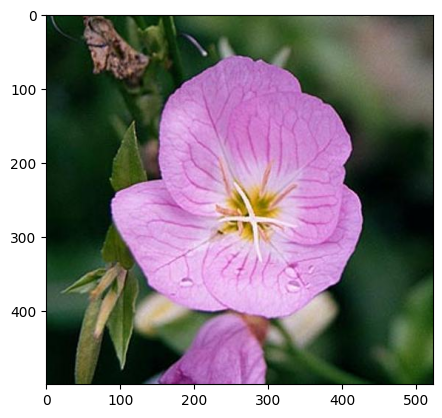

In [ ]:
img_name = text2img.iloc[0, 1]
img_name = preprocess_img_dir(img_name)
show_image(img_name)

In [ ]:
caps = text2img.iloc[0, 0]
cap = random.choice(caps)
cap

['8',
 '1',
 '7',
 '75',
 '3',
 '64',
 '2',
 '10',
 '15',
 '34',
 '16',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427',
 '5427']

In [ ]:
for i in cap:
    w = i2w_dict[i]
    print(w + ' ', end='')

a flower with short and wide petals that is light purple <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> 

In [ ]:
# train_data_cap = []
# for word_caption in text2img['Captions'].values.tolist():
#     train = transform_caption_per_img_to_list(word_caption)
#     train_data_cap.append(train)

# train_data_name = []
# for image_name in text2img['ImagePath'].values.tolist():
#     image_name = preprocess_img_dir(image_name)
#     train_data_name.append(image_name)

# print(len(train_data_cap[0]))
# print(len(train_data_name))
# print(train_data_cap[0])
# print(train_data_name[0])

## Text Encoder

### Model

In [ ]:
def cosine(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
!pip install -U sentence-transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 14.1 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125923 sha256=f17aa7acd79924e29013600b2392e5554a3766353b408e08f9e31ada9de1ea21
  Stored in directory: /root/.cache/pip/wheels/62/f2/10/1e606fd5f02395388f74e7462910fe851042f97238cbbd902f
Successfully built sentence-transformers


In [ ]:
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('all-mpnet-base-v2')

.gitattributes:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.6k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

data_config.json:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

train_script.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

#### Sentence Test Text Encoder

In [ ]:
sentences = ['cat is not a cat',
             'meower is a meower',
             'the flower is red coloured, not green coloured',
             'I ate hamburger yesterday',
             'I ate pizza and cake',
             "The displayed flower has vivid red petals and a yellow anther red pistil.",
             "the flower has red coloured petals",
             "the flower is not blue coloured, but we don't know the colour"]

In [ ]:
import numpy as np
sentence_embeddings = sbert_model.encode(sentences)

print('Sample BERT embedding vector - length', len(sentence_embeddings[0]))
# print('Sample BERT embedding vector - note includes negative values', sentence_embeddings[0])
print(np.shape(sentence_embeddings))

Sample BERT embedding vector - length 768
(8, 768)


In [ ]:
query = "the flower shown has yellow anther red pistil and bright red petals."
query_vec = sbert_model.encode([query])[0]
print(len(query_vec))

768


In [ ]:
for sent in sentences:
  sim = cosine(query_vec, sbert_model.encode(sent))
  print("Sentence = ", sent, "; similarity = ", sim)

Sentence =  cat is not a cat ; similarity =  0.10808684
Sentence =  meower is a meower ; similarity =  -0.025444139
Sentence =  the flower is red coloured, not green coloured ; similarity =  0.6946361
Sentence =  I ate hamburger yesterday ; similarity =  -0.032833073
Sentence =  I ate pizza and cake ; similarity =  -0.0038491257
Sentence =  The displayed flower has vivid red petals and a yellow anther red pistil. ; similarity =  0.9133739
Sentence =  the flower has red coloured petals ; similarity =  0.80976105
Sentence =  the flower is not blue coloured, but we don't know the colour ; similarity =  0.53599447


In [ ]:
text_encoder = sbert_model

## Data Augmentation and Train Data Loading

### Hyperparam

In [ ]:
NUM_RANDOM_EMBED = 4 # Choose 4 random embeddings to average them
NUM_AUGMENT = 3

### Method 1 : online algorithm augmentation
- translate all caption to embeddings and save to pickle file
- save img file (preload it)
- load back the df
- make the dataset and load the pickle file from df then do online augmentation

#### pre-save the data

In [ ]:
# Translate the embedding
def translate_embeddings(df):
    # load the training data into two NumPy arrays
    captions = df['Captions'].values
    image_path = df['ImagePath'].values
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    all_embeds = []
    for i in tqdm.tqdm(range(len(captions))):
        embeds = []
        for j in range(len(captions[i])):
            embeds.append(text_encoder.encode(id2seq(captions[i][j])))
        all_embeds.append(embeds)
    df['embeds'] = all_embeds
    return df

In [ ]:
def load_imgs(img_path):
    """ Do data augmentation image with more than one of the same image
        by random flip and random rotate with the averaged embeddings
    """
    # Load in the image from the image path
    img = tf.io.read_file(os.path.join(IMAGE_PATH, img_path))
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[int((IMAGE_HEIGHT * 76) / 64), int((IMAGE_WIDTH * 76) / 64)])
    img.set_shape([int((IMAGE_HEIGHT * 76) / 64), int((IMAGE_WIDTH * 76) / 64), IMAGE_CHANNEL])
    # make it into -1, 1
    img = (img - 0.5) / 0.5
    # print('max: ', np.max(img), 'min: ', np.min(img))

    return img

In [ ]:
# text2img = translate_embeddings(text2img)

100%|██████████| 7370/7370 [14:32<00:00,  8.44it/s]


In [ ]:
text2img.head()

,Captions,ImagePath,embeds
ID,,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,"[[0.049325228, -0.08779178, -0.04624424, 0.074..."
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,"[[-0.022878265, -0.027273187, -0.019405555, 0...."
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,"[[0.0042607957, -0.02295252, -0.043796115, 0.0..."
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,"[[0.035809644, -0.020764358, -0.03761639, 0.06..."
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,"[[-0.014632294, -0.07224101, -0.046013955, 0.0..."


In [ ]:
np.shape(text2img['embeds'].values[0])

(9, 768)

In [ ]:
save_pickle(text2img, os.path.join(SAVE_DATA_PATH, 'df_new.pickle'))

In [ ]:
def prefetch_images(df):
    images = []
    image_path = df['ImagePath'].values
    for i in tqdm.tqdm(range(len(image_path))):
        image = load_imgs(preprocess_img_dir(image_path[i]))
        images.append(image)
    images = np.array(images)
    print(np.shape(images))
    return images

In [ ]:
images_prefetched = prefetch_images(text2img)

100%|██████████| 7370/7370 [00:23<00:00, 307.26it/s]


(7370, 152, 152, 3)


In [ ]:
save_pickle(images_prefetched, os.path.join(SAVE_DATA_PATH, 'images_new.pickle'))

#### Start here to load

In [ ]:
# copy to runtime for faster
# !cp /content/drive/MyDrive/deep_learning/comp3/data_dump/df_new.pickle /content/
# !cp /content/drive/MyDrive/deep_learning/comp3/data_dump/images_new.pickle /content/

In [ ]:
# text2img = load_pkl_file('/content/', 'df_new.pickle')
# images_data = load_pkl_file('/content/', 'images_new.pickle')

Load filenames from: /content/df_new.pickle (7370)
Load filenames from: /content/images_new.pickle (7370)


In [ ]:
# np.shape(images_data)

(7370, 152, 152, 3)

In [ ]:
# text2img.head()

,Captions,ImagePath,embeds
ID,,,
6734,"[[9, 2, 17, 9, 1, 6, 14, 13, 18, 3, 41, 8, 11,...",./102flowers/image_06734.jpg,"[[0.049325228, -0.08779178, -0.04624424, 0.074..."
6736,"[[4, 1, 5, 12, 2, 3, 11, 31, 28, 68, 106, 132,...",./102flowers/image_06736.jpg,"[[-0.022878265, -0.027273187, -0.019405555, 0...."
6737,"[[9, 2, 27, 4, 1, 6, 14, 7, 12, 19, 5427, 5427...",./102flowers/image_06737.jpg,"[[0.0042607957, -0.02295252, -0.043796115, 0.0..."
6738,"[[9, 1, 5, 8, 54, 16, 38, 7, 12, 116, 325, 3, ...",./102flowers/image_06738.jpg,"[[0.035809644, -0.020764358, -0.03761639, 0.06..."
6739,"[[4, 12, 1, 5, 29, 11, 19, 7, 26, 70, 5427, 54...",./102flowers/image_06739.jpg,"[[-0.014632294, -0.07224101, -0.046013955, 0.0..."


#### Load Train dataset

In [ ]:
def data_augmentation_img_online(img, caption):
    """ Random flip and random rotate with the averaged embeddings
    """
    # Random crop
    cropped_image = tf.image.random_crop(img, size=[BATCH_SIZE, IM_SIZE, IM_SIZE, IMAGE_CHANNEL])
    final_image = tf.image.random_flip_left_right(cropped_image)
    return final_image, caption

In [ ]:
def parse_embeds_from_df(df):
    embeds = df['embeds'].values
    print(np.shape(embeds))
    all_embeddings = []
    for i in tqdm.tqdm(range(np.shape(embeds)[0])):
        embeddings = []
        for j in range(len(embeds[i])):
            embeddings.append(np.array(embeds[i][j]).astype(np.float32))

        for j in range(len(embeds[i]), 10, 1):
            embeddings.append(np.zeros(768).astype(np.float32))
        all_embeddings.append(np.array(embeddings))

    all_embeddings = np.array(all_embeddings)
    print('shape', np.shape(all_embeddings))
    return all_embeddings

def get_random_caption(img, embeds):
    # embeddings = []
    # print(len(embeds))
    # for i in tqdm.tqdm(range(len(embeds))):
    #     embeddings.append(random.choice(embeds[i]))
    # # embeddings = np.array(embeddings)
    # # print(np.shape(embeddings))
    embeddings = random.choice(embeds)
    while tf.math.count_nonzero(embeddings) == 0:
        embeddings = random.choice(embeds)

    print(tf.shape(embeddings))
    return img, embeddings

In [ ]:
def dataset_generator(df, images):
    image_path = df['ImagePath'].values
    embeddings = parse_embeds_from_df(df)

    dataset = tf.data.Dataset.from_tensor_slices((images, embeddings))
    dataset = dataset.map(get_random_caption, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.shuffle(len(image_path)).batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.map(data_augmentation_img_online, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
    return dataset

In [ ]:
# embeddings = parse_embeds_from_df(text2img)
# print(np.shape(embeddings))
# dataset = dataset_generator(text2img, images_data)

(7370,)


100%|██████████| 7370/7370 [00:00<00:00, 23553.06it/s]


shape (7370, 10, 768)
Tensor("Shape:0", shape=(1,), dtype=int32)


### Method 2

In [ ]:
def process_data_augmentation(df):
    # load the training data into two NumPy arrays
    captions = df['Captions'].values
    image_path = df['ImagePath'].values
    caption = []
    embeds_data = []
    images_data = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in tqdm.tqdm(range(len(captions))):
        # output should be (3, img) and (3, embedding_shape)
        augmented_embed, augmented_img = data_augmentation(captions[i], preprocess_img_dir(image_path[i]))
        #reshaped_img, reshaped_embed = reshape_fun(augmented_embed, augmented_img)
        # print(np.shape(reshaped_img), np.shape(reshaped_embed))
        embeds_data.append(augmented_embed)
        images_data.append(augmented_img)


    embeds_data = np.vstack(np.array(embeds_data))
    images_data = np.vstack(np.array(images_data))
    print('embeds_shape: ', np.shape(embeds_data))
    print('images_shape: ', np.shape(images_data))
    print('Done Processing Data Augmentation')
    return embeds_data, images_data

In [ ]:
def data_augmentation_caption(caption_img):
    """Choose 4 random captions and get their embeddings and average it
    """
    embeddings = []
    # choose 4 random embeddings without replacement
    for i in range(NUM_RANDOM_EMBED):
        cap = random.choice(caption_img)
        cap = id2seq(cap)
        embedding = text_encoder.encode(cap)
        embeddings.append(embedding)

    embeddings = np.array(embeddings)
    avg_embedding = tf.reduce_mean(embeddings, axis=0)
    # print('avg_embed:', tf.shape(avg_embedding))
    return avg_embedding

def data_augmentation_img():
    """ Random flip and random rotate with the averaged embeddings
    """
    data_augmentation = tf.keras.Sequential([
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.2),
    ])
    return data_augmentation

def data_augmentation(caption_img, img_path):
    """ Do data augmentation image with more than one of the same image
        by random flip and random rotate with the averaged embeddings
    """
    augmented_imgs = []
    augmented_embeds = []
    # Load in the image from the image path
    img = tf.io.read_file(os.path.join(IMAGE_PATH, img_path))
    img = tf.image.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img.set_shape([None, None, 3])
    img = tf.image.resize(img, size=[IMAGE_HEIGHT, IMAGE_WIDTH])
    img.set_shape([IMAGE_HEIGHT, IMAGE_WIDTH, IMAGE_CHANNEL])
    # make it into -1, 1
    img = (img - 0.5) / 0.5
    print('max: ', np.max(img), 'min: ', np.min(img))

    # augment the image and the captions
    data_augment = data_augmentation_img()
    for i in range(NUM_AUGMENT):
        augmented_img = data_augment(img)
        augmented_imgs.append(augmented_img)
        augmented_embed = data_augmentation_caption(caption_img)
        augmented_embeds.append(augmented_embed)
    # (4, img_shape), (4, embedding)
    # print('shape of augmented:', np.shape(augmented_embeds), np.shape(augmented_imgs))
    return augmented_embeds, augmented_imgs

def process_data_augmentation(df):
    # load the training data into two NumPy arrays
    captions = df['Captions'].values
    image_path = df['ImagePath'].values
    caption = []
    embeds_data = []
    images_data = []
    # each image has 1 to 10 corresponding captions
    # we choose one of them randomly for training
    for i in tqdm.tqdm(range(len(captions))):
        # output should be (3, img) and (3, embedding_shape)
        augmented_embed, augmented_img = data_augmentation(captions[i], preprocess_img_dir(image_path[i]))
        #reshaped_img, reshaped_embed = reshape_fun(augmented_embed, augmented_img)
        # print(np.shape(reshaped_img), np.shape(reshaped_embed))
        embeds_data.append(augmented_embed)
        images_data.append(augmented_img)


    embeds_data = np.vstack(np.array(embeds_data))
    images_data = np.vstack(np.array(images_data))
    print('embeds_shape: ', np.shape(embeds_data))
    print('images_shape: ', np.shape(images_data))
    print('Done Processing Data Augmentation')
    return embeds_data, images_data

#### Do Augmentation and Save The New Data in Pickle

In [ ]:
# embeddings, images = process_data_augmentation(text2img.iloc[:512, :])
embeddings, images = process_data_augmentation(text2img)
# Sanity Check
print(np.shape(embeddings), np.shape(images))

  0%|          | 0/7370 [00:00<?, ?it/s]

max:  1.0 min:  -1.0


  0%|          | 1/7370 [00:00<1:39:25,  1.24it/s]

max:  0.6977942 min:  -1.0


  0%|          | 2/7370 [00:01<1:28:19,  1.39it/s]

max:  1.0 min:  -1.0


  0%|          | 3/7370 [00:02<1:24:16,  1.46it/s]

max:  0.9916208 min:  -1.0


  0%|          | 4/7370 [00:02<1:22:06,  1.50it/s]

max:  1.0 min:  -1.0


  0%|          | 5/7370 [00:03<1:19:36,  1.54it/s]

max:  1.0 min:  -1.0


  0%|          | 6/7370 [00:04<1:19:35,  1.54it/s]

max:  1.0 min:  -0.9938764


  0%|          | 7/7370 [00:04<1:19:09,  1.55it/s]

max:  1.0 min:  -1.0


  0%|          | 8/7370 [00:05<1:19:04,  1.55it/s]

max:  0.93912005 min:  -1.0


  0%|          | 9/7370 [00:05<1:19:09,  1.55it/s]

max:  0.76386726 min:  -0.9836167


  0%|          | 10/7370 [00:06<1:19:28,  1.54it/s]

max:  0.99701285 min:  -0.9989315


  0%|          | 11/7370 [00:07<1:18:56,  1.55it/s]

max:  0.8239815 min:  -0.8936504


  0%|          | 12/7370 [00:08<1:27:29,  1.40it/s]

max:  1.0 min:  -1.0


  0%|          | 13/7370 [00:09<1:34:48,  1.29it/s]

max:  1.0 min:  -1.0


  0%|          | 14/7370 [00:09<1:39:59,  1.23it/s]

max:  1.0 min:  -1.0


  0%|          | 15/7370 [00:10<1:40:11,  1.22it/s]

max:  0.36419272 min:  -1.0


  0%|          | 16/7370 [00:11<1:35:39,  1.28it/s]

max:  1.0 min:  -1.0


  0%|          | 17/7370 [00:12<1:31:53,  1.33it/s]

max:  1.0 min:  -1.0


  0%|          | 18/7370 [00:12<1:27:22,  1.40it/s]

max:  1.0 min:  -1.0


  0%|          | 19/7370 [00:13<1:24:34,  1.45it/s]

max:  0.8313459 min:  -0.9992647


  0%|          | 20/7370 [00:14<1:22:29,  1.49it/s]

max:  0.8016392 min:  -1.0


  0%|          | 21/7370 [00:14<1:21:47,  1.50it/s]

max:  1.0 min:  -1.0


  0%|          | 22/7370 [00:15<1:21:42,  1.50it/s]

max:  1.0 min:  -1.0


  0%|          | 23/7370 [00:15<1:20:46,  1.52it/s]

max:  1.0 min:  -1.0


  0%|          | 24/7370 [00:16<1:20:16,  1.53it/s]

max:  1.0 min:  -1.0


  0%|          | 25/7370 [00:17<1:20:41,  1.52it/s]

max:  0.8281864 min:  -1.0


  0%|          | 26/7370 [00:17<1:19:42,  1.54it/s]

max:  0.9734721 min:  -1.0


  0%|          | 27/7370 [00:18<1:20:15,  1.52it/s]

max:  0.6313727 min:  -0.8763289


  0%|          | 28/7370 [00:19<1:19:42,  1.54it/s]

max:  0.8683232 min:  -0.9375785


  0%|          | 29/7370 [00:19<1:19:38,  1.54it/s]

max:  0.52411544 min:  -1.0


  0%|          | 30/7370 [00:20<1:21:12,  1.51it/s]

max:  0.7634268 min:  -0.9853439


  0%|          | 31/7370 [00:21<1:25:41,  1.43it/s]

max:  0.9895451 min:  -1.0


  0%|          | 32/7370 [00:22<1:32:35,  1.32it/s]

max:  1.0 min:  -1.0


  0%|          | 33/7370 [00:23<1:33:49,  1.30it/s]

max:  0.9975605 min:  -1.0


  0%|          | 34/7370 [00:23<1:32:37,  1.32it/s]

max:  1.0 min:  -1.0


  0%|          | 35/7370 [00:24<1:33:26,  1.31it/s]

max:  0.9738972 min:  -1.0


  0%|          | 36/7370 [00:25<1:30:36,  1.35it/s]

max:  1.0 min:  -1.0


  1%|          | 37/7370 [00:25<1:26:55,  1.41it/s]

max:  0.8465055 min:  -1.0


  1%|          | 38/7370 [00:26<1:25:09,  1.44it/s]

max:  1.0 min:  -1.0


  1%|          | 39/7370 [00:27<1:22:04,  1.49it/s]

max:  1.0 min:  -1.0


  1%|          | 40/7370 [00:27<1:20:42,  1.51it/s]

max:  1.0 min:  -1.0


  1%|          | 41/7370 [00:28<1:19:36,  1.53it/s]

max:  1.0 min:  -0.9754002


  1%|          | 42/7370 [00:29<1:19:50,  1.53it/s]

max:  0.99682903 min:  -1.0


  1%|          | 43/7370 [00:29<1:19:10,  1.54it/s]

max:  1.0 min:  -1.0


  1%|          | 44/7370 [00:30<1:19:22,  1.54it/s]

max:  1.0 min:  -1.0


  1%|          | 45/7370 [00:31<1:19:10,  1.54it/s]

max:  1.0 min:  -1.0


  1%|          | 46/7370 [00:31<1:19:41,  1.53it/s]

max:  0.9793545 min:  -1.0


  1%|          | 47/7370 [00:32<1:19:44,  1.53it/s]

max:  0.9079658 min:  -1.0


  1%|          | 48/7370 [00:33<1:19:49,  1.53it/s]

max:  0.91948545 min:  -1.0


  1%|          | 49/7370 [00:33<1:19:20,  1.54it/s]

max:  0.9673064 min:  -1.0


  1%|          | 50/7370 [00:34<1:18:24,  1.56it/s]

max:  0.7286097 min:  -0.99994254


  1%|          | 51/7370 [00:35<1:24:25,  1.44it/s]

max:  0.9745827 min:  -1.0


  1%|          | 52/7370 [00:35<1:26:42,  1.41it/s]

max:  1.0 min:  -1.0


  1%|          | 53/7370 [00:36<1:29:44,  1.36it/s]

max:  0.9389707 min:  -1.0


  1%|          | 54/7370 [00:37<1:30:51,  1.34it/s]

max:  1.0 min:  -0.99736136


  1%|          | 55/7370 [00:38<1:31:57,  1.33it/s]

max:  0.9991039 min:  -1.0


  1%|          | 56/7370 [00:38<1:33:42,  1.30it/s]

max:  0.877522 min:  -0.99903494


  1%|          | 57/7370 [00:39<1:28:16,  1.38it/s]

max:  1.0 min:  -1.0


  1%|          | 58/7370 [00:40<1:25:46,  1.42it/s]

max:  0.9148114 min:  -1.0


  1%|          | 59/7370 [00:40<1:23:54,  1.45it/s]

max:  1.0 min:  -1.0


  1%|          | 60/7370 [00:41<1:22:52,  1.47it/s]

max:  0.9605508 min:  -1.0


  1%|          | 61/7370 [00:42<1:21:03,  1.50it/s]

max:  1.0 min:  -1.0


  1%|          | 62/7370 [00:42<1:19:15,  1.54it/s]

max:  1.0 min:  -1.0


  1%|          | 63/7370 [00:43<1:18:59,  1.54it/s]

max:  1.0 min:  -1.0


  1%|          | 64/7370 [00:44<1:19:38,  1.53it/s]

max:  0.9912684 min:  -1.0


  1%|          | 65/7370 [00:44<1:19:29,  1.53it/s]

max:  1.0 min:  -1.0


  1%|          | 66/7370 [00:45<1:19:35,  1.53it/s]

max:  1.0 min:  -1.0


  1%|          | 67/7370 [00:46<1:18:15,  1.56it/s]

max:  0.95201635 min:  -1.0


  1%|          | 68/7370 [00:46<1:18:05,  1.56it/s]

max:  0.8310051 min:  -1.0


  1%|          | 69/7370 [00:47<1:17:28,  1.57it/s]

max:  1.0 min:  -1.0


  1%|          | 70/7370 [00:47<1:16:45,  1.59it/s]

max:  1.0 min:  -1.0


  1%|          | 71/7370 [00:48<1:16:37,  1.59it/s]

max:  0.98509705 min:  -1.0


  1%|          | 72/7370 [00:49<1:19:45,  1.52it/s]

max:  0.95512605 min:  -0.9906135


  1%|          | 73/7370 [00:50<1:24:44,  1.44it/s]

max:  1.0 min:  -1.0


  1%|          | 74/7370 [00:50<1:26:47,  1.40it/s]

max:  0.69653046 min:  -1.0


  1%|          | 75/7370 [00:51<1:29:21,  1.36it/s]

max:  0.8463428 min:  -1.0


  1%|          | 76/7370 [00:52<1:31:37,  1.33it/s]

max:  1.0 min:  -1.0


  1%|          | 77/7370 [00:53<1:33:27,  1.30it/s]

max:  1.0 min:  -0.93443626


  1%|          | 78/7370 [00:53<1:28:53,  1.37it/s]

max:  0.857108 min:  -0.84569544


  1%|          | 79/7370 [00:54<1:24:55,  1.43it/s]

max:  1.0 min:  -1.0


  1%|          | 80/7370 [00:55<1:24:00,  1.45it/s]

max:  0.9949603 min:  -1.0


  1%|          | 81/7370 [00:55<1:22:39,  1.47it/s]

max:  1.0 min:  -1.0


  1%|          | 82/7370 [00:56<1:21:07,  1.50it/s]

max:  0.9505631 min:  -1.0


  1%|          | 83/7370 [00:57<1:19:20,  1.53it/s]

max:  0.8006129 min:  -1.0


  1%|          | 84/7370 [00:57<1:19:11,  1.53it/s]

max:  0.6518307 min:  -1.0


  1%|          | 85/7370 [00:58<1:17:33,  1.57it/s]

max:  0.763042 min:  -1.0


  1%|          | 86/7370 [00:58<1:17:51,  1.56it/s]

max:  1.0 min:  -1.0


  1%|          | 87/7370 [00:59<1:18:01,  1.56it/s]

max:  0.92557466 min:  -1.0


  1%|          | 88/7370 [01:00<1:18:33,  1.54it/s]

max:  1.0 min:  -1.0


  1%|          | 89/7370 [01:00<1:20:08,  1.51it/s]

max:  0.97262955 min:  -1.0


  1%|          | 90/7370 [01:01<1:20:55,  1.50it/s]

max:  0.9419061 min:  -1.0


  1%|          | 91/7370 [01:02<1:20:51,  1.50it/s]

max:  1.0 min:  -1.0


  1%|          | 92/7370 [01:02<1:20:38,  1.50it/s]

max:  1.0 min:  -1.0


  1%|▏         | 93/7370 [01:03<1:23:26,  1.45it/s]

max:  1.0 min:  -1.0


  1%|▏         | 94/7370 [01:04<1:28:38,  1.37it/s]

max:  1.0 min:  -0.95240116


  1%|▏         | 95/7370 [01:05<1:32:27,  1.31it/s]

max:  1.0 min:  -1.0


  1%|▏         | 96/7370 [01:06<1:37:18,  1.25it/s]

max:  1.0 min:  -1.0


  1%|▏         | 97/7370 [01:06<1:34:39,  1.28it/s]

max:  1.0 min:  -1.0


  1%|▏         | 98/7370 [01:07<1:28:14,  1.37it/s]

max:  1.0 min:  -1.0


  1%|▏         | 99/7370 [01:08<1:24:41,  1.43it/s]

max:  0.86849356 min:  -0.9607843


  1%|▏         | 100/7370 [01:08<1:22:59,  1.46it/s]

max:  1.0 min:  -1.0


  1%|▏         | 101/7370 [01:09<1:21:56,  1.48it/s]

max:  1.0 min:  -1.0


  1%|▏         | 102/7370 [01:10<1:21:00,  1.50it/s]

max:  1.0 min:  -1.0


  1%|▏         | 103/7370 [01:10<1:20:34,  1.50it/s]

max:  1.0 min:  -1.0


  1%|▏         | 104/7370 [01:11<1:20:05,  1.51it/s]

max:  1.0 min:  -1.0


  1%|▏         | 105/7370 [01:12<1:19:42,  1.52it/s]

max:  1.0 min:  -0.9992647


  1%|▏         | 106/7370 [01:12<1:19:34,  1.52it/s]

max:  1.0 min:  -1.0


  1%|▏         | 107/7370 [01:13<1:19:37,  1.52it/s]

max:  1.0 min:  -1.0


  1%|▏         | 108/7370 [01:14<1:20:11,  1.51it/s]

max:  0.9438727 min:  -1.0


  1%|▏         | 109/7370 [01:14<1:19:22,  1.52it/s]

max:  1.0 min:  -0.8884153


  1%|▏         | 110/7370 [01:15<1:18:17,  1.55it/s]

max:  1.0 min:  -1.0


  2%|▏         | 111/7370 [01:16<1:18:28,  1.54it/s]

max:  1.0 min:  -1.0


  2%|▏         | 112/7370 [01:16<1:17:59,  1.55it/s]

max:  1.0 min:  -1.0


  2%|▏         | 113/7370 [01:17<1:26:10,  1.40it/s]

max:  0.9979894 min:  -1.0


  2%|▏         | 114/7370 [01:18<1:27:37,  1.38it/s]

max:  1.0 min:  -1.0


  2%|▏         | 115/7370 [01:19<1:29:44,  1.35it/s]

max:  1.0 min:  -1.0


  2%|▏         | 116/7370 [01:19<1:33:46,  1.29it/s]

max:  1.0 min:  -1.0


  2%|▏         | 117/7370 [01:20<1:31:50,  1.32it/s]

max:  1.0 min:  -1.0


  2%|▏         | 118/7370 [01:21<1:26:49,  1.39it/s]

max:  1.0 min:  -1.0


  2%|▏         | 119/7370 [01:21<1:24:26,  1.43it/s]

max:  1.0 min:  -1.0


  2%|▏         | 120/7370 [01:22<1:21:46,  1.48it/s]

max:  1.0 min:  -1.0


  2%|▏         | 121/7370 [01:23<1:20:36,  1.50it/s]

max:  0.93189347 min:  -1.0


  2%|▏         | 122/7370 [01:23<1:18:36,  1.54it/s]

max:  0.8374044 min:  -1.0


  2%|▏         | 123/7370 [01:24<1:17:35,  1.56it/s]

max:  1.0 min:  -1.0


  2%|▏         | 124/7370 [01:25<1:16:17,  1.58it/s]

max:  1.0 min:  -1.0


  2%|▏         | 125/7370 [01:25<1:16:21,  1.58it/s]

max:  1.0 min:  -1.0


  2%|▏         | 126/7370 [01:26<1:17:13,  1.56it/s]

max:  1.0 min:  -1.0


  2%|▏         | 127/7370 [01:26<1:16:49,  1.57it/s]

max:  0.87529886 min:  -1.0


  2%|▏         | 128/7370 [01:27<1:15:59,  1.59it/s]

max:  0.4479972 min:  -1.0


  2%|▏         | 129/7370 [01:28<1:16:35,  1.58it/s]

max:  0.97607994 min:  -0.98223037


  2%|▏         | 130/7370 [01:28<1:15:40,  1.59it/s]

max:  1.0 min:  -0.9507353


  2%|▏         | 131/7370 [01:29<1:14:50,  1.61it/s]

max:  0.99271023 min:  -1.0


  2%|▏         | 132/7370 [01:30<1:15:00,  1.61it/s]

max:  1.0 min:  -1.0


  2%|▏         | 133/7370 [01:30<1:20:30,  1.50it/s]

max:  1.0 min:  -0.97157055


  2%|▏         | 134/7370 [01:31<1:23:40,  1.44it/s]

max:  1.0 min:  -1.0


  2%|▏         | 135/7370 [01:32<1:25:36,  1.41it/s]

max:  0.9561964 min:  -0.99667585


  2%|▏         | 136/7370 [01:33<1:26:53,  1.39it/s]

max:  1.0 min:  -1.0


  2%|▏         | 137/7370 [01:33<1:27:27,  1.38it/s]

max:  1.0 min:  -1.0


  2%|▏         | 138/7370 [01:34<1:29:55,  1.34it/s]

max:  1.0 min:  -0.73309207


  2%|▏         | 139/7370 [01:35<1:25:51,  1.40it/s]

max:  1.0 min:  -0.86954653


  2%|▏         | 140/7370 [01:36<1:26:46,  1.39it/s]

max:  1.0 min:  -1.0


  2%|▏         | 141/7370 [01:36<1:24:58,  1.42it/s]

max:  0.9991269 min:  -0.4011948


  2%|▏         | 142/7370 [01:37<1:27:21,  1.38it/s]

max:  1.0 min:  -0.9902478


  2%|▏         | 143/7370 [01:38<1:23:17,  1.45it/s]

max:  1.0 min:  -1.0


  2%|▏         | 144/7370 [01:38<1:20:50,  1.49it/s]

max:  1.0 min:  -0.9909467


  2%|▏         | 145/7370 [01:39<1:18:42,  1.53it/s]

max:  1.0 min:  -1.0


  2%|▏         | 146/7370 [01:39<1:17:43,  1.55it/s]

max:  1.0 min:  -1.0


  2%|▏         | 147/7370 [01:40<1:18:59,  1.52it/s]

max:  1.0 min:  -0.932284


  2%|▏         | 148/7370 [01:41<1:17:57,  1.54it/s]

max:  1.0 min:  -1.0


  2%|▏         | 149/7370 [01:41<1:18:27,  1.53it/s]

max:  1.0 min:  -1.0


  2%|▏         | 150/7370 [01:42<1:17:44,  1.55it/s]

max:  0.999146 min:  -0.924393


  2%|▏         | 151/7370 [01:43<1:18:20,  1.54it/s]

max:  1.0 min:  -1.0


  2%|▏         | 152/7370 [01:43<1:18:24,  1.53it/s]

max:  1.0 min:  -0.81192935


  2%|▏         | 153/7370 [01:44<1:17:50,  1.55it/s]

max:  1.0 min:  -1.0


  2%|▏         | 154/7370 [01:45<1:27:01,  1.38it/s]

max:  1.0 min:  -0.95686656


  2%|▏         | 155/7370 [01:46<1:30:25,  1.33it/s]

max:  1.0 min:  -1.0


  2%|▏         | 156/7370 [01:47<1:35:50,  1.25it/s]

max:  1.0 min:  -1.0


  2%|▏         | 157/7370 [01:47<1:38:46,  1.22it/s]

max:  1.0 min:  -1.0


  2%|▏         | 158/7370 [01:48<1:41:34,  1.18it/s]

max:  1.0 min:  -1.0


  2%|▏         | 159/7370 [01:49<1:40:25,  1.20it/s]

max:  1.0 min:  -1.0


  2%|▏         | 160/7370 [01:50<1:35:52,  1.25it/s]

max:  1.0 min:  -1.0


  2%|▏         | 161/7370 [01:51<1:29:46,  1.34it/s]

max:  1.0 min:  -0.9262676


  2%|▏         | 162/7370 [01:51<1:26:23,  1.39it/s]

max:  0.91274524 min:  -1.0


  2%|▏         | 163/7370 [01:52<1:24:06,  1.43it/s]

max:  1.0 min:  -0.9220148


  2%|▏         | 164/7370 [01:52<1:22:05,  1.46it/s]

max:  0.9762256 min:  -1.0


  2%|▏         | 165/7370 [01:53<1:19:33,  1.51it/s]

max:  1.0 min:  -1.0


  2%|▏         | 166/7370 [01:54<1:18:58,  1.52it/s]

max:  0.9952091 min:  -1.0


  2%|▏         | 167/7370 [01:54<1:17:44,  1.54it/s]

max:  1.0 min:  -1.0


  2%|▏         | 168/7370 [01:55<1:17:37,  1.55it/s]

max:  0.99870753 min:  -1.0


  2%|▏         | 169/7370 [01:56<1:17:56,  1.54it/s]

max:  1.0 min:  -1.0


  2%|▏         | 170/7370 [01:56<1:16:52,  1.56it/s]

max:  1.0 min:  -1.0


  2%|▏         | 171/7370 [01:57<1:17:02,  1.56it/s]

max:  1.0 min:  -0.923223


  2%|▏         | 172/7370 [01:58<1:16:09,  1.58it/s]

max:  1.0 min:  -1.0


  2%|▏         | 173/7370 [01:58<1:16:50,  1.56it/s]

max:  0.8221202 min:  -1.0


  2%|▏         | 174/7370 [01:59<1:16:07,  1.58it/s]

max:  0.9978267 min:  -1.0


  2%|▏         | 175/7370 [01:59<1:15:57,  1.58it/s]

max:  0.9632833 min:  -1.0


  2%|▏         | 176/7370 [02:00<1:24:38,  1.42it/s]

max:  1.0 min:  -1.0


  2%|▏         | 177/7370 [02:01<1:30:32,  1.32it/s]

max:  0.9146141 min:  -0.99659926


  2%|▏         | 178/7370 [02:02<1:33:50,  1.28it/s]

max:  0.99112475 min:  -1.0


  2%|▏         | 179/7370 [02:03<1:37:01,  1.24it/s]

max:  0.9954618 min:  -0.9339461


  2%|▏         | 180/7370 [02:04<1:30:51,  1.32it/s]

max:  1.0 min:  -0.8337163


  2%|▏         | 181/7370 [02:04<1:26:52,  1.38it/s]

max:  1.0 min:  -0.97787225


  2%|▏         | 182/7370 [02:05<1:24:14,  1.42it/s]

max:  0.9968138 min:  -1.0


  2%|▏         | 183/7370 [02:06<1:22:18,  1.46it/s]

max:  1.0 min:  -1.0


  2%|▏         | 184/7370 [02:06<1:21:08,  1.48it/s]

max:  1.0 min:  -1.0


  3%|▎         | 185/7370 [02:07<1:20:32,  1.49it/s]

max:  1.0 min:  -1.0


  3%|▎         | 186/7370 [02:07<1:19:56,  1.50it/s]

max:  1.0 min:  -1.0


  3%|▎         | 187/7370 [02:08<1:18:34,  1.52it/s]

max:  1.0 min:  -1.0


  3%|▎         | 188/7370 [02:09<1:17:42,  1.54it/s]

max:  0.8240771 min:  -1.0


  3%|▎         | 189/7370 [02:09<1:17:00,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 190/7370 [02:10<1:17:03,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 191/7370 [02:11<1:16:24,  1.57it/s]

max:  1.0 min:  -1.0


  3%|▎         | 192/7370 [02:11<1:16:44,  1.56it/s]

max:  1.0 min:  -1.0


  3%|▎         | 193/7370 [02:12<1:15:48,  1.58it/s]

max:  1.0 min:  -1.0


  3%|▎         | 194/7370 [02:13<1:15:05,  1.59it/s]

max:  1.0 min:  -1.0


  3%|▎         | 195/7370 [02:13<1:18:54,  1.52it/s]

max:  1.0 min:  -1.0


  3%|▎         | 196/7370 [02:14<1:25:11,  1.40it/s]

max:  1.0 min:  -1.0


  3%|▎         | 197/7370 [02:15<1:30:19,  1.32it/s]

max:  0.9553157 min:  -0.9026348


  3%|▎         | 198/7370 [02:16<1:33:00,  1.29it/s]

max:  1.0 min:  -1.0


  3%|▎         | 199/7370 [02:17<1:31:31,  1.31it/s]

max:  1.0 min:  -1.0


  3%|▎         | 200/7370 [02:17<1:26:53,  1.38it/s]

max:  0.98176515 min:  -1.0


  3%|▎         | 201/7370 [02:18<1:22:49,  1.44it/s]

max:  1.0 min:  -1.0


  3%|▎         | 202/7370 [02:18<1:21:20,  1.47it/s]

max:  1.0 min:  -1.0


  3%|▎         | 203/7370 [02:19<1:19:27,  1.50it/s]

max:  1.0 min:  -1.0


  3%|▎         | 204/7370 [02:20<1:18:48,  1.52it/s]

max:  1.0 min:  -1.0


  3%|▎         | 205/7370 [02:20<1:18:34,  1.52it/s]

max:  0.99407554 min:  -1.0


  3%|▎         | 206/7370 [02:21<1:17:35,  1.54it/s]

max:  1.0 min:  -1.0


  3%|▎         | 207/7370 [02:22<1:18:14,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 208/7370 [02:22<1:19:01,  1.51it/s]

max:  1.0 min:  -1.0


  3%|▎         | 209/7370 [02:23<1:17:48,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 210/7370 [02:24<1:17:34,  1.54it/s]

max:  1.0 min:  -1.0


  3%|▎         | 211/7370 [02:24<1:15:49,  1.57it/s]

max:  1.0 min:  -1.0


  3%|▎         | 212/7370 [02:25<1:15:47,  1.57it/s]

max:  0.8563765 min:  -1.0


  3%|▎         | 213/7370 [02:26<1:17:53,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 214/7370 [02:26<1:19:12,  1.51it/s]

max:  1.0 min:  -1.0


  3%|▎         | 215/7370 [02:27<1:27:15,  1.37it/s]

max:  1.0 min:  -1.0


  3%|▎         | 216/7370 [02:28<1:32:20,  1.29it/s]

max:  0.95667326 min:  -1.0


  3%|▎         | 217/7370 [02:29<1:34:48,  1.26it/s]

max:  1.0 min:  -1.0


  3%|▎         | 218/7370 [02:30<1:34:14,  1.26it/s]

max:  1.0 min:  -1.0


  3%|▎         | 219/7370 [02:30<1:29:21,  1.33it/s]

max:  1.0 min:  -1.0


  3%|▎         | 220/7370 [02:31<1:25:24,  1.40it/s]

max:  0.762818 min:  -1.0


  3%|▎         | 221/7370 [02:32<1:22:59,  1.44it/s]

max:  1.0 min:  -1.0


  3%|▎         | 222/7370 [02:32<1:19:33,  1.50it/s]

max:  1.0 min:  -1.0


  3%|▎         | 223/7370 [02:33<1:18:04,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 224/7370 [02:33<1:16:39,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 225/7370 [02:34<1:16:43,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 226/7370 [02:35<1:16:44,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 227/7370 [02:35<1:16:32,  1.56it/s]

max:  0.94802403 min:  -1.0


  3%|▎         | 228/7370 [02:36<1:17:11,  1.54it/s]

max:  1.0 min:  -1.0


  3%|▎         | 229/7370 [02:37<1:16:38,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 230/7370 [02:37<1:16:10,  1.56it/s]

max:  1.0 min:  -1.0


  3%|▎         | 231/7370 [02:38<1:15:35,  1.57it/s]

max:  1.0 min:  -1.0


  3%|▎         | 232/7370 [02:39<1:15:20,  1.58it/s]

max:  0.97693026 min:  -1.0


  3%|▎         | 233/7370 [02:39<1:15:07,  1.58it/s]

max:  1.0 min:  -1.0


  3%|▎         | 234/7370 [02:40<1:19:01,  1.51it/s]

max:  0.99852943 min:  -1.0


  3%|▎         | 235/7370 [02:41<1:26:50,  1.37it/s]

max:  1.0 min:  -1.0


  3%|▎         | 236/7370 [02:42<1:31:34,  1.30it/s]

max:  1.0 min:  -1.0


  3%|▎         | 237/7370 [02:42<1:35:11,  1.25it/s]

max:  1.0 min:  -1.0


  3%|▎         | 238/7370 [02:43<1:31:09,  1.30it/s]

max:  1.0 min:  -1.0


  3%|▎         | 239/7370 [02:44<1:27:27,  1.36it/s]

max:  1.0 min:  -1.0


  3%|▎         | 240/7370 [02:44<1:23:27,  1.42it/s]

max:  1.0 min:  -1.0


  3%|▎         | 241/7370 [02:45<1:20:45,  1.47it/s]

max:  1.0 min:  -1.0


  3%|▎         | 242/7370 [02:46<1:18:58,  1.50it/s]

max:  1.0 min:  -1.0


  3%|▎         | 243/7370 [02:46<1:20:01,  1.48it/s]

max:  1.0 min:  -1.0


  3%|▎         | 244/7370 [02:47<1:19:01,  1.50it/s]

max:  1.0 min:  -1.0


  3%|▎         | 245/7370 [02:48<1:17:36,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 246/7370 [02:48<1:17:22,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 247/7370 [02:49<1:17:29,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 248/7370 [02:50<1:17:18,  1.54it/s]

max:  1.0 min:  -1.0


  3%|▎         | 249/7370 [02:50<1:17:40,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 250/7370 [02:51<1:17:46,  1.53it/s]

max:  1.0 min:  -1.0


  3%|▎         | 251/7370 [02:52<1:16:52,  1.54it/s]

max:  1.0 min:  -1.0


  3%|▎         | 252/7370 [02:52<1:16:45,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 253/7370 [02:53<1:16:38,  1.55it/s]

max:  1.0 min:  -1.0


  3%|▎         | 254/7370 [02:54<1:20:06,  1.48it/s]

max:  1.0 min:  -1.0


  3%|▎         | 255/7370 [02:54<1:23:32,  1.42it/s]

max:  1.0 min:  -1.0


  3%|▎         | 256/7370 [02:55<1:29:57,  1.32it/s]

max:  1.0 min:  -1.0


  3%|▎         | 257/7370 [02:56<1:30:19,  1.31it/s]

max:  1.0 min:  -1.0


  4%|▎         | 258/7370 [02:57<1:31:34,  1.29it/s]

max:  1.0 min:  -1.0


  4%|▎         | 259/7370 [02:58<1:27:03,  1.36it/s]

max:  1.0 min:  -1.0


  4%|▎         | 260/7370 [02:58<1:23:48,  1.41it/s]

max:  1.0 min:  -0.97676355


  4%|▎         | 261/7370 [02:59<1:21:23,  1.46it/s]

max:  1.0 min:  -1.0


  4%|▎         | 262/7370 [02:59<1:18:17,  1.51it/s]

max:  1.0 min:  -1.0


  4%|▎         | 263/7370 [03:00<1:17:16,  1.53it/s]

max:  1.0 min:  -1.0


  4%|▎         | 264/7370 [03:01<1:17:29,  1.53it/s]

max:  1.0 min:  -1.0


  4%|▎         | 265/7370 [03:01<1:16:09,  1.56it/s]

max:  1.0 min:  -1.0


  4%|▎         | 266/7370 [03:02<1:16:30,  1.55it/s]

max:  1.0 min:  -1.0


  4%|▎         | 267/7370 [03:03<1:16:54,  1.54it/s]

max:  1.0 min:  -1.0


  4%|▎         | 268/7370 [03:03<1:15:38,  1.56it/s]

max:  0.96297693 min:  -1.0


  4%|▎         | 269/7370 [03:04<1:15:17,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▎         | 270/7370 [03:05<1:16:24,  1.55it/s]

max:  1.0 min:  -1.0


  4%|▎         | 271/7370 [03:05<1:14:54,  1.58it/s]

max:  1.0 min:  -1.0


  4%|▎         | 272/7370 [03:06<1:16:35,  1.54it/s]

max:  1.0 min:  -1.0


  4%|▎         | 273/7370 [03:06<1:17:14,  1.53it/s]

max:  1.0 min:  -1.0


  4%|▎         | 274/7370 [03:07<1:20:45,  1.46it/s]

max:  1.0 min:  -1.0


  4%|▎         | 275/7370 [03:08<1:24:22,  1.40it/s]

max:  1.0 min:  -1.0


  4%|▎         | 276/7370 [03:09<1:28:43,  1.33it/s]

max:  1.0 min:  -1.0


  4%|▍         | 277/7370 [03:10<1:32:55,  1.27it/s]

max:  1.0 min:  -1.0


  4%|▍         | 278/7370 [03:11<1:33:26,  1.27it/s]

max:  1.0 min:  -1.0


  4%|▍         | 279/7370 [03:11<1:28:33,  1.33it/s]

max:  0.65916836 min:  -1.0


  4%|▍         | 280/7370 [03:12<1:24:24,  1.40it/s]

max:  0.8039466 min:  -1.0


  4%|▍         | 281/7370 [03:12<1:21:05,  1.46it/s]

max:  0.992157 min:  -1.0


  4%|▍         | 282/7370 [03:13<1:21:03,  1.46it/s]

max:  1.0 min:  -1.0


  4%|▍         | 283/7370 [03:14<1:18:48,  1.50it/s]

max:  0.92524517 min:  -0.9732958


  4%|▍         | 284/7370 [03:14<1:17:06,  1.53it/s]

max:  0.9229053 min:  -1.0


  4%|▍         | 285/7370 [03:15<1:15:46,  1.56it/s]

max:  1.0 min:  -1.0


  4%|▍         | 286/7370 [03:16<1:15:39,  1.56it/s]

max:  0.84794164 min:  -1.0


  4%|▍         | 287/7370 [03:16<1:15:41,  1.56it/s]

max:  0.8503103 min:  -1.0


  4%|▍         | 288/7370 [03:17<1:15:08,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▍         | 289/7370 [03:18<1:15:38,  1.56it/s]

max:  1.0 min:  -1.0


  4%|▍         | 290/7370 [03:18<1:15:15,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▍         | 291/7370 [03:19<1:14:58,  1.57it/s]

max:  1.0 min:  -0.9778665


  4%|▍         | 292/7370 [03:19<1:14:50,  1.58it/s]

max:  1.0 min:  -1.0


  4%|▍         | 293/7370 [03:20<1:15:18,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▍         | 294/7370 [03:21<1:21:14,  1.45it/s]

max:  1.0 min:  -0.71148705


  4%|▍         | 295/7370 [03:22<1:25:52,  1.37it/s]

max:  0.9993087 min:  -1.0


  4%|▍         | 296/7370 [03:23<1:29:52,  1.31it/s]

max:  1.0 min:  -1.0


  4%|▍         | 297/7370 [03:23<1:31:00,  1.30it/s]

max:  1.0 min:  -1.0


  4%|▍         | 298/7370 [03:24<1:31:22,  1.29it/s]

max:  1.0 min:  -1.0


  4%|▍         | 299/7370 [03:25<1:26:51,  1.36it/s]

max:  1.0 min:  -1.0


  4%|▍         | 300/7370 [03:25<1:23:14,  1.42it/s]

max:  0.7987746 min:  -1.0


  4%|▍         | 301/7370 [03:26<1:19:35,  1.48it/s]

max:  1.0 min:  -1.0


  4%|▍         | 302/7370 [03:27<1:18:07,  1.51it/s]

max:  1.0 min:  -1.0


  4%|▍         | 303/7370 [03:27<1:17:15,  1.52it/s]

max:  0.96497023 min:  -1.0


  4%|▍         | 304/7370 [03:28<1:16:19,  1.54it/s]

max:  1.0 min:  -1.0


  4%|▍         | 305/7370 [03:29<1:15:35,  1.56it/s]

max:  1.0 min:  -0.87303925


  4%|▍         | 306/7370 [03:29<1:14:55,  1.57it/s]

max:  1.0 min:  -0.7398093


  4%|▍         | 307/7370 [03:30<1:13:46,  1.60it/s]

max:  1.0 min:  -1.0


  4%|▍         | 308/7370 [03:30<1:14:34,  1.58it/s]

max:  0.71571136 min:  -1.0


  4%|▍         | 309/7370 [03:31<1:15:27,  1.56it/s]

max:  1.0 min:  -1.0


  4%|▍         | 310/7370 [03:32<1:15:25,  1.56it/s]

max:  1.0 min:  -0.9976639


  4%|▍         | 311/7370 [03:32<1:15:00,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▍         | 312/7370 [03:33<1:14:45,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▍         | 313/7370 [03:34<1:15:13,  1.56it/s]

max:  1.0 min:  -1.0


  4%|▍         | 314/7370 [03:34<1:17:28,  1.52it/s]

max:  1.0 min:  -1.0


  4%|▍         | 315/7370 [03:35<1:23:52,  1.40it/s]

max:  1.0 min:  -1.0


  4%|▍         | 316/7370 [03:36<1:28:18,  1.33it/s]

max:  1.0 min:  -1.0


  4%|▍         | 317/7370 [03:37<1:31:33,  1.28it/s]

max:  1.0 min:  -1.0


  4%|▍         | 318/7370 [03:38<1:30:21,  1.30it/s]

max:  1.0 min:  -1.0


  4%|▍         | 319/7370 [03:38<1:25:40,  1.37it/s]

max:  0.9940449 min:  -1.0


  4%|▍         | 320/7370 [03:39<1:21:19,  1.44it/s]

max:  0.8259096 min:  -1.0


  4%|▍         | 321/7370 [03:39<1:19:18,  1.48it/s]

max:  0.9986731 min:  -1.0


  4%|▍         | 322/7370 [03:40<1:18:28,  1.50it/s]

max:  1.0 min:  -1.0


  4%|▍         | 323/7370 [03:41<1:17:33,  1.51it/s]

max:  1.0 min:  -0.99901193


  4%|▍         | 324/7370 [03:41<1:16:24,  1.54it/s]

max:  1.0 min:  -1.0


  4%|▍         | 325/7370 [03:42<1:14:59,  1.57it/s]

max:  1.0 min:  -1.0


  4%|▍         | 326/7370 [03:43<1:15:00,  1.56it/s]

max:  1.0 min:  -1.0


  4%|▍         | 327/7370 [03:43<1:15:41,  1.55it/s]

max:  1.0 min:  -1.0


  4%|▍         | 328/7370 [03:44<1:15:36,  1.55it/s]

max:  1.0 min:  -1.0


  4%|▍         | 329/7370 [03:45<1:15:58,  1.54it/s]

max:  1.0 min:  -1.0


  4%|▍         | 330/7370 [03:45<1:16:12,  1.54it/s]

max:  0.7791668 min:  -1.0


  4%|▍         | 331/7370 [03:46<1:16:05,  1.54it/s]

max:  1.0 min:  -1.0


  5%|▍         | 332/7370 [03:47<1:16:32,  1.53it/s]

max:  1.0 min:  -1.0


  5%|▍         | 333/7370 [03:47<1:14:53,  1.57it/s]

max:  1.0 min:  -1.0


  5%|▍         | 334/7370 [03:48<1:22:43,  1.42it/s]

max:  1.0 min:  -1.0


  5%|▍         | 335/7370 [03:49<1:27:50,  1.33it/s]

max:  1.0 min:  -1.0


  5%|▍         | 336/7370 [03:50<1:30:36,  1.29it/s]

max:  1.0 min:  -0.996381


  5%|▍         | 337/7370 [03:51<1:33:31,  1.25it/s]

max:  0.93569636 min:  -1.0


  5%|▍         | 338/7370 [03:51<1:27:54,  1.33it/s]

max:  1.0 min:  -0.9985639


  5%|▍         | 339/7370 [03:52<1:23:38,  1.40it/s]

max:  1.0 min:  -1.0


  5%|▍         | 340/7370 [03:52<1:19:57,  1.47it/s]

max:  1.0 min:  -1.0


  5%|▍         | 341/7370 [03:53<1:18:03,  1.50it/s]

max:  1.0 min:  -1.0


  5%|▍         | 342/7370 [03:54<1:17:14,  1.52it/s]

max:  1.0 min:  -1.0


  5%|▍         | 343/7370 [03:54<1:17:08,  1.52it/s]

max:  1.0 min:  -0.88568664


  5%|▍         | 344/7370 [03:55<1:16:29,  1.53it/s]

max:  1.0 min:  -0.9948702


  5%|▍         | 345/7370 [03:56<1:16:32,  1.53it/s]

max:  1.0 min:  -1.0


  5%|▍         | 346/7370 [03:56<1:17:46,  1.51it/s]

max:  0.9965706 min:  -1.0


  5%|▍         | 347/7370 [03:57<1:17:16,  1.51it/s]

max:  1.0 min:  -1.0


  5%|▍         | 348/7370 [03:58<1:16:29,  1.53it/s]

max:  0.98287 min:  -1.0


  5%|▍         | 349/7370 [03:58<1:15:55,  1.54it/s]

max:  1.0 min:  -1.0


  5%|▍         | 350/7370 [03:59<1:15:17,  1.55it/s]

max:  1.0 min:  -1.0


  5%|▍         | 351/7370 [04:00<1:15:54,  1.54it/s]

max:  1.0 min:  -1.0


  5%|▍         | 352/7370 [04:00<1:18:15,  1.49it/s]

max:  1.0 min:  -1.0


  5%|▍         | 353/7370 [04:01<1:22:01,  1.43it/s]

max:  1.0 min:  -1.0


  5%|▍         | 354/7370 [04:02<1:28:14,  1.33it/s]

max:  1.0 min:  -1.0


  5%|▍         | 355/7370 [04:03<1:30:58,  1.29it/s]

max:  1.0 min:  -1.0


  5%|▍         | 356/7370 [04:04<1:33:43,  1.25it/s]

max:  1.0 min:  -1.0


  5%|▍         | 357/7370 [04:04<1:28:54,  1.31it/s]

max:  0.8745674 min:  -1.0


  5%|▍         | 358/7370 [04:05<1:23:36,  1.40it/s]

max:  1.0 min:  -1.0


  5%|▍         | 359/7370 [04:06<1:20:30,  1.45it/s]

max:  1.0 min:  -1.0


  5%|▍         | 360/7370 [04:06<1:18:33,  1.49it/s]

max:  1.0 min:  -1.0


  5%|▍         | 361/7370 [04:07<1:17:55,  1.50it/s]

max:  0.9958353 min:  -1.0


  5%|▍         | 362/7370 [04:07<1:17:22,  1.51it/s]

max:  1.0 min:  -1.0


  5%|▍         | 363/7370 [04:08<1:16:43,  1.52it/s]

max:  1.0 min:  -1.0


  5%|▍         | 364/7370 [04:09<1:16:00,  1.54it/s]

max:  1.0 min:  -1.0


  5%|▍         | 365/7370 [04:09<1:15:43,  1.54it/s]

max:  1.0 min:  -1.0


  5%|▍         | 366/7370 [04:10<1:15:03,  1.56it/s]

max:  1.0 min:  -1.0


  5%|▍         | 367/7370 [04:11<1:15:02,  1.56it/s]

max:  0.94469976 min:  -1.0


  5%|▍         | 368/7370 [04:11<1:15:05,  1.55it/s]

max:  0.9875002 min:  -0.9944853


  5%|▌         | 369/7370 [04:12<1:14:29,  1.57it/s]

max:  1.0 min:  -1.0


  5%|▌         | 370/7370 [04:13<1:14:09,  1.57it/s]

max:  1.0 min:  -1.0


  5%|▌         | 371/7370 [04:13<1:13:57,  1.58it/s]

max:  1.0 min:  -0.92375535


  5%|▌         | 372/7370 [04:14<1:14:32,  1.56it/s]

max:  1.0 min:  -1.0


  5%|▌         | 373/7370 [04:15<1:18:34,  1.48it/s]

max:  1.0 min:  -1.0


  5%|▌         | 374/7370 [04:15<1:22:41,  1.41it/s]

max:  1.0 min:  -1.0


  5%|▌         | 375/7370 [04:16<1:27:22,  1.33it/s]

max:  1.0 min:  -1.0


  5%|▌         | 376/7370 [04:17<1:30:42,  1.29it/s]

max:  1.0 min:  -1.0


  5%|▌         | 377/7370 [04:18<1:27:51,  1.33it/s]

max:  1.0 min:  -1.0


  5%|▌         | 378/7370 [04:18<1:23:11,  1.40it/s]

max:  0.592157 min:  -1.0


  5%|▌         | 379/7370 [04:19<1:20:11,  1.45it/s]

max:  0.958096 min:  -1.0


  5%|▌         | 380/7370 [04:20<1:18:28,  1.48it/s]

max:  1.0 min:  -1.0


  5%|▌         | 381/7370 [04:20<1:17:32,  1.50it/s]

max:  1.0 min:  -1.0


  5%|▌         | 382/7370 [04:21<1:17:23,  1.50it/s]

max:  1.0 min:  -1.0


  5%|▌         | 383/7370 [04:22<1:16:20,  1.53it/s]

max:  1.0 min:  -1.0


  5%|▌         | 384/7370 [04:22<1:15:09,  1.55it/s]

max:  1.0 min:  -1.0


  5%|▌         | 385/7370 [04:23<1:14:09,  1.57it/s]

max:  0.77793753 min:  -1.0


  5%|▌         | 386/7370 [04:23<1:14:13,  1.57it/s]

max:  1.0 min:  -1.0


  5%|▌         | 387/7370 [04:24<1:15:01,  1.55it/s]

max:  1.0 min:  -1.0


  5%|▌         | 388/7370 [04:25<1:14:03,  1.57it/s]

max:  1.0 min:  -1.0


  5%|▌         | 389/7370 [04:25<1:13:43,  1.58it/s]

max:  1.0 min:  -1.0


  5%|▌         | 390/7370 [04:26<1:13:14,  1.59it/s]

max:  0.99940646 min:  -1.0


  5%|▌         | 391/7370 [04:27<1:12:30,  1.60it/s]

max:  1.0 min:  -1.0


  5%|▌         | 392/7370 [04:27<1:13:43,  1.58it/s]

max:  1.0 min:  -1.0


  5%|▌         | 393/7370 [04:28<1:19:08,  1.47it/s]

max:  1.0 min:  -1.0


  5%|▌         | 394/7370 [04:29<1:22:00,  1.42it/s]

max:  1.0 min:  -1.0


  5%|▌         | 395/7370 [04:30<1:25:16,  1.36it/s]

max:  1.0 min:  -1.0


  5%|▌         | 396/7370 [04:30<1:25:54,  1.35it/s]

max:  0.9801127 min:  -1.0


  5%|▌         | 397/7370 [04:31<1:26:47,  1.34it/s]

max:  0.8229053 min:  -1.0


  5%|▌         | 398/7370 [04:32<1:27:15,  1.33it/s]

max:  1.0 min:  -1.0


  5%|▌         | 399/7370 [04:33<1:23:13,  1.40it/s]

max:  1.0 min:  -0.84109986


  5%|▌         | 400/7370 [04:34<1:43:53,  1.12it/s]

max:  1.0 min:  -0.9968731


  5%|▌         | 401/7370 [04:35<1:36:01,  1.21it/s]

max:  1.0 min:  -0.8329657


  5%|▌         | 402/7370 [04:35<1:30:37,  1.28it/s]

max:  1.0 min:  -0.99190027


  5%|▌         | 403/7370 [04:36<1:25:52,  1.35it/s]

max:  1.0 min:  -0.813534


  5%|▌         | 404/7370 [04:36<1:22:55,  1.40it/s]

max:  1.0 min:  -0.9279335


  5%|▌         | 405/7370 [04:37<1:21:06,  1.43it/s]

max:  1.0 min:  -0.96609795


  6%|▌         | 406/7370 [04:38<1:19:16,  1.46it/s]

max:  1.0 min:  -0.9607843


  6%|▌         | 407/7370 [04:38<1:17:54,  1.49it/s]

max:  1.0 min:  -1.0


  6%|▌         | 408/7370 [04:39<1:16:51,  1.51it/s]

max:  0.9999387 min:  -1.0


  6%|▌         | 409/7370 [04:40<1:16:59,  1.51it/s]

max:  1.0 min:  -0.98635495


  6%|▌         | 410/7370 [04:40<1:17:50,  1.49it/s]

max:  0.84062505 min:  -1.0


  6%|▌         | 411/7370 [04:41<1:18:04,  1.49it/s]

max:  1.0 min:  -1.0


  6%|▌         | 412/7370 [04:42<1:19:10,  1.46it/s]

max:  1.0 min:  -1.0


  6%|▌         | 413/7370 [04:43<1:25:32,  1.36it/s]

max:  1.0 min:  -1.0


  6%|▌         | 414/7370 [04:44<1:29:15,  1.30it/s]

max:  1.0 min:  -1.0


  6%|▌         | 415/7370 [04:44<1:29:50,  1.29it/s]

max:  1.0 min:  -0.81873465


  6%|▌         | 416/7370 [04:45<1:31:02,  1.27it/s]

max:  1.0 min:  -0.94654566


  6%|▌         | 417/7370 [04:46<1:26:50,  1.33it/s]

max:  1.0 min:  -1.0


  6%|▌         | 418/7370 [04:46<1:23:12,  1.39it/s]

max:  1.0 min:  -0.83958334


  6%|▌         | 419/7370 [04:47<1:21:26,  1.42it/s]

max:  1.0 min:  -0.9291571


  6%|▌         | 420/7370 [04:48<1:20:21,  1.44it/s]

max:  1.0 min:  -0.98317057


  6%|▌         | 421/7370 [04:48<1:20:01,  1.45it/s]

max:  1.0 min:  -0.91048557


  6%|▌         | 422/7370 [04:49<1:18:45,  1.47it/s]

max:  1.0 min:  -0.9053232


  6%|▌         | 423/7370 [04:50<1:18:41,  1.47it/s]

max:  0.99895453 min:  -1.0


  6%|▌         | 424/7370 [04:50<1:18:11,  1.48it/s]

max:  1.0 min:  -0.99414444


  6%|▌         | 425/7370 [04:51<1:17:49,  1.49it/s]

max:  1.0 min:  -0.9919462


  6%|▌         | 426/7370 [04:52<1:17:44,  1.49it/s]

max:  1.0 min:  -1.0


  6%|▌         | 427/7370 [04:52<1:17:27,  1.49it/s]

max:  1.0 min:  -1.0


  6%|▌         | 428/7370 [04:53<1:16:19,  1.52it/s]

max:  1.0 min:  -0.9992676


  6%|▌         | 429/7370 [04:54<1:16:49,  1.51it/s]

max:  1.0 min:  -0.90797335


  6%|▌         | 430/7370 [04:54<1:16:44,  1.51it/s]

max:  1.0 min:  -1.0


  6%|▌         | 431/7370 [04:55<1:15:28,  1.53it/s]

max:  1.0 min:  -1.0


  6%|▌         | 432/7370 [04:56<1:21:17,  1.42it/s]

max:  1.0 min:  -1.0


  6%|▌         | 433/7370 [04:57<1:26:41,  1.33it/s]

max:  0.9532745 min:  -0.9981771


  6%|▌         | 434/7370 [04:58<1:30:04,  1.28it/s]

max:  1.0 min:  -1.0


  6%|▌         | 435/7370 [04:58<1:33:42,  1.23it/s]

max:  1.0 min:  -1.0


  6%|▌         | 436/7370 [04:59<1:29:04,  1.30it/s]

max:  1.0 min:  -0.98785233


  6%|▌         | 437/7370 [05:00<1:24:48,  1.36it/s]

max:  1.0 min:  -0.99417895


  6%|▌         | 438/7370 [05:00<1:23:10,  1.39it/s]

max:  0.99756813 min:  -1.0


  6%|▌         | 439/7370 [05:01<1:20:58,  1.43it/s]

max:  1.0 min:  -1.0


  6%|▌         | 440/7370 [05:02<1:19:53,  1.45it/s]

max:  1.0 min:  -1.0


  6%|▌         | 441/7370 [05:02<1:18:11,  1.48it/s]

max:  0.9466932 min:  -1.0


  6%|▌         | 442/7370 [05:03<1:16:40,  1.51it/s]

max:  1.0 min:  -1.0


  6%|▌         | 443/7370 [05:04<1:16:03,  1.52it/s]

max:  1.0 min:  -0.8299785


  6%|▌         | 444/7370 [05:04<1:16:37,  1.51it/s]

max:  0.8405944 min:  -1.0


  6%|▌         | 445/7370 [05:05<1:15:33,  1.53it/s]

max:  0.99694395 min:  -1.0


  6%|▌         | 446/7370 [05:06<1:15:30,  1.53it/s]

max:  0.9110601 min:  -0.8682598


  6%|▌         | 447/7370 [05:06<1:15:43,  1.52it/s]

max:  0.970328 min:  -1.0


  6%|▌         | 448/7370 [05:07<1:15:16,  1.53it/s]

max:  1.0 min:  -1.0


  6%|▌         | 449/7370 [05:08<1:16:42,  1.50it/s]

max:  1.0 min:  -1.0


  6%|▌         | 450/7370 [05:08<1:17:17,  1.49it/s]

max:  1.0 min:  -1.0


  6%|▌         | 451/7370 [05:09<1:24:52,  1.36it/s]

max:  1.0 min:  -1.0


  6%|▌         | 452/7370 [05:10<1:30:50,  1.27it/s]

max:  1.0 min:  -0.9852865


  6%|▌         | 453/7370 [05:11<1:34:25,  1.22it/s]

max:  0.9954102 min:  -1.0


  6%|▌         | 454/7370 [05:12<1:35:24,  1.21it/s]

max:  1.0 min:  -1.0


  6%|▌         | 455/7370 [05:13<1:29:06,  1.29it/s]

max:  1.0 min:  -1.0


  6%|▌         | 456/7370 [05:13<1:25:35,  1.35it/s]

max:  1.0 min:  -1.0


  6%|▌         | 457/7370 [05:14<1:22:38,  1.39it/s]

max:  1.0 min:  -1.0


  6%|▌         | 458/7370 [05:15<1:20:04,  1.44it/s]

max:  1.0 min:  -1.0


  6%|▌         | 459/7370 [05:15<1:19:13,  1.45it/s]

max:  1.0 min:  -1.0


  6%|▌         | 460/7370 [05:16<1:17:55,  1.48it/s]

max:  1.0 min:  -1.0


  6%|▋         | 461/7370 [05:17<1:17:09,  1.49it/s]

max:  1.0 min:  -0.9401061


  6%|▋         | 462/7370 [05:17<1:16:32,  1.50it/s]

max:  1.0 min:  -0.9197802


  6%|▋         | 463/7370 [05:18<1:16:54,  1.50it/s]

max:  1.0 min:  -1.0


  6%|▋         | 464/7370 [05:19<1:18:13,  1.47it/s]

max:  1.0 min:  -1.0


  6%|▋         | 465/7370 [05:19<1:17:19,  1.49it/s]

max:  1.0 min:  -1.0


  6%|▋         | 466/7370 [05:20<1:17:43,  1.48it/s]

max:  1.0 min:  -1.0


  6%|▋         | 467/7370 [05:21<1:19:31,  1.45it/s]

max:  1.0 min:  -0.9223499


  6%|▋         | 468/7370 [05:21<1:19:24,  1.45it/s]

max:  1.0 min:  -1.0


  6%|▋         | 469/7370 [05:22<1:20:48,  1.42it/s]

max:  1.0 min:  -1.0


  6%|▋         | 470/7370 [05:23<1:24:27,  1.36it/s]

max:  1.0 min:  -1.0


  6%|▋         | 471/7370 [05:24<1:27:47,  1.31it/s]

max:  1.0 min:  -0.8879902


  6%|▋         | 472/7370 [05:25<1:30:21,  1.27it/s]

max:  0.9860295 min:  -1.0


  6%|▋         | 473/7370 [05:25<1:33:49,  1.23it/s]

max:  1.0 min:  -1.0


  6%|▋         | 474/7370 [05:26<1:29:50,  1.28it/s]

max:  1.0 min:  -1.0


  6%|▋         | 475/7370 [05:27<1:26:03,  1.34it/s]

max:  0.99980855 min:  -1.0


  6%|▋         | 476/7370 [05:27<1:23:17,  1.38it/s]

max:  0.9625747 min:  -1.0


  6%|▋         | 477/7370 [05:28<1:21:22,  1.41it/s]

max:  1.0 min:  -1.0


  6%|▋         | 478/7370 [05:29<1:20:03,  1.43it/s]

max:  1.0 min:  -1.0


  6%|▋         | 479/7370 [05:29<1:18:25,  1.46it/s]

max:  0.6500231 min:  -1.0


  7%|▋         | 480/7370 [05:30<1:18:45,  1.46it/s]

max:  1.0 min:  -1.0


  7%|▋         | 481/7370 [05:31<1:20:08,  1.43it/s]

max:  1.0 min:  -1.0


  7%|▋         | 482/7370 [05:32<1:19:17,  1.45it/s]

max:  0.99828243 min:  -1.0


  7%|▋         | 483/7370 [05:32<1:18:11,  1.47it/s]

max:  0.95024145 min:  -1.0


  7%|▋         | 484/7370 [05:33<1:17:57,  1.47it/s]

max:  1.0 min:  -0.9884842


  7%|▋         | 485/7370 [05:34<1:17:42,  1.48it/s]

max:  1.0 min:  -1.0


  7%|▋         | 486/7370 [05:34<1:17:50,  1.47it/s]

max:  0.99889517 min:  -1.0


  7%|▋         | 487/7370 [05:35<1:16:54,  1.49it/s]

max:  1.0 min:  -1.0


  7%|▋         | 488/7370 [05:36<1:15:45,  1.51it/s]

max:  1.0 min:  -1.0


  7%|▋         | 489/7370 [05:36<1:20:42,  1.42it/s]

max:  1.0 min:  -0.9995711


  7%|▋         | 490/7370 [05:37<1:25:53,  1.33it/s]

max:  1.0 min:  -1.0


  7%|▋         | 491/7370 [05:38<1:29:09,  1.29it/s]

max:  1.0 min:  -1.0


  7%|▋         | 492/7370 [05:39<1:30:55,  1.26it/s]

max:  1.0 min:  -1.0


  7%|▋         | 493/7370 [05:40<1:28:48,  1.29it/s]

max:  0.9824296 min:  -0.9987745


  7%|▋         | 494/7370 [05:40<1:25:30,  1.34it/s]

max:  1.0 min:  -1.0


  7%|▋         | 495/7370 [05:41<1:22:21,  1.39it/s]

max:  1.0 min:  -1.0


  7%|▋         | 496/7370 [05:42<1:19:42,  1.44it/s]

max:  0.99674296 min:  -1.0


  7%|▋         | 497/7370 [05:42<1:18:27,  1.46it/s]

max:  1.0 min:  -1.0


  7%|▋         | 498/7370 [05:43<1:17:24,  1.48it/s]

max:  0.81709576 min:  -1.0


  7%|▋         | 499/7370 [05:44<1:16:55,  1.49it/s]

max:  1.0 min:  -1.0


  7%|▋         | 500/7370 [05:44<1:15:45,  1.51it/s]

max:  1.0 min:  -1.0


  7%|▋         | 501/7370 [05:45<1:16:31,  1.50it/s]

max:  1.0 min:  -0.9831763


  7%|▋         | 502/7370 [05:46<1:16:05,  1.50it/s]

max:  1.0 min:  -1.0


  7%|▋         | 503/7370 [05:46<1:15:52,  1.51it/s]

max:  1.0 min:  -1.0


  7%|▋         | 504/7370 [05:47<1:14:35,  1.53it/s]

max:  1.0 min:  -1.0


  7%|▋         | 505/7370 [05:47<1:14:36,  1.53it/s]

max:  1.0 min:  -0.94146943


  7%|▋         | 506/7370 [05:48<1:14:35,  1.53it/s]

max:  1.0 min:  -0.9529412


  7%|▋         | 507/7370 [05:49<1:13:54,  1.55it/s]

max:  1.0 min:  -1.0


  7%|▋         | 508/7370 [05:49<1:15:20,  1.52it/s]

max:  1.0 min:  -1.0


  7%|▋         | 509/7370 [05:50<1:22:58,  1.38it/s]

max:  1.0 min:  -1.0


  7%|▋         | 510/7370 [05:51<1:27:46,  1.30it/s]

max:  1.0 min:  -1.0


  7%|▋         | 511/7370 [05:52<1:29:05,  1.28it/s]

max:  0.9655026 min:  -0.9911688


  7%|▋         | 512/7370 [05:53<1:29:04,  1.28it/s]

max:  1.0 min:  -1.0


  7%|▋         | 513/7370 [05:53<1:24:59,  1.34it/s]

max:  0.755689 min:  -1.0


  7%|▋         | 514/7370 [05:54<1:21:44,  1.40it/s]

max:  1.0 min:  -1.0


  7%|▋         | 515/7370 [05:55<1:19:18,  1.44it/s]

max:  0.9792969 min:  -1.0


  7%|▋         | 516/7370 [05:55<1:18:29,  1.46it/s]

max:  1.0 min:  -1.0


  7%|▋         | 517/7370 [05:56<1:17:45,  1.47it/s]

max:  1.0 min:  -1.0


  7%|▋         | 518/7370 [05:57<1:17:10,  1.48it/s]

max:  0.995368 min:  -1.0


  7%|▋         | 519/7370 [05:57<1:16:17,  1.50it/s]

max:  1.0 min:  -1.0


  7%|▋         | 520/7370 [05:58<1:15:49,  1.51it/s]

max:  1.0 min:  -0.9927581


  7%|▋         | 521/7370 [05:59<1:15:04,  1.52it/s]

max:  0.9928578 min:  -1.0


  7%|▋         | 522/7370 [05:59<1:15:47,  1.51it/s]

max:  1.0 min:  -1.0


  7%|▋         | 523/7370 [06:00<1:14:46,  1.53it/s]

max:  0.99123776 min:  -1.0


  7%|▋         | 524/7370 [06:01<1:15:23,  1.51it/s]

max:  0.9943551 min:  -1.0


  7%|▋         | 525/7370 [06:01<1:17:17,  1.48it/s]

max:  1.0 min:  -1.0


  7%|▋         | 526/7370 [06:02<1:16:41,  1.49it/s]

max:  1.0 min:  -0.96921337


  7%|▋         | 527/7370 [06:03<1:18:56,  1.44it/s]

max:  1.0 min:  -0.98812616


  7%|▋         | 528/7370 [06:03<1:20:13,  1.42it/s]

max:  1.0 min:  -1.0


  7%|▋         | 529/7370 [06:04<1:22:20,  1.38it/s]

max:  1.0 min:  -1.0


  7%|▋         | 530/7370 [06:05<1:25:15,  1.34it/s]

max:  1.0 min:  -1.0


  7%|▋         | 531/7370 [06:06<1:29:31,  1.27it/s]

max:  1.0 min:  -1.0


  7%|▋         | 532/7370 [06:07<1:28:49,  1.28it/s]

max:  0.59950995 min:  -1.0


  7%|▋         | 533/7370 [06:07<1:24:04,  1.36it/s]

max:  0.8041668 min:  -1.0


  7%|▋         | 534/7370 [06:08<1:21:27,  1.40it/s]

max:  1.0 min:  -1.0


  7%|▋         | 535/7370 [06:09<1:20:06,  1.42it/s]

max:  1.0 min:  -1.0


  7%|▋         | 536/7370 [06:09<1:18:05,  1.46it/s]

max:  1.0 min:  -1.0


  7%|▋         | 537/7370 [06:10<1:16:47,  1.48it/s]

max:  1.0 min:  -1.0


  7%|▋         | 538/7370 [06:11<1:16:20,  1.49it/s]

max:  0.9844096 min:  -1.0


  7%|▋         | 539/7370 [06:11<1:16:29,  1.49it/s]

max:  0.9984299 min:  -1.0


  7%|▋         | 540/7370 [06:12<1:15:32,  1.51it/s]

max:  0.9997951 min:  -1.0


  7%|▋         | 541/7370 [06:13<1:14:56,  1.52it/s]

max:  0.9734415 min:  -1.0


  7%|▋         | 542/7370 [06:13<1:15:24,  1.51it/s]

max:  1.0 min:  -1.0


  7%|▋         | 543/7370 [06:14<1:15:20,  1.51it/s]

max:  1.0 min:  -0.9810011


  7%|▋         | 544/7370 [06:15<1:15:02,  1.52it/s]

max:  1.0 min:  -1.0


  7%|▋         | 545/7370 [06:15<1:13:41,  1.54it/s]

max:  1.0 min:  -0.99963236


  7%|▋         | 546/7370 [06:16<1:13:42,  1.54it/s]

max:  1.0 min:  -1.0


  7%|▋         | 547/7370 [06:17<1:13:52,  1.54it/s]

max:  1.0 min:  -1.0


  7%|▋         | 548/7370 [06:17<1:21:24,  1.40it/s]

max:  1.0 min:  -1.0


  7%|▋         | 549/7370 [06:18<1:27:07,  1.30it/s]

max:  1.0 min:  -1.0


  7%|▋         | 550/7370 [06:19<1:31:54,  1.24it/s]

max:  0.9996706 min:  -1.0


  7%|▋         | 551/7370 [06:20<1:30:24,  1.26it/s]

max:  0.73548186 min:  -1.0


  7%|▋         | 552/7370 [06:21<1:26:02,  1.32it/s]

max:  1.0 min:  -1.0


  8%|▊         | 553/7370 [06:21<1:24:02,  1.35it/s]

max:  1.0 min:  -1.0


  8%|▊         | 554/7370 [06:22<1:22:28,  1.38it/s]

max:  0.7486656 min:  -1.0


  8%|▊         | 555/7370 [06:23<1:20:49,  1.41it/s]

max:  0.54215896 min:  -1.0


  8%|▊         | 556/7370 [06:23<1:18:34,  1.45it/s]

max:  0.99920726 min:  -1.0


  8%|▊         | 557/7370 [06:24<1:17:50,  1.46it/s]

max:  1.0 min:  -1.0


  8%|▊         | 558/7370 [06:25<1:16:00,  1.49it/s]

max:  0.9371574 min:  -1.0


  8%|▊         | 559/7370 [06:25<1:15:37,  1.50it/s]

max:  1.0 min:  -1.0


  8%|▊         | 560/7370 [06:26<1:15:40,  1.50it/s]

max:  1.0 min:  -1.0


  8%|▊         | 561/7370 [06:27<1:14:52,  1.52it/s]

max:  0.9988166 min:  -1.0


  8%|▊         | 562/7370 [06:27<1:14:15,  1.53it/s]

max:  1.0 min:  -1.0


  8%|▊         | 563/7370 [06:28<1:13:36,  1.54it/s]

max:  0.9917567 min:  -1.0


  8%|▊         | 564/7370 [06:28<1:13:04,  1.55it/s]

max:  0.91792667 min:  -1.0


  8%|▊         | 565/7370 [06:29<1:13:11,  1.55it/s]

max:  1.0 min:  -1.0


  8%|▊         | 566/7370 [06:30<1:13:49,  1.54it/s]

max:  1.0 min:  -1.0


  8%|▊         | 567/7370 [06:31<1:21:12,  1.40it/s]

max:  1.0 min:  -1.0


  8%|▊         | 568/7370 [06:32<1:26:35,  1.31it/s]

max:  0.7453797 min:  -1.0


  8%|▊         | 569/7370 [06:32<1:28:26,  1.28it/s]

max:  1.0 min:  -1.0


  8%|▊         | 570/7370 [06:33<1:28:17,  1.28it/s]

max:  0.84064233 min:  -1.0


  8%|▊         | 571/7370 [06:34<1:22:45,  1.37it/s]

max:  1.0 min:  -1.0


  8%|▊         | 572/7370 [06:34<1:19:49,  1.42it/s]

max:  1.0 min:  -1.0


  8%|▊         | 573/7370 [06:35<1:18:52,  1.44it/s]

max:  1.0 min:  -0.99685204


  8%|▊         | 574/7370 [06:36<1:17:35,  1.46it/s]

max:  1.0 min:  -1.0


  8%|▊         | 575/7370 [06:36<1:16:06,  1.49it/s]

max:  1.0 min:  -1.0


  8%|▊         | 576/7370 [06:37<1:14:46,  1.51it/s]

max:  1.0 min:  -1.0


  8%|▊         | 577/7370 [06:38<1:14:50,  1.51it/s]

max:  1.0 min:  -1.0


  8%|▊         | 578/7370 [06:38<1:13:56,  1.53it/s]

max:  1.0 min:  -1.0


  8%|▊         | 579/7370 [06:39<1:13:31,  1.54it/s]

max:  1.0 min:  -1.0


  8%|▊         | 580/7370 [06:40<1:13:12,  1.55it/s]

max:  0.9988358 min:  -1.0


  8%|▊         | 581/7370 [06:40<1:14:16,  1.52it/s]

max:  1.0 min:  -0.9995634


  8%|▊         | 582/7370 [06:41<1:13:59,  1.53it/s]

max:  1.0 min:  -1.0


  8%|▊         | 583/7370 [06:42<1:13:02,  1.55it/s]

max:  1.0 min:  -1.0


  8%|▊         | 584/7370 [06:42<1:12:00,  1.57it/s]

max:  0.8180187 min:  -1.0


  8%|▊         | 585/7370 [06:43<1:11:59,  1.57it/s]

max:  0.5815067 min:  -1.0


  8%|▊         | 586/7370 [06:44<1:17:14,  1.46it/s]

max:  1.0 min:  -1.0


  8%|▊         | 587/7370 [06:44<1:19:01,  1.43it/s]

max:  1.0 min:  -1.0


  8%|▊         | 588/7370 [06:45<1:21:03,  1.39it/s]

max:  1.0 min:  -1.0


  8%|▊         | 589/7370 [06:46<1:25:13,  1.33it/s]

max:  1.0 min:  -1.0


  8%|▊         | 590/7370 [06:47<1:28:01,  1.28it/s]

max:  1.0 min:  -1.0


  8%|▊         | 591/7370 [06:47<1:23:53,  1.35it/s]

max:  0.6961379 min:  -1.0


  8%|▊         | 592/7370 [06:48<1:19:58,  1.41it/s]

max:  0.995615 min:  -1.0


  8%|▊         | 593/7370 [06:49<1:17:40,  1.45it/s]

max:  0.8133484 min:  -1.0


  8%|▊         | 594/7370 [06:49<1:16:20,  1.48it/s]

max:  0.91104865 min:  -1.0


  8%|▊         | 595/7370 [06:50<1:15:53,  1.49it/s]

max:  0.999866 min:  -1.0


  8%|▊         | 596/7370 [06:51<1:14:20,  1.52it/s]

max:  0.9577303 min:  -1.0


  8%|▊         | 597/7370 [06:51<1:14:23,  1.52it/s]

max:  1.0 min:  -1.0


  8%|▊         | 598/7370 [06:52<1:13:14,  1.54it/s]

max:  1.0 min:  -1.0


  8%|▊         | 599/7370 [06:53<1:12:50,  1.55it/s]

max:  1.0 min:  -1.0


  8%|▊         | 600/7370 [06:53<1:12:44,  1.55it/s]

max:  0.8039217 min:  -1.0


  8%|▊         | 601/7370 [06:54<1:12:11,  1.56it/s]

max:  1.0 min:  -1.0


  8%|▊         | 602/7370 [06:54<1:11:41,  1.57it/s]

max:  1.0 min:  -1.0


  8%|▊         | 603/7370 [06:55<1:11:43,  1.57it/s]

max:  1.0 min:  -1.0


  8%|▊         | 604/7370 [06:56<1:12:02,  1.57it/s]

max:  1.0 min:  -1.0


  8%|▊         | 605/7370 [06:56<1:12:00,  1.57it/s]

max:  0.9256511 min:  -1.0


  8%|▊         | 606/7370 [06:57<1:13:45,  1.53it/s]

max:  1.0 min:  -1.0


  8%|▊         | 607/7370 [06:58<1:22:54,  1.36it/s]

max:  0.9642656 min:  -1.0


  8%|▊         | 608/7370 [06:59<1:28:44,  1.27it/s]

max:  1.0 min:  -1.0


  8%|▊         | 609/7370 [07:00<1:27:49,  1.28it/s]

max:  0.99705124 min:  -1.0


  8%|▊         | 610/7370 [07:00<1:29:38,  1.26it/s]

max:  0.98977876 min:  -1.0


  8%|▊         | 611/7370 [07:01<1:25:33,  1.32it/s]

max:  0.9832722 min:  -1.0


  8%|▊         | 612/7370 [07:02<1:21:09,  1.39it/s]

max:  1.0 min:  -1.0


  8%|▊         | 613/7370 [07:02<1:19:02,  1.42it/s]

max:  0.9960785 min:  -1.0


  8%|▊         | 614/7370 [07:03<1:17:22,  1.46it/s]

max:  0.93462026 min:  -1.0


  8%|▊         | 615/7370 [07:04<1:15:55,  1.48it/s]

max:  1.0 min:  -1.0


  8%|▊         | 616/7370 [07:04<1:16:09,  1.48it/s]

max:  0.9646964 min:  -1.0


  8%|▊         | 617/7370 [07:05<1:14:22,  1.51it/s]

max:  1.0 min:  -1.0


  8%|▊         | 618/7370 [07:06<1:14:24,  1.51it/s]

max:  1.0 min:  -1.0


  8%|▊         | 619/7370 [07:06<1:13:36,  1.53it/s]

max:  0.9285234 min:  -1.0


  8%|▊         | 620/7370 [07:07<1:12:18,  1.56it/s]

max:  1.0 min:  -1.0


  8%|▊         | 621/7370 [07:08<1:13:06,  1.54it/s]

max:  1.0 min:  -1.0


  8%|▊         | 622/7370 [07:08<1:12:49,  1.54it/s]

max:  1.0 min:  -1.0


  8%|▊         | 623/7370 [07:09<1:12:34,  1.55it/s]

max:  0.9954504 min:  -1.0


  8%|▊         | 624/7370 [07:10<1:12:48,  1.54it/s]

max:  1.0 min:  -1.0


  8%|▊         | 625/7370 [07:10<1:13:17,  1.53it/s]

max:  0.9139286 min:  -1.0


  8%|▊         | 626/7370 [07:11<1:18:29,  1.43it/s]

max:  1.0 min:  -1.0


  9%|▊         | 627/7370 [07:12<1:22:44,  1.36it/s]

max:  1.0 min:  -1.0


  9%|▊         | 628/7370 [07:13<1:25:51,  1.31it/s]

max:  1.0 min:  -1.0


  9%|▊         | 629/7370 [07:14<1:28:37,  1.27it/s]

max:  0.9923502 min:  -1.0


  9%|▊         | 630/7370 [07:14<1:26:55,  1.29it/s]

max:  0.9541477 min:  -1.0


  9%|▊         | 631/7370 [07:15<1:21:53,  1.37it/s]

max:  1.0 min:  -1.0


  9%|▊         | 632/7370 [07:16<1:18:20,  1.43it/s]

max:  1.0 min:  -1.0


  9%|▊         | 633/7370 [07:16<1:16:28,  1.47it/s]

max:  1.0 min:  -1.0


  9%|▊         | 634/7370 [07:17<1:15:14,  1.49it/s]

max:  0.9915402 min:  -1.0


  9%|▊         | 635/7370 [07:17<1:14:52,  1.50it/s]

max:  1.0 min:  -1.0


  9%|▊         | 636/7370 [07:18<1:12:58,  1.54it/s]

max:  0.95539606 min:  -1.0


  9%|▊         | 637/7370 [07:19<1:12:53,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▊         | 638/7370 [07:19<1:12:31,  1.55it/s]

max:  1.0 min:  -1.0


  9%|▊         | 639/7370 [07:20<1:12:50,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▊         | 640/7370 [07:21<1:12:43,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▊         | 641/7370 [07:21<1:12:02,  1.56it/s]

max:  1.0 min:  -0.99995214


  9%|▊         | 642/7370 [07:22<1:12:04,  1.56it/s]

max:  1.0 min:  -1.0


  9%|▊         | 643/7370 [07:23<1:13:23,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▊         | 644/7370 [07:23<1:13:12,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▉         | 645/7370 [07:24<1:11:56,  1.56it/s]

max:  1.0 min:  -1.0


  9%|▉         | 646/7370 [07:25<1:15:22,  1.49it/s]

max:  0.9992647 min:  -1.0


  9%|▉         | 647/7370 [07:25<1:20:52,  1.39it/s]

max:  1.0 min:  -1.0


  9%|▉         | 648/7370 [07:26<1:26:50,  1.29it/s]

max:  1.0 min:  -1.0


  9%|▉         | 649/7370 [07:27<1:30:31,  1.24it/s]

max:  0.98391545 min:  -0.80536914


  9%|▉         | 650/7370 [07:28<1:29:03,  1.26it/s]

max:  1.0 min:  -1.0


  9%|▉         | 651/7370 [07:29<1:24:08,  1.33it/s]

max:  1.0 min:  -1.0


  9%|▉         | 652/7370 [07:29<1:20:11,  1.40it/s]

max:  1.0 min:  -1.0


  9%|▉         | 653/7370 [07:30<1:17:51,  1.44it/s]

max:  1.0 min:  -1.0


  9%|▉         | 654/7370 [07:31<1:16:47,  1.46it/s]

max:  0.92408097 min:  -1.0


  9%|▉         | 655/7370 [07:31<1:16:39,  1.46it/s]

max:  1.0 min:  -1.0


  9%|▉         | 656/7370 [07:32<1:14:57,  1.49it/s]

max:  0.9946921 min:  -1.0


  9%|▉         | 657/7370 [07:33<1:14:04,  1.51it/s]

max:  1.0 min:  -1.0


  9%|▉         | 658/7370 [07:33<1:12:56,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▉         | 659/7370 [07:34<1:12:28,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▉         | 660/7370 [07:35<1:13:02,  1.53it/s]

max:  0.9675858 min:  -1.0


  9%|▉         | 661/7370 [07:35<1:12:37,  1.54it/s]

max:  1.0 min:  -0.6820619


  9%|▉         | 662/7370 [07:36<1:11:47,  1.56it/s]

max:  1.0 min:  -0.9999157


  9%|▉         | 663/7370 [07:36<1:11:03,  1.57it/s]

max:  0.99607086 min:  -1.0


  9%|▉         | 664/7370 [07:37<1:12:24,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▉         | 665/7370 [07:38<1:12:16,  1.55it/s]

max:  1.0 min:  -1.0


  9%|▉         | 666/7370 [07:39<1:18:29,  1.42it/s]

max:  1.0 min:  -1.0


  9%|▉         | 667/7370 [07:39<1:24:52,  1.32it/s]

max:  1.0 min:  -1.0


  9%|▉         | 668/7370 [07:40<1:29:54,  1.24it/s]

max:  0.9984988 min:  -1.0


  9%|▉         | 669/7370 [07:41<1:34:47,  1.18it/s]

max:  1.0 min:  -1.0


  9%|▉         | 670/7370 [07:42<1:27:27,  1.28it/s]

max:  0.9155581 min:  -1.0


  9%|▉         | 671/7370 [07:43<1:22:21,  1.36it/s]

max:  1.0 min:  -1.0


  9%|▉         | 672/7370 [07:43<1:19:08,  1.41it/s]

max:  0.99889326 min:  -1.0


  9%|▉         | 673/7370 [07:44<1:17:16,  1.44it/s]

max:  0.9714922 min:  -1.0


  9%|▉         | 674/7370 [07:45<1:15:31,  1.48it/s]

max:  1.0 min:  -1.0


  9%|▉         | 675/7370 [07:45<1:13:54,  1.51it/s]

max:  1.0 min:  -1.0


  9%|▉         | 676/7370 [07:46<1:12:50,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▉         | 677/7370 [07:46<1:11:18,  1.56it/s]

max:  1.0 min:  -1.0


  9%|▉         | 678/7370 [07:47<1:11:32,  1.56it/s]

max:  1.0 min:  -1.0


  9%|▉         | 679/7370 [07:48<1:11:49,  1.55it/s]

max:  1.0 min:  -1.0


  9%|▉         | 680/7370 [07:48<1:12:56,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▉         | 681/7370 [07:49<1:12:23,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▉         | 682/7370 [07:50<1:13:35,  1.51it/s]

max:  0.9928769 min:  -1.0


  9%|▉         | 683/7370 [07:50<1:12:51,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▉         | 684/7370 [07:51<1:12:30,  1.54it/s]

max:  0.9935355 min:  -1.0


  9%|▉         | 685/7370 [07:52<1:15:35,  1.47it/s]

max:  0.91165566 min:  -1.0


  9%|▉         | 686/7370 [07:52<1:18:52,  1.41it/s]

max:  1.0 min:  -1.0


  9%|▉         | 687/7370 [07:53<1:20:57,  1.38it/s]

max:  1.0 min:  -1.0


  9%|▉         | 688/7370 [07:54<1:26:34,  1.29it/s]

max:  1.0 min:  -0.97257584


  9%|▉         | 689/7370 [07:55<1:29:06,  1.25it/s]

max:  0.9972427 min:  -1.0


  9%|▉         | 690/7370 [07:56<1:24:18,  1.32it/s]

max:  0.99790907 min:  -1.0


  9%|▉         | 691/7370 [07:56<1:20:24,  1.38it/s]

max:  1.0 min:  -1.0


  9%|▉         | 692/7370 [07:57<1:17:09,  1.44it/s]

max:  1.0 min:  -1.0


  9%|▉         | 693/7370 [07:58<1:15:35,  1.47it/s]

max:  1.0 min:  -0.9781269


  9%|▉         | 694/7370 [07:58<1:13:34,  1.51it/s]

max:  0.9801816 min:  -0.8844956


  9%|▉         | 695/7370 [07:59<1:12:49,  1.53it/s]

max:  1.0 min:  -1.0


  9%|▉         | 696/7370 [07:59<1:12:40,  1.53it/s]

max:  0.9837394 min:  -1.0


  9%|▉         | 697/7370 [08:00<1:12:37,  1.53it/s]

max:  1.0 min:  -0.9836167


  9%|▉         | 698/7370 [08:01<1:12:33,  1.53it/s]

max:  1.0 min:  -0.9811811


  9%|▉         | 699/7370 [08:01<1:12:24,  1.54it/s]

max:  1.0 min:  -1.0


  9%|▉         | 700/7370 [08:02<1:11:29,  1.56it/s]

max:  1.0 min:  -1.0


 10%|▉         | 701/7370 [08:03<1:11:43,  1.55it/s]

max:  1.0 min:  -1.0


 10%|▉         | 702/7370 [08:03<1:11:36,  1.55it/s]

max:  0.99987555 min:  -1.0


 10%|▉         | 703/7370 [08:04<1:11:01,  1.56it/s]

max:  0.733456 min:  -1.0


 10%|▉         | 704/7370 [08:05<1:11:51,  1.55it/s]

max:  0.9293047 min:  -1.0


 10%|▉         | 705/7370 [08:05<1:14:39,  1.49it/s]

max:  1.0 min:  -1.0


 10%|▉         | 706/7370 [08:06<1:18:54,  1.41it/s]

max:  1.0 min:  -1.0


 10%|▉         | 707/7370 [08:07<1:22:37,  1.34it/s]

max:  1.0 min:  -1.0


 10%|▉         | 708/7370 [08:08<1:26:52,  1.28it/s]

max:  1.0 min:  -1.0


 10%|▉         | 709/7370 [08:09<1:28:54,  1.25it/s]

max:  1.0 min:  -1.0


 10%|▉         | 710/7370 [08:09<1:23:28,  1.33it/s]

max:  0.8244908 min:  -1.0


 10%|▉         | 711/7370 [08:10<1:20:19,  1.38it/s]

max:  1.0 min:  -1.0


 10%|▉         | 712/7370 [08:11<1:17:20,  1.43it/s]

max:  1.0 min:  -1.0


 10%|▉         | 713/7370 [08:11<1:16:32,  1.45it/s]

max:  0.99199605 min:  -1.0


 10%|▉         | 714/7370 [08:12<1:15:23,  1.47it/s]

max:  1.0 min:  -0.9944336


 10%|▉         | 715/7370 [08:13<1:13:21,  1.51it/s]

max:  1.0 min:  -1.0


 10%|▉         | 716/7370 [08:13<1:13:03,  1.52it/s]

max:  0.998698 min:  -0.87663144


 10%|▉         | 717/7370 [08:14<1:13:56,  1.50it/s]

max:  1.0 min:  -0.9653301


 10%|▉         | 718/7370 [08:15<1:12:51,  1.52it/s]

max:  1.0 min:  -0.7329676


 10%|▉         | 719/7370 [08:15<1:12:08,  1.54it/s]

max:  0.99750304 min:  -1.0


 10%|▉         | 720/7370 [08:16<1:10:11,  1.58it/s]

max:  0.9713466 min:  -0.999303


 10%|▉         | 721/7370 [08:16<1:11:27,  1.55it/s]

max:  0.9842448 min:  -1.0


 10%|▉         | 722/7370 [08:17<1:11:47,  1.54it/s]

max:  1.0 min:  -1.0


 10%|▉         | 723/7370 [08:18<1:11:06,  1.56it/s]

max:  0.9832721 min:  -1.0


 10%|▉         | 724/7370 [08:18<1:11:08,  1.56it/s]

max:  1.0 min:  -0.9562883


 10%|▉         | 725/7370 [08:19<1:14:01,  1.50it/s]

max:  1.0 min:  -1.0


 10%|▉         | 726/7370 [08:20<1:17:42,  1.43it/s]

max:  1.0 min:  -1.0


 10%|▉         | 727/7370 [08:21<1:23:00,  1.33it/s]

max:  1.0 min:  -1.0


 10%|▉         | 728/7370 [08:22<1:27:21,  1.27it/s]

max:  1.0 min:  -1.0


 10%|▉         | 729/7370 [08:23<1:30:07,  1.23it/s]

max:  0.99945045 min:  -1.0


 10%|▉         | 730/7370 [08:23<1:25:15,  1.30it/s]

max:  1.0 min:  -1.0


 10%|▉         | 731/7370 [08:24<1:20:19,  1.38it/s]

max:  0.9893229 min:  -1.0


 10%|▉         | 732/7370 [08:24<1:17:08,  1.43it/s]

max:  1.0 min:  -1.0


 10%|▉         | 733/7370 [08:25<1:15:20,  1.47it/s]

max:  1.0 min:  -1.0


 10%|▉         | 734/7370 [08:26<1:14:30,  1.48it/s]

max:  1.0 min:  -1.0


 10%|▉         | 735/7370 [08:26<1:13:09,  1.51it/s]

max:  0.9996381 min:  -1.0


 10%|▉         | 736/7370 [08:27<1:11:31,  1.55it/s]

max:  1.0 min:  -1.0


 10%|█         | 737/7370 [08:28<1:11:07,  1.55it/s]

max:  0.9898381 min:  -1.0


 10%|█         | 738/7370 [08:28<1:10:53,  1.56it/s]

max:  1.0 min:  -1.0


 10%|█         | 739/7370 [08:29<1:10:40,  1.56it/s]

max:  0.996088 min:  -0.9883387


 10%|█         | 740/7370 [08:30<1:10:21,  1.57it/s]

max:  0.99291706 min:  -1.0


 10%|█         | 741/7370 [08:30<1:10:13,  1.57it/s]

max:  0.99970126 min:  -1.0


 10%|█         | 742/7370 [08:31<1:11:12,  1.55it/s]

max:  0.9457109 min:  -1.0


 10%|█         | 743/7370 [08:31<1:11:06,  1.55it/s]

max:  1.0 min:  -1.0


 10%|█         | 744/7370 [08:32<1:10:20,  1.57it/s]

max:  1.0 min:  -1.0


 10%|█         | 745/7370 [08:33<1:11:39,  1.54it/s]

max:  1.0 min:  -1.0


 10%|█         | 746/7370 [08:33<1:14:33,  1.48it/s]

max:  1.0 min:  -1.0


 10%|█         | 747/7370 [08:34<1:17:37,  1.42it/s]

max:  0.9992877 min:  -1.0


 10%|█         | 748/7370 [08:35<1:20:14,  1.38it/s]

max:  0.9988626 min:  -1.0


 10%|█         | 749/7370 [08:36<1:21:07,  1.36it/s]

max:  1.0 min:  -1.0


 10%|█         | 750/7370 [08:37<1:21:58,  1.35it/s]

max:  1.0 min:  -1.0


 10%|█         | 751/7370 [08:37<1:18:57,  1.40it/s]

max:  1.0 min:  -1.0


 10%|█         | 752/7370 [08:38<1:16:07,  1.45it/s]

max:  1.0 min:  -1.0


 10%|█         | 753/7370 [08:38<1:13:40,  1.50it/s]

max:  0.999663 min:  -1.0


 10%|█         | 754/7370 [08:39<1:12:01,  1.53it/s]

max:  0.9734299 min:  -1.0


 10%|█         | 755/7370 [08:40<1:10:42,  1.56it/s]

max:  1.0 min:  -1.0


 10%|█         | 756/7370 [08:40<1:10:33,  1.56it/s]

max:  0.61663043 min:  -1.0


 10%|█         | 757/7370 [08:41<1:10:03,  1.57it/s]

max:  1.0 min:  -0.9957031


 10%|█         | 758/7370 [08:42<1:09:58,  1.57it/s]

max:  0.9987745 min:  -1.0


 10%|█         | 759/7370 [08:42<1:09:58,  1.57it/s]

max:  0.9992877 min:  -1.0


 10%|█         | 760/7370 [08:43<1:10:17,  1.57it/s]

max:  1.0 min:  -1.0


 10%|█         | 761/7370 [08:43<1:09:58,  1.57it/s]

max:  1.0 min:  -1.0


 10%|█         | 762/7370 [08:44<1:09:35,  1.58it/s]

max:  0.7360219 min:  -1.0


 10%|█         | 763/7370 [08:45<1:08:57,  1.60it/s]

max:  1.0 min:  -1.0


 10%|█         | 764/7370 [08:45<1:09:57,  1.57it/s]

max:  0.99799716 min:  -1.0


 10%|█         | 765/7370 [08:46<1:10:51,  1.55it/s]

max:  1.0 min:  -0.97141546


 10%|█         | 766/7370 [08:47<1:10:37,  1.56it/s]

max:  1.0 min:  -1.0


 10%|█         | 767/7370 [08:47<1:15:23,  1.46it/s]

max:  1.0 min:  -1.0


 10%|█         | 768/7370 [08:48<1:20:02,  1.37it/s]

max:  0.52729607 min:  -1.0


 10%|█         | 769/7370 [08:49<1:24:06,  1.31it/s]

max:  1.0 min:  -1.0


 10%|█         | 770/7370 [08:50<1:25:00,  1.29it/s]

max:  1.0 min:  -1.0


 10%|█         | 771/7370 [08:51<1:21:43,  1.35it/s]

max:  1.0 min:  -1.0


 10%|█         | 772/7370 [08:51<1:19:10,  1.39it/s]

max:  0.9107845 min:  -1.0


 10%|█         | 773/7370 [08:52<1:17:20,  1.42it/s]

max:  0.9137064 min:  -1.0


 11%|█         | 774/7370 [08:53<1:15:27,  1.46it/s]

max:  0.9153743 min:  -1.0


 11%|█         | 775/7370 [08:53<1:14:02,  1.48it/s]

max:  1.0 min:  -1.0


 11%|█         | 776/7370 [08:54<1:12:08,  1.52it/s]

max:  1.0 min:  -1.0


 11%|█         | 777/7370 [08:54<1:11:21,  1.54it/s]

max:  1.0 min:  -1.0


 11%|█         | 778/7370 [08:55<1:10:28,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█         | 779/7370 [08:56<1:10:18,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█         | 780/7370 [08:56<1:09:30,  1.58it/s]

max:  1.0 min:  -1.0


 11%|█         | 781/7370 [08:57<1:09:45,  1.57it/s]

max:  0.99873054 min:  -1.0


 11%|█         | 782/7370 [08:58<1:10:34,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█         | 783/7370 [08:58<1:10:24,  1.56it/s]

max:  0.96882284 min:  -1.0


 11%|█         | 784/7370 [08:59<1:10:15,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█         | 785/7370 [09:00<1:09:36,  1.58it/s]

max:  0.9280523 min:  -1.0


 11%|█         | 786/7370 [09:00<1:10:30,  1.56it/s]

max:  0.99801815 min:  -1.0


 11%|█         | 787/7370 [09:01<1:16:07,  1.44it/s]

max:  0.62411165 min:  -1.0


 11%|█         | 788/7370 [09:02<1:20:42,  1.36it/s]

max:  1.0 min:  -1.0


 11%|█         | 789/7370 [09:03<1:24:55,  1.29it/s]

max:  1.0 min:  -1.0


 11%|█         | 790/7370 [09:04<1:28:54,  1.23it/s]

max:  1.0 min:  -1.0


 11%|█         | 791/7370 [09:04<1:23:24,  1.31it/s]

max:  0.80220604 min:  -1.0


 11%|█         | 792/7370 [09:05<1:20:05,  1.37it/s]

max:  1.0 min:  -1.0


 11%|█         | 793/7370 [09:06<1:17:40,  1.41it/s]

max:  1.0 min:  -1.0


 11%|█         | 794/7370 [09:06<1:16:16,  1.44it/s]

max:  1.0 min:  -1.0


 11%|█         | 795/7370 [09:07<1:14:37,  1.47it/s]

max:  1.0 min:  -1.0


 11%|█         | 796/7370 [09:08<1:14:46,  1.47it/s]

max:  0.98440766 min:  -1.0


 11%|█         | 797/7370 [09:08<1:13:39,  1.49it/s]

max:  1.0 min:  -1.0


 11%|█         | 798/7370 [09:09<1:13:09,  1.50it/s]

max:  0.9997051 min:  -1.0


 11%|█         | 799/7370 [09:10<1:12:38,  1.51it/s]

max:  0.92156863 min:  -1.0


 11%|█         | 800/7370 [09:10<1:12:33,  1.51it/s]

max:  1.0 min:  -1.0


 11%|█         | 801/7370 [09:11<1:11:10,  1.54it/s]

max:  1.0 min:  -1.0


 11%|█         | 802/7370 [09:11<1:10:33,  1.55it/s]

max:  1.0 min:  -1.0


 11%|█         | 803/7370 [09:12<1:10:18,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█         | 804/7370 [09:13<1:10:46,  1.55it/s]

max:  0.93954515 min:  -1.0


 11%|█         | 805/7370 [09:13<1:11:14,  1.54it/s]

max:  0.83529425 min:  -1.0


 11%|█         | 806/7370 [09:14<1:16:58,  1.42it/s]

max:  1.0 min:  -1.0


 11%|█         | 807/7370 [09:15<1:19:43,  1.37it/s]

max:  1.0 min:  -1.0


 11%|█         | 808/7370 [09:16<1:24:38,  1.29it/s]

max:  1.0 min:  -1.0


 11%|█         | 809/7370 [09:17<1:24:31,  1.29it/s]

max:  1.0 min:  -1.0


 11%|█         | 810/7370 [09:17<1:24:19,  1.30it/s]

max:  1.0 min:  -1.0


 11%|█         | 811/7370 [09:18<1:19:38,  1.37it/s]

max:  1.0 min:  -1.0


 11%|█         | 812/7370 [09:19<1:16:45,  1.42it/s]

max:  1.0 min:  -1.0


 11%|█         | 813/7370 [09:19<1:15:19,  1.45it/s]

max:  1.0 min:  -1.0


 11%|█         | 814/7370 [09:20<1:13:50,  1.48it/s]

max:  1.0 min:  -1.0


 11%|█         | 815/7370 [09:21<1:12:55,  1.50it/s]

max:  1.0 min:  -1.0


 11%|█         | 816/7370 [09:21<1:12:54,  1.50it/s]

max:  0.99928963 min:  -1.0


 11%|█         | 817/7370 [09:22<1:13:05,  1.49it/s]

max:  0.9058385 min:  -1.0


 11%|█         | 818/7370 [09:23<1:12:02,  1.52it/s]

max:  0.8743299 min:  -1.0


 11%|█         | 819/7370 [09:23<1:11:39,  1.52it/s]

max:  1.0 min:  -1.0


 11%|█         | 820/7370 [09:24<1:11:17,  1.53it/s]

max:  1.0 min:  -1.0


 11%|█         | 821/7370 [09:25<1:11:27,  1.53it/s]

max:  1.0 min:  -1.0


 11%|█         | 822/7370 [09:25<1:11:40,  1.52it/s]

max:  1.0 min:  -1.0


 11%|█         | 823/7370 [09:26<1:10:51,  1.54it/s]

max:  0.9823301 min:  -1.0


 11%|█         | 824/7370 [09:27<1:11:03,  1.54it/s]

max:  1.0 min:  -1.0


 11%|█         | 825/7370 [09:27<1:10:39,  1.54it/s]

max:  1.0 min:  -1.0


 11%|█         | 826/7370 [09:28<1:12:25,  1.51it/s]

max:  1.0 min:  -1.0


 11%|█         | 827/7370 [09:29<1:15:39,  1.44it/s]

max:  1.0 min:  -1.0


 11%|█         | 828/7370 [09:29<1:16:49,  1.42it/s]

max:  1.0 min:  -1.0


 11%|█         | 829/7370 [09:30<1:21:44,  1.33it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 830/7370 [09:31<1:26:10,  1.26it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 831/7370 [09:32<1:23:29,  1.31it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 832/7370 [09:33<1:20:30,  1.35it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 833/7370 [09:33<1:17:34,  1.40it/s]

max:  0.9997549 min:  -1.0


 11%|█▏        | 834/7370 [09:34<1:15:22,  1.45it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 835/7370 [09:34<1:14:03,  1.47it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 836/7370 [09:35<1:12:17,  1.51it/s]

max:  0.97405803 min:  -1.0


 11%|█▏        | 837/7370 [09:36<1:10:53,  1.54it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 838/7370 [09:36<1:11:39,  1.52it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 839/7370 [09:37<1:10:54,  1.54it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 840/7370 [09:38<1:09:54,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 841/7370 [09:38<1:10:02,  1.55it/s]

max:  0.76028275 min:  -1.0


 11%|█▏        | 842/7370 [09:39<1:09:29,  1.57it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 843/7370 [09:40<1:10:19,  1.55it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 844/7370 [09:40<1:09:47,  1.56it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 845/7370 [09:41<1:09:29,  1.56it/s]

max:  0.7651732 min:  -1.0


 11%|█▏        | 846/7370 [09:41<1:10:18,  1.55it/s]

max:  1.0 min:  -1.0


 11%|█▏        | 847/7370 [09:42<1:13:37,  1.48it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 848/7370 [09:43<1:20:08,  1.36it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 849/7370 [09:44<1:23:35,  1.30it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 850/7370 [09:45<1:25:00,  1.28it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 851/7370 [09:45<1:22:29,  1.32it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 852/7370 [09:46<1:18:46,  1.38it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 853/7370 [09:47<1:16:25,  1.42it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 854/7370 [09:47<1:13:53,  1.47it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 855/7370 [09:48<1:13:11,  1.48it/s]

max:  0.9925724 min:  -1.0


 12%|█▏        | 856/7370 [09:49<1:11:09,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 857/7370 [09:49<1:10:57,  1.53it/s]

max:  0.9990177 min:  -1.0


 12%|█▏        | 858/7370 [09:50<1:10:52,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 859/7370 [09:51<1:10:21,  1.54it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 860/7370 [09:51<1:10:48,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 861/7370 [09:52<1:10:27,  1.54it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 862/7370 [09:53<1:10:22,  1.54it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 863/7370 [09:53<1:09:30,  1.56it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 864/7370 [09:54<1:08:41,  1.58it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 865/7370 [09:54<1:09:07,  1.57it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 866/7370 [09:55<1:11:02,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 867/7370 [09:56<1:16:27,  1.42it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 868/7370 [09:57<1:20:23,  1.35it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 869/7370 [09:58<1:20:38,  1.34it/s]

max:  0.9949794 min:  -1.0


 12%|█▏        | 870/7370 [09:58<1:20:23,  1.35it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 871/7370 [09:59<1:21:47,  1.32it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 872/7370 [10:00<1:17:58,  1.39it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 873/7370 [10:00<1:16:26,  1.42it/s]

max:  0.9980507 min:  -1.0


 12%|█▏        | 874/7370 [10:01<1:14:50,  1.45it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 875/7370 [10:02<1:12:36,  1.49it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 876/7370 [10:02<1:11:29,  1.51it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 877/7370 [10:03<1:10:36,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 878/7370 [10:04<1:08:52,  1.57it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 879/7370 [10:04<1:09:07,  1.57it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 880/7370 [10:05<1:08:14,  1.58it/s]

max:  0.7588103 min:  -1.0


 12%|█▏        | 881/7370 [10:05<1:09:30,  1.56it/s]

max:  0.6900909 min:  -1.0


 12%|█▏        | 882/7370 [10:06<1:09:01,  1.57it/s]

max:  0.6211475 min:  -1.0


 12%|█▏        | 883/7370 [10:07<1:09:02,  1.57it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 884/7370 [10:07<1:09:50,  1.55it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 885/7370 [10:08<1:09:27,  1.56it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 886/7370 [10:09<1:08:52,  1.57it/s]

max:  0.77619505 min:  -1.0


 12%|█▏        | 887/7370 [10:09<1:13:09,  1.48it/s]

max:  0.999797 min:  -1.0


 12%|█▏        | 888/7370 [10:10<1:18:07,  1.38it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 889/7370 [10:11<1:23:02,  1.30it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 890/7370 [10:12<1:26:22,  1.25it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 891/7370 [10:13<1:25:17,  1.27it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 892/7370 [10:13<1:20:13,  1.35it/s]

max:  0.99902153 min:  -1.0


 12%|█▏        | 893/7370 [10:14<1:18:08,  1.38it/s]

max:  0.89839554 min:  -1.0


 12%|█▏        | 894/7370 [10:15<1:15:21,  1.43it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 895/7370 [10:15<1:13:45,  1.46it/s]

max:  0.9904833 min:  -1.0


 12%|█▏        | 896/7370 [10:16<1:12:37,  1.49it/s]

max:  0.868394 min:  -1.0


 12%|█▏        | 897/7370 [10:17<1:12:27,  1.49it/s]

max:  1.0 min:  -0.89224875


 12%|█▏        | 898/7370 [10:17<1:10:22,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 899/7370 [10:18<1:09:40,  1.55it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 900/7370 [10:19<1:09:54,  1.54it/s]

max:  0.9998276 min:  -1.0


 12%|█▏        | 901/7370 [10:19<1:10:06,  1.54it/s]

max:  0.944294 min:  -1.0


 12%|█▏        | 902/7370 [10:20<1:10:59,  1.52it/s]

max:  1.0 min:  -0.90249693


 12%|█▏        | 903/7370 [10:21<1:10:53,  1.52it/s]

max:  0.74738455 min:  -1.0


 12%|█▏        | 904/7370 [10:21<1:10:31,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 905/7370 [10:22<1:12:04,  1.49it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 906/7370 [10:23<1:13:25,  1.47it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 907/7370 [10:23<1:16:50,  1.40it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 908/7370 [10:24<1:22:04,  1.31it/s]

max:  0.9964347 min:  -1.0


 12%|█▏        | 909/7370 [10:25<1:25:40,  1.26it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 910/7370 [10:26<1:24:05,  1.28it/s]

max:  0.859938 min:  -1.0


 12%|█▏        | 911/7370 [10:27<1:22:56,  1.30it/s]

max:  0.9137256 min:  -1.0


 12%|█▏        | 912/7370 [10:27<1:18:36,  1.37it/s]

max:  0.97131586 min:  -1.0


 12%|█▏        | 913/7370 [10:28<1:15:49,  1.42it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 914/7370 [10:29<1:13:33,  1.46it/s]

max:  0.9998257 min:  -1.0


 12%|█▏        | 915/7370 [10:29<1:12:06,  1.49it/s]

max:  0.7533089 min:  -1.0


 12%|█▏        | 916/7370 [10:30<1:10:48,  1.52it/s]

max:  0.80220604 min:  -1.0


 12%|█▏        | 917/7370 [10:30<1:10:06,  1.53it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 918/7370 [10:31<1:09:27,  1.55it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 919/7370 [10:32<1:09:46,  1.54it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 920/7370 [10:32<1:09:31,  1.55it/s]

max:  1.0 min:  -1.0


 12%|█▏        | 921/7370 [10:33<1:08:26,  1.57it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 922/7370 [10:34<1:08:31,  1.57it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 923/7370 [10:34<1:09:06,  1.55it/s]

max:  0.9763558 min:  -1.0


 13%|█▎        | 924/7370 [10:35<1:09:07,  1.55it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 925/7370 [10:36<1:09:00,  1.56it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 926/7370 [10:36<1:09:29,  1.55it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 927/7370 [10:37<1:13:28,  1.46it/s]

max:  0.6078433 min:  -1.0


 13%|█▎        | 928/7370 [10:38<1:15:20,  1.42it/s]

max:  0.9885801 min:  -1.0


 13%|█▎        | 929/7370 [10:39<1:20:02,  1.34it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 930/7370 [10:40<1:24:40,  1.27it/s]

max:  0.97540605 min:  -1.0


 13%|█▎        | 931/7370 [10:40<1:25:28,  1.26it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 932/7370 [10:41<1:21:02,  1.32it/s]

max:  0.9971565 min:  -1.0


 13%|█▎        | 933/7370 [10:42<1:18:02,  1.37it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 934/7370 [10:42<1:15:16,  1.42it/s]

max:  0.5860295 min:  -1.0


 13%|█▎        | 935/7370 [10:43<1:12:40,  1.48it/s]

max:  0.83988214 min:  -1.0


 13%|█▎        | 936/7370 [10:44<1:11:37,  1.50it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 937/7370 [10:44<1:10:55,  1.51it/s]

max:  0.9538604 min:  -1.0


 13%|█▎        | 938/7370 [10:45<1:09:17,  1.55it/s]

max:  0.9901923 min:  -1.0


 13%|█▎        | 939/7370 [10:45<1:09:26,  1.54it/s]

max:  0.608322 min:  -1.0


 13%|█▎        | 940/7370 [10:46<1:08:47,  1.56it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 941/7370 [10:47<1:08:19,  1.57it/s]

max:  0.76963484 min:  -1.0


 13%|█▎        | 942/7370 [10:47<1:08:49,  1.56it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 943/7370 [10:48<1:07:57,  1.58it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 944/7370 [10:49<1:08:12,  1.57it/s]

max:  0.92156875 min:  -1.0


 13%|█▎        | 945/7370 [10:49<1:09:14,  1.55it/s]

max:  0.86448765 min:  -1.0


 13%|█▎        | 946/7370 [10:50<1:08:45,  1.56it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 947/7370 [10:51<1:12:02,  1.49it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 948/7370 [10:52<1:18:44,  1.36it/s]

max:  0.99914217 min:  -1.0


 13%|█▎        | 949/7370 [10:52<1:20:41,  1.33it/s]

max:  0.88371646 min:  -1.0


 13%|█▎        | 950/7370 [10:53<1:23:10,  1.29it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 951/7370 [10:54<1:20:04,  1.34it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 952/7370 [10:55<1:17:12,  1.39it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 953/7370 [10:55<1:15:04,  1.42it/s]

max:  1.0 min:  -0.8081418


 13%|█▎        | 954/7370 [10:56<1:12:24,  1.48it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 955/7370 [10:56<1:10:02,  1.53it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 956/7370 [10:57<1:09:07,  1.55it/s]

max:  1.0 min:  -0.97221965


 13%|█▎        | 957/7370 [10:58<1:08:35,  1.56it/s]

max:  0.93182456 min:  -1.0


 13%|█▎        | 958/7370 [10:58<1:08:24,  1.56it/s]

max:  0.9986558 min:  -1.0


 13%|█▎        | 959/7370 [10:59<1:08:52,  1.55it/s]

max:  0.99441063 min:  -1.0


 13%|█▎        | 960/7370 [11:00<1:09:18,  1.54it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 961/7370 [11:00<1:09:20,  1.54it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 962/7370 [11:01<1:10:33,  1.51it/s]

max:  0.99266624 min:  -1.0


 13%|█▎        | 963/7370 [11:02<1:09:36,  1.53it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 964/7370 [11:02<1:09:03,  1.55it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 965/7370 [11:03<1:08:23,  1.56it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 966/7370 [11:03<1:08:43,  1.55it/s]

max:  0.99662805 min:  -1.0


 13%|█▎        | 967/7370 [11:04<1:14:00,  1.44it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 968/7370 [11:05<1:16:00,  1.40it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 969/7370 [11:06<1:17:44,  1.37it/s]

max:  0.9971354 min:  -1.0


 13%|█▎        | 970/7370 [11:07<1:20:57,  1.32it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 971/7370 [11:07<1:23:02,  1.28it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 972/7370 [11:08<1:19:03,  1.35it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 973/7370 [11:09<1:16:03,  1.40it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 974/7370 [11:09<1:14:52,  1.42it/s]

max:  1.0 min:  -0.96449906


 13%|█▎        | 975/7370 [11:10<1:13:36,  1.45it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 976/7370 [11:11<1:11:45,  1.49it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 977/7370 [11:11<1:10:06,  1.52it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 978/7370 [11:12<1:09:07,  1.54it/s]

max:  0.98623824 min:  -1.0


 13%|█▎        | 979/7370 [11:13<1:08:13,  1.56it/s]

max:  0.97242653 min:  -1.0


 13%|█▎        | 980/7370 [11:13<1:08:57,  1.54it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 981/7370 [11:14<1:09:38,  1.53it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 982/7370 [11:15<1:09:02,  1.54it/s]

max:  1.0 min:  -0.9995596


 13%|█▎        | 983/7370 [11:15<1:09:46,  1.53it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 984/7370 [11:16<1:08:56,  1.54it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 985/7370 [11:17<1:08:31,  1.55it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 986/7370 [11:17<1:08:27,  1.55it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 987/7370 [11:18<1:14:00,  1.44it/s]

max:  0.9726449 min:  -1.0


 13%|█▎        | 988/7370 [11:19<1:16:03,  1.40it/s]

max:  1.0 min:  -0.991502


 13%|█▎        | 989/7370 [11:20<1:17:54,  1.37it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 990/7370 [11:20<1:17:54,  1.36it/s]

max:  1.0 min:  -1.0


 13%|█▎        | 991/7370 [11:21<1:21:41,  1.30it/s]

max:  1.0 min:  -0.9449946


 13%|█▎        | 992/7370 [11:22<1:17:23,  1.37it/s]

max:  1.0 min:  -0.98927885


 13%|█▎        | 993/7370 [11:22<1:15:29,  1.41it/s]

max:  0.6665845 min:  -1.0


 13%|█▎        | 994/7370 [11:23<1:13:02,  1.45it/s]

max:  0.7638769 min:  -1.0


 14%|█▎        | 995/7370 [11:24<1:11:53,  1.48it/s]

max:  0.9986328 min:  -0.9167624


 14%|█▎        | 996/7370 [11:24<1:11:26,  1.49it/s]

max:  0.98135924 min:  -0.9943015


 14%|█▎        | 997/7370 [11:25<1:12:46,  1.46it/s]

max:  0.76299036 min:  -1.0


 14%|█▎        | 998/7370 [11:26<1:11:37,  1.48it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 999/7370 [11:26<1:11:07,  1.49it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1000/7370 [11:27<1:09:59,  1.52it/s]

max:  0.9852942 min:  -0.99906176


 14%|█▎        | 1001/7370 [11:28<1:09:39,  1.52it/s]

max:  0.7858112 min:  -1.0


 14%|█▎        | 1002/7370 [11:28<1:10:08,  1.51it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1003/7370 [11:29<1:09:51,  1.52it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1004/7370 [11:30<1:09:37,  1.52it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1005/7370 [11:30<1:09:11,  1.53it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1006/7370 [11:31<1:09:15,  1.53it/s]

max:  0.85656035 min:  -1.0


 14%|█▎        | 1007/7370 [11:32<1:15:12,  1.41it/s]

max:  0.8988972 min:  -1.0


 14%|█▎        | 1008/7370 [11:33<1:18:16,  1.35it/s]

max:  0.92438734 min:  -1.0


 14%|█▎        | 1009/7370 [11:33<1:19:26,  1.33it/s]

max:  0.62572205 min:  -0.9603535


 14%|█▎        | 1010/7370 [11:34<1:23:18,  1.27it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1011/7370 [11:35<1:21:50,  1.29it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1012/7370 [11:36<1:18:35,  1.35it/s]

max:  1.0 min:  -1.0


 14%|█▎        | 1013/7370 [11:36<1:15:10,  1.41it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1014/7370 [11:37<1:12:34,  1.46it/s]

max:  1.0 min:  -0.99777114


 14%|█▍        | 1015/7370 [11:38<1:12:11,  1.47it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1016/7370 [11:38<1:10:32,  1.50it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1017/7370 [11:39<1:09:29,  1.52it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1018/7370 [11:39<1:09:16,  1.53it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1019/7370 [11:40<1:10:15,  1.51it/s]

max:  1.0 min:  -0.8378351


 14%|█▍        | 1020/7370 [11:41<1:09:37,  1.52it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1021/7370 [11:41<1:08:55,  1.54it/s]

max:  0.9594996 min:  -0.81623584


 14%|█▍        | 1022/7370 [11:42<1:12:21,  1.46it/s]

max:  0.7719823 min:  -1.0


 14%|█▍        | 1023/7370 [11:43<1:18:09,  1.35it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1024/7370 [11:44<1:23:36,  1.26it/s]

max:  1.0 min:  -0.99978554


 14%|█▍        | 1025/7370 [11:45<1:26:52,  1.22it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1026/7370 [11:46<1:28:59,  1.19it/s]

max:  0.95514715 min:  -1.0


 14%|█▍        | 1027/7370 [11:47<1:26:29,  1.22it/s]

max:  0.54583347 min:  -1.0


 14%|█▍        | 1028/7370 [11:47<1:26:46,  1.22it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1029/7370 [11:48<1:25:06,  1.24it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1030/7370 [11:49<1:24:37,  1.25it/s]

max:  0.9494257 min:  -1.0


 14%|█▍        | 1031/7370 [11:50<1:20:18,  1.32it/s]

max:  0.95386803 min:  -1.0


 14%|█▍        | 1032/7370 [11:50<1:17:15,  1.37it/s]

max:  0.96697307 min:  -1.0


 14%|█▍        | 1033/7370 [11:51<1:13:59,  1.43it/s]

max:  0.29346275 min:  -1.0


 14%|█▍        | 1034/7370 [11:52<1:12:08,  1.46it/s]

max:  0.9458947 min:  -1.0


 14%|█▍        | 1035/7370 [11:52<1:11:09,  1.48it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1036/7370 [11:53<1:09:49,  1.51it/s]

max:  1.0 min:  -0.90685123


 14%|█▍        | 1037/7370 [11:53<1:09:11,  1.53it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1038/7370 [11:54<1:08:32,  1.54it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1039/7370 [11:55<1:07:42,  1.56it/s]

max:  0.91850495 min:  -0.9663756


 14%|█▍        | 1040/7370 [11:55<1:08:03,  1.55it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1041/7370 [11:56<1:08:32,  1.54it/s]

max:  0.9774281 min:  -1.0


 14%|█▍        | 1042/7370 [11:57<1:07:47,  1.56it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1043/7370 [11:57<1:07:18,  1.57it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1044/7370 [11:58<1:06:34,  1.58it/s]

max:  1.0 min:  -0.9997281


 14%|█▍        | 1045/7370 [11:59<1:07:11,  1.57it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1046/7370 [11:59<1:12:42,  1.45it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1047/7370 [12:00<1:18:37,  1.34it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1048/7370 [12:01<1:18:25,  1.34it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1049/7370 [12:02<1:18:37,  1.34it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1050/7370 [12:03<1:21:29,  1.29it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1051/7370 [12:03<1:20:31,  1.31it/s]

max:  0.99855244 min:  -1.0


 14%|█▍        | 1052/7370 [12:04<1:15:27,  1.40it/s]

max:  1.0 min:  -0.9997319


 14%|█▍        | 1053/7370 [12:05<1:13:23,  1.43it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1054/7370 [12:05<1:11:16,  1.48it/s]

max:  0.9995347 min:  -1.0


 14%|█▍        | 1055/7370 [12:06<1:10:09,  1.50it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1056/7370 [12:07<1:10:16,  1.50it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1057/7370 [12:07<1:08:24,  1.54it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1058/7370 [12:08<1:07:35,  1.56it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1059/7370 [12:08<1:08:22,  1.54it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1060/7370 [12:09<1:08:53,  1.53it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1061/7370 [12:10<1:09:13,  1.52it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1062/7370 [12:10<1:08:33,  1.53it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1063/7370 [12:11<1:08:18,  1.54it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1064/7370 [12:12<1:08:32,  1.53it/s]

max:  0.909467 min:  -1.0


 14%|█▍        | 1065/7370 [12:12<1:07:33,  1.56it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1066/7370 [12:13<1:07:47,  1.55it/s]

max:  0.9915824 min:  -0.92231154


 14%|█▍        | 1067/7370 [12:14<1:11:44,  1.46it/s]

max:  1.0 min:  -1.0


 14%|█▍        | 1068/7370 [12:15<1:15:13,  1.40it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1069/7370 [12:15<1:17:07,  1.36it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1070/7370 [12:16<1:17:39,  1.35it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1071/7370 [12:17<1:17:17,  1.36it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1072/7370 [12:18<1:20:23,  1.31it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1073/7370 [12:18<1:16:32,  1.37it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1074/7370 [12:19<1:13:44,  1.42it/s]

max:  0.5742036 min:  -1.0


 15%|█▍        | 1075/7370 [12:20<1:12:32,  1.45it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1076/7370 [12:20<1:11:07,  1.47it/s]

max:  0.99955773 min:  -1.0


 15%|█▍        | 1077/7370 [12:21<1:10:02,  1.50it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1078/7370 [12:22<1:09:35,  1.51it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1079/7370 [12:22<1:09:20,  1.51it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1080/7370 [12:23<1:08:45,  1.52it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1081/7370 [12:23<1:08:02,  1.54it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1082/7370 [12:24<1:08:00,  1.54it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1083/7370 [12:25<1:07:48,  1.55it/s]

max:  0.88041914 min:  -1.0


 15%|█▍        | 1084/7370 [12:25<1:07:43,  1.55it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1085/7370 [12:26<1:08:27,  1.53it/s]

max:  1.0 min:  -0.9901463


 15%|█▍        | 1086/7370 [12:27<1:07:51,  1.54it/s]

max:  1.0 min:  -0.984645


 15%|█▍        | 1087/7370 [12:27<1:08:24,  1.53it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1088/7370 [12:28<1:12:37,  1.44it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1089/7370 [12:29<1:17:53,  1.34it/s]

max:  0.842314 min:  -1.0


 15%|█▍        | 1090/7370 [12:30<1:20:50,  1.29it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1091/7370 [12:31<1:22:14,  1.27it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1092/7370 [12:31<1:18:30,  1.33it/s]

max:  0.99587166 min:  -0.9899184


 15%|█▍        | 1093/7370 [12:32<1:14:12,  1.41it/s]

max:  1.0 min:  -0.8862439


 15%|█▍        | 1094/7370 [12:33<1:11:53,  1.45it/s]

max:  0.8496938 min:  -0.98195463


 15%|█▍        | 1095/7370 [12:33<1:09:50,  1.50it/s]

max:  1.0 min:  -0.9398284


 15%|█▍        | 1096/7370 [12:34<1:08:41,  1.52it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1097/7370 [12:34<1:08:00,  1.54it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1098/7370 [12:35<1:08:11,  1.53it/s]

max:  0.9097656 min:  -0.96862745


 15%|█▍        | 1099/7370 [12:36<1:08:16,  1.53it/s]

max:  1.0 min:  -0.99653417


 15%|█▍        | 1100/7370 [12:36<1:06:58,  1.56it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1101/7370 [12:37<1:06:43,  1.57it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1102/7370 [12:38<1:05:56,  1.58it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1103/7370 [12:38<1:06:32,  1.57it/s]

max:  1.0 min:  -1.0


 15%|█▍        | 1104/7370 [12:39<1:05:45,  1.59it/s]

max:  1.0 min:  -0.99398935


 15%|█▍        | 1105/7370 [12:40<1:05:23,  1.60it/s]

max:  0.99175286 min:  -1.0


 15%|█▌        | 1106/7370 [12:40<1:05:23,  1.60it/s]

max:  0.9989085 min:  -0.99946576


 15%|█▌        | 1107/7370 [12:41<1:07:02,  1.56it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1108/7370 [12:42<1:13:36,  1.42it/s]

max:  0.7817863 min:  -1.0


 15%|█▌        | 1109/7370 [12:42<1:17:05,  1.35it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1110/7370 [12:43<1:17:43,  1.34it/s]

max:  0.99996936 min:  -1.0


 15%|█▌        | 1111/7370 [12:44<1:19:14,  1.32it/s]

max:  0.9879099 min:  -1.0


 15%|█▌        | 1112/7370 [12:45<1:37:36,  1.07it/s]

max:  0.7643001 min:  -1.0


 15%|█▌        | 1113/7370 [12:46<1:28:07,  1.18it/s]

max:  1.0 min:  -0.9351639


 15%|█▌        | 1114/7370 [12:47<1:21:40,  1.28it/s]

max:  0.99985254 min:  -1.0


 15%|█▌        | 1115/7370 [12:47<1:17:37,  1.34it/s]

max:  0.9476104 min:  -0.97769606


 15%|█▌        | 1116/7370 [12:48<1:15:24,  1.38it/s]

max:  0.9979205 min:  -1.0


 15%|█▌        | 1117/7370 [12:49<1:14:03,  1.41it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1118/7370 [12:49<1:12:17,  1.44it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1119/7370 [12:50<1:12:08,  1.44it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1120/7370 [12:51<1:12:24,  1.44it/s]

max:  1.0 min:  -0.99894685


 15%|█▌        | 1121/7370 [12:51<1:11:20,  1.46it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1122/7370 [12:52<1:10:02,  1.49it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1123/7370 [12:53<1:10:13,  1.48it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1124/7370 [12:53<1:09:58,  1.49it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1125/7370 [12:54<1:10:15,  1.48it/s]

max:  1.0 min:  -0.99937767


 15%|█▌        | 1126/7370 [12:55<1:11:16,  1.46it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1127/7370 [12:56<1:17:50,  1.34it/s]

max:  1.0 min:  -0.99910194


 15%|█▌        | 1128/7370 [12:56<1:20:48,  1.29it/s]

max:  1.0 min:  -0.95906097


 15%|█▌        | 1129/7370 [12:57<1:25:01,  1.22it/s]

max:  1.0 min:  -0.9993164


 15%|█▌        | 1130/7370 [12:58<1:24:21,  1.23it/s]

max:  0.76459503 min:  -0.97527


 15%|█▌        | 1131/7370 [12:59<1:20:23,  1.29it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1132/7370 [13:00<1:16:55,  1.35it/s]

max:  1.0 min:  -0.99222004


 15%|█▌        | 1133/7370 [13:00<1:14:40,  1.39it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1134/7370 [13:01<1:12:23,  1.44it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1135/7370 [13:02<1:11:02,  1.46it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1136/7370 [13:02<1:11:08,  1.46it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1137/7370 [13:03<1:10:22,  1.48it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1138/7370 [13:04<1:09:46,  1.49it/s]

max:  0.8633733 min:  -1.0


 15%|█▌        | 1139/7370 [13:04<1:10:06,  1.48it/s]

max:  0.8633733 min:  -1.0


 15%|█▌        | 1140/7370 [13:05<1:09:28,  1.49it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1141/7370 [13:06<1:09:22,  1.50it/s]

max:  1.0 min:  -1.0


 15%|█▌        | 1142/7370 [13:06<1:08:48,  1.51it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1143/7370 [13:07<1:08:35,  1.51it/s]

max:  0.9461589 min:  -1.0


 16%|█▌        | 1144/7370 [13:08<1:08:43,  1.51it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1145/7370 [13:08<1:08:21,  1.52it/s]

max:  1.0 min:  -0.9915939


 16%|█▌        | 1146/7370 [13:09<1:15:33,  1.37it/s]

max:  0.82224274 min:  -1.0


 16%|█▌        | 1147/7370 [13:10<1:21:42,  1.27it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1148/7370 [13:11<1:23:59,  1.23it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1149/7370 [13:12<1:27:21,  1.19it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1150/7370 [13:12<1:22:33,  1.26it/s]

max:  0.9991001 min:  -0.99429


 16%|█▌        | 1151/7370 [13:13<1:17:56,  1.33it/s]

max:  0.9872128 min:  -1.0


 16%|█▌        | 1152/7370 [13:14<1:15:21,  1.38it/s]

max:  1.0 min:  -0.9810892


 16%|█▌        | 1153/7370 [13:14<1:14:04,  1.40it/s]

max:  1.0 min:  -0.9992111


 16%|█▌        | 1154/7370 [13:15<1:12:26,  1.43it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1155/7370 [13:16<1:11:03,  1.46it/s]

max:  1.0 min:  -0.993526


 16%|█▌        | 1156/7370 [13:16<1:10:16,  1.47it/s]

max:  0.7660656 min:  -1.0


 16%|█▌        | 1157/7370 [13:17<1:08:58,  1.50it/s]

max:  0.992157 min:  -1.0


 16%|█▌        | 1158/7370 [13:18<1:08:16,  1.52it/s]

max:  1.0 min:  -0.87125844


 16%|█▌        | 1159/7370 [13:18<1:07:54,  1.52it/s]

max:  1.0 min:  -0.99913836


 16%|█▌        | 1160/7370 [13:19<1:06:49,  1.55it/s]

max:  0.78589165 min:  -0.96441483


 16%|█▌        | 1161/7370 [13:20<1:07:28,  1.53it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1162/7370 [13:20<1:07:02,  1.54it/s]

max:  0.9835937 min:  -1.0


 16%|█▌        | 1163/7370 [13:21<1:07:38,  1.53it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1164/7370 [13:22<1:07:24,  1.53it/s]

max:  1.0 min:  -0.9942632


 16%|█▌        | 1165/7370 [13:22<1:13:36,  1.40it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1166/7370 [13:23<1:14:47,  1.38it/s]

max:  0.9931334 min:  -1.0


 16%|█▌        | 1167/7370 [13:24<1:16:56,  1.34it/s]

max:  0.8038566 min:  -1.0


 16%|█▌        | 1168/7370 [13:25<1:20:38,  1.28it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1169/7370 [13:26<1:20:56,  1.28it/s]

max:  1.0 min:  -0.94406974


 16%|█▌        | 1170/7370 [13:26<1:18:28,  1.32it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1171/7370 [13:27<1:15:06,  1.38it/s]

max:  0.8682426 min:  -1.0


 16%|█▌        | 1172/7370 [13:28<1:13:11,  1.41it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1173/7370 [13:28<1:11:10,  1.45it/s]

max:  0.9671129 min:  -1.0


 16%|█▌        | 1174/7370 [13:29<1:09:26,  1.49it/s]

max:  0.76325274 min:  -1.0


 16%|█▌        | 1175/7370 [13:30<1:08:28,  1.51it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1176/7370 [13:30<1:08:47,  1.50it/s]

max:  0.74864066 min:  -1.0


 16%|█▌        | 1177/7370 [13:31<1:08:27,  1.51it/s]

max:  0.80335104 min:  -1.0


 16%|█▌        | 1178/7370 [13:32<1:09:00,  1.50it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1179/7370 [13:32<1:07:39,  1.53it/s]

max:  0.9926702 min:  -0.9889017


 16%|█▌        | 1180/7370 [13:33<1:06:48,  1.54it/s]

max:  1.0 min:  -0.95571196


 16%|█▌        | 1181/7370 [13:34<1:07:07,  1.54it/s]

max:  0.9352062 min:  -1.0


 16%|█▌        | 1182/7370 [13:34<1:06:52,  1.54it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1183/7370 [13:35<1:06:42,  1.55it/s]

max:  0.978891 min:  -1.0


 16%|█▌        | 1184/7370 [13:35<1:06:41,  1.55it/s]

max:  0.8415673 min:  -0.998673


 16%|█▌        | 1185/7370 [13:36<1:07:05,  1.54it/s]

max:  0.96771026 min:  -1.0


 16%|█▌        | 1186/7370 [13:37<1:14:15,  1.39it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1187/7370 [13:38<1:16:22,  1.35it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1188/7370 [13:39<1:20:39,  1.28it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1189/7370 [13:39<1:19:59,  1.29it/s]

max:  1.0 min:  -0.999663


 16%|█▌        | 1190/7370 [13:40<1:19:43,  1.29it/s]

max:  1.0 min:  -1.0


 16%|█▌        | 1191/7370 [13:41<1:16:30,  1.35it/s]

max:  1.0 min:  -0.9936274


 16%|█▌        | 1192/7370 [13:41<1:13:25,  1.40it/s]

max:  0.99862707 min:  -1.0


 16%|█▌        | 1193/7370 [13:42<1:11:23,  1.44it/s]

max:  0.9925418 min:  -1.0


 16%|█▌        | 1194/7370 [13:43<1:10:20,  1.46it/s]

max:  1.0 min:  -0.86085325


 16%|█▌        | 1195/7370 [13:43<1:09:01,  1.49it/s]

max:  1.0 min:  -0.92812693


 16%|█▌        | 1196/7370 [13:44<1:07:57,  1.51it/s]

max:  0.81962323 min:  -1.0


 16%|█▌        | 1197/7370 [13:45<1:07:02,  1.53it/s]

max:  1.0 min:  -0.9973039


 16%|█▋        | 1198/7370 [13:45<1:07:14,  1.53it/s]

max:  1.0 min:  -1.0


 16%|█▋        | 1199/7370 [13:46<1:07:19,  1.53it/s]

max:  1.0 min:  -0.9963235


 16%|█▋        | 1200/7370 [13:47<1:07:14,  1.53it/s]

max:  0.989637 min:  -0.9702665


 16%|█▋        | 1201/7370 [13:47<1:07:19,  1.53it/s]

max:  1.0 min:  -0.9852941


 16%|█▋        | 1202/7370 [13:48<1:07:58,  1.51it/s]

max:  1.0 min:  -1.0


 16%|█▋        | 1203/7370 [13:49<1:07:22,  1.53it/s]

max:  1.0 min:  -0.92302966


 16%|█▋        | 1204/7370 [13:49<1:07:55,  1.51it/s]

max:  0.9990082 min:  -1.0


 16%|█▋        | 1205/7370 [13:50<1:09:43,  1.47it/s]

max:  1.0 min:  -1.0


 16%|█▋        | 1206/7370 [13:51<1:15:10,  1.37it/s]

max:  0.99546194 min:  -0.9981503


 16%|█▋        | 1207/7370 [13:52<1:20:31,  1.28it/s]

max:  0.92048883 min:  -1.0


 16%|█▋        | 1208/7370 [13:53<1:22:41,  1.24it/s]

max:  1.0 min:  -1.0


 16%|█▋        | 1209/7370 [13:53<1:22:17,  1.25it/s]

max:  1.0 min:  -0.91715497


 16%|█▋        | 1210/7370 [13:54<1:17:14,  1.33it/s]

max:  1.0 min:  -0.9372549


 16%|█▋        | 1211/7370 [13:55<1:14:45,  1.37it/s]

max:  0.87518203 min:  -0.93602175


 16%|█▋        | 1212/7370 [13:55<1:13:29,  1.40it/s]

max:  1.0 min:  -1.0


 16%|█▋        | 1213/7370 [13:56<1:11:27,  1.44it/s]

max:  1.0 min:  -0.9993183


 16%|█▋        | 1214/7370 [13:57<1:10:31,  1.45it/s]

max:  1.0 min:  -1.0


 16%|█▋        | 1215/7370 [13:57<1:09:07,  1.48it/s]

max:  1.0 min:  -0.9527956


 16%|█▋        | 1216/7370 [13:58<1:08:32,  1.50it/s]

max:  1.0 min:  -0.9549651


 17%|█▋        | 1217/7370 [13:59<1:07:56,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1218/7370 [13:59<1:07:57,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1219/7370 [14:00<1:07:44,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1220/7370 [14:01<1:08:17,  1.50it/s]

max:  0.99734604 min:  -1.0


 17%|█▋        | 1221/7370 [14:01<1:07:28,  1.52it/s]

max:  0.66568637 min:  -1.0


 17%|█▋        | 1222/7370 [14:02<1:07:22,  1.52it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1223/7370 [14:03<1:07:09,  1.53it/s]

max:  1.0 min:  -0.97400236


 17%|█▋        | 1224/7370 [14:03<1:08:50,  1.49it/s]

max:  1.0 min:  -0.9922909


 17%|█▋        | 1225/7370 [14:04<1:13:53,  1.39it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1226/7370 [14:05<1:15:32,  1.36it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1227/7370 [14:06<1:17:22,  1.32it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1228/7370 [14:07<1:17:58,  1.31it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1229/7370 [14:07<1:18:20,  1.31it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1230/7370 [14:08<1:16:37,  1.34it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1231/7370 [14:09<1:13:09,  1.40it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1232/7370 [14:09<1:10:39,  1.45it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1233/7370 [14:10<1:09:54,  1.46it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1234/7370 [14:11<1:08:55,  1.48it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1235/7370 [14:11<1:08:26,  1.49it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1236/7370 [14:12<1:07:52,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1237/7370 [14:13<1:07:15,  1.52it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1238/7370 [14:13<1:08:02,  1.50it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1239/7370 [14:14<1:07:28,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1240/7370 [14:15<1:07:22,  1.52it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1241/7370 [14:15<1:07:20,  1.52it/s]

max:  0.99333644 min:  -1.0


 17%|█▋        | 1242/7370 [14:16<1:06:53,  1.53it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1243/7370 [14:17<1:06:54,  1.53it/s]

max:  0.99430144 min:  -1.0


 17%|█▋        | 1244/7370 [14:17<1:06:42,  1.53it/s]

max:  0.5367974 min:  -1.0


 17%|█▋        | 1245/7370 [14:18<1:07:44,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1246/7370 [14:19<1:11:13,  1.43it/s]

max:  0.99954045 min:  -1.0


 17%|█▋        | 1247/7370 [14:19<1:13:47,  1.38it/s]

max:  0.9418143 min:  -1.0


 17%|█▋        | 1248/7370 [14:20<1:15:30,  1.35it/s]

max:  0.9981829 min:  -0.98020834


 17%|█▋        | 1249/7370 [14:21<1:15:22,  1.35it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1250/7370 [14:22<1:16:42,  1.33it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1251/7370 [14:22<1:15:08,  1.36it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1252/7370 [14:23<1:12:46,  1.40it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1253/7370 [14:24<1:10:04,  1.45it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1254/7370 [14:24<1:09:19,  1.47it/s]

max:  1.0 min:  -0.9762657


 17%|█▋        | 1255/7370 [14:25<1:08:20,  1.49it/s]

max:  0.83110845 min:  -1.0


 17%|█▋        | 1256/7370 [14:26<1:08:39,  1.48it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1257/7370 [14:26<1:07:51,  1.50it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1258/7370 [14:27<1:07:32,  1.51it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1259/7370 [14:28<1:07:10,  1.52it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1260/7370 [14:28<1:06:34,  1.53it/s]

max:  0.99779797 min:  -1.0


 17%|█▋        | 1261/7370 [14:29<1:05:50,  1.55it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1262/7370 [14:30<1:05:55,  1.54it/s]

max:  1.0 min:  -0.9774548


 17%|█▋        | 1263/7370 [14:30<1:05:59,  1.54it/s]

max:  1.0 min:  -0.99357957


 17%|█▋        | 1264/7370 [14:31<1:06:24,  1.53it/s]

max:  0.99929535 min:  -1.0


 17%|█▋        | 1265/7370 [14:32<1:06:21,  1.53it/s]

max:  0.9851793 min:  -0.9764706


 17%|█▋        | 1266/7370 [14:32<1:08:32,  1.48it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1267/7370 [14:33<1:14:08,  1.37it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1268/7370 [14:34<1:18:35,  1.29it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1269/7370 [14:35<1:22:35,  1.23it/s]

max:  0.99741495 min:  -0.97306603


 17%|█▋        | 1270/7370 [14:36<1:20:26,  1.26it/s]

max:  1.0 min:  -0.95048255


 17%|█▋        | 1271/7370 [14:36<1:17:40,  1.31it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1272/7370 [14:37<1:14:44,  1.36it/s]

max:  0.992157 min:  -0.8738971


 17%|█▋        | 1273/7370 [14:38<1:12:41,  1.40it/s]

max:  1.0 min:  -0.99946386


 17%|█▋        | 1274/7370 [14:38<1:10:15,  1.45it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1275/7370 [14:39<1:08:38,  1.48it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1276/7370 [14:40<1:07:39,  1.50it/s]

max:  1.0 min:  -0.9458946


 17%|█▋        | 1277/7370 [14:40<1:07:06,  1.51it/s]

max:  1.0 min:  -0.9829484


 17%|█▋        | 1278/7370 [14:41<1:06:13,  1.53it/s]

max:  1.0 min:  -0.98552006


 17%|█▋        | 1279/7370 [14:42<1:05:41,  1.55it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1280/7370 [14:42<1:06:09,  1.53it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1281/7370 [14:43<1:05:39,  1.55it/s]

max:  0.98825455 min:  -1.0


 17%|█▋        | 1282/7370 [14:43<1:05:11,  1.56it/s]

max:  1.0 min:  -0.98869866


 17%|█▋        | 1283/7370 [14:44<1:05:07,  1.56it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1284/7370 [14:45<1:05:40,  1.54it/s]

max:  1.0 min:  -0.63308823


 17%|█▋        | 1285/7370 [14:45<1:07:25,  1.50it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1286/7370 [14:46<1:10:45,  1.43it/s]

max:  1.0 min:  -0.9719363


 17%|█▋        | 1287/7370 [14:47<1:14:13,  1.37it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1288/7370 [14:48<1:15:42,  1.34it/s]

max:  1.0 min:  -1.0


 17%|█▋        | 1289/7370 [14:49<1:16:02,  1.33it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1290/7370 [14:49<1:17:59,  1.30it/s]

max:  0.91615367 min:  -0.84068626


 18%|█▊        | 1291/7370 [14:50<1:15:37,  1.34it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1292/7370 [14:51<1:12:38,  1.39it/s]

max:  1.0 min:  -0.9918773


 18%|█▊        | 1293/7370 [14:51<1:10:09,  1.44it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1294/7370 [14:52<1:08:59,  1.47it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1295/7370 [14:53<1:07:41,  1.50it/s]

max:  0.99499655 min:  -1.0


 18%|█▊        | 1296/7370 [14:53<1:06:52,  1.51it/s]

max:  1.0 min:  -0.970077


 18%|█▊        | 1297/7370 [14:54<1:06:24,  1.52it/s]

max:  0.9747013 min:  -1.0


 18%|█▊        | 1298/7370 [14:55<1:06:42,  1.52it/s]

max:  0.97860765 min:  -1.0


 18%|█▊        | 1299/7370 [14:55<1:07:27,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1300/7370 [14:56<1:06:55,  1.51it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1301/7370 [14:57<1:05:47,  1.54it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1302/7370 [14:57<1:04:53,  1.56it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1303/7370 [14:58<1:05:27,  1.54it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1304/7370 [14:59<1:05:15,  1.55it/s]

max:  1.0 min:  -0.9577187


 18%|█▊        | 1305/7370 [14:59<1:04:42,  1.56it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1306/7370 [15:00<1:09:32,  1.45it/s]

max:  0.99750304 min:  -1.0


 18%|█▊        | 1307/7370 [15:01<1:13:53,  1.37it/s]

max:  0.92345095 min:  -1.0


 18%|█▊        | 1308/7370 [15:02<1:15:25,  1.34it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1309/7370 [15:02<1:15:41,  1.33it/s]

max:  1.0 min:  -0.9953642


 18%|█▊        | 1310/7370 [15:03<1:17:35,  1.30it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1311/7370 [15:04<1:13:34,  1.37it/s]

max:  0.91315114 min:  -1.0


 18%|█▊        | 1312/7370 [15:04<1:11:44,  1.41it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1313/7370 [15:05<1:10:01,  1.44it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1314/7370 [15:06<1:08:12,  1.48it/s]

max:  1.0 min:  -0.99796647


 18%|█▊        | 1315/7370 [15:06<1:07:13,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1316/7370 [15:07<1:06:26,  1.52it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1317/7370 [15:08<1:06:09,  1.52it/s]

max:  0.96379066 min:  -1.0


 18%|█▊        | 1318/7370 [15:08<1:04:48,  1.56it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1319/7370 [15:09<1:05:33,  1.54it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1320/7370 [15:10<1:05:17,  1.54it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1321/7370 [15:10<1:06:50,  1.51it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1322/7370 [15:11<1:07:31,  1.49it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1323/7370 [15:12<1:07:36,  1.49it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1324/7370 [15:12<1:07:35,  1.49it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1325/7370 [15:13<1:07:02,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1326/7370 [15:14<1:11:15,  1.41it/s]

max:  1.0 min:  -0.997909


 18%|█▊        | 1327/7370 [15:15<1:16:39,  1.31it/s]

max:  1.0 min:  -0.9956342


 18%|█▊        | 1328/7370 [15:16<1:19:49,  1.26it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1329/7370 [15:16<1:22:45,  1.22it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1330/7370 [15:17<1:18:25,  1.28it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1331/7370 [15:18<1:14:52,  1.34it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1332/7370 [15:18<1:12:31,  1.39it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1333/7370 [15:19<1:11:50,  1.40it/s]

max:  1.0 min:  -0.9980756


 18%|█▊        | 1334/7370 [15:20<1:10:24,  1.43it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1335/7370 [15:20<1:09:24,  1.45it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1336/7370 [15:21<1:08:13,  1.47it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1337/7370 [15:22<1:07:34,  1.49it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1338/7370 [15:22<1:07:12,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1339/7370 [15:23<1:07:02,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1340/7370 [15:24<1:07:03,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1341/7370 [15:24<1:07:11,  1.50it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1342/7370 [15:25<1:06:05,  1.52it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1343/7370 [15:26<1:06:39,  1.51it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1344/7370 [15:26<1:05:31,  1.53it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1345/7370 [15:27<1:08:39,  1.46it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1346/7370 [15:28<1:11:24,  1.41it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1347/7370 [15:29<1:14:57,  1.34it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1348/7370 [15:30<1:17:25,  1.30it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1349/7370 [15:30<1:17:45,  1.29it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1350/7370 [15:31<1:13:47,  1.36it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1351/7370 [15:32<1:10:56,  1.41it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1352/7370 [15:32<1:09:01,  1.45it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1353/7370 [15:33<1:07:26,  1.49it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1354/7370 [15:34<1:06:20,  1.51it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1355/7370 [15:34<1:05:36,  1.53it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1356/7370 [15:35<1:05:38,  1.53it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1357/7370 [15:35<1:05:12,  1.54it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1358/7370 [15:36<1:05:07,  1.54it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1359/7370 [15:37<1:04:33,  1.55it/s]

max:  0.99289227 min:  -1.0


 18%|█▊        | 1360/7370 [15:37<1:04:36,  1.55it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1361/7370 [15:38<1:04:32,  1.55it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1362/7370 [15:39<1:04:14,  1.56it/s]

max:  1.0 min:  -1.0


 18%|█▊        | 1363/7370 [15:39<1:03:21,  1.58it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1364/7370 [15:40<1:03:33,  1.58it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1365/7370 [15:41<1:09:47,  1.43it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1366/7370 [15:42<1:14:33,  1.34it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1367/7370 [15:42<1:17:04,  1.30it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1368/7370 [15:43<1:20:00,  1.25it/s]

max:  0.87767124 min:  -1.0


 19%|█▊        | 1369/7370 [15:44<1:16:04,  1.31it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1370/7370 [15:45<1:13:11,  1.37it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1371/7370 [15:45<1:11:05,  1.41it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1372/7370 [15:46<1:09:47,  1.43it/s]

max:  0.9994658 min:  -1.0


 19%|█▊        | 1373/7370 [15:47<1:08:49,  1.45it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1374/7370 [15:47<1:07:22,  1.48it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1375/7370 [15:48<1:06:35,  1.50it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1376/7370 [15:49<1:05:40,  1.52it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1377/7370 [15:49<1:05:31,  1.52it/s]

max:  0.9985926 min:  -0.97441405


 19%|█▊        | 1378/7370 [15:50<1:05:26,  1.53it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1379/7370 [15:50<1:04:16,  1.55it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1380/7370 [15:51<1:04:13,  1.55it/s]

max:  1.0 min:  -1.0


 19%|█▊        | 1381/7370 [15:52<1:04:43,  1.54it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1382/7370 [15:52<1:04:54,  1.54it/s]

max:  1.0 min:  -0.983858


 19%|█▉        | 1383/7370 [15:53<1:04:47,  1.54it/s]

max:  1.0 min:  -0.93089956


 19%|█▉        | 1384/7370 [15:54<1:07:50,  1.47it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1385/7370 [15:55<1:11:54,  1.39it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1386/7370 [15:55<1:13:54,  1.35it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1387/7370 [15:56<1:15:43,  1.32it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1388/7370 [15:57<1:15:26,  1.32it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1389/7370 [15:58<1:17:45,  1.28it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1390/7370 [15:58<1:13:33,  1.35it/s]

max:  0.9968598 min:  -1.0


 19%|█▉        | 1391/7370 [15:59<1:11:05,  1.40it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1392/7370 [16:00<1:09:40,  1.43it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1393/7370 [16:00<1:09:16,  1.44it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1394/7370 [16:01<1:09:03,  1.44it/s]

max:  1.0 min:  -0.93719363


 19%|█▉        | 1395/7370 [16:02<1:07:00,  1.49it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1396/7370 [16:02<1:06:24,  1.50it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1397/7370 [16:03<1:05:27,  1.52it/s]

max:  0.9989947 min:  -0.9981426


 19%|█▉        | 1398/7370 [16:04<1:04:24,  1.55it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1399/7370 [16:04<1:04:29,  1.54it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1400/7370 [16:05<1:03:44,  1.56it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1401/7370 [16:06<1:03:30,  1.57it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1402/7370 [16:06<1:03:57,  1.56it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1403/7370 [16:07<1:04:06,  1.55it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1404/7370 [16:08<1:05:09,  1.53it/s]

max:  0.99814653 min:  -1.0


 19%|█▉        | 1405/7370 [16:08<1:10:29,  1.41it/s]

max:  0.9803138 min:  -1.0


 19%|█▉        | 1406/7370 [16:09<1:14:20,  1.34it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1407/7370 [16:10<1:18:56,  1.26it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1408/7370 [16:11<1:19:51,  1.24it/s]

max:  0.9886739 min:  -0.97257775


 19%|█▉        | 1409/7370 [16:12<1:20:09,  1.24it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1410/7370 [16:12<1:16:07,  1.30it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1411/7370 [16:13<1:12:05,  1.38it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1412/7370 [16:14<1:09:48,  1.42it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1413/7370 [16:14<1:08:30,  1.45it/s]

max:  0.7842066 min:  -1.0


 19%|█▉        | 1414/7370 [16:15<1:07:27,  1.47it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1415/7370 [16:16<1:06:13,  1.50it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1416/7370 [16:16<1:06:10,  1.50it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1417/7370 [16:17<1:06:20,  1.50it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1418/7370 [16:18<1:05:27,  1.52it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1419/7370 [16:18<1:05:15,  1.52it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1420/7370 [16:19<1:04:37,  1.53it/s]

max:  1.0 min:  -0.98884803


 19%|█▉        | 1421/7370 [16:20<1:05:30,  1.51it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1422/7370 [16:20<1:06:19,  1.49it/s]

max:  1.0 min:  -0.9091299


 19%|█▉        | 1423/7370 [16:21<1:05:36,  1.51it/s]

max:  1.0 min:  -0.8798866


 19%|█▉        | 1424/7370 [16:22<1:05:07,  1.52it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1425/7370 [16:22<1:08:07,  1.45it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1426/7370 [16:23<1:11:21,  1.39it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1427/7370 [16:24<1:15:28,  1.31it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1428/7370 [16:25<1:19:41,  1.24it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1429/7370 [16:26<1:19:57,  1.24it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1430/7370 [16:26<1:15:07,  1.32it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1431/7370 [16:27<1:12:18,  1.37it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1432/7370 [16:28<1:09:15,  1.43it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1433/7370 [16:28<1:07:08,  1.47it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1434/7370 [16:29<1:05:33,  1.51it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1435/7370 [16:30<1:05:37,  1.51it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1436/7370 [16:30<1:05:03,  1.52it/s]

max:  1.0 min:  -1.0


 19%|█▉        | 1437/7370 [16:31<1:05:15,  1.52it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1438/7370 [16:32<1:04:39,  1.53it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1439/7370 [16:32<1:04:08,  1.54it/s]

max:  0.90742195 min:  -0.9911918


 20%|█▉        | 1440/7370 [16:33<1:03:36,  1.55it/s]

max:  0.99705696 min:  -1.0


 20%|█▉        | 1441/7370 [16:34<1:03:50,  1.55it/s]

max:  0.9986731 min:  -1.0


 20%|█▉        | 1442/7370 [16:34<1:04:21,  1.54it/s]

max:  1.0 min:  -0.99597883


 20%|█▉        | 1443/7370 [16:35<1:04:38,  1.53it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1444/7370 [16:35<1:04:44,  1.53it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1445/7370 [16:36<1:08:00,  1.45it/s]

max:  1.0 min:  -0.94006586


 20%|█▉        | 1446/7370 [16:37<1:10:17,  1.40it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1447/7370 [16:38<1:12:00,  1.37it/s]

max:  0.99203825 min:  -0.9044118


 20%|█▉        | 1448/7370 [16:39<1:12:52,  1.35it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1449/7370 [16:39<1:16:37,  1.29it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1450/7370 [16:40<1:14:21,  1.33it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1451/7370 [16:41<1:11:16,  1.38it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1452/7370 [16:41<1:09:46,  1.41it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1453/7370 [16:42<1:07:39,  1.46it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1454/7370 [16:43<1:06:48,  1.48it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1455/7370 [16:43<1:05:16,  1.51it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1456/7370 [16:44<1:04:22,  1.53it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1457/7370 [16:45<1:04:27,  1.53it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1458/7370 [16:45<1:04:20,  1.53it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1459/7370 [16:46<1:03:49,  1.54it/s]

max:  1.0 min:  -0.99273896


 20%|█▉        | 1460/7370 [16:47<1:03:30,  1.55it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1461/7370 [16:47<1:03:17,  1.56it/s]

max:  0.8135226 min:  -1.0


 20%|█▉        | 1462/7370 [16:48<1:03:01,  1.56it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1463/7370 [16:48<1:02:53,  1.57it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1464/7370 [16:49<1:03:30,  1.55it/s]

max:  1.0 min:  -0.96108305


 20%|█▉        | 1465/7370 [16:50<1:03:37,  1.55it/s]

max:  0.681725 min:  -1.0


 20%|█▉        | 1466/7370 [16:51<1:07:23,  1.46it/s]

max:  0.82101727 min:  -1.0


 20%|█▉        | 1467/7370 [16:51<1:09:18,  1.42it/s]

max:  1.0 min:  -0.960612


 20%|█▉        | 1468/7370 [16:52<1:11:32,  1.38it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1469/7370 [16:53<1:12:03,  1.36it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1470/7370 [16:54<1:14:07,  1.33it/s]

max:  1.0 min:  -1.0


 20%|█▉        | 1471/7370 [16:54<1:14:48,  1.31it/s]

max:  0.948769 min:  -1.0


 20%|█▉        | 1472/7370 [16:55<1:11:26,  1.38it/s]

max:  1.0 min:  -0.94762564


 20%|█▉        | 1473/7370 [16:56<1:09:46,  1.41it/s]

max:  0.9642254 min:  -1.0


 20%|██        | 1474/7370 [16:56<1:07:31,  1.46it/s]

max:  1.0 min:  -0.98324907


 20%|██        | 1475/7370 [16:57<1:05:30,  1.50it/s]

max:  0.9934131 min:  -1.0


 20%|██        | 1476/7370 [16:58<1:05:27,  1.50it/s]

max:  1.0 min:  -1.0


 20%|██        | 1477/7370 [16:58<1:04:30,  1.52it/s]

max:  1.0 min:  -1.0


 20%|██        | 1478/7370 [16:59<1:05:09,  1.51it/s]

max:  1.0 min:  -1.0


 20%|██        | 1479/7370 [17:00<1:04:30,  1.52it/s]

max:  0.9699756 min:  -1.0


 20%|██        | 1480/7370 [17:00<1:03:21,  1.55it/s]

max:  1.0 min:  -1.0


 20%|██        | 1481/7370 [17:01<1:03:46,  1.54it/s]

max:  1.0 min:  -1.0


 20%|██        | 1482/7370 [17:02<1:04:14,  1.53it/s]

max:  1.0 min:  -0.9811772


 20%|██        | 1483/7370 [17:02<1:03:47,  1.54it/s]

max:  0.9995003 min:  -1.0


 20%|██        | 1484/7370 [17:03<1:02:58,  1.56it/s]

max:  1.0 min:  -0.9996898


 20%|██        | 1485/7370 [17:03<1:02:09,  1.58it/s]

max:  1.0 min:  -1.0


 20%|██        | 1486/7370 [17:04<1:01:52,  1.58it/s]

max:  1.0 min:  -1.0


 20%|██        | 1487/7370 [17:05<1:07:56,  1.44it/s]

max:  1.0 min:  -0.9994083


 20%|██        | 1488/7370 [17:06<1:12:19,  1.36it/s]

max:  0.9975873 min:  -1.0


 20%|██        | 1489/7370 [17:07<1:15:04,  1.31it/s]

max:  1.0 min:  -0.96750724


 20%|██        | 1490/7370 [17:07<1:17:30,  1.26it/s]

max:  0.9989469 min:  -1.0


 20%|██        | 1491/7370 [17:08<1:15:30,  1.30it/s]

max:  1.0 min:  -1.0


 20%|██        | 1492/7370 [17:09<1:12:14,  1.36it/s]

max:  1.0 min:  -0.99407554


 20%|██        | 1493/7370 [17:09<1:09:30,  1.41it/s]

max:  0.98427737 min:  -1.0


 20%|██        | 1494/7370 [17:10<1:07:12,  1.46it/s]

max:  0.780645 min:  -1.0


 20%|██        | 1495/7370 [17:11<1:06:17,  1.48it/s]

max:  1.0 min:  -0.9758081


 20%|██        | 1496/7370 [17:11<1:05:35,  1.49it/s]

max:  1.0 min:  -1.0


 20%|██        | 1497/7370 [17:12<1:06:15,  1.48it/s]

max:  1.0 min:  -0.9714442


 20%|██        | 1498/7370 [17:13<1:05:08,  1.50it/s]

max:  0.9987745 min:  -1.0


 20%|██        | 1499/7370 [17:13<1:05:04,  1.50it/s]

max:  0.99696696 min:  -1.0


 20%|██        | 1500/7370 [17:14<1:05:06,  1.50it/s]

max:  1.0 min:  -1.0


 20%|██        | 1501/7370 [17:15<1:04:34,  1.51it/s]

max:  1.0 min:  -0.99930876


 20%|██        | 1502/7370 [17:15<1:03:55,  1.53it/s]

max:  1.0 min:  -0.9433651


 20%|██        | 1503/7370 [17:16<1:05:07,  1.50it/s]

max:  1.0 min:  -1.0


 20%|██        | 1504/7370 [17:17<1:04:55,  1.51it/s]

max:  1.0 min:  -1.0


 20%|██        | 1505/7370 [17:17<1:04:38,  1.51it/s]

max:  1.0 min:  -0.9941751


 20%|██        | 1506/7370 [17:18<1:08:36,  1.42it/s]

max:  1.0 min:  -1.0


 20%|██        | 1507/7370 [17:19<1:12:11,  1.35it/s]

max:  1.0 min:  -1.0


 20%|██        | 1508/7370 [17:20<1:17:25,  1.26it/s]

max:  1.0 min:  -1.0


 20%|██        | 1509/7370 [17:21<1:17:26,  1.26it/s]

max:  1.0 min:  -1.0


 20%|██        | 1510/7370 [17:22<1:18:34,  1.24it/s]

max:  1.0 min:  -1.0


 21%|██        | 1511/7370 [17:22<1:13:59,  1.32it/s]

max:  0.89063656 min:  -1.0


 21%|██        | 1512/7370 [17:23<1:10:58,  1.38it/s]

max:  1.0 min:  -1.0


 21%|██        | 1513/7370 [17:23<1:09:28,  1.40it/s]

max:  1.0 min:  -1.0


 21%|██        | 1514/7370 [17:24<1:07:04,  1.46it/s]

max:  0.99985063 min:  -1.0


 21%|██        | 1515/7370 [17:25<1:05:17,  1.49it/s]

max:  1.0 min:  -1.0


 21%|██        | 1516/7370 [17:25<1:06:11,  1.47it/s]

max:  1.0 min:  -1.0


 21%|██        | 1517/7370 [17:26<1:06:21,  1.47it/s]

max:  0.9497551 min:  -1.0


 21%|██        | 1518/7370 [17:27<1:06:25,  1.47it/s]

max:  1.0 min:  -0.7390108


 21%|██        | 1519/7370 [17:27<1:05:45,  1.48it/s]

max:  1.0 min:  -1.0


 21%|██        | 1520/7370 [17:28<1:05:06,  1.50it/s]

max:  1.0 min:  -1.0


 21%|██        | 1521/7370 [17:29<1:03:53,  1.53it/s]

max:  1.0 min:  -1.0


 21%|██        | 1522/7370 [17:29<1:03:48,  1.53it/s]

max:  0.9879941 min:  -1.0


 21%|██        | 1523/7370 [17:30<1:03:18,  1.54it/s]

max:  1.0 min:  -1.0


 21%|██        | 1524/7370 [17:31<1:04:22,  1.51it/s]

max:  1.0 min:  -0.9716912


 21%|██        | 1525/7370 [17:31<1:04:11,  1.52it/s]

max:  1.0 min:  -1.0


 21%|██        | 1526/7370 [17:32<1:08:30,  1.42it/s]

max:  0.72321165 min:  -1.0


 21%|██        | 1527/7370 [17:33<1:13:05,  1.33it/s]

max:  1.0 min:  -1.0


 21%|██        | 1528/7370 [17:34<1:16:58,  1.26it/s]

max:  1.0 min:  -1.0


 21%|██        | 1529/7370 [17:35<1:17:58,  1.25it/s]

max:  1.0 min:  -1.0


 21%|██        | 1530/7370 [17:35<1:15:05,  1.30it/s]

max:  1.0 min:  -1.0


 21%|██        | 1531/7370 [17:36<1:11:41,  1.36it/s]

max:  1.0 min:  -1.0


 21%|██        | 1532/7370 [17:37<1:09:19,  1.40it/s]

max:  1.0 min:  -1.0


 21%|██        | 1533/7370 [17:37<1:06:58,  1.45it/s]

max:  1.0 min:  -1.0


 21%|██        | 1534/7370 [17:38<1:05:55,  1.48it/s]

max:  0.84867513 min:  -0.9988971


 21%|██        | 1535/7370 [17:39<1:05:22,  1.49it/s]

max:  0.89007366 min:  -0.983701


 21%|██        | 1536/7370 [17:39<1:04:55,  1.50it/s]

max:  1.0 min:  -1.0


 21%|██        | 1537/7370 [17:40<1:05:25,  1.49it/s]

max:  1.0 min:  -1.0


 21%|██        | 1538/7370 [17:41<1:05:52,  1.48it/s]

max:  1.0 min:  -1.0


 21%|██        | 1539/7370 [17:41<1:06:05,  1.47it/s]

max:  1.0 min:  -1.0


 21%|██        | 1540/7370 [17:42<1:05:54,  1.47it/s]

max:  1.0 min:  -1.0


 21%|██        | 1541/7370 [17:43<1:04:54,  1.50it/s]

max:  0.9985161 min:  -0.9967103


 21%|██        | 1542/7370 [17:43<1:03:43,  1.52it/s]

max:  0.9947573 min:  -1.0


 21%|██        | 1543/7370 [17:44<1:03:25,  1.53it/s]

max:  0.9643594 min:  -0.99029183


 21%|██        | 1544/7370 [17:45<1:03:11,  1.54it/s]

max:  0.98738897 min:  -1.0


 21%|██        | 1545/7370 [17:45<1:05:49,  1.47it/s]

max:  1.0 min:  -1.0


 21%|██        | 1546/7370 [17:46<1:11:06,  1.37it/s]

max:  1.0 min:  -1.0


 21%|██        | 1547/7370 [17:47<1:16:07,  1.27it/s]

max:  0.93788123 min:  -1.0


 21%|██        | 1548/7370 [17:48<1:15:28,  1.29it/s]

max:  1.0 min:  -1.0


 21%|██        | 1549/7370 [17:49<1:15:45,  1.28it/s]

max:  1.0 min:  -1.0


 21%|██        | 1550/7370 [17:49<1:12:00,  1.35it/s]

max:  1.0 min:  -1.0


 21%|██        | 1551/7370 [17:50<1:09:03,  1.40it/s]

max:  1.0 min:  -0.9926758


 21%|██        | 1552/7370 [17:51<1:07:22,  1.44it/s]

max:  1.0 min:  -1.0


 21%|██        | 1553/7370 [17:51<1:06:29,  1.46it/s]

max:  1.0 min:  -0.983027


 21%|██        | 1554/7370 [17:52<1:05:34,  1.48it/s]

max:  1.0 min:  -0.7522863


 21%|██        | 1555/7370 [17:53<1:05:43,  1.47it/s]

max:  1.0 min:  -0.7192574


 21%|██        | 1556/7370 [17:53<1:05:34,  1.48it/s]

max:  1.0 min:  -1.0


 21%|██        | 1557/7370 [17:54<1:04:38,  1.50it/s]

max:  1.0 min:  -1.0


 21%|██        | 1558/7370 [17:55<1:03:59,  1.51it/s]

max:  1.0 min:  -1.0


 21%|██        | 1559/7370 [17:55<1:04:03,  1.51it/s]

max:  1.0 min:  -1.0


 21%|██        | 1560/7370 [17:56<1:03:40,  1.52it/s]

max:  1.0 min:  -1.0


 21%|██        | 1561/7370 [17:57<1:03:41,  1.52it/s]

max:  1.0 min:  -0.9949468


 21%|██        | 1562/7370 [17:57<1:04:07,  1.51it/s]

max:  1.0 min:  -1.0


 21%|██        | 1563/7370 [17:58<1:04:17,  1.51it/s]

max:  1.0 min:  -1.0


 21%|██        | 1564/7370 [17:59<1:04:22,  1.50it/s]

max:  0.9598174 min:  -0.9959846


 21%|██        | 1565/7370 [17:59<1:08:43,  1.41it/s]

max:  0.9756434 min:  -1.0


 21%|██        | 1566/7370 [18:00<1:11:43,  1.35it/s]

max:  0.9188727 min:  -1.0


 21%|██▏       | 1567/7370 [18:01<1:12:07,  1.34it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1568/7370 [18:02<1:12:50,  1.33it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1569/7370 [18:03<1:12:35,  1.33it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1570/7370 [18:03<1:12:20,  1.34it/s]

max:  1.0 min:  -0.9988932


 21%|██▏       | 1571/7370 [18:04<1:08:41,  1.41it/s]

max:  1.0 min:  -0.99914217


 21%|██▏       | 1572/7370 [18:05<1:07:44,  1.43it/s]

max:  1.0 min:  -0.97132355


 21%|██▏       | 1573/7370 [18:05<1:06:38,  1.45it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1574/7370 [18:06<1:05:28,  1.48it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1575/7370 [18:07<1:05:51,  1.47it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1576/7370 [18:07<1:04:14,  1.50it/s]

max:  0.9984834 min:  -1.0


 21%|██▏       | 1577/7370 [18:08<1:03:03,  1.53it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1578/7370 [18:08<1:03:17,  1.53it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1579/7370 [18:09<1:03:03,  1.53it/s]

max:  0.71446097 min:  -1.0


 21%|██▏       | 1580/7370 [18:10<1:01:48,  1.56it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1581/7370 [18:10<1:01:16,  1.57it/s]

max:  1.0 min:  -1.0


 21%|██▏       | 1582/7370 [18:11<1:01:47,  1.56it/s]

max:  0.9151962 min:  -1.0


 21%|██▏       | 1583/7370 [18:12<1:02:20,  1.55it/s]

max:  1.0 min:  -0.86998695


 21%|██▏       | 1584/7370 [18:12<1:02:15,  1.55it/s]

max:  0.94731927 min:  -1.0


 22%|██▏       | 1585/7370 [18:13<1:02:06,  1.55it/s]

max:  0.7713332 min:  -1.0


 22%|██▏       | 1586/7370 [18:14<1:06:09,  1.46it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1587/7370 [18:15<1:10:24,  1.37it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1588/7370 [18:15<1:14:55,  1.29it/s]

max:  1.0 min:  -0.99776924


 22%|██▏       | 1589/7370 [18:16<1:16:32,  1.26it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1590/7370 [18:17<1:11:28,  1.35it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1591/7370 [18:18<1:08:41,  1.40it/s]

max:  0.9900161 min:  -1.0


 22%|██▏       | 1592/7370 [18:18<1:06:45,  1.44it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1593/7370 [18:19<1:05:32,  1.47it/s]

max:  0.9293889 min:  -1.0


 22%|██▏       | 1594/7370 [18:19<1:03:29,  1.52it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1595/7370 [18:20<1:03:20,  1.52it/s]

max:  0.98433673 min:  -1.0


 22%|██▏       | 1596/7370 [18:21<1:03:11,  1.52it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1597/7370 [18:21<1:04:36,  1.49it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1598/7370 [18:22<1:03:34,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1599/7370 [18:23<1:03:31,  1.51it/s]

max:  1.0 min:  -0.9996898


 22%|██▏       | 1600/7370 [18:23<1:03:12,  1.52it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1601/7370 [18:24<1:03:20,  1.52it/s]

max:  0.9987936 min:  -0.9895833


 22%|██▏       | 1602/7370 [18:25<1:02:58,  1.53it/s]

max:  0.9227215 min:  -1.0


 22%|██▏       | 1603/7370 [18:25<1:03:29,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1604/7370 [18:26<1:02:58,  1.53it/s]

max:  0.990962 min:  -1.0


 22%|██▏       | 1605/7370 [18:27<1:05:39,  1.46it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1606/7370 [18:28<1:11:14,  1.35it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1607/7370 [18:29<1:13:31,  1.31it/s]

max:  1.0 min:  -0.77618337


 22%|██▏       | 1608/7370 [18:29<1:15:44,  1.27it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1609/7370 [18:30<1:14:21,  1.29it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1610/7370 [18:31<1:11:58,  1.33it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1611/7370 [18:31<1:09:15,  1.39it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1612/7370 [18:32<1:06:09,  1.45it/s]

max:  0.9664103 min:  -1.0


 22%|██▏       | 1613/7370 [18:33<1:04:40,  1.48it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1614/7370 [18:33<1:04:29,  1.49it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1615/7370 [18:34<1:03:31,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1616/7370 [18:35<1:03:31,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1617/7370 [18:35<1:03:40,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1618/7370 [18:36<1:03:13,  1.52it/s]

max:  0.99999046 min:  -1.0


 22%|██▏       | 1619/7370 [18:37<1:02:30,  1.53it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1620/7370 [18:37<1:02:19,  1.54it/s]

max:  0.9664103 min:  -1.0


 22%|██▏       | 1621/7370 [18:38<1:02:12,  1.54it/s]

max:  0.9748106 min:  -1.0


 22%|██▏       | 1622/7370 [18:39<1:02:11,  1.54it/s]

max:  1.0 min:  -0.9984145


 22%|██▏       | 1623/7370 [18:39<1:01:30,  1.56it/s]

max:  0.9990885 min:  -1.0


 22%|██▏       | 1624/7370 [18:40<1:04:04,  1.49it/s]

max:  0.73218834 min:  -1.0


 22%|██▏       | 1625/7370 [18:41<1:07:33,  1.42it/s]

max:  1.0 min:  -0.99533546


 22%|██▏       | 1626/7370 [18:41<1:09:38,  1.37it/s]

max:  0.86833656 min:  -1.0


 22%|██▏       | 1627/7370 [18:42<1:11:31,  1.34it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1628/7370 [18:43<1:15:36,  1.27it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1629/7370 [18:44<1:14:51,  1.28it/s]

max:  0.9448302 min:  -1.0


 22%|██▏       | 1630/7370 [18:45<1:11:44,  1.33it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1631/7370 [18:45<1:08:42,  1.39it/s]

max:  0.86562514 min:  -1.0


 22%|██▏       | 1632/7370 [18:46<1:07:14,  1.42it/s]

max:  0.993279 min:  -1.0


 22%|██▏       | 1633/7370 [18:47<1:05:43,  1.45it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1634/7370 [18:47<1:03:23,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1635/7370 [18:48<1:03:06,  1.51it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1636/7370 [18:48<1:02:14,  1.54it/s]

max:  1.0 min:  -0.9411037


 22%|██▏       | 1637/7370 [18:49<1:01:29,  1.55it/s]

max:  0.97475505 min:  -1.0


 22%|██▏       | 1638/7370 [18:50<1:02:02,  1.54it/s]

max:  0.95841 min:  -0.95821077


 22%|██▏       | 1639/7370 [18:50<1:02:46,  1.52it/s]

max:  0.99924946 min:  -1.0


 22%|██▏       | 1640/7370 [18:51<1:01:57,  1.54it/s]

max:  0.8262563 min:  -1.0


 22%|██▏       | 1641/7370 [18:52<1:01:32,  1.55it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1642/7370 [18:52<1:00:44,  1.57it/s]

max:  0.970435 min:  -1.0


 22%|██▏       | 1643/7370 [18:53<1:00:07,  1.59it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1644/7370 [18:54<59:46,  1.60it/s]  

max:  0.98917174 min:  -1.0


 22%|██▏       | 1645/7370 [18:54<1:04:10,  1.49it/s]

max:  0.9969268 min:  -1.0


 22%|██▏       | 1646/7370 [18:55<1:08:26,  1.39it/s]

max:  0.793417 min:  -1.0


 22%|██▏       | 1647/7370 [18:57<1:27:08,  1.09it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1648/7370 [18:57<1:25:38,  1.11it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1649/7370 [18:58<1:20:42,  1.18it/s]

max:  0.95448077 min:  -1.0


 22%|██▏       | 1650/7370 [18:59<1:15:45,  1.26it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1651/7370 [18:59<1:11:02,  1.34it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1652/7370 [19:00<1:08:44,  1.39it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1653/7370 [19:01<1:05:48,  1.45it/s]

max:  0.79797804 min:  -1.0


 22%|██▏       | 1654/7370 [19:01<1:04:51,  1.47it/s]

max:  0.94422495 min:  -1.0


 22%|██▏       | 1655/7370 [19:02<1:03:57,  1.49it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1656/7370 [19:03<1:02:29,  1.52it/s]

max:  0.9995711 min:  -1.0


 22%|██▏       | 1657/7370 [19:03<1:01:41,  1.54it/s]

max:  1.0 min:  -1.0


 22%|██▏       | 1658/7370 [19:04<1:00:49,  1.57it/s]

max:  0.98608696 min:  -1.0


 23%|██▎       | 1659/7370 [19:04<1:00:38,  1.57it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1660/7370 [19:05<1:00:01,  1.59it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1661/7370 [19:06<1:00:46,  1.57it/s]

max:  1.0 min:  -0.9966548


 23%|██▎       | 1662/7370 [19:06<1:01:41,  1.54it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1663/7370 [19:07<1:01:33,  1.54it/s]

max:  1.0 min:  -0.9685777


 23%|██▎       | 1664/7370 [19:08<1:00:38,  1.57it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1665/7370 [19:09<1:07:19,  1.41it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1666/7370 [19:09<1:10:51,  1.34it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1667/7370 [19:10<1:13:43,  1.29it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1668/7370 [19:11<1:15:17,  1.26it/s]

max:  1.0 min:  -0.99844897


 23%|██▎       | 1669/7370 [19:12<1:10:38,  1.35it/s]

max:  0.9968635 min:  -0.758812


 23%|██▎       | 1670/7370 [19:12<1:06:59,  1.42it/s]

max:  1.0 min:  -0.95787185


 23%|██▎       | 1671/7370 [19:13<1:05:02,  1.46it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1672/7370 [19:14<1:04:55,  1.46it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1673/7370 [19:14<1:04:57,  1.46it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1674/7370 [19:15<1:04:05,  1.48it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1675/7370 [19:16<1:03:28,  1.50it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1676/7370 [19:16<1:02:50,  1.51it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1677/7370 [19:17<1:01:33,  1.54it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1678/7370 [19:18<1:00:55,  1.56it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1679/7370 [19:18<1:00:35,  1.57it/s]

max:  0.8263022 min:  -1.0


 23%|██▎       | 1680/7370 [19:19<1:00:50,  1.56it/s]

max:  1.0 min:  -0.9517157


 23%|██▎       | 1681/7370 [19:19<1:01:16,  1.55it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1682/7370 [19:20<1:02:29,  1.52it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1683/7370 [19:21<1:02:51,  1.51it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1684/7370 [19:22<1:06:21,  1.43it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1685/7370 [19:22<1:08:27,  1.38it/s]

max:  0.92024744 min:  -1.0


 23%|██▎       | 1686/7370 [19:23<1:10:07,  1.35it/s]

max:  1.0 min:  -0.99447954


 23%|██▎       | 1687/7370 [19:24<1:13:47,  1.28it/s]

max:  1.0 min:  -0.9996802


 23%|██▎       | 1688/7370 [19:25<1:15:20,  1.26it/s]

max:  1.0 min:  -0.92123926


 23%|██▎       | 1689/7370 [19:26<1:11:26,  1.33it/s]

max:  0.58645463 min:  -1.0


 23%|██▎       | 1690/7370 [19:26<1:08:28,  1.38it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1691/7370 [19:27<1:05:51,  1.44it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1692/7370 [19:27<1:03:49,  1.48it/s]

max:  0.78322816 min:  -1.0


 23%|██▎       | 1693/7370 [19:28<1:02:53,  1.50it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1694/7370 [19:29<1:02:09,  1.52it/s]

max:  0.9975318 min:  -1.0


 23%|██▎       | 1695/7370 [19:29<1:01:37,  1.53it/s]

max:  0.9968406 min:  -1.0


 23%|██▎       | 1696/7370 [19:30<1:01:09,  1.55it/s]

max:  1.0 min:  -0.998673


 23%|██▎       | 1697/7370 [19:31<1:01:25,  1.54it/s]

max:  1.0 min:  -0.90017235


 23%|██▎       | 1698/7370 [19:31<1:01:20,  1.54it/s]

max:  0.9949832 min:  -0.98316866


 23%|██▎       | 1699/7370 [19:32<1:01:04,  1.55it/s]

max:  0.93320715 min:  -1.0


 23%|██▎       | 1700/7370 [19:33<1:00:43,  1.56it/s]

max:  0.83569634 min:  -1.0


 23%|██▎       | 1701/7370 [19:33<1:00:37,  1.56it/s]

max:  0.91239667 min:  -0.941839


 23%|██▎       | 1702/7370 [19:34<1:01:42,  1.53it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1703/7370 [19:35<1:01:16,  1.54it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1704/7370 [19:35<1:04:17,  1.47it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1705/7370 [19:36<1:10:17,  1.34it/s]

max:  0.86960804 min:  -1.0


 23%|██▎       | 1706/7370 [19:37<1:14:34,  1.27it/s]

max:  1.0 min:  -0.9944853


 23%|██▎       | 1707/7370 [19:38<1:16:41,  1.23it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1708/7370 [19:39<1:11:55,  1.31it/s]

max:  0.85232854 min:  -0.9995634


 23%|██▎       | 1709/7370 [19:39<1:10:07,  1.35it/s]

max:  0.99412525 min:  -1.0


 23%|██▎       | 1710/7370 [19:40<1:07:04,  1.41it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1711/7370 [19:41<1:05:02,  1.45it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1712/7370 [19:41<1:04:06,  1.47it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1713/7370 [19:42<1:03:21,  1.49it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1714/7370 [19:43<1:02:20,  1.51it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1715/7370 [19:43<1:02:29,  1.51it/s]

max:  0.8603517 min:  -1.0


 23%|██▎       | 1716/7370 [19:44<1:01:57,  1.52it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1717/7370 [19:44<1:01:44,  1.53it/s]

max:  0.8977674 min:  -1.0


 23%|██▎       | 1718/7370 [19:45<1:01:14,  1.54it/s]

max:  1.0 min:  -0.9887121


 23%|██▎       | 1719/7370 [19:46<1:01:25,  1.53it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1720/7370 [19:46<1:00:35,  1.55it/s]

max:  0.6626073 min:  -1.0


 23%|██▎       | 1721/7370 [19:47<1:00:38,  1.55it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1722/7370 [19:48<1:00:15,  1.56it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1723/7370 [19:48<1:01:54,  1.52it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1724/7370 [19:49<1:04:12,  1.47it/s]

max:  0.7523285 min:  -1.0


 23%|██▎       | 1725/7370 [19:50<1:05:55,  1.43it/s]

max:  0.9975529 min:  -1.0


 23%|██▎       | 1726/7370 [19:51<1:11:00,  1.32it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1727/7370 [19:52<1:14:19,  1.27it/s]

max:  0.96553326 min:  -1.0


 23%|██▎       | 1728/7370 [19:52<1:11:06,  1.32it/s]

max:  0.99971855 min:  -1.0


 23%|██▎       | 1729/7370 [19:53<1:08:38,  1.37it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1730/7370 [19:54<1:06:04,  1.42it/s]

max:  1.0 min:  -1.0


 23%|██▎       | 1731/7370 [19:54<1:04:55,  1.45it/s]

max:  1.0 min:  -1.0


 24%|██▎       | 1732/7370 [19:55<1:03:21,  1.48it/s]

max:  1.0 min:  -1.0


 24%|██▎       | 1733/7370 [19:56<1:03:39,  1.48it/s]

max:  0.7873162 min:  -1.0


 24%|██▎       | 1734/7370 [19:56<1:03:08,  1.49it/s]

max:  0.8655485 min:  -1.0


 24%|██▎       | 1735/7370 [19:57<1:02:45,  1.50it/s]

max:  0.9567785 min:  -1.0


 24%|██▎       | 1736/7370 [19:58<1:02:58,  1.49it/s]

max:  0.8467525 min:  -1.0


 24%|██▎       | 1737/7370 [19:58<1:02:17,  1.51it/s]

max:  0.9700713 min:  -1.0


 24%|██▎       | 1738/7370 [19:59<1:02:22,  1.50it/s]

max:  0.9969171 min:  -1.0


 24%|██▎       | 1739/7370 [20:00<1:02:50,  1.49it/s]

max:  0.7036766 min:  -1.0


 24%|██▎       | 1740/7370 [20:00<1:04:14,  1.46it/s]

max:  0.9269303 min:  -1.0


 24%|██▎       | 1741/7370 [20:01<1:04:05,  1.46it/s]

max:  0.999416 min:  -1.0


 24%|██▎       | 1742/7370 [20:02<1:04:24,  1.46it/s]

max:  1.0 min:  -1.0


 24%|██▎       | 1743/7370 [20:02<1:06:25,  1.41it/s]

max:  1.0 min:  -1.0


 24%|██▎       | 1744/7370 [20:03<1:08:00,  1.38it/s]

max:  0.9916992 min:  -1.0


 24%|██▎       | 1745/7370 [20:04<1:12:54,  1.29it/s]

max:  1.0 min:  -0.99407554


 24%|██▎       | 1746/7370 [20:05<1:16:08,  1.23it/s]

max:  1.0 min:  -1.0


 24%|██▎       | 1747/7370 [20:06<1:14:48,  1.25it/s]

max:  0.9971278 min:  -0.9275774


 24%|██▎       | 1748/7370 [20:06<1:10:38,  1.33it/s]

max:  1.0 min:  -0.98208106


 24%|██▎       | 1749/7370 [20:07<1:07:48,  1.38it/s]

max:  1.0 min:  -1.0


 24%|██▎       | 1750/7370 [20:08<1:05:29,  1.43it/s]

max:  1.0 min:  -0.9509976


 24%|██▍       | 1751/7370 [20:08<1:03:37,  1.47it/s]

max:  0.99852943 min:  -1.0


 24%|██▍       | 1752/7370 [20:09<1:02:50,  1.49it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1753/7370 [20:10<1:02:28,  1.50it/s]

max:  0.91827524 min:  -0.93769914


 24%|██▍       | 1754/7370 [20:10<1:02:07,  1.51it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1755/7370 [20:11<1:02:12,  1.50it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1756/7370 [20:12<1:01:49,  1.51it/s]

max:  1.0 min:  -0.86128026


 24%|██▍       | 1757/7370 [20:12<1:02:20,  1.50it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1758/7370 [20:13<1:01:37,  1.52it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1759/7370 [20:14<1:01:10,  1.53it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1760/7370 [20:14<1:00:22,  1.55it/s]

max:  0.9993681 min:  -0.9935049


 24%|██▍       | 1761/7370 [20:15<1:00:56,  1.53it/s]

max:  1.0 min:  -0.9998391


 24%|██▍       | 1762/7370 [20:16<1:02:48,  1.49it/s]

max:  1.0 min:  -0.9609988


 24%|██▍       | 1763/7370 [20:16<1:09:17,  1.35it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1764/7370 [20:17<1:12:55,  1.28it/s]

max:  0.9478421 min:  -1.0


 24%|██▍       | 1765/7370 [20:18<1:16:47,  1.22it/s]

max:  0.99972427 min:  -1.0


 24%|██▍       | 1766/7370 [20:19<1:15:19,  1.24it/s]

max:  0.9028858 min:  -1.0


 24%|██▍       | 1767/7370 [20:20<1:11:37,  1.30it/s]

max:  0.99387264 min:  -1.0


 24%|██▍       | 1768/7370 [20:20<1:09:53,  1.34it/s]

max:  0.9191178 min:  -1.0


 24%|██▍       | 1769/7370 [20:21<1:08:18,  1.37it/s]

max:  0.9276426 min:  -1.0


 24%|██▍       | 1770/7370 [20:22<1:07:44,  1.38it/s]

max:  0.9981005 min:  -1.0


 24%|██▍       | 1771/7370 [20:23<1:06:25,  1.40it/s]

max:  0.9321022 min:  -0.92671186


 24%|██▍       | 1772/7370 [20:23<1:05:42,  1.42it/s]

max:  0.9642637 min:  -0.9530867


 24%|██▍       | 1773/7370 [20:24<1:05:19,  1.43it/s]

max:  0.99839735 min:  -0.9662377


 24%|██▍       | 1774/7370 [20:25<1:04:24,  1.45it/s]

max:  0.9611348 min:  -1.0


 24%|██▍       | 1775/7370 [20:25<1:03:54,  1.46it/s]

max:  0.82840085 min:  -1.0


 24%|██▍       | 1776/7370 [20:26<1:02:29,  1.49it/s]

max:  1.0 min:  -0.99617994


 24%|██▍       | 1777/7370 [20:27<1:02:33,  1.49it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1778/7370 [20:27<1:02:53,  1.48it/s]

max:  0.9979416 min:  -1.0


 24%|██▍       | 1779/7370 [20:28<1:02:01,  1.50it/s]

max:  0.9964174 min:  -1.0


 24%|██▍       | 1780/7370 [20:29<1:01:46,  1.51it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1781/7370 [20:29<1:05:46,  1.42it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1782/7370 [20:30<1:08:28,  1.36it/s]

max:  0.992157 min:  -1.0


 24%|██▍       | 1783/7370 [20:31<1:09:15,  1.34it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1784/7370 [20:32<1:10:07,  1.33it/s]

max:  0.9349266 min:  -1.0


 24%|██▍       | 1785/7370 [20:32<1:12:08,  1.29it/s]

max:  0.8294463 min:  -1.0


 24%|██▍       | 1786/7370 [20:33<1:10:23,  1.32it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1787/7370 [20:34<1:07:19,  1.38it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1788/7370 [20:34<1:04:54,  1.43it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1789/7370 [20:35<1:04:09,  1.45it/s]

max:  0.8835039 min:  -1.0


 24%|██▍       | 1790/7370 [20:36<1:03:50,  1.46it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1791/7370 [20:36<1:02:25,  1.49it/s]

max:  1.0 min:  -0.9905944


 24%|██▍       | 1792/7370 [20:37<1:01:15,  1.52it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1793/7370 [20:38<1:01:02,  1.52it/s]

max:  0.72721565 min:  -1.0


 24%|██▍       | 1794/7370 [20:38<1:01:16,  1.52it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1795/7370 [20:39<1:02:01,  1.50it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1796/7370 [20:40<1:01:42,  1.51it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1797/7370 [20:40<1:01:36,  1.51it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1798/7370 [20:41<1:01:53,  1.50it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1799/7370 [20:42<1:02:19,  1.49it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1800/7370 [20:42<1:01:37,  1.51it/s]

max:  0.8897673 min:  -1.0


 24%|██▍       | 1801/7370 [20:43<1:03:37,  1.46it/s]

max:  0.7033205 min:  -1.0


 24%|██▍       | 1802/7370 [20:44<1:09:26,  1.34it/s]

max:  0.9157764 min:  -1.0


 24%|██▍       | 1803/7370 [20:45<1:13:48,  1.26it/s]

max:  0.84351265 min:  -1.0


 24%|██▍       | 1804/7370 [20:46<1:16:26,  1.21it/s]

max:  1.0 min:  -1.0


 24%|██▍       | 1805/7370 [20:47<1:13:20,  1.26it/s]

max:  0.93974423 min:  -1.0


 25%|██▍       | 1806/7370 [20:47<1:10:05,  1.32it/s]

max:  0.9252453 min:  -1.0


 25%|██▍       | 1807/7370 [20:48<1:06:30,  1.39it/s]

max:  0.91666675 min:  -1.0


 25%|██▍       | 1808/7370 [20:49<1:04:22,  1.44it/s]

max:  1.0 min:  -0.9594401


 25%|██▍       | 1809/7370 [20:49<1:02:47,  1.48it/s]

max:  0.8690412 min:  -1.0


 25%|██▍       | 1810/7370 [20:50<1:01:55,  1.50it/s]

max:  0.88198924 min:  -1.0


 25%|██▍       | 1811/7370 [20:50<1:01:42,  1.50it/s]

max:  0.8499695 min:  -1.0


 25%|██▍       | 1812/7370 [20:51<1:01:22,  1.51it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1813/7370 [20:52<1:01:36,  1.50it/s]

max:  0.98281455 min:  -1.0


 25%|██▍       | 1814/7370 [20:52<1:01:14,  1.51it/s]

max:  0.95543826 min:  -1.0


 25%|██▍       | 1815/7370 [20:53<1:00:14,  1.54it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1816/7370 [20:54<59:52,  1.55it/s]  

max:  1.0 min:  -1.0


 25%|██▍       | 1817/7370 [20:54<59:44,  1.55it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1818/7370 [20:55<59:32,  1.55it/s]

max:  0.80796397 min:  -1.0


 25%|██▍       | 1819/7370 [20:56<59:31,  1.55it/s]

max:  0.8921417 min:  -1.0


 25%|██▍       | 1820/7370 [20:56<1:01:38,  1.50it/s]

max:  0.91360116 min:  -1.0


 25%|██▍       | 1821/7370 [20:57<1:03:33,  1.46it/s]

max:  0.8184898 min:  -0.9990809


 25%|██▍       | 1822/7370 [20:58<1:05:47,  1.41it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1823/7370 [20:59<1:08:04,  1.36it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1824/7370 [20:59<1:10:02,  1.32it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1825/7370 [21:00<1:10:34,  1.31it/s]

max:  0.99779415 min:  -1.0


 25%|██▍       | 1826/7370 [21:01<1:09:17,  1.33it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1827/7370 [21:02<1:07:13,  1.37it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1828/7370 [21:02<1:05:36,  1.41it/s]

max:  0.896768 min:  -1.0


 25%|██▍       | 1829/7370 [21:03<1:03:15,  1.46it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1830/7370 [21:04<1:02:28,  1.48it/s]

max:  0.7615752 min:  -0.9988071


 25%|██▍       | 1831/7370 [21:04<1:02:01,  1.49it/s]

max:  0.93651974 min:  -1.0


 25%|██▍       | 1832/7370 [21:05<1:01:36,  1.50it/s]

max:  0.87550557 min:  -1.0


 25%|██▍       | 1833/7370 [21:06<1:01:35,  1.50it/s]

max:  0.59227955 min:  -1.0


 25%|██▍       | 1834/7370 [21:06<1:01:01,  1.51it/s]

max:  0.9891392 min:  -1.0


 25%|██▍       | 1835/7370 [21:07<1:00:07,  1.53it/s]

max:  0.96596205 min:  -1.0


 25%|██▍       | 1836/7370 [21:07<59:46,  1.54it/s]  

max:  1.0 min:  -1.0


 25%|██▍       | 1837/7370 [21:08<59:57,  1.54it/s]

max:  0.65014946 min:  -1.0


 25%|██▍       | 1838/7370 [21:09<1:19:21,  1.16it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1839/7370 [21:10<1:14:34,  1.24it/s]

max:  1.0 min:  -1.0


 25%|██▍       | 1840/7370 [21:11<1:13:28,  1.25it/s]

max:  0.6941178 min:  -1.0


 25%|██▍       | 1841/7370 [21:12<1:16:42,  1.20it/s]

max:  0.91588557 min:  -1.0


 25%|██▍       | 1842/7370 [21:13<1:18:50,  1.17it/s]

max:  0.67552483 min:  -1.0


 25%|██▌       | 1843/7370 [21:14<1:19:33,  1.16it/s]

max:  0.85868573 min:  -1.0


 25%|██▌       | 1844/7370 [21:14<1:14:43,  1.23it/s]

max:  0.87518775 min:  -0.96645606


 25%|██▌       | 1845/7370 [21:15<1:10:16,  1.31it/s]

max:  1.0 min:  -1.0


 25%|██▌       | 1846/7370 [21:16<1:07:48,  1.36it/s]

max:  1.0 min:  -1.0


 25%|██▌       | 1847/7370 [21:16<1:05:17,  1.41it/s]

max:  0.8563727 min:  -1.0


 25%|██▌       | 1848/7370 [21:17<1:04:29,  1.43it/s]

max:  0.99157095 min:  -1.0


 25%|██▌       | 1849/7370 [21:18<1:03:20,  1.45it/s]

max:  1.0 min:  -1.0


 25%|██▌       | 1850/7370 [21:18<1:01:55,  1.49it/s]

max:  1.0 min:  -1.0


 25%|██▌       | 1851/7370 [21:19<1:01:27,  1.50it/s]

max:  1.0 min:  -1.0


 25%|██▌       | 1852/7370 [21:20<1:01:25,  1.50it/s]

max:  0.8505497 min:  -0.99466914


 25%|██▌       | 1853/7370 [21:20<1:00:57,  1.51it/s]

max:  0.8782209 min:  -1.0


 25%|██▌       | 1854/7370 [21:21<1:01:12,  1.50it/s]

max:  1.0 min:  -0.988354


 25%|██▌       | 1855/7370 [21:22<1:01:41,  1.49it/s]

max:  0.8027115 min:  -0.99921876


 25%|██▌       | 1856/7370 [21:22<1:01:07,  1.50it/s]

max:  0.63928854 min:  -1.0


 25%|██▌       | 1857/7370 [21:23<1:00:54,  1.51it/s]

max:  0.6244315 min:  -0.98131704


 25%|██▌       | 1858/7370 [21:24<1:01:30,  1.49it/s]

max:  0.75284946 min:  -0.9866728


 25%|██▌       | 1859/7370 [21:24<1:04:46,  1.42it/s]

max:  0.93441725 min:  -1.0


 25%|██▌       | 1860/7370 [21:25<1:09:55,  1.31it/s]

max:  0.4926088 min:  -0.9823529


 25%|██▌       | 1861/7370 [21:26<1:10:41,  1.30it/s]

max:  0.757782 min:  -0.99121284


 25%|██▌       | 1862/7370 [21:27<1:14:32,  1.23it/s]

max:  0.74105406 min:  -1.0


 25%|██▌       | 1863/7370 [21:28<1:13:50,  1.24it/s]

max:  0.6401962 min:  -0.9945466


 25%|██▌       | 1864/7370 [21:28<1:09:25,  1.32it/s]

max:  0.731143 min:  -1.0


 25%|██▌       | 1865/7370 [21:29<1:06:19,  1.38it/s]

max:  0.859467 min:  -1.0


 25%|██▌       | 1866/7370 [21:30<1:04:06,  1.43it/s]

max:  0.8142656 min:  -1.0


 25%|██▌       | 1867/7370 [21:30<1:03:31,  1.44it/s]

max:  0.77299917 min:  -1.0


 25%|██▌       | 1868/7370 [21:31<1:03:13,  1.45it/s]

max:  0.8930148 min:  -1.0


 25%|██▌       | 1869/7370 [21:32<1:01:46,  1.48it/s]

max:  0.5915941 min:  -1.0


 25%|██▌       | 1870/7370 [21:32<1:01:37,  1.49it/s]

max:  0.56292903 min:  -1.0


 25%|██▌       | 1871/7370 [21:33<1:00:39,  1.51it/s]

max:  0.8651905 min:  -1.0


 25%|██▌       | 1872/7370 [21:34<1:00:09,  1.52it/s]

max:  0.8285004 min:  -1.0


 25%|██▌       | 1873/7370 [21:34<1:00:09,  1.52it/s]

max:  0.8191178 min:  -0.9620098


 25%|██▌       | 1874/7370 [21:35<1:00:35,  1.51it/s]

max:  0.6672183 min:  -1.0


 25%|██▌       | 1875/7370 [21:36<1:00:48,  1.51it/s]

max:  0.84559596 min:  -0.9730392


 25%|██▌       | 1876/7370 [21:36<1:01:42,  1.48it/s]

max:  0.9529413 min:  -1.0


 25%|██▌       | 1877/7370 [21:37<1:01:42,  1.48it/s]

max:  0.77194405 min:  -0.98785996


 25%|██▌       | 1878/7370 [21:38<1:01:21,  1.49it/s]

max:  0.7305436 min:  -0.97315985


 25%|██▌       | 1879/7370 [21:39<1:05:59,  1.39it/s]

max:  0.72891974 min:  -0.9993968


 26%|██▌       | 1880/7370 [21:39<1:11:38,  1.28it/s]

max:  0.8391329 min:  -0.9998396


 26%|██▌       | 1881/7370 [21:40<1:14:07,  1.23it/s]

max:  0.77601314 min:  -0.96981084


 26%|██▌       | 1882/7370 [21:41<1:13:22,  1.25it/s]

max:  0.74360454 min:  -1.0


 26%|██▌       | 1883/7370 [21:42<1:11:43,  1.28it/s]

max:  0.90312517 min:  -0.9648897


 26%|██▌       | 1884/7370 [21:43<1:09:18,  1.32it/s]

max:  0.7997637 min:  -1.0


 26%|██▌       | 1885/7370 [21:43<1:11:08,  1.29it/s]

max:  0.8923714 min:  -0.9250728


 26%|██▌       | 1886/7370 [21:44<1:14:36,  1.23it/s]

max:  0.94769466 min:  -0.9889706


 26%|██▌       | 1887/7370 [21:45<1:16:49,  1.19it/s]

max:  0.8610009 min:  -0.95299286


 26%|██▌       | 1888/7370 [21:46<1:18:22,  1.17it/s]

max:  0.88340247 min:  -0.9372549


 26%|██▌       | 1889/7370 [21:47<1:19:06,  1.15it/s]

max:  0.83578444 min:  -0.99601716


 26%|██▌       | 1890/7370 [21:48<1:13:51,  1.24it/s]

max:  0.86770844 min:  -0.97107846


 26%|██▌       | 1891/7370 [21:48<1:09:45,  1.31it/s]

max:  0.7776253 min:  -1.0


 26%|██▌       | 1892/7370 [21:49<1:06:12,  1.38it/s]

max:  0.97818637 min:  -0.9977941


 26%|██▌       | 1893/7370 [21:50<1:05:15,  1.40it/s]

max:  0.94142175 min:  -1.0


 26%|██▌       | 1894/7370 [21:50<1:05:00,  1.40it/s]

max:  0.87512267 min:  -1.0


 26%|██▌       | 1895/7370 [21:51<1:04:34,  1.41it/s]

max:  0.6730814 min:  -0.9989947


 26%|██▌       | 1896/7370 [21:52<1:05:12,  1.40it/s]

max:  0.55733776 min:  -0.9957797


 26%|██▌       | 1897/7370 [21:53<1:08:51,  1.32it/s]

max:  0.5258676 min:  -1.0


 26%|██▌       | 1898/7370 [21:53<1:11:11,  1.28it/s]

max:  0.67418444 min:  -0.9743643


 26%|██▌       | 1899/7370 [21:54<1:12:17,  1.26it/s]

max:  0.84537387 min:  -1.0


 26%|██▌       | 1900/7370 [21:55<1:12:41,  1.25it/s]

max:  0.7616136 min:  -1.0


 26%|██▌       | 1901/7370 [21:56<1:11:05,  1.28it/s]

max:  0.77180433 min:  -1.0


 26%|██▌       | 1902/7370 [21:56<1:08:14,  1.34it/s]

max:  0.87867033 min:  -1.0


 26%|██▌       | 1903/7370 [21:57<1:06:34,  1.37it/s]

max:  0.6486521 min:  -1.0


 26%|██▌       | 1904/7370 [21:58<1:04:29,  1.41it/s]

max:  0.6017158 min:  -1.0


 26%|██▌       | 1905/7370 [21:58<1:03:11,  1.44it/s]

max:  0.85291064 min:  -1.0


 26%|██▌       | 1906/7370 [21:59<1:02:15,  1.46it/s]

max:  0.7260227 min:  -1.0


 26%|██▌       | 1907/7370 [22:00<1:01:07,  1.49it/s]

max:  0.7410828 min:  -1.0


 26%|██▌       | 1908/7370 [22:00<1:01:23,  1.48it/s]

max:  0.7737957 min:  -1.0


 26%|██▌       | 1909/7370 [22:01<1:00:36,  1.50it/s]

max:  0.9046378 min:  -1.0


 26%|██▌       | 1910/7370 [22:02<1:00:48,  1.50it/s]

max:  0.7259538 min:  -1.0


 26%|██▌       | 1911/7370 [22:02<1:00:40,  1.50it/s]

max:  0.75746024 min:  -1.0


 26%|██▌       | 1912/7370 [22:03<1:00:43,  1.50it/s]

max:  0.63324916 min:  -1.0


 26%|██▌       | 1913/7370 [22:04<1:00:26,  1.50it/s]

max:  0.87791264 min:  -0.9984777


 26%|██▌       | 1914/7370 [22:04<1:00:08,  1.51it/s]

max:  0.9954821 min:  -1.0


 26%|██▌       | 1915/7370 [22:05<1:00:07,  1.51it/s]

max:  0.66968656 min:  -0.99079543


 26%|██▌       | 1916/7370 [22:06<1:01:39,  1.47it/s]

max:  0.7422106 min:  -0.92923176


 26%|██▌       | 1917/7370 [22:07<1:03:49,  1.42it/s]

max:  0.8459636 min:  -0.9503389


 26%|██▌       | 1918/7370 [22:07<1:07:28,  1.35it/s]

max:  0.6414217 min:  -0.9626838


 26%|██▌       | 1919/7370 [22:08<1:11:30,  1.27it/s]

max:  0.9031557 min:  -1.0


 26%|██▌       | 1920/7370 [22:09<1:14:07,  1.23it/s]

max:  0.83529425 min:  -0.9848652


 26%|██▌       | 1921/7370 [22:10<1:09:07,  1.31it/s]

max:  0.7071692 min:  -1.0


 26%|██▌       | 1922/7370 [22:10<1:06:18,  1.37it/s]

max:  0.5502453 min:  -1.0


 26%|██▌       | 1923/7370 [22:11<1:04:04,  1.42it/s]

max:  0.68088245 min:  -1.0


 26%|██▌       | 1924/7370 [22:12<1:03:11,  1.44it/s]

max:  0.6096202 min:  -1.0


 26%|██▌       | 1925/7370 [22:12<1:02:21,  1.46it/s]

max:  0.69744575 min:  -0.94509804


 26%|██▌       | 1926/7370 [22:13<1:00:56,  1.49it/s]

max:  0.83529425 min:  -0.98039216


 26%|██▌       | 1927/7370 [22:14<1:00:22,  1.50it/s]

max:  0.6737957 min:  -0.99650735


 26%|██▌       | 1928/7370 [22:14<1:01:11,  1.48it/s]

max:  0.73926365 min:  -0.8970684


 26%|██▌       | 1929/7370 [22:15<1:00:18,  1.50it/s]

max:  0.8825253 min:  -1.0


 26%|██▌       | 1930/7370 [22:16<1:00:17,  1.50it/s]

max:  0.85333383 min:  -1.0


 26%|██▌       | 1931/7370 [22:16<59:04,  1.53it/s]  

max:  0.78144157 min:  -1.0


 26%|██▌       | 1932/7370 [22:17<59:30,  1.52it/s]

max:  0.6340687 min:  -1.0


 26%|██▌       | 1933/7370 [22:18<59:40,  1.52it/s]

max:  0.67460954 min:  -1.0


 26%|██▌       | 1934/7370 [22:18<58:36,  1.55it/s]

max:  0.67819214 min:  -1.0


 26%|██▋       | 1935/7370 [22:19<58:53,  1.54it/s]

max:  0.8026502 min:  -0.9974724


 26%|██▋       | 1936/7370 [22:20<1:04:45,  1.40it/s]

max:  0.77565885 min:  -1.0


 26%|██▋       | 1937/7370 [22:21<1:06:36,  1.36it/s]

max:  0.58500695 min:  -0.9661382


 26%|██▋       | 1938/7370 [22:21<1:09:58,  1.29it/s]

max:  0.85563743 min:  -1.0


 26%|██▋       | 1939/7370 [22:22<1:12:17,  1.25it/s]

max:  0.62916684 min:  -1.0


 26%|██▋       | 1940/7370 [22:23<1:09:44,  1.30it/s]

max:  0.81691194 min:  -0.98971355


 26%|██▋       | 1941/7370 [22:24<1:06:46,  1.35it/s]

max:  0.839277 min:  -0.9982594


 26%|██▋       | 1942/7370 [22:24<1:04:02,  1.41it/s]

max:  0.9788891 min:  -1.0


 26%|██▋       | 1943/7370 [22:25<1:02:41,  1.44it/s]

max:  0.6500931 min:  -1.0


 26%|██▋       | 1944/7370 [22:26<1:01:58,  1.46it/s]

max:  1.0 min:  -1.0


 26%|██▋       | 1945/7370 [22:26<1:01:28,  1.47it/s]

max:  0.94908106 min:  -1.0


 26%|██▋       | 1946/7370 [22:27<1:01:02,  1.48it/s]

max:  1.0 min:  -0.98670346


 26%|██▋       | 1947/7370 [22:28<1:01:00,  1.48it/s]

max:  0.9452226 min:  -1.0


 26%|██▋       | 1948/7370 [22:28<1:01:21,  1.47it/s]

max:  0.98364544 min:  -0.99032056


 26%|██▋       | 1949/7370 [22:29<1:00:44,  1.49it/s]

max:  1.0 min:  -1.0


 26%|██▋       | 1950/7370 [22:30<1:00:55,  1.48it/s]

max:  0.9934168 min:  -1.0


 26%|██▋       | 1951/7370 [22:30<1:00:27,  1.49it/s]

max:  0.8531865 min:  -1.0


 26%|██▋       | 1952/7370 [22:31<1:00:42,  1.49it/s]

max:  1.0 min:  -0.9979703


 26%|██▋       | 1953/7370 [22:32<1:00:12,  1.50it/s]

max:  0.9982307 min:  -1.0


 27%|██▋       | 1954/7370 [22:32<59:54,  1.51it/s]  

max:  1.0 min:  -1.0


 27%|██▋       | 1955/7370 [22:33<1:01:46,  1.46it/s]

max:  0.99949443 min:  -1.0


 27%|██▋       | 1956/7370 [22:34<1:07:02,  1.35it/s]

max:  0.89369464 min:  -0.97893494


 27%|██▋       | 1957/7370 [22:35<1:11:01,  1.27it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1958/7370 [22:36<1:13:20,  1.23it/s]

max:  1.0 min:  -0.9775199


 27%|██▋       | 1959/7370 [22:36<1:10:04,  1.29it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1960/7370 [22:37<1:06:38,  1.35it/s]

max:  1.0 min:  -0.9959463


 27%|██▋       | 1961/7370 [22:38<1:04:34,  1.40it/s]

max:  0.9802697 min:  -1.0


 27%|██▋       | 1962/7370 [22:38<1:03:19,  1.42it/s]

max:  0.9931718 min:  -0.9990885


 27%|██▋       | 1963/7370 [22:39<1:02:44,  1.44it/s]

max:  0.9616921 min:  -1.0


 27%|██▋       | 1964/7370 [22:40<1:01:56,  1.45it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1965/7370 [22:40<1:01:26,  1.47it/s]

max:  0.91268206 min:  -1.0


 27%|██▋       | 1966/7370 [22:41<1:02:02,  1.45it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1967/7370 [22:42<1:01:13,  1.47it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1968/7370 [22:42<59:51,  1.50it/s]  

max:  1.0 min:  -1.0


 27%|██▋       | 1969/7370 [22:43<59:31,  1.51it/s]

max:  0.873924 min:  -0.9379902


 27%|██▋       | 1970/7370 [22:44<59:18,  1.52it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1971/7370 [22:44<1:00:05,  1.50it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1972/7370 [22:45<59:42,  1.51it/s]  

max:  1.0 min:  -1.0


 27%|██▋       | 1973/7370 [22:46<59:02,  1.52it/s]

max:  0.99112666 min:  -1.0


 27%|██▋       | 1974/7370 [22:46<1:01:36,  1.46it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1975/7370 [22:47<1:03:44,  1.41it/s]

max:  0.99578357 min:  -0.998156


 27%|██▋       | 1976/7370 [22:48<1:07:51,  1.32it/s]

max:  0.8118644 min:  -1.0


 27%|██▋       | 1977/7370 [22:49<1:12:14,  1.24it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1978/7370 [22:50<1:12:48,  1.23it/s]

max:  0.77601314 min:  -1.0


 27%|██▋       | 1979/7370 [22:51<1:09:33,  1.29it/s]

max:  0.9976678 min:  -0.9989545


 27%|██▋       | 1980/7370 [22:51<1:06:45,  1.35it/s]

max:  0.99942935 min:  -0.92519915


 27%|██▋       | 1981/7370 [22:52<1:04:39,  1.39it/s]

max:  0.9998468 min:  -1.0


 27%|██▋       | 1982/7370 [22:53<1:03:22,  1.42it/s]

max:  0.995347 min:  -1.0


 27%|██▋       | 1983/7370 [22:53<1:02:00,  1.45it/s]

max:  0.85807693 min:  -1.0


 27%|██▋       | 1984/7370 [22:54<1:00:50,  1.48it/s]

max:  0.9988282 min:  -1.0


 27%|██▋       | 1985/7370 [22:55<1:00:56,  1.47it/s]

max:  0.97947705 min:  -0.9693206


 27%|██▋       | 1986/7370 [22:55<1:00:10,  1.49it/s]

max:  0.8417319 min:  -0.9955614


 27%|██▋       | 1987/7370 [22:56<59:59,  1.50it/s]  

max:  0.78284323 min:  -0.8771216


 27%|██▋       | 1988/7370 [22:56<59:13,  1.51it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1989/7370 [22:57<59:24,  1.51it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1990/7370 [22:58<59:19,  1.51it/s]

max:  0.9975643 min:  -0.9903148


 27%|██▋       | 1991/7370 [22:58<58:36,  1.53it/s]

max:  0.9975989 min:  -0.9932598


 27%|██▋       | 1992/7370 [22:59<59:00,  1.52it/s]

max:  1.0 min:  -0.9303768


 27%|██▋       | 1993/7370 [23:00<1:01:39,  1.45it/s]

max:  1.0 min:  -0.9936849


 27%|██▋       | 1994/7370 [23:01<1:06:52,  1.34it/s]

max:  0.9981388 min:  -1.0


 27%|██▋       | 1995/7370 [23:02<1:07:58,  1.32it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1996/7370 [23:02<1:10:56,  1.26it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 1997/7370 [23:03<1:12:27,  1.24it/s]

max:  0.98310363 min:  -0.97257584


 27%|██▋       | 1998/7370 [23:04<1:07:59,  1.32it/s]

max:  0.9513022 min:  -0.98905486


 27%|██▋       | 1999/7370 [23:05<1:05:02,  1.38it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2000/7370 [23:05<1:03:30,  1.41it/s]

max:  0.7218387 min:  -1.0


 27%|██▋       | 2001/7370 [23:06<1:01:55,  1.45it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2002/7370 [23:07<1:00:34,  1.48it/s]

max:  0.99237335 min:  -1.0


 27%|██▋       | 2003/7370 [23:07<1:00:38,  1.48it/s]

max:  1.0 min:  -0.9460784


 27%|██▋       | 2004/7370 [23:08<1:00:04,  1.49it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2005/7370 [23:08<58:46,  1.52it/s]  

max:  0.98231864 min:  -1.0


 27%|██▋       | 2006/7370 [23:09<59:39,  1.50it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2007/7370 [23:10<58:49,  1.52it/s]

max:  1.0 min:  -0.8747549


 27%|██▋       | 2008/7370 [23:10<58:15,  1.53it/s]

max:  0.9883157 min:  -1.0


 27%|██▋       | 2009/7370 [23:11<59:31,  1.50it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2010/7370 [23:12<58:59,  1.51it/s]

max:  0.9812846 min:  -1.0


 27%|██▋       | 2011/7370 [23:12<58:58,  1.51it/s]

max:  0.8295766 min:  -1.0


 27%|██▋       | 2012/7370 [23:13<59:11,  1.51it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2013/7370 [23:14<1:03:01,  1.42it/s]

max:  0.9968425 min:  -1.0


 27%|██▋       | 2014/7370 [23:15<1:06:31,  1.34it/s]

max:  1.0 min:  -0.9719669


 27%|██▋       | 2015/7370 [23:16<1:07:01,  1.33it/s]

max:  0.8612095 min:  -1.0


 27%|██▋       | 2016/7370 [23:16<1:07:26,  1.32it/s]

max:  0.92156875 min:  -0.81102943


 27%|██▋       | 2017/7370 [23:17<1:08:51,  1.30it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2018/7370 [23:18<1:05:29,  1.36it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2019/7370 [23:18<1:03:07,  1.41it/s]

max:  1.0 min:  -0.98045343


 27%|██▋       | 2020/7370 [23:19<1:00:59,  1.46it/s]

max:  1.0 min:  -1.0


 27%|██▋       | 2021/7370 [23:20<1:00:22,  1.48it/s]

max:  0.9811429 min:  -1.0


 27%|██▋       | 2022/7370 [23:20<59:45,  1.49it/s]  

max:  0.8850492 min:  -1.0


 27%|██▋       | 2023/7370 [23:21<59:03,  1.51it/s]

max:  0.9673753 min:  -1.0


 27%|██▋       | 2024/7370 [23:22<59:12,  1.50it/s]

max:  0.9957453 min:  -1.0


 27%|██▋       | 2025/7370 [23:22<59:45,  1.49it/s]

max:  0.85537696 min:  -0.9332031


 27%|██▋       | 2026/7370 [23:23<1:00:10,  1.48it/s]

max:  0.96615744 min:  -1.0


 28%|██▊       | 2027/7370 [23:24<59:32,  1.50it/s]  

max:  1.0 min:  -1.0


 28%|██▊       | 2028/7370 [23:24<1:00:11,  1.48it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2029/7370 [23:25<59:12,  1.50it/s]  

max:  1.0 min:  -1.0


 28%|██▊       | 2030/7370 [23:26<58:49,  1.51it/s]

max:  0.92482007 min:  -1.0


 28%|██▊       | 2031/7370 [23:26<58:22,  1.52it/s]

max:  0.92156875 min:  -0.81102943


 28%|██▊       | 2032/7370 [23:27<58:26,  1.52it/s]

max:  0.97022796 min:  -1.0


 28%|██▊       | 2033/7370 [23:28<1:02:22,  1.43it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2034/7370 [23:29<1:06:03,  1.35it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2035/7370 [23:29<1:08:57,  1.29it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2036/7370 [23:30<1:11:30,  1.24it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2037/7370 [23:31<1:09:39,  1.28it/s]

max:  0.99857926 min:  -1.0


 28%|██▊       | 2038/7370 [23:32<1:06:07,  1.34it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2039/7370 [23:32<1:03:10,  1.41it/s]

max:  0.98219216 min:  -1.0


 28%|██▊       | 2040/7370 [23:33<1:01:22,  1.45it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2041/7370 [23:34<1:01:36,  1.44it/s]

max:  0.99952126 min:  -1.0


 28%|██▊       | 2042/7370 [23:34<59:36,  1.49it/s]  

max:  0.9000766 min:  -1.0


 28%|██▊       | 2043/7370 [23:35<58:49,  1.51it/s]

max:  0.8648286 min:  -1.0


 28%|██▊       | 2044/7370 [23:36<59:23,  1.49it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2045/7370 [23:36<58:44,  1.51it/s]

max:  0.8065163 min:  -1.0


 28%|██▊       | 2046/7370 [23:37<59:18,  1.50it/s]

max:  0.95772064 min:  -0.9925513


 28%|██▊       | 2047/7370 [23:38<59:53,  1.48it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2048/7370 [23:38<59:24,  1.49it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2049/7370 [23:39<58:27,  1.52it/s]

max:  0.9992647 min:  -0.9873794


 28%|██▊       | 2050/7370 [23:40<58:03,  1.53it/s]

max:  1.0 min:  -0.9977941


 28%|██▊       | 2051/7370 [23:40<57:52,  1.53it/s]

max:  0.9982078 min:  -1.0


 28%|██▊       | 2052/7370 [23:41<1:00:14,  1.47it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2053/7370 [23:42<1:05:48,  1.35it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2054/7370 [23:43<1:10:11,  1.26it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2055/7370 [23:44<1:10:58,  1.25it/s]

max:  0.9639745 min:  -1.0


 28%|██▊       | 2056/7370 [23:44<1:08:35,  1.29it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2057/7370 [23:45<1:05:19,  1.36it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2058/7370 [23:46<1:02:56,  1.41it/s]

max:  0.8015071 min:  -1.0


 28%|██▊       | 2059/7370 [23:46<1:02:15,  1.42it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2060/7370 [23:47<1:00:22,  1.47it/s]

max:  0.9945446 min:  -0.9813572


 28%|██▊       | 2061/7370 [23:48<59:46,  1.48it/s]  

max:  1.0 min:  -1.0


 28%|██▊       | 2062/7370 [23:48<58:48,  1.50it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2063/7370 [23:49<58:25,  1.51it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2064/7370 [23:50<59:01,  1.50it/s]

max:  0.992628 min:  -1.0


 28%|██▊       | 2065/7370 [23:50<58:45,  1.50it/s]

max:  0.99728096 min:  -0.95503986


 28%|██▊       | 2066/7370 [23:51<58:48,  1.50it/s]

max:  1.0 min:  -0.996335


 28%|██▊       | 2067/7370 [23:52<58:41,  1.51it/s]

max:  0.9953432 min:  -0.9986041


 28%|██▊       | 2068/7370 [23:52<58:42,  1.51it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2069/7370 [23:53<58:10,  1.52it/s]

max:  0.8703395 min:  -1.0


 28%|██▊       | 2070/7370 [23:54<57:39,  1.53it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2071/7370 [23:54<59:40,  1.48it/s]

max:  0.9985275 min:  -1.0


 28%|██▊       | 2072/7370 [23:55<1:06:04,  1.34it/s]

max:  1.0 min:  -0.99902916


 28%|██▊       | 2073/7370 [23:56<1:07:22,  1.31it/s]

max:  0.9997549 min:  -1.0


 28%|██▊       | 2074/7370 [23:57<1:07:57,  1.30it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2075/7370 [23:58<1:08:56,  1.28it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2076/7370 [23:58<1:05:35,  1.35it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2077/7370 [23:59<1:03:15,  1.39it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2078/7370 [24:00<1:02:09,  1.42it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2079/7370 [24:00<1:00:27,  1.46it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2080/7370 [24:01<59:16,  1.49it/s]  

max:  1.0 min:  -1.0


 28%|██▊       | 2081/7370 [24:01<59:08,  1.49it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2082/7370 [24:02<57:57,  1.52it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2083/7370 [24:03<57:09,  1.54it/s]

max:  1.0 min:  -0.9920918


 28%|██▊       | 2084/7370 [24:03<57:10,  1.54it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2085/7370 [24:04<57:17,  1.54it/s]

max:  0.99936426 min:  -1.0


 28%|██▊       | 2086/7370 [24:05<57:59,  1.52it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2087/7370 [24:05<59:07,  1.49it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2088/7370 [24:06<58:39,  1.50it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2089/7370 [24:07<58:43,  1.50it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2090/7370 [24:07<58:17,  1.51it/s]

max:  1.0 min:  -0.9982039


 28%|██▊       | 2091/7370 [24:08<59:34,  1.48it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2092/7370 [24:09<1:01:29,  1.43it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2093/7370 [24:10<1:04:30,  1.36it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2094/7370 [24:10<1:06:16,  1.33it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2095/7370 [24:11<1:07:00,  1.31it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2096/7370 [24:12<1:09:34,  1.26it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2097/7370 [24:13<1:05:53,  1.33it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2098/7370 [24:13<1:03:03,  1.39it/s]

max:  0.9983245 min:  -0.99273705


 28%|██▊       | 2099/7370 [24:14<1:00:45,  1.45it/s]

max:  1.0 min:  -1.0


 28%|██▊       | 2100/7370 [24:15<59:51,  1.47it/s]  

max:  1.0 min:  -1.0


 29%|██▊       | 2101/7370 [24:15<59:09,  1.48it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2102/7370 [24:16<58:15,  1.51it/s]

max:  0.88547814 min:  -1.0


 29%|██▊       | 2103/7370 [24:17<58:35,  1.50it/s]

max:  1.0 min:  -0.9809896


 29%|██▊       | 2104/7370 [24:17<57:30,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2105/7370 [24:18<57:05,  1.54it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2106/7370 [24:19<57:22,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2107/7370 [24:19<57:57,  1.51it/s]

max:  0.9132737 min:  -0.9803347


 29%|██▊       | 2108/7370 [24:20<57:36,  1.52it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2109/7370 [24:21<57:35,  1.52it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2110/7370 [24:21<57:17,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2111/7370 [24:22<57:30,  1.52it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2112/7370 [24:23<1:00:26,  1.45it/s]

max:  0.97560513 min:  -1.0


 29%|██▊       | 2113/7370 [24:24<1:05:05,  1.35it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2114/7370 [24:24<1:07:49,  1.29it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2115/7370 [24:25<1:09:47,  1.25it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2116/7370 [24:26<1:06:48,  1.31it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2117/7370 [24:27<1:03:42,  1.37it/s]

max:  1.0 min:  -1.0


 29%|██▊       | 2118/7370 [24:27<1:01:23,  1.43it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2119/7370 [24:28<1:00:07,  1.46it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2120/7370 [24:28<58:41,  1.49it/s]  

max:  0.99473417 min:  -1.0


 29%|██▉       | 2121/7370 [24:29<58:05,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2122/7370 [24:30<58:36,  1.49it/s]

max:  0.7414179 min:  -1.0


 29%|██▉       | 2123/7370 [24:30<58:02,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2124/7370 [24:31<58:54,  1.48it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2125/7370 [24:32<57:54,  1.51it/s]

max:  0.85058606 min:  -1.0


 29%|██▉       | 2126/7370 [24:32<57:35,  1.52it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2127/7370 [24:33<56:55,  1.53it/s]

max:  0.81606936 min:  -1.0


 29%|██▉       | 2128/7370 [24:34<56:53,  1.54it/s]

max:  0.9570141 min:  -1.0


 29%|██▉       | 2129/7370 [24:34<57:41,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2130/7370 [24:35<57:15,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2131/7370 [24:36<59:31,  1.47it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2132/7370 [24:37<1:03:01,  1.39it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2133/7370 [24:37<1:04:01,  1.36it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2134/7370 [24:38<1:04:05,  1.36it/s]

max:  0.9993777 min:  -1.0


 29%|██▉       | 2135/7370 [24:39<1:06:32,  1.31it/s]

max:  0.77911127 min:  -1.0


 29%|██▉       | 2136/7370 [24:40<1:05:39,  1.33it/s]

max:  0.98977494 min:  -1.0


 29%|██▉       | 2137/7370 [24:40<1:04:32,  1.35it/s]

max:  0.93596816 min:  -1.0


 29%|██▉       | 2138/7370 [24:41<1:02:36,  1.39it/s]

max:  0.99996173 min:  -1.0


 29%|██▉       | 2139/7370 [24:42<1:01:33,  1.42it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2140/7370 [24:42<1:00:02,  1.45it/s]

max:  0.99967444 min:  -1.0


 29%|██▉       | 2141/7370 [24:43<59:11,  1.47it/s]  

max:  0.9932177 min:  -1.0


 29%|██▉       | 2142/7370 [24:44<59:22,  1.47it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2143/7370 [24:44<58:59,  1.48it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2144/7370 [24:45<58:26,  1.49it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2145/7370 [24:46<58:19,  1.49it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2146/7370 [24:46<57:34,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2147/7370 [24:47<56:58,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2148/7370 [24:48<56:44,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2149/7370 [24:48<56:12,  1.55it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2150/7370 [24:49<56:50,  1.53it/s]

max:  0.9829197 min:  -1.0


 29%|██▉       | 2151/7370 [24:50<59:13,  1.47it/s]

max:  0.9808996 min:  -1.0


 29%|██▉       | 2152/7370 [24:51<1:03:31,  1.37it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2153/7370 [24:51<1:06:51,  1.30it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2154/7370 [24:52<1:09:30,  1.25it/s]

max:  0.8589386 min:  -1.0


 29%|██▉       | 2155/7370 [24:53<1:08:56,  1.26it/s]

max:  0.6851411 min:  -1.0


 29%|██▉       | 2156/7370 [24:54<1:05:59,  1.32it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2157/7370 [24:54<1:02:52,  1.38it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2158/7370 [24:55<1:00:31,  1.44it/s]

max:  0.9994792 min:  -1.0


 29%|██▉       | 2159/7370 [24:56<59:17,  1.46it/s]  

max:  1.0 min:  -1.0


 29%|██▉       | 2160/7370 [24:56<58:06,  1.49it/s]

max:  0.9917549 min:  -1.0


 29%|██▉       | 2161/7370 [24:57<57:33,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2162/7370 [24:58<56:53,  1.53it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2163/7370 [24:58<57:39,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2164/7370 [24:59<57:24,  1.51it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2165/7370 [25:00<57:08,  1.52it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2166/7370 [25:00<57:35,  1.51it/s]

max:  0.9961436 min:  -1.0


 29%|██▉       | 2167/7370 [25:01<57:00,  1.52it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2168/7370 [25:02<57:05,  1.52it/s]

max:  0.9985831 min:  -1.0


 29%|██▉       | 2169/7370 [25:02<56:57,  1.52it/s]

max:  0.9916705 min:  -1.0


 29%|██▉       | 2170/7370 [25:03<56:24,  1.54it/s]

max:  0.75235915 min:  -1.0


 29%|██▉       | 2171/7370 [25:04<1:02:16,  1.39it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2172/7370 [25:05<1:05:30,  1.32it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2173/7370 [25:05<1:04:55,  1.33it/s]

max:  1.0 min:  -1.0


 29%|██▉       | 2174/7370 [25:06<1:06:40,  1.30it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2175/7370 [25:07<1:06:44,  1.30it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2176/7370 [25:08<1:03:45,  1.36it/s]

max:  0.90878916 min:  -1.0


 30%|██▉       | 2177/7370 [25:08<1:01:26,  1.41it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2178/7370 [25:09<59:59,  1.44it/s]  

max:  1.0 min:  -1.0


 30%|██▉       | 2179/7370 [25:09<58:19,  1.48it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2180/7370 [25:10<57:30,  1.50it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2181/7370 [25:11<57:42,  1.50it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2182/7370 [25:11<57:20,  1.51it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2183/7370 [25:12<57:26,  1.50it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2184/7370 [25:13<56:23,  1.53it/s]

max:  0.9998698 min:  -1.0


 30%|██▉       | 2185/7370 [25:13<56:23,  1.53it/s]

max:  0.8991864 min:  -1.0


 30%|██▉       | 2186/7370 [25:14<55:59,  1.54it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2187/7370 [25:15<56:38,  1.53it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2188/7370 [25:15<57:17,  1.51it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2189/7370 [25:16<57:56,  1.49it/s]

max:  0.99415207 min:  -1.0


 30%|██▉       | 2190/7370 [25:17<58:20,  1.48it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2191/7370 [25:18<1:02:57,  1.37it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2192/7370 [25:18<1:06:38,  1.30it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2193/7370 [25:19<1:07:08,  1.29it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2194/7370 [25:20<1:09:37,  1.24it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2195/7370 [25:21<1:07:50,  1.27it/s]

max:  0.9789791 min:  -1.0


 30%|██▉       | 2196/7370 [25:22<1:05:31,  1.32it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2197/7370 [25:22<1:04:32,  1.34it/s]

max:  0.7807255 min:  -1.0


 30%|██▉       | 2198/7370 [25:23<1:02:34,  1.38it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2199/7370 [25:24<1:01:29,  1.40it/s]

max:  0.8461244 min:  -1.0


 30%|██▉       | 2200/7370 [25:24<59:45,  1.44it/s]  

max:  1.0 min:  -1.0


 30%|██▉       | 2201/7370 [25:25<58:42,  1.47it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2202/7370 [25:26<57:38,  1.49it/s]

max:  0.8980489 min:  -0.9905044


 30%|██▉       | 2203/7370 [25:26<57:28,  1.50it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2204/7370 [25:27<57:36,  1.49it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2205/7370 [25:28<56:41,  1.52it/s]

max:  0.83352685 min:  -1.0


 30%|██▉       | 2206/7370 [25:28<55:48,  1.54it/s]

max:  0.99927807 min:  -1.0


 30%|██▉       | 2207/7370 [25:29<55:47,  1.54it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2208/7370 [25:29<56:02,  1.54it/s]

max:  0.8974879 min:  -1.0


 30%|██▉       | 2209/7370 [25:30<55:48,  1.54it/s]

max:  1.0 min:  -1.0


 30%|██▉       | 2210/7370 [25:31<56:43,  1.52it/s]

max:  1.0 min:  -1.0


 30%|███       | 2211/7370 [25:32<1:01:51,  1.39it/s]

max:  0.96584153 min:  -1.0


 30%|███       | 2212/7370 [25:32<1:03:40,  1.35it/s]

max:  0.9142349 min:  -1.0


 30%|███       | 2213/7370 [25:33<1:04:12,  1.34it/s]

max:  1.0 min:  -1.0


 30%|███       | 2214/7370 [25:34<1:04:59,  1.32it/s]

max:  0.845642 min:  -1.0


 30%|███       | 2215/7370 [25:35<1:05:04,  1.32it/s]

max:  1.0 min:  -1.0


 30%|███       | 2216/7370 [25:35<1:02:35,  1.37it/s]

max:  0.98535156 min:  -1.0


 30%|███       | 2217/7370 [25:36<1:01:17,  1.40it/s]

max:  1.0 min:  -1.0


 30%|███       | 2218/7370 [25:37<59:40,  1.44it/s]  

max:  1.0 min:  -1.0


 30%|███       | 2219/7370 [25:37<58:06,  1.48it/s]

max:  0.9346547 min:  -1.0


 30%|███       | 2220/7370 [25:38<57:13,  1.50it/s]

max:  1.0 min:  -1.0


 30%|███       | 2221/7370 [25:39<56:30,  1.52it/s]

max:  0.99250543 min:  -1.0


 30%|███       | 2222/7370 [25:39<56:05,  1.53it/s]

max:  1.0 min:  -1.0


 30%|███       | 2223/7370 [25:40<56:37,  1.51it/s]

max:  1.0 min:  -1.0


 30%|███       | 2224/7370 [25:41<56:37,  1.51it/s]

max:  1.0 min:  -1.0


 30%|███       | 2225/7370 [25:41<56:29,  1.52it/s]

max:  0.78557384 min:  -1.0


 30%|███       | 2226/7370 [25:42<56:03,  1.53it/s]

max:  0.98097825 min:  -1.0


 30%|███       | 2227/7370 [25:43<54:41,  1.57it/s]

max:  0.968122 min:  -1.0


 30%|███       | 2228/7370 [25:43<54:41,  1.57it/s]

max:  0.96078444 min:  -1.0


 30%|███       | 2229/7370 [25:44<54:40,  1.57it/s]

max:  0.93079054 min:  -1.0


 30%|███       | 2230/7370 [25:44<55:05,  1.56it/s]

max:  0.74926484 min:  -1.0


 30%|███       | 2231/7370 [25:45<59:28,  1.44it/s]

max:  0.7003716 min:  -1.0


 30%|███       | 2232/7370 [25:46<1:02:20,  1.37it/s]

max:  1.0 min:  -1.0


 30%|███       | 2233/7370 [25:47<1:06:23,  1.29it/s]

max:  0.8274511 min:  -1.0


 30%|███       | 2234/7370 [25:48<1:06:00,  1.30it/s]

max:  1.0 min:  -1.0


 30%|███       | 2235/7370 [25:49<1:05:28,  1.31it/s]

max:  1.0 min:  -1.0


 30%|███       | 2236/7370 [25:49<1:02:00,  1.38it/s]

max:  0.81955624 min:  -1.0


 30%|███       | 2237/7370 [25:50<1:00:15,  1.42it/s]

max:  1.0 min:  -1.0


 30%|███       | 2238/7370 [25:50<58:55,  1.45it/s]  

max:  0.8821635 min:  -1.0


 30%|███       | 2239/7370 [25:51<57:04,  1.50it/s]

max:  0.9995979 min:  -1.0


 30%|███       | 2240/7370 [25:52<56:46,  1.51it/s]

max:  0.925004 min:  -1.0


 30%|███       | 2241/7370 [25:52<55:47,  1.53it/s]

max:  1.0 min:  -1.0


 30%|███       | 2242/7370 [25:53<55:50,  1.53it/s]

max:  0.97965705 min:  -1.0


 30%|███       | 2243/7370 [25:54<55:29,  1.54it/s]

max:  1.0 min:  -1.0


 30%|███       | 2244/7370 [25:54<55:09,  1.55it/s]

max:  1.0 min:  -1.0


 30%|███       | 2245/7370 [25:55<54:52,  1.56it/s]

max:  0.9993681 min:  -1.0


 30%|███       | 2246/7370 [25:56<54:24,  1.57it/s]

max:  1.0 min:  -1.0


 30%|███       | 2247/7370 [25:56<54:39,  1.56it/s]

max:  0.8348423 min:  -1.0


 31%|███       | 2248/7370 [25:57<54:42,  1.56it/s]

max:  1.0 min:  -1.0


 31%|███       | 2249/7370 [25:57<54:39,  1.56it/s]

max:  1.0 min:  -1.0


 31%|███       | 2250/7370 [25:58<53:55,  1.58it/s]

max:  1.0 min:  -1.0


 31%|███       | 2251/7370 [25:59<55:45,  1.53it/s]

max:  1.0 min:  -1.0


 31%|███       | 2252/7370 [26:00<59:53,  1.42it/s]

max:  1.0 min:  -1.0


 31%|███       | 2253/7370 [26:00<1:03:36,  1.34it/s]

max:  1.0 min:  -1.0


 31%|███       | 2254/7370 [26:01<1:07:27,  1.26it/s]

max:  1.0 min:  -1.0


 31%|███       | 2255/7370 [26:02<1:06:58,  1.27it/s]

max:  0.8668392 min:  -1.0


 31%|███       | 2256/7370 [26:03<1:03:25,  1.34it/s]

max:  0.7375212 min:  -1.0


 31%|███       | 2257/7370 [26:03<1:00:33,  1.41it/s]

max:  1.0 min:  -1.0


 31%|███       | 2258/7370 [26:04<58:43,  1.45it/s]  

max:  1.0 min:  -1.0


 31%|███       | 2259/7370 [26:05<57:28,  1.48it/s]

max:  1.0 min:  -1.0


 31%|███       | 2260/7370 [26:05<57:12,  1.49it/s]

max:  1.0 min:  -1.0


 31%|███       | 2261/7370 [26:06<56:46,  1.50it/s]

max:  1.0 min:  -1.0


 31%|███       | 2262/7370 [26:07<55:33,  1.53it/s]

max:  0.9047891 min:  -1.0


 31%|███       | 2263/7370 [26:07<55:44,  1.53it/s]

max:  0.8299633 min:  -1.0


 31%|███       | 2264/7370 [26:08<55:57,  1.52it/s]

max:  1.0 min:  -1.0


 31%|███       | 2265/7370 [26:09<55:11,  1.54it/s]

max:  0.7484013 min:  -1.0


 31%|███       | 2266/7370 [26:09<55:15,  1.54it/s]

max:  0.998966 min:  -1.0


 31%|███       | 2267/7370 [26:10<55:07,  1.54it/s]

max:  1.0 min:  -1.0


 31%|███       | 2268/7370 [26:11<55:41,  1.53it/s]

max:  1.0 min:  -1.0


 31%|███       | 2269/7370 [26:11<56:27,  1.51it/s]

max:  1.0 min:  -1.0


 31%|███       | 2270/7370 [26:12<56:20,  1.51it/s]

max:  1.0 min:  -0.99801815


 31%|███       | 2271/7370 [26:13<1:01:45,  1.38it/s]

max:  0.9137256 min:  -1.0


 31%|███       | 2272/7370 [26:14<1:02:47,  1.35it/s]

max:  0.96407413 min:  -1.0


 31%|███       | 2273/7370 [26:14<1:04:56,  1.31it/s]

max:  0.9990847 min:  -1.0


 31%|███       | 2274/7370 [26:15<1:06:55,  1.27it/s]

max:  1.0 min:  -1.0


 31%|███       | 2275/7370 [26:16<1:07:49,  1.25it/s]

max:  0.86659026 min:  -1.0


 31%|███       | 2276/7370 [26:17<1:04:10,  1.32it/s]

max:  1.0 min:  -1.0


 31%|███       | 2277/7370 [26:17<1:02:24,  1.36it/s]

max:  1.0 min:  -0.9167337


 31%|███       | 2278/7370 [26:18<1:00:42,  1.40it/s]

max:  1.0 min:  -1.0


 31%|███       | 2279/7370 [26:19<59:03,  1.44it/s]  

max:  1.0 min:  -1.0


 31%|███       | 2280/7370 [26:19<58:20,  1.45it/s]

max:  0.63498795 min:  -1.0


 31%|███       | 2281/7370 [26:20<57:19,  1.48it/s]

max:  1.0 min:  -1.0


 31%|███       | 2282/7370 [26:21<57:11,  1.48it/s]

max:  1.0 min:  -1.0


 31%|███       | 2283/7370 [26:21<56:15,  1.51it/s]

max:  1.0 min:  -0.9493279


 31%|███       | 2284/7370 [26:22<56:05,  1.51it/s]

max:  0.9668889 min:  -1.0


 31%|███       | 2285/7370 [26:23<55:58,  1.51it/s]

max:  1.0 min:  -1.0


 31%|███       | 2286/7370 [26:23<55:36,  1.52it/s]

max:  1.0 min:  -1.0


 31%|███       | 2287/7370 [26:24<54:20,  1.56it/s]

max:  1.0 min:  -0.9275735


 31%|███       | 2288/7370 [26:25<54:51,  1.54it/s]

max:  1.0 min:  -1.0


 31%|███       | 2289/7370 [26:25<54:51,  1.54it/s]

max:  1.0 min:  -1.0


 31%|███       | 2290/7370 [26:26<55:39,  1.52it/s]

max:  0.8941064 min:  -1.0


 31%|███       | 2291/7370 [26:27<59:31,  1.42it/s]

max:  1.0 min:  -1.0


 31%|███       | 2292/7370 [26:27<1:00:40,  1.39it/s]

max:  1.0 min:  -1.0


 31%|███       | 2293/7370 [26:28<1:04:13,  1.32it/s]

max:  0.99244404 min:  -1.0


 31%|███       | 2294/7370 [26:29<1:06:23,  1.27it/s]

max:  1.0 min:  -0.9564721


 31%|███       | 2295/7370 [26:30<1:03:23,  1.33it/s]

max:  1.0 min:  -1.0


 31%|███       | 2296/7370 [26:30<1:00:42,  1.39it/s]

max:  0.89710295 min:  -1.0


 31%|███       | 2297/7370 [26:31<59:54,  1.41it/s]  

max:  1.0 min:  -1.0


 31%|███       | 2298/7370 [26:32<58:15,  1.45it/s]

max:  1.0 min:  -1.0


 31%|███       | 2299/7370 [26:32<57:41,  1.46it/s]

max:  0.98270917 min:  -0.99969745


 31%|███       | 2300/7370 [26:33<56:48,  1.49it/s]

max:  0.9675437 min:  -1.0


 31%|███       | 2301/7370 [26:34<56:42,  1.49it/s]

max:  1.0 min:  -1.0


 31%|███       | 2302/7370 [26:34<56:09,  1.50it/s]

max:  1.0 min:  -1.0


 31%|███       | 2303/7370 [26:35<56:07,  1.50it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2304/7370 [26:36<55:44,  1.51it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2305/7370 [26:36<55:48,  1.51it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2306/7370 [26:37<55:37,  1.52it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2307/7370 [26:38<55:09,  1.53it/s]

max:  0.9884058 min:  -1.0


 31%|███▏      | 2308/7370 [26:38<54:19,  1.55it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2309/7370 [26:39<54:21,  1.55it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2310/7370 [26:40<56:35,  1.49it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2311/7370 [26:40<1:00:18,  1.40it/s]

max:  1.0 min:  -0.99969554


 31%|███▏      | 2312/7370 [26:41<1:05:05,  1.30it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2313/7370 [26:42<1:07:49,  1.24it/s]

max:  1.0 min:  -0.9940257


 31%|███▏      | 2314/7370 [26:43<1:07:20,  1.25it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2315/7370 [26:44<1:04:22,  1.31it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2316/7370 [26:44<1:01:38,  1.37it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2317/7370 [26:45<1:00:47,  1.39it/s]

max:  0.67689586 min:  -1.0


 31%|███▏      | 2318/7370 [26:46<59:50,  1.41it/s]  

max:  0.9967257 min:  -1.0


 31%|███▏      | 2319/7370 [26:46<58:21,  1.44it/s]

max:  0.9893402 min:  -1.0


 31%|███▏      | 2320/7370 [26:47<57:27,  1.46it/s]

max:  1.0 min:  -1.0


 31%|███▏      | 2321/7370 [26:48<56:52,  1.48it/s]

max:  0.59574926 min:  -1.0


 32%|███▏      | 2322/7370 [26:48<56:06,  1.50it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2323/7370 [26:49<55:06,  1.53it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2324/7370 [26:50<54:56,  1.53it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2325/7370 [26:50<56:23,  1.49it/s]

max:  0.46629906 min:  -1.0


 32%|███▏      | 2326/7370 [26:51<55:31,  1.51it/s]

max:  0.9610621 min:  -0.97207034


 32%|███▏      | 2327/7370 [26:52<55:32,  1.51it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2328/7370 [26:52<55:10,  1.52it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2329/7370 [26:53<56:29,  1.49it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2330/7370 [26:54<59:13,  1.42it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2331/7370 [26:55<1:03:05,  1.33it/s]

max:  0.9915384 min:  -1.0


 32%|███▏      | 2332/7370 [26:55<1:04:18,  1.31it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2333/7370 [26:56<1:06:40,  1.26it/s]

max:  0.9824009 min:  -0.959848


 32%|███▏      | 2334/7370 [26:57<1:02:38,  1.34it/s]

max:  1.0 min:  -0.9800915


 32%|███▏      | 2335/7370 [26:58<1:00:10,  1.39it/s]

max:  0.9692478 min:  -1.0


 32%|███▏      | 2336/7370 [26:58<58:34,  1.43it/s]  

max:  1.0 min:  -0.89386106


 32%|███▏      | 2337/7370 [26:59<56:34,  1.48it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2338/7370 [27:00<55:37,  1.51it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2339/7370 [27:00<55:55,  1.50it/s]

max:  0.99955 min:  -1.0


 32%|███▏      | 2340/7370 [27:01<55:17,  1.52it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2341/7370 [27:02<55:24,  1.51it/s]

max:  1.0 min:  -0.9994198


 32%|███▏      | 2342/7370 [27:02<55:22,  1.51it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2343/7370 [27:03<54:20,  1.54it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2344/7370 [27:03<54:15,  1.54it/s]

max:  0.806185 min:  -1.0


 32%|███▏      | 2345/7370 [27:04<53:40,  1.56it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2346/7370 [27:05<54:35,  1.53it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2347/7370 [27:05<54:22,  1.54it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2348/7370 [27:06<54:23,  1.54it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2349/7370 [27:07<57:12,  1.46it/s]

max:  0.99111533 min:  -1.0


 32%|███▏      | 2350/7370 [27:08<59:01,  1.42it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2351/7370 [27:08<1:00:07,  1.39it/s]

max:  0.99974155 min:  -1.0


 32%|███▏      | 2352/7370 [27:09<1:01:26,  1.36it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2353/7370 [27:10<1:01:53,  1.35it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2354/7370 [27:11<1:04:03,  1.31it/s]

max:  0.91008365 min:  -1.0


 32%|███▏      | 2355/7370 [27:11<1:01:06,  1.37it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2356/7370 [27:12<58:30,  1.43it/s]  

max:  1.0 min:  -0.964951


 32%|███▏      | 2357/7370 [27:13<57:27,  1.45it/s]

max:  0.96384823 min:  -1.0


 32%|███▏      | 2358/7370 [27:13<56:05,  1.49it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2359/7370 [27:14<55:27,  1.51it/s]

max:  0.9751226 min:  -1.0


 32%|███▏      | 2360/7370 [27:15<55:11,  1.51it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2361/7370 [27:15<54:46,  1.52it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2362/7370 [27:16<54:39,  1.53it/s]

max:  0.97623134 min:  -0.9639821


 32%|███▏      | 2363/7370 [27:16<54:22,  1.53it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2364/7370 [27:17<54:04,  1.54it/s]

max:  0.9964595 min:  -1.0


 32%|███▏      | 2365/7370 [27:18<54:50,  1.52it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2366/7370 [27:18<54:53,  1.52it/s]

max:  0.8439244 min:  -1.0


 32%|███▏      | 2367/7370 [27:19<54:34,  1.53it/s]

max:  0.99976444 min:  -1.0


 32%|███▏      | 2368/7370 [27:20<54:53,  1.52it/s]

max:  0.998472 min:  -0.97821885


 32%|███▏      | 2369/7370 [27:20<54:41,  1.52it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2370/7370 [27:21<58:13,  1.43it/s]

max:  0.99192715 min:  -1.0


 32%|███▏      | 2371/7370 [27:22<1:00:53,  1.37it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2372/7370 [27:23<1:02:53,  1.32it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2373/7370 [27:24<1:05:39,  1.27it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2374/7370 [27:24<1:05:36,  1.27it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2375/7370 [27:25<1:01:42,  1.35it/s]

max:  0.97549033 min:  -1.0


 32%|███▏      | 2376/7370 [27:26<59:17,  1.40it/s]  

max:  1.0 min:  -1.0


 32%|███▏      | 2377/7370 [27:26<58:04,  1.43it/s]

max:  1.0 min:  -0.98021597


 32%|███▏      | 2378/7370 [27:27<56:24,  1.48it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2379/7370 [27:28<55:33,  1.50it/s]

max:  0.94657826 min:  -1.0


 32%|███▏      | 2380/7370 [27:28<55:05,  1.51it/s]

max:  0.79607856 min:  -1.0


 32%|███▏      | 2381/7370 [27:29<54:27,  1.53it/s]

max:  0.9224496 min:  -1.0


 32%|███▏      | 2382/7370 [27:30<54:41,  1.52it/s]

max:  0.9930109 min:  -1.0


 32%|███▏      | 2383/7370 [27:30<54:52,  1.51it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2384/7370 [27:31<54:41,  1.52it/s]

max:  0.9988971 min:  -1.0


 32%|███▏      | 2385/7370 [27:32<54:16,  1.53it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2386/7370 [27:32<54:17,  1.53it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2387/7370 [27:33<53:34,  1.55it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2388/7370 [27:34<53:19,  1.56it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2389/7370 [27:34<53:06,  1.56it/s]

max:  0.9993968 min:  -1.0


 32%|███▏      | 2390/7370 [27:35<56:02,  1.48it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2391/7370 [27:36<1:01:08,  1.36it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2392/7370 [27:37<1:02:48,  1.32it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2393/7370 [27:37<1:05:52,  1.26it/s]

max:  0.9037992 min:  -1.0


 32%|███▏      | 2394/7370 [27:38<1:04:47,  1.28it/s]

max:  1.0 min:  -1.0


 32%|███▏      | 2395/7370 [27:39<1:00:32,  1.37it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2396/7370 [27:40<58:47,  1.41it/s]  

max:  1.0 min:  -1.0


 33%|███▎      | 2397/7370 [27:40<56:45,  1.46it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2398/7370 [27:41<55:53,  1.48it/s]

max:  0.96857405 min:  -1.0


 33%|███▎      | 2399/7370 [27:41<56:05,  1.48it/s]

max:  0.9863359 min:  -1.0


 33%|███▎      | 2400/7370 [27:42<54:21,  1.52it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2401/7370 [27:43<53:43,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2402/7370 [27:43<53:00,  1.56it/s]

max:  0.99741507 min:  -1.0


 33%|███▎      | 2403/7370 [27:44<53:35,  1.54it/s]

max:  0.9605087 min:  -1.0


 33%|███▎      | 2404/7370 [27:45<53:45,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2405/7370 [27:45<53:31,  1.55it/s]

max:  0.8106624 min:  -1.0


 33%|███▎      | 2406/7370 [27:46<53:52,  1.54it/s]

max:  0.8075905 min:  -1.0


 33%|███▎      | 2407/7370 [27:47<53:38,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2408/7370 [27:47<53:40,  1.54it/s]

max:  0.8253697 min:  -1.0


 33%|███▎      | 2409/7370 [27:48<53:48,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2410/7370 [27:49<57:36,  1.43it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2411/7370 [27:49<59:33,  1.39it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2412/7370 [27:50<1:01:14,  1.35it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2413/7370 [27:51<1:01:19,  1.35it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2414/7370 [27:52<1:04:24,  1.28it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2415/7370 [27:53<1:02:07,  1.33it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2416/7370 [27:53<59:22,  1.39it/s]  

max:  1.0 min:  -1.0


 33%|███▎      | 2417/7370 [27:54<57:57,  1.42it/s]

max:  0.9817709 min:  -1.0


 33%|███▎      | 2418/7370 [27:55<56:30,  1.46it/s]

max:  0.98315907 min:  -1.0


 33%|███▎      | 2419/7370 [27:55<55:32,  1.49it/s]

max:  0.99737287 min:  -1.0


 33%|███▎      | 2420/7370 [27:56<54:45,  1.51it/s]

max:  1.0 min:  -0.99861556


 33%|███▎      | 2421/7370 [27:56<54:38,  1.51it/s]

max:  0.8283032 min:  -0.9788622


 33%|███▎      | 2422/7370 [27:57<54:06,  1.52it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2423/7370 [27:58<54:05,  1.52it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2424/7370 [27:58<53:29,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2425/7370 [27:59<53:41,  1.53it/s]

max:  0.9638194 min:  -1.0


 33%|███▎      | 2426/7370 [28:00<52:54,  1.56it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2427/7370 [28:00<53:28,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2428/7370 [28:01<53:45,  1.53it/s]

max:  0.9878677 min:  -1.0


 33%|███▎      | 2429/7370 [28:02<53:19,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2430/7370 [28:02<55:58,  1.47it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2431/7370 [28:03<1:00:16,  1.37it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2432/7370 [28:04<1:03:01,  1.31it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2433/7370 [28:05<1:05:32,  1.26it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2434/7370 [28:06<1:04:48,  1.27it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2435/7370 [28:06<1:00:42,  1.35it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2436/7370 [28:07<58:25,  1.41it/s]  

max:  0.9128008 min:  -1.0


 33%|███▎      | 2437/7370 [28:08<57:25,  1.43it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2438/7370 [28:08<56:32,  1.45it/s]

max:  0.71987605 min:  -1.0


 33%|███▎      | 2439/7370 [28:09<55:17,  1.49it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2440/7370 [28:10<54:19,  1.51it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2441/7370 [28:10<54:04,  1.52it/s]

max:  0.54846823 min:  -1.0


 33%|███▎      | 2442/7370 [28:11<53:34,  1.53it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2443/7370 [28:12<54:02,  1.52it/s]

max:  0.99772525 min:  -1.0


 33%|███▎      | 2444/7370 [28:12<53:49,  1.53it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2445/7370 [28:13<53:02,  1.55it/s]

max:  0.84149444 min:  -1.0


 33%|███▎      | 2446/7370 [28:13<53:28,  1.53it/s]

max:  0.91952467 min:  -1.0


 33%|███▎      | 2447/7370 [28:14<53:22,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2448/7370 [28:15<53:33,  1.53it/s]

max:  0.9550246 min:  -1.0


 33%|███▎      | 2449/7370 [28:15<53:01,  1.55it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2450/7370 [28:16<56:28,  1.45it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2451/7370 [28:17<59:35,  1.38it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2452/7370 [28:18<1:02:04,  1.32it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2453/7370 [28:19<1:01:45,  1.33it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2454/7370 [28:19<1:01:47,  1.33it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2455/7370 [28:20<58:58,  1.39it/s]  

max:  1.0 min:  -1.0


 33%|███▎      | 2456/7370 [28:21<57:31,  1.42it/s]

max:  0.99418855 min:  -1.0


 33%|███▎      | 2457/7370 [28:21<56:07,  1.46it/s]

max:  0.7175821 min:  -1.0


 33%|███▎      | 2458/7370 [28:22<55:11,  1.48it/s]

max:  0.7042031 min:  -1.0


 33%|███▎      | 2459/7370 [28:23<54:57,  1.49it/s]

max:  0.93892276 min:  -1.0


 33%|███▎      | 2460/7370 [28:23<54:30,  1.50it/s]

max:  0.9399569 min:  -1.0


 33%|███▎      | 2461/7370 [28:24<53:32,  1.53it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2462/7370 [28:25<53:45,  1.52it/s]

max:  1.0 min:  -0.9821002


 33%|███▎      | 2463/7370 [28:25<54:23,  1.50it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2464/7370 [28:26<53:34,  1.53it/s]

max:  0.99541974 min:  -1.0


 33%|███▎      | 2465/7370 [28:27<53:25,  1.53it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2466/7370 [28:27<53:26,  1.53it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2467/7370 [28:28<53:08,  1.54it/s]

max:  1.0 min:  -1.0


 33%|███▎      | 2468/7370 [28:28<52:42,  1.55it/s]

max:  0.9650737 min:  -1.0


 34%|███▎      | 2469/7370 [28:29<52:13,  1.56it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2470/7370 [28:30<54:22,  1.50it/s]

max:  1.0 min:  -0.9594095


 34%|███▎      | 2471/7370 [28:31<59:34,  1.37it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2472/7370 [28:31<1:01:04,  1.34it/s]

max:  1.0 min:  -0.9565717


 34%|███▎      | 2473/7370 [28:32<1:00:54,  1.34it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2474/7370 [28:33<1:02:02,  1.32it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2475/7370 [28:34<1:02:57,  1.30it/s]

max:  1.0 min:  -0.9800092


 34%|███▎      | 2476/7370 [28:34<59:46,  1.36it/s]  

max:  1.0 min:  -0.9175839


 34%|███▎      | 2477/7370 [28:35<57:51,  1.41it/s]

max:  0.70888877 min:  -1.0


 34%|███▎      | 2478/7370 [28:36<56:30,  1.44it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2479/7370 [28:36<55:42,  1.46it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2480/7370 [28:37<54:52,  1.49it/s]

max:  0.99213004 min:  -1.0


 34%|███▎      | 2481/7370 [28:38<53:50,  1.51it/s]

max:  0.6239815 min:  -1.0


 34%|███▎      | 2482/7370 [28:38<53:19,  1.53it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2483/7370 [28:39<53:08,  1.53it/s]

max:  1.0 min:  -0.97440255


 34%|███▎      | 2484/7370 [28:40<53:06,  1.53it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2485/7370 [28:40<53:17,  1.53it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2486/7370 [28:41<53:57,  1.51it/s]

max:  1.0 min:  -1.0


 34%|███▎      | 2487/7370 [28:42<53:33,  1.52it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2488/7370 [28:42<52:49,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2489/7370 [28:43<51:56,  1.57it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2490/7370 [28:44<52:01,  1.56it/s]

max:  0.9990388 min:  -1.0


 34%|███▍      | 2491/7370 [28:44<56:30,  1.44it/s]

max:  0.76482856 min:  -1.0


 34%|███▍      | 2492/7370 [28:45<1:00:23,  1.35it/s]

max:  0.6503831 min:  -1.0


 34%|███▍      | 2493/7370 [28:46<1:03:55,  1.27it/s]

max:  0.9137256 min:  -1.0


 34%|███▍      | 2494/7370 [28:47<1:04:17,  1.26it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2495/7370 [28:48<1:02:32,  1.30it/s]

max:  0.99754906 min:  -1.0


 34%|███▍      | 2496/7370 [28:48<59:17,  1.37it/s]  

max:  0.82461333 min:  -1.0


 34%|███▍      | 2497/7370 [28:49<56:17,  1.44it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2498/7370 [28:49<54:41,  1.48it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2499/7370 [28:50<53:53,  1.51it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2500/7370 [28:51<53:20,  1.52it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2501/7370 [28:51<52:48,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2502/7370 [28:52<52:41,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2503/7370 [28:53<53:14,  1.52it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2504/7370 [28:53<53:46,  1.51it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2505/7370 [28:54<53:16,  1.52it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2506/7370 [28:55<52:48,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2507/7370 [28:55<52:19,  1.55it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2508/7370 [28:56<52:13,  1.55it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2509/7370 [28:57<52:27,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2510/7370 [28:57<53:15,  1.52it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2511/7370 [28:58<57:01,  1.42it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2512/7370 [28:59<1:00:32,  1.34it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2513/7370 [29:00<1:02:23,  1.30it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2514/7370 [29:01<1:02:36,  1.29it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2515/7370 [29:01<59:52,  1.35it/s]  

max:  1.0 min:  -1.0


 34%|███▍      | 2516/7370 [29:02<57:25,  1.41it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2517/7370 [29:03<56:07,  1.44it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2518/7370 [29:03<54:12,  1.49it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2519/7370 [29:04<53:24,  1.51it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2520/7370 [29:04<52:15,  1.55it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2521/7370 [29:05<52:04,  1.55it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2522/7370 [29:06<52:29,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2523/7370 [29:06<51:40,  1.56it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2524/7370 [29:07<51:39,  1.56it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2525/7370 [29:08<51:22,  1.57it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2526/7370 [29:08<51:40,  1.56it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2527/7370 [29:09<51:27,  1.57it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2528/7370 [29:09<51:19,  1.57it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2529/7370 [29:10<51:51,  1.56it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2530/7370 [29:11<56:53,  1.42it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2531/7370 [29:12<59:29,  1.36it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2532/7370 [29:13<1:01:17,  1.32it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2533/7370 [29:13<1:03:00,  1.28it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2534/7370 [29:14<59:58,  1.34it/s]  

max:  1.0 min:  -1.0


 34%|███▍      | 2535/7370 [29:15<57:25,  1.40it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2536/7370 [29:15<55:32,  1.45it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2537/7370 [29:16<54:42,  1.47it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2538/7370 [29:17<53:48,  1.50it/s]

max:  0.99978554 min:  -1.0


 34%|███▍      | 2539/7370 [29:17<53:03,  1.52it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2540/7370 [29:18<52:39,  1.53it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2541/7370 [29:19<52:19,  1.54it/s]

max:  1.0 min:  -1.0


 34%|███▍      | 2542/7370 [29:19<52:35,  1.53it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2543/7370 [29:20<52:04,  1.54it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2544/7370 [29:21<52:22,  1.54it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2545/7370 [29:21<51:36,  1.56it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2546/7370 [29:22<51:23,  1.56it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2547/7370 [29:22<51:27,  1.56it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2548/7370 [29:23<51:23,  1.56it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2549/7370 [29:24<52:58,  1.52it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2550/7370 [29:25<55:05,  1.46it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2551/7370 [29:25<59:16,  1.36it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2552/7370 [29:26<1:02:02,  1.29it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2553/7370 [29:27<1:02:44,  1.28it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2554/7370 [29:28<59:05,  1.36it/s]  

max:  0.99705887 min:  -1.0


 35%|███▍      | 2555/7370 [29:28<56:29,  1.42it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2556/7370 [29:29<54:34,  1.47it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2557/7370 [29:30<54:40,  1.47it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2558/7370 [29:30<54:06,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2559/7370 [29:31<53:37,  1.50it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2560/7370 [29:32<52:29,  1.53it/s]

max:  0.9958583 min:  -1.0


 35%|███▍      | 2561/7370 [29:32<52:12,  1.54it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2562/7370 [29:33<51:44,  1.55it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2563/7370 [29:33<50:55,  1.57it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2564/7370 [29:34<50:31,  1.59it/s]

max:  0.97941184 min:  -1.0


 35%|███▍      | 2565/7370 [29:35<50:37,  1.58it/s]

max:  0.99944854 min:  -1.0


 35%|███▍      | 2566/7370 [29:35<51:22,  1.56it/s]

max:  0.99828434 min:  -1.0


 35%|███▍      | 2567/7370 [29:36<50:44,  1.58it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2568/7370 [29:37<51:11,  1.56it/s]

max:  0.9933518 min:  -1.0


 35%|███▍      | 2569/7370 [29:37<52:27,  1.53it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2570/7370 [29:38<55:15,  1.45it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2571/7370 [29:39<57:15,  1.40it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2572/7370 [29:40<1:01:30,  1.30it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2573/7370 [29:41<1:00:52,  1.31it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2574/7370 [29:41<1:00:33,  1.32it/s]

max:  0.99120724 min:  -1.0


 35%|███▍      | 2575/7370 [29:42<57:34,  1.39it/s]  

max:  1.0 min:  -1.0


 35%|███▍      | 2576/7370 [29:43<55:48,  1.43it/s]

max:  0.99522054 min:  -1.0


 35%|███▍      | 2577/7370 [29:43<53:59,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▍      | 2578/7370 [29:44<52:41,  1.52it/s]

max:  0.9968138 min:  -1.0


 35%|███▍      | 2579/7370 [29:45<1:09:28,  1.15it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2580/7370 [29:46<1:04:45,  1.23it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2581/7370 [29:46<1:00:39,  1.32it/s]

max:  0.99951744 min:  -1.0


 35%|███▌      | 2582/7370 [29:47<58:20,  1.37it/s]  

max:  1.0 min:  -1.0


 35%|███▌      | 2583/7370 [29:48<56:15,  1.42it/s]

max:  0.9983456 min:  -1.0


 35%|███▌      | 2584/7370 [29:48<55:09,  1.45it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2585/7370 [29:49<54:58,  1.45it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2586/7370 [29:50<54:22,  1.47it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2587/7370 [29:50<54:21,  1.47it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2588/7370 [29:51<53:49,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2589/7370 [29:52<58:56,  1.35it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2590/7370 [29:53<1:01:29,  1.30it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2591/7370 [29:54<1:03:42,  1.25it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2592/7370 [29:54<1:03:04,  1.26it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2593/7370 [29:55<59:57,  1.33it/s]  

max:  1.0 min:  -1.0


 35%|███▌      | 2594/7370 [29:56<58:12,  1.37it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2595/7370 [29:56<56:10,  1.42it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2596/7370 [29:57<55:26,  1.44it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2597/7370 [29:58<53:54,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2598/7370 [29:58<53:45,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2599/7370 [29:59<53:36,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2600/7370 [30:00<53:34,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2601/7370 [30:00<53:55,  1.47it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2602/7370 [30:01<53:38,  1.48it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2603/7370 [30:02<52:46,  1.51it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2604/7370 [30:02<52:21,  1.52it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2605/7370 [30:03<51:28,  1.54it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2606/7370 [30:04<51:22,  1.55it/s]

max:  0.9911765 min:  -1.0


 35%|███▌      | 2607/7370 [30:04<52:23,  1.52it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2608/7370 [30:05<57:53,  1.37it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2609/7370 [30:06<1:00:55,  1.30it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2610/7370 [30:07<1:00:30,  1.31it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2611/7370 [30:08<1:00:43,  1.31it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2612/7370 [30:08<1:00:52,  1.30it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2613/7370 [30:09<59:51,  1.32it/s]  

max:  1.0 min:  -1.0


 35%|███▌      | 2614/7370 [30:10<59:43,  1.33it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2615/7370 [30:11<58:52,  1.35it/s]

max:  1.0 min:  -1.0


 35%|███▌      | 2616/7370 [30:11<58:03,  1.36it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2617/7370 [30:12<56:43,  1.40it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2618/7370 [30:13<55:26,  1.43it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2619/7370 [30:13<54:25,  1.46it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2620/7370 [30:14<53:38,  1.48it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2621/7370 [30:15<54:07,  1.46it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2622/7370 [30:15<53:03,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2623/7370 [30:16<52:48,  1.50it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2624/7370 [30:17<52:52,  1.50it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2625/7370 [30:17<52:53,  1.50it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2626/7370 [30:18<53:08,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2627/7370 [30:19<58:11,  1.36it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2628/7370 [30:20<1:01:13,  1.29it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2629/7370 [30:21<1:04:55,  1.22it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2630/7370 [30:22<1:05:12,  1.21it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2631/7370 [30:22<1:02:11,  1.27it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2632/7370 [30:23<58:54,  1.34it/s]  

max:  1.0 min:  -1.0


 36%|███▌      | 2633/7370 [30:24<56:28,  1.40it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2634/7370 [30:24<55:56,  1.41it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2635/7370 [30:25<55:26,  1.42it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2636/7370 [30:26<55:12,  1.43it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2637/7370 [30:26<54:21,  1.45it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2638/7370 [30:27<53:18,  1.48it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2639/7370 [30:28<53:20,  1.48it/s]

max:  0.99678314 min:  -1.0


 36%|███▌      | 2640/7370 [30:28<53:28,  1.47it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2641/7370 [30:29<52:32,  1.50it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2642/7370 [30:30<52:03,  1.51it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2643/7370 [30:30<52:58,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2644/7370 [30:31<53:25,  1.47it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2645/7370 [30:32<55:12,  1.43it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2646/7370 [30:32<56:24,  1.40it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2647/7370 [30:33<1:00:48,  1.29it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2648/7370 [30:34<1:02:38,  1.26it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2649/7370 [30:35<1:04:25,  1.22it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2650/7370 [30:36<1:01:25,  1.28it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2651/7370 [30:36<58:52,  1.34it/s]  

max:  1.0 min:  -1.0


 36%|███▌      | 2652/7370 [30:37<56:39,  1.39it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2653/7370 [30:38<55:39,  1.41it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2654/7370 [30:38<54:42,  1.44it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2655/7370 [30:39<53:41,  1.46it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2656/7370 [30:40<54:23,  1.44it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2657/7370 [30:41<54:14,  1.45it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2658/7370 [30:41<54:28,  1.44it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2659/7370 [30:42<54:38,  1.44it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2660/7370 [30:43<53:50,  1.46it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2661/7370 [30:43<53:42,  1.46it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2662/7370 [30:44<52:56,  1.48it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2663/7370 [30:45<52:36,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2664/7370 [30:45<54:52,  1.43it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2665/7370 [30:46<57:01,  1.38it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2666/7370 [30:47<59:04,  1.33it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2667/7370 [30:48<1:01:40,  1.27it/s]

max:  1.0 min:  -1.0


 36%|███▌      | 2668/7370 [30:49<1:02:40,  1.25it/s]

max:  0.634467 min:  -1.0


 36%|███▌      | 2669/7370 [30:49<1:00:05,  1.30it/s]

max:  0.73897064 min:  -1.0


 36%|███▌      | 2670/7370 [30:50<57:56,  1.35it/s]  

max:  1.0 min:  -1.0


 36%|███▌      | 2671/7370 [30:51<56:07,  1.40it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2672/7370 [30:51<54:10,  1.45it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2673/7370 [30:52<53:36,  1.46it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2674/7370 [30:53<52:56,  1.48it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2675/7370 [30:53<52:13,  1.50it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2676/7370 [30:54<52:12,  1.50it/s]

max:  0.99954426 min:  -1.0


 36%|███▋      | 2677/7370 [30:55<52:12,  1.50it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2678/7370 [30:55<52:27,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2679/7370 [30:56<52:24,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2680/7370 [30:57<52:42,  1.48it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2681/7370 [30:57<52:53,  1.48it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2682/7370 [30:58<53:06,  1.47it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2683/7370 [30:59<52:26,  1.49it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2684/7370 [31:00<57:53,  1.35it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2685/7370 [31:00<1:00:53,  1.28it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2686/7370 [31:01<1:00:51,  1.28it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2687/7370 [31:02<1:03:17,  1.23it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2688/7370 [31:03<1:00:43,  1.29it/s]

max:  1.0 min:  -1.0


 36%|███▋      | 2689/7370 [31:03<57:57,  1.35it/s]  

max:  1.0 min:  -1.0


 36%|███▋      | 2690/7370 [31:04<55:56,  1.39it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2691/7370 [31:05<55:16,  1.41it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2692/7370 [31:05<53:59,  1.44it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2693/7370 [31:06<53:59,  1.44it/s]

max:  0.88814354 min:  -1.0


 37%|███▋      | 2694/7370 [31:07<52:55,  1.47it/s]

max:  0.81801105 min:  -1.0


 37%|███▋      | 2695/7370 [31:07<52:28,  1.48it/s]

max:  0.93607545 min:  -1.0


 37%|███▋      | 2696/7370 [31:08<51:41,  1.51it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2697/7370 [31:09<51:43,  1.51it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2698/7370 [31:09<51:34,  1.51it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2699/7370 [31:10<52:03,  1.50it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2700/7370 [31:11<52:29,  1.48it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2701/7370 [31:11<52:52,  1.47it/s]

max:  0.9785694 min:  -1.0


 37%|███▋      | 2702/7370 [31:12<52:52,  1.47it/s]

max:  0.6287992 min:  -1.0


 37%|███▋      | 2703/7370 [31:13<53:57,  1.44it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2704/7370 [31:14<56:13,  1.38it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2705/7370 [31:14<57:36,  1.35it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2706/7370 [31:15<58:44,  1.32it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2707/7370 [31:16<59:02,  1.32it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2708/7370 [31:17<1:00:26,  1.29it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2709/7370 [31:18<59:18,  1.31it/s]  

max:  1.0 min:  -1.0


 37%|███▋      | 2710/7370 [31:18<57:29,  1.35it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2711/7370 [31:19<55:15,  1.41it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2712/7370 [31:20<54:24,  1.43it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2713/7370 [31:20<53:50,  1.44it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2714/7370 [31:21<53:11,  1.46it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2715/7370 [31:22<52:44,  1.47it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2716/7370 [31:22<53:19,  1.45it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2717/7370 [31:23<52:47,  1.47it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2718/7370 [31:24<52:56,  1.46it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2719/7370 [31:24<52:10,  1.49it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2720/7370 [31:25<52:40,  1.47it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2721/7370 [31:26<53:24,  1.45it/s]

max:  0.91485906 min:  -1.0


 37%|███▋      | 2722/7370 [31:26<53:26,  1.45it/s]

max:  0.9134691 min:  -1.0


 37%|███▋      | 2723/7370 [31:27<54:42,  1.42it/s]

max:  0.8270222 min:  -1.0


 37%|███▋      | 2724/7370 [31:28<58:28,  1.32it/s]

max:  0.7734146 min:  -1.0


 37%|███▋      | 2725/7370 [31:29<1:01:07,  1.27it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2726/7370 [31:30<1:01:10,  1.27it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2727/7370 [31:30<1:01:19,  1.26it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2728/7370 [31:31<58:30,  1.32it/s]  

max:  1.0 min:  -1.0


 37%|███▋      | 2729/7370 [31:32<56:14,  1.38it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2730/7370 [31:32<54:49,  1.41it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2731/7370 [31:33<53:42,  1.44it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2732/7370 [31:34<52:59,  1.46it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2733/7370 [31:34<52:07,  1.48it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2734/7370 [31:35<52:10,  1.48it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2735/7370 [31:36<52:39,  1.47it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2736/7370 [31:36<51:51,  1.49it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2737/7370 [31:37<51:38,  1.50it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2738/7370 [31:38<51:21,  1.50it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2739/7370 [31:38<51:14,  1.51it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2740/7370 [31:39<51:20,  1.50it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2741/7370 [31:40<51:45,  1.49it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2742/7370 [31:41<52:31,  1.47it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2743/7370 [31:41<55:56,  1.38it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2744/7370 [31:42<59:17,  1.30it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2745/7370 [31:43<1:01:27,  1.25it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2746/7370 [31:44<1:02:31,  1.23it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2747/7370 [31:45<1:00:59,  1.26it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2748/7370 [31:45<58:27,  1.32it/s]  

max:  1.0 min:  -1.0


 37%|███▋      | 2749/7370 [31:46<55:53,  1.38it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2750/7370 [31:47<54:33,  1.41it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2751/7370 [31:47<54:35,  1.41it/s]

max:  0.96214783 min:  -1.0


 37%|███▋      | 2752/7370 [31:48<53:39,  1.43it/s]

max:  0.97238445 min:  -1.0


 37%|███▋      | 2753/7370 [31:49<53:04,  1.45it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2754/7370 [31:49<52:58,  1.45it/s]

max:  0.72421896 min:  -1.0


 37%|███▋      | 2755/7370 [31:50<52:19,  1.47it/s]

max:  0.9986137 min:  -1.0


 37%|███▋      | 2756/7370 [31:51<52:20,  1.47it/s]

max:  0.795462 min:  -1.0


 37%|███▋      | 2757/7370 [31:51<52:12,  1.47it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2758/7370 [31:52<51:45,  1.49it/s]

max:  0.63608503 min:  -1.0


 37%|███▋      | 2759/7370 [31:53<52:18,  1.47it/s]

max:  0.9612746 min:  -1.0


 37%|███▋      | 2760/7370 [31:53<52:29,  1.46it/s]

max:  1.0 min:  -1.0


 37%|███▋      | 2761/7370 [31:54<52:11,  1.47it/s]

max:  0.83471406 min:  -1.0


 37%|███▋      | 2762/7370 [31:55<53:42,  1.43it/s]

max:  0.9993452 min:  -1.0


 37%|███▋      | 2763/7370 [31:56<57:35,  1.33it/s]

max:  0.9996171 min:  -1.0


 38%|███▊      | 2764/7370 [31:57<1:00:29,  1.27it/s]

max:  0.6260916 min:  -1.0


 38%|███▊      | 2765/7370 [31:57<1:01:31,  1.25it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2766/7370 [31:58<1:02:07,  1.24it/s]

max:  0.99972427 min:  -1.0


 38%|███▊      | 2767/7370 [31:59<1:02:18,  1.23it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2768/7370 [32:00<1:03:37,  1.21it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2769/7370 [32:01<1:05:35,  1.17it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2770/7370 [32:02<1:06:58,  1.14it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2771/7370 [32:03<1:06:04,  1.16it/s]

max:  0.95445025 min:  -1.0


 38%|███▊      | 2772/7370 [32:03<1:01:34,  1.24it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2773/7370 [32:04<58:06,  1.32it/s]  

max:  0.989817 min:  -1.0


 38%|███▊      | 2774/7370 [32:05<57:12,  1.34it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2775/7370 [32:05<55:23,  1.38it/s]

max:  0.99952507 min:  -1.0


 38%|███▊      | 2776/7370 [32:06<53:55,  1.42it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2777/7370 [32:07<53:53,  1.42it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2778/7370 [32:07<52:28,  1.46it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2779/7370 [32:08<51:32,  1.48it/s]

max:  0.98259807 min:  -1.0


 38%|███▊      | 2780/7370 [32:09<52:37,  1.45it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2781/7370 [32:10<54:49,  1.39it/s]

max:  0.9988282 min:  -1.0


 38%|███▊      | 2782/7370 [32:10<57:17,  1.33it/s]

max:  0.89109623 min:  -1.0


 38%|███▊      | 2783/7370 [32:11<1:00:24,  1.27it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2784/7370 [32:12<1:02:04,  1.23it/s]

max:  0.98118305 min:  -1.0


 38%|███▊      | 2785/7370 [32:13<58:04,  1.32it/s]  

max:  0.98465466 min:  -1.0


 38%|███▊      | 2786/7370 [32:13<56:31,  1.35it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2787/7370 [32:14<54:26,  1.40it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2788/7370 [32:15<54:32,  1.40it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2789/7370 [32:15<52:56,  1.44it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2790/7370 [32:16<51:48,  1.47it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2791/7370 [32:17<51:18,  1.49it/s]

max:  0.8584446 min:  -1.0


 38%|███▊      | 2792/7370 [32:17<51:17,  1.49it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2793/7370 [32:18<50:38,  1.51it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2794/7370 [32:19<50:04,  1.52it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2795/7370 [32:19<49:49,  1.53it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2796/7370 [32:20<50:01,  1.52it/s]

max:  0.38311887 min:  -1.0


 38%|███▊      | 2797/7370 [32:21<50:37,  1.51it/s]

max:  0.9992647 min:  -1.0


 38%|███▊      | 2798/7370 [32:21<50:25,  1.51it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2799/7370 [32:22<50:53,  1.50it/s]

max:  0.9972427 min:  -1.0


 38%|███▊      | 2800/7370 [32:23<55:20,  1.38it/s]

max:  0.6154413 min:  -1.0


 38%|███▊      | 2801/7370 [32:24<58:51,  1.29it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2802/7370 [32:25<1:00:53,  1.25it/s]

max:  0.9374695 min:  -1.0


 38%|███▊      | 2803/7370 [32:26<1:04:03,  1.19it/s]

max:  0.98786974 min:  -1.0


 38%|███▊      | 2804/7370 [32:26<1:00:27,  1.26it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2805/7370 [32:27<57:37,  1.32it/s]  

max:  1.0 min:  -1.0


 38%|███▊      | 2806/7370 [32:28<55:46,  1.36it/s]

max:  0.9841454 min:  -1.0


 38%|███▊      | 2807/7370 [32:28<53:44,  1.42it/s]

max:  0.99748397 min:  -1.0


 38%|███▊      | 2808/7370 [32:29<52:30,  1.45it/s]

max:  0.98344636 min:  -1.0


 38%|███▊      | 2809/7370 [32:30<51:26,  1.48it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2810/7370 [32:30<50:59,  1.49it/s]

max:  0.8525239 min:  -1.0


 38%|███▊      | 2811/7370 [32:31<50:44,  1.50it/s]

max:  0.9931066 min:  -1.0


 38%|███▊      | 2812/7370 [32:32<50:37,  1.50it/s]

max:  0.6884805 min:  -1.0


 38%|███▊      | 2813/7370 [32:32<50:04,  1.52it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2814/7370 [32:33<50:18,  1.51it/s]

max:  0.80008245 min:  -1.0


 38%|███▊      | 2815/7370 [32:33<49:38,  1.53it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2816/7370 [32:34<48:48,  1.56it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2817/7370 [32:35<48:40,  1.56it/s]

max:  0.63009167 min:  -1.0


 38%|███▊      | 2818/7370 [32:35<49:18,  1.54it/s]

max:  0.80330896 min:  -1.0


 38%|███▊      | 2819/7370 [32:36<53:11,  1.43it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2820/7370 [32:37<56:10,  1.35it/s]

max:  0.99638104 min:  -1.0


 38%|███▊      | 2821/7370 [32:38<57:38,  1.32it/s]

max:  0.9662992 min:  -1.0


 38%|███▊      | 2822/7370 [32:39<58:13,  1.30it/s]

max:  0.7019839 min:  -1.0


 38%|███▊      | 2823/7370 [32:39<59:04,  1.28it/s]

max:  0.9679229 min:  -1.0


 38%|███▊      | 2824/7370 [32:40<56:44,  1.34it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2825/7370 [32:41<54:13,  1.40it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2826/7370 [32:41<53:31,  1.41it/s]

max:  0.992157 min:  -1.0


 38%|███▊      | 2827/7370 [32:42<52:31,  1.44it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2828/7370 [32:43<51:20,  1.47it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2829/7370 [32:43<50:22,  1.50it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2830/7370 [32:44<49:56,  1.52it/s]

max:  0.9994103 min:  -1.0


 38%|███▊      | 2831/7370 [32:45<49:40,  1.52it/s]

max:  1.0 min:  -1.0


 38%|███▊      | 2832/7370 [32:45<49:52,  1.52it/s]

max:  0.76994884 min:  -1.0


 38%|███▊      | 2833/7370 [32:46<49:47,  1.52it/s]

max:  0.91539156 min:  -1.0


 38%|███▊      | 2834/7370 [32:47<49:59,  1.51it/s]

max:  0.9995347 min:  -1.0


 38%|███▊      | 2835/7370 [32:47<49:33,  1.52it/s]

max:  0.9984988 min:  -1.0


 38%|███▊      | 2836/7370 [32:48<49:44,  1.52it/s]

max:  0.983701 min:  -1.0


 38%|███▊      | 2837/7370 [32:49<49:51,  1.52it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2838/7370 [32:49<49:54,  1.51it/s]

max:  0.93088245 min:  -1.0


 39%|███▊      | 2839/7370 [32:50<54:27,  1.39it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2840/7370 [32:51<57:38,  1.31it/s]

max:  0.65769005 min:  -1.0


 39%|███▊      | 2841/7370 [32:52<58:27,  1.29it/s]

max:  0.9987745 min:  -1.0


 39%|███▊      | 2842/7370 [32:53<58:32,  1.29it/s]

max:  0.8197305 min:  -1.0


 39%|███▊      | 2843/7370 [32:53<55:25,  1.36it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2844/7370 [32:54<53:24,  1.41it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2845/7370 [32:55<52:01,  1.45it/s]

max:  0.99730015 min:  -1.0


 39%|███▊      | 2846/7370 [32:55<50:59,  1.48it/s]

max:  0.9914216 min:  -1.0


 39%|███▊      | 2847/7370 [32:56<50:17,  1.50it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2848/7370 [32:57<50:54,  1.48it/s]

max:  0.99620867 min:  -1.0


 39%|███▊      | 2849/7370 [32:57<51:20,  1.47it/s]

max:  0.92652047 min:  -1.0


 39%|███▊      | 2850/7370 [32:58<50:22,  1.50it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2851/7370 [32:59<49:59,  1.51it/s]

max:  0.9947822 min:  -1.0


 39%|███▊      | 2852/7370 [32:59<49:41,  1.52it/s]

max:  0.7229359 min:  -1.0


 39%|███▊      | 2853/7370 [33:00<50:18,  1.50it/s]

max:  0.9005555 min:  -1.0


 39%|███▊      | 2854/7370 [33:01<50:47,  1.48it/s]

max:  1.0 min:  -1.0


 39%|███▊      | 2855/7370 [33:01<50:58,  1.48it/s]

max:  0.99692667 min:  -1.0


 39%|███▉      | 2856/7370 [33:02<51:02,  1.47it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2857/7370 [33:03<51:41,  1.46it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2858/7370 [33:03<53:38,  1.40it/s]

max:  0.9903723 min:  -1.0


 39%|███▉      | 2859/7370 [33:04<55:37,  1.35it/s]

max:  0.9991268 min:  -1.0


 39%|███▉      | 2860/7370 [33:05<57:25,  1.31it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2861/7370 [33:06<59:31,  1.26it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2862/7370 [33:07<58:22,  1.29it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2863/7370 [33:07<55:37,  1.35it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2864/7370 [33:08<54:05,  1.39it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2865/7370 [33:09<52:48,  1.42it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2866/7370 [33:09<51:18,  1.46it/s]

max:  0.97984076 min:  -1.0


 39%|███▉      | 2867/7370 [33:10<50:49,  1.48it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2868/7370 [33:11<50:44,  1.48it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2869/7370 [33:11<51:36,  1.45it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2870/7370 [33:12<51:21,  1.46it/s]

max:  0.8060491 min:  -1.0


 39%|███▉      | 2871/7370 [33:13<51:46,  1.45it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2872/7370 [33:13<51:03,  1.47it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2873/7370 [33:14<50:32,  1.48it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2874/7370 [33:15<49:56,  1.50it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2875/7370 [33:15<49:27,  1.51it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2876/7370 [33:16<49:37,  1.51it/s]

max:  0.817314 min:  -1.0


 39%|███▉      | 2877/7370 [33:17<52:39,  1.42it/s]

max:  0.99815035 min:  -1.0


 39%|███▉      | 2878/7370 [33:18<54:25,  1.38it/s]

max:  0.94831884 min:  -1.0


 39%|███▉      | 2879/7370 [33:18<55:57,  1.34it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2880/7370 [33:19<56:23,  1.33it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2881/7370 [33:20<59:49,  1.25it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2882/7370 [33:21<59:11,  1.26it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2883/7370 [33:21<56:26,  1.33it/s]

max:  0.99746096 min:  -1.0


 39%|███▉      | 2884/7370 [33:22<55:10,  1.36it/s]

max:  0.84279656 min:  -1.0


 39%|███▉      | 2885/7370 [33:23<53:36,  1.39it/s]

max:  0.9988626 min:  -1.0


 39%|███▉      | 2886/7370 [33:23<51:59,  1.44it/s]

max:  0.962255 min:  -1.0


 39%|███▉      | 2887/7370 [33:24<51:03,  1.46it/s]

max:  0.9765588 min:  -1.0


 39%|███▉      | 2888/7370 [33:25<50:41,  1.47it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2889/7370 [33:25<50:03,  1.49it/s]

max:  0.9999387 min:  -1.0


 39%|███▉      | 2890/7370 [33:26<49:08,  1.52it/s]

max:  0.99497557 min:  -1.0


 39%|███▉      | 2891/7370 [33:27<49:05,  1.52it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2892/7370 [33:27<49:33,  1.51it/s]

max:  0.9972427 min:  -1.0


 39%|███▉      | 2893/7370 [33:28<49:21,  1.51it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2894/7370 [33:29<49:06,  1.52it/s]

max:  0.9986826 min:  -1.0


 39%|███▉      | 2895/7370 [33:29<49:18,  1.51it/s]

max:  0.85640335 min:  -1.0


 39%|███▉      | 2896/7370 [33:30<49:38,  1.50it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2897/7370 [33:31<55:03,  1.35it/s]

max:  0.9744793 min:  -1.0


 39%|███▉      | 2898/7370 [33:32<59:36,  1.25it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2899/7370 [33:33<1:01:07,  1.22it/s]

max:  0.6698531 min:  -1.0


 39%|███▉      | 2900/7370 [33:34<1:02:35,  1.19it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2901/7370 [33:34<58:34,  1.27it/s]  

max:  0.9944854 min:  -1.0


 39%|███▉      | 2902/7370 [33:35<56:01,  1.33it/s]

max:  0.8829658 min:  -1.0


 39%|███▉      | 2903/7370 [33:36<54:24,  1.37it/s]

max:  0.98498785 min:  -1.0


 39%|███▉      | 2904/7370 [33:36<52:35,  1.42it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2905/7370 [33:37<51:02,  1.46it/s]

max:  0.9751227 min:  -1.0


 39%|███▉      | 2906/7370 [33:38<50:43,  1.47it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2907/7370 [33:38<49:32,  1.50it/s]

max:  0.842157 min:  -1.0


 39%|███▉      | 2908/7370 [33:39<48:32,  1.53it/s]

max:  0.9975797 min:  -1.0


 39%|███▉      | 2909/7370 [33:40<48:46,  1.52it/s]

max:  0.9416361 min:  -1.0


 39%|███▉      | 2910/7370 [33:40<48:40,  1.53it/s]

max:  1.0 min:  -1.0


 39%|███▉      | 2911/7370 [33:41<48:23,  1.54it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2912/7370 [33:41<48:47,  1.52it/s]

max:  0.90661776 min:  -1.0


 40%|███▉      | 2913/7370 [33:42<48:38,  1.53it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2914/7370 [33:43<48:35,  1.53it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2915/7370 [33:43<48:45,  1.52it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2916/7370 [33:44<52:48,  1.41it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2917/7370 [33:45<53:51,  1.38it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2918/7370 [33:46<55:41,  1.33it/s]

max:  0.99076486 min:  -1.0


 40%|███▉      | 2919/7370 [33:47<56:08,  1.32it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2920/7370 [33:47<56:30,  1.31it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2921/7370 [33:48<53:25,  1.39it/s]

max:  0.9699757 min:  -1.0


 40%|███▉      | 2922/7370 [33:49<51:44,  1.43it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2923/7370 [33:49<50:48,  1.46it/s]

max:  0.9699813 min:  -1.0


 40%|███▉      | 2924/7370 [33:50<50:21,  1.47it/s]

max:  0.48727036 min:  -1.0


 40%|███▉      | 2925/7370 [33:51<50:16,  1.47it/s]

max:  0.7480624 min:  -1.0


 40%|███▉      | 2926/7370 [33:51<49:35,  1.49it/s]

max:  0.8110601 min:  -1.0


 40%|███▉      | 2927/7370 [33:52<48:50,  1.52it/s]

max:  0.58963704 min:  -1.0


 40%|███▉      | 2928/7370 [33:53<49:34,  1.49it/s]

max:  0.9294119 min:  -1.0


 40%|███▉      | 2929/7370 [33:53<48:43,  1.52it/s]

max:  0.6251112 min:  -1.0


 40%|███▉      | 2930/7370 [33:54<48:47,  1.52it/s]

max:  0.75352335 min:  -1.0


 40%|███▉      | 2931/7370 [33:55<49:35,  1.49it/s]

max:  0.67973363 min:  -1.0


 40%|███▉      | 2932/7370 [33:55<49:52,  1.48it/s]

max:  0.7485678 min:  -1.0


 40%|███▉      | 2933/7370 [33:56<49:57,  1.48it/s]

max:  0.6363704 min:  -1.0


 40%|███▉      | 2934/7370 [33:57<49:50,  1.48it/s]

max:  0.6155026 min:  -1.0


 40%|███▉      | 2935/7370 [33:57<49:45,  1.49it/s]

max:  0.8127452 min:  -1.0


 40%|███▉      | 2936/7370 [33:58<54:40,  1.35it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2937/7370 [33:59<55:00,  1.34it/s]

max:  0.98606 min:  -1.0


 40%|███▉      | 2938/7370 [34:00<57:04,  1.29it/s]

max:  0.9738358 min:  -1.0


 40%|███▉      | 2939/7370 [34:01<59:57,  1.23it/s]

max:  0.99273896 min:  -1.0


 40%|███▉      | 2940/7370 [34:01<57:18,  1.29it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2941/7370 [34:02<54:30,  1.35it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2942/7370 [34:03<52:39,  1.40it/s]

max:  0.9910846 min:  -1.0


 40%|███▉      | 2943/7370 [34:03<51:02,  1.45it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2944/7370 [34:04<50:03,  1.47it/s]

max:  0.97162986 min:  -1.0


 40%|███▉      | 2945/7370 [34:05<50:14,  1.47it/s]

max:  1.0 min:  -1.0


 40%|███▉      | 2946/7370 [34:05<50:12,  1.47it/s]

max:  0.9353249 min:  -1.0


 40%|███▉      | 2947/7370 [34:06<49:47,  1.48it/s]

max:  0.9473653 min:  -1.0


 40%|████      | 2948/7370 [34:07<49:41,  1.48it/s]

max:  0.990265 min:  -1.0


 40%|████      | 2949/7370 [34:07<49:15,  1.50it/s]

max:  0.9767157 min:  -1.0


 40%|████      | 2950/7370 [34:08<48:35,  1.52it/s]

max:  0.9939951 min:  -1.0


 40%|████      | 2951/7370 [34:09<49:00,  1.50it/s]

max:  1.0 min:  -1.0


 40%|████      | 2952/7370 [34:09<49:04,  1.50it/s]

max:  1.0 min:  -1.0


 40%|████      | 2953/7370 [34:10<48:51,  1.51it/s]

max:  1.0 min:  -1.0


 40%|████      | 2954/7370 [34:11<49:17,  1.49it/s]

max:  0.9991766 min:  -0.97332263


 40%|████      | 2955/7370 [34:12<53:55,  1.36it/s]

max:  1.0 min:  -1.0


 40%|████      | 2956/7370 [34:12<54:38,  1.35it/s]

max:  0.91260743 min:  -0.9868911


 40%|████      | 2957/7370 [34:13<57:40,  1.28it/s]

max:  0.6819242 min:  -1.0


 40%|████      | 2958/7370 [34:14<59:24,  1.24it/s]

max:  1.0 min:  -1.0


 40%|████      | 2959/7370 [34:15<57:14,  1.28it/s]

max:  0.8858763 min:  -1.0


 40%|████      | 2960/7370 [34:15<54:26,  1.35it/s]

max:  1.0 min:  -1.0


 40%|████      | 2961/7370 [34:16<52:36,  1.40it/s]

max:  0.9678234 min:  -1.0


 40%|████      | 2962/7370 [34:17<51:21,  1.43it/s]

max:  1.0 min:  -1.0


 40%|████      | 2963/7370 [34:17<50:04,  1.47it/s]

max:  1.0 min:  -1.0


 40%|████      | 2964/7370 [34:18<49:57,  1.47it/s]

max:  1.0 min:  -1.0


 40%|████      | 2965/7370 [34:19<49:18,  1.49it/s]

max:  1.0 min:  -1.0


 40%|████      | 2966/7370 [34:19<48:55,  1.50it/s]

max:  0.9972522 min:  -1.0


 40%|████      | 2967/7370 [34:20<48:29,  1.51it/s]

max:  1.0 min:  -1.0


 40%|████      | 2968/7370 [34:21<48:43,  1.51it/s]

max:  1.0 min:  -1.0


 40%|████      | 2969/7370 [34:21<48:07,  1.52it/s]

max:  1.0 min:  -1.0


 40%|████      | 2970/7370 [34:22<47:59,  1.53it/s]

max:  0.840135 min:  -1.0


 40%|████      | 2971/7370 [34:23<48:29,  1.51it/s]

max:  0.96295965 min:  -1.0


 40%|████      | 2972/7370 [34:23<48:03,  1.53it/s]

max:  1.0 min:  -1.0


 40%|████      | 2973/7370 [34:24<47:24,  1.55it/s]

max:  1.0 min:  -1.0


 40%|████      | 2974/7370 [34:25<49:16,  1.49it/s]

max:  0.79681385 min:  -1.0


 40%|████      | 2975/7370 [34:25<51:21,  1.43it/s]

max:  1.0 min:  -1.0


 40%|████      | 2976/7370 [34:26<51:59,  1.41it/s]

max:  0.7726104 min:  -1.0


 40%|████      | 2977/7370 [34:27<55:08,  1.33it/s]

max:  1.0 min:  -1.0


 40%|████      | 2978/7370 [34:28<56:05,  1.30it/s]

max:  1.0 min:  -1.0


 40%|████      | 2979/7370 [34:29<56:08,  1.30it/s]

max:  1.0 min:  -1.0


 40%|████      | 2980/7370 [34:29<53:15,  1.37it/s]

max:  0.74877465 min:  -1.0


 40%|████      | 2981/7370 [34:30<51:10,  1.43it/s]

max:  0.7881129 min:  -1.0


 40%|████      | 2982/7370 [34:31<50:36,  1.45it/s]

max:  0.7534009 min:  -1.0


 40%|████      | 2983/7370 [34:31<49:54,  1.47it/s]

max:  0.6414218 min:  -1.0


 40%|████      | 2984/7370 [34:32<49:10,  1.49it/s]

max:  0.7499082 min:  -1.0


 41%|████      | 2985/7370 [34:32<48:04,  1.52it/s]

max:  0.58211184 min:  -1.0


 41%|████      | 2986/7370 [34:33<47:41,  1.53it/s]

max:  0.7259078 min:  -1.0


 41%|████      | 2987/7370 [34:34<47:20,  1.54it/s]

max:  0.82889485 min:  -1.0


 41%|████      | 2988/7370 [34:34<47:13,  1.55it/s]

max:  0.8718904 min:  -1.0


 41%|████      | 2989/7370 [34:35<47:28,  1.54it/s]

max:  0.5693629 min:  -1.0


 41%|████      | 2990/7370 [34:36<46:57,  1.55it/s]

max:  0.8039217 min:  -1.0


 41%|████      | 2991/7370 [34:36<46:14,  1.58it/s]

max:  0.7231313 min:  -1.0


 41%|████      | 2992/7370 [34:37<46:05,  1.58it/s]

max:  0.768775 min:  -1.0


 41%|████      | 2993/7370 [34:38<46:05,  1.58it/s]

max:  0.72831476 min:  -1.0


 41%|████      | 2994/7370 [34:38<46:25,  1.57it/s]

max:  0.6764784 min:  -1.0


 41%|████      | 2995/7370 [34:39<49:27,  1.47it/s]

max:  0.7034315 min:  -1.0


 41%|████      | 2996/7370 [34:40<52:22,  1.39it/s]

max:  0.7051165 min:  -1.0


 41%|████      | 2997/7370 [34:41<55:59,  1.30it/s]

max:  0.57159936 min:  -1.0


 41%|████      | 2998/7370 [34:41<56:29,  1.29it/s]

max:  0.7232443 min:  -1.0


 41%|████      | 2999/7370 [34:42<57:07,  1.28it/s]

max:  0.5229168 min:  -1.0


 41%|████      | 3000/7370 [34:43<53:41,  1.36it/s]

max:  0.8801471 min:  -1.0


 41%|████      | 3001/7370 [34:44<51:26,  1.42it/s]

max:  0.6665443 min:  -1.0


 41%|████      | 3002/7370 [34:44<50:19,  1.45it/s]

max:  0.507782 min:  -1.0


 41%|████      | 3003/7370 [34:45<49:43,  1.46it/s]

max:  0.5985602 min:  -1.0


 41%|████      | 3004/7370 [34:46<49:36,  1.47it/s]

max:  0.6125002 min:  -1.0


 41%|████      | 3005/7370 [34:46<49:04,  1.48it/s]

max:  0.7085097 min:  -1.0


 41%|████      | 3006/7370 [34:47<48:44,  1.49it/s]

max:  0.6618568 min:  -1.0


 41%|████      | 3007/7370 [34:48<48:26,  1.50it/s]

max:  0.6612747 min:  -1.0


 41%|████      | 3008/7370 [34:48<48:28,  1.50it/s]

max:  0.64705896 min:  -1.0


 41%|████      | 3009/7370 [34:49<48:04,  1.51it/s]

max:  0.622059 min:  -1.0


 41%|████      | 3010/7370 [34:49<47:48,  1.52it/s]

max:  0.6473347 min:  -1.0


 41%|████      | 3011/7370 [34:50<47:54,  1.52it/s]

max:  0.6562501 min:  -1.0


 41%|████      | 3012/7370 [34:51<47:13,  1.54it/s]

max:  0.6542281 min:  -1.0


 41%|████      | 3013/7370 [34:51<47:24,  1.53it/s]

max:  0.6781864 min:  -1.0


 41%|████      | 3014/7370 [34:52<47:23,  1.53it/s]

max:  0.5616729 min:  -1.0


 41%|████      | 3015/7370 [34:53<50:05,  1.45it/s]

max:  0.5767158 min:  -1.0


 41%|████      | 3016/7370 [34:54<52:30,  1.38it/s]

max:  0.64522064 min:  -1.0


 41%|████      | 3017/7370 [34:54<53:30,  1.36it/s]

max:  0.7049327 min:  -1.0


 41%|████      | 3018/7370 [34:55<55:26,  1.31it/s]

max:  0.60183847 min:  -1.0


 41%|████      | 3019/7370 [34:56<57:57,  1.25it/s]

max:  0.7760054 min:  -1.0


 41%|████      | 3020/7370 [34:57<55:07,  1.32it/s]

max:  0.58538616 min:  -1.0


 41%|████      | 3021/7370 [34:57<53:06,  1.36it/s]

max:  0.58014727 min:  -1.0


 41%|████      | 3022/7370 [34:58<51:21,  1.41it/s]

max:  0.40196085 min:  -1.0


 41%|████      | 3023/7370 [34:59<50:28,  1.44it/s]

max:  0.63955855 min:  -1.0


 41%|████      | 3024/7370 [34:59<49:52,  1.45it/s]

max:  0.7670957 min:  -0.99249196


 41%|████      | 3025/7370 [35:00<49:29,  1.46it/s]

max:  0.63691807 min:  -1.0


 41%|████      | 3026/7370 [35:01<49:52,  1.45it/s]

max:  0.74028814 min:  -1.0


 41%|████      | 3027/7370 [35:01<48:47,  1.48it/s]

max:  1.0 min:  -1.0


 41%|████      | 3028/7370 [35:02<48:46,  1.48it/s]

max:  0.54322934 min:  -1.0


 41%|████      | 3029/7370 [35:03<48:15,  1.50it/s]

max:  0.9352943 min:  -1.0


 41%|████      | 3030/7370 [35:03<47:49,  1.51it/s]

max:  0.70178854 min:  -1.0


 41%|████      | 3031/7370 [35:04<48:05,  1.50it/s]

max:  0.7838696 min:  -1.0


 41%|████      | 3032/7370 [35:05<48:38,  1.49it/s]

max:  0.92562056 min:  -1.0


 41%|████      | 3033/7370 [35:06<49:50,  1.45it/s]

max:  0.62791073 min:  -1.0


 41%|████      | 3034/7370 [35:06<49:14,  1.47it/s]

max:  0.92434525 min:  -1.0


 41%|████      | 3035/7370 [35:07<53:41,  1.35it/s]

max:  0.8457109 min:  -1.0


 41%|████      | 3036/7370 [35:08<56:05,  1.29it/s]

max:  0.71772385 min:  -1.0


 41%|████      | 3037/7370 [35:09<58:15,  1.24it/s]

max:  0.60395813 min:  -1.0


 41%|████      | 3038/7370 [35:10<58:52,  1.23it/s]

max:  0.7397826 min:  -1.0


 41%|████      | 3039/7370 [35:10<54:57,  1.31it/s]

max:  1.0 min:  -1.0


 41%|████      | 3040/7370 [35:11<53:37,  1.35it/s]

max:  0.6585231 min:  -1.0


 41%|████▏     | 3041/7370 [35:12<51:55,  1.39it/s]

max:  1.0 min:  -1.0


 41%|████▏     | 3042/7370 [35:12<50:18,  1.43it/s]

max:  0.5912992 min:  -1.0


 41%|████▏     | 3043/7370 [35:13<49:03,  1.47it/s]

max:  0.8208947 min:  -1.0


 41%|████▏     | 3044/7370 [35:14<48:12,  1.50it/s]

max:  0.7517772 min:  -1.0


 41%|████▏     | 3045/7370 [35:14<47:46,  1.51it/s]

max:  0.9888787 min:  -1.0


 41%|████▏     | 3046/7370 [35:15<48:25,  1.49it/s]

max:  0.88982093 min:  -1.0


 41%|████▏     | 3047/7370 [35:16<48:02,  1.50it/s]

max:  0.81707084 min:  -1.0


 41%|████▏     | 3048/7370 [35:16<48:11,  1.49it/s]

max:  0.75024533 min:  -1.0


 41%|████▏     | 3049/7370 [35:17<48:01,  1.50it/s]

max:  0.84044135 min:  -1.0


 41%|████▏     | 3050/7370 [35:18<48:06,  1.50it/s]

max:  0.7830883 min:  -1.0


 41%|████▏     | 3051/7370 [35:18<48:06,  1.50it/s]

max:  1.0 min:  -1.0


 41%|████▏     | 3052/7370 [35:19<48:14,  1.49it/s]

max:  0.8104954 min:  -1.0


 41%|████▏     | 3053/7370 [35:20<48:23,  1.49it/s]

max:  0.6795957 min:  -1.0


 41%|████▏     | 3054/7370 [35:21<52:51,  1.36it/s]

max:  0.6961398 min:  -1.0


 41%|████▏     | 3055/7370 [35:21<56:06,  1.28it/s]

max:  0.74877465 min:  -1.0


 41%|████▏     | 3056/7370 [35:22<55:36,  1.29it/s]

max:  0.6419425 min:  -1.0


 41%|████▏     | 3057/7370 [35:23<56:27,  1.27it/s]

max:  0.78177094 min:  -1.0


 41%|████▏     | 3058/7370 [35:24<56:24,  1.27it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3059/7370 [35:24<53:32,  1.34it/s]

max:  0.67803323 min:  -1.0


 42%|████▏     | 3060/7370 [35:25<51:09,  1.40it/s]

max:  0.9041668 min:  -1.0


 42%|████▏     | 3061/7370 [35:26<50:38,  1.42it/s]

max:  0.64705896 min:  -1.0


 42%|████▏     | 3062/7370 [35:26<49:11,  1.46it/s]

max:  0.67026854 min:  -1.0


 42%|████▏     | 3063/7370 [35:27<48:35,  1.48it/s]

max:  0.67932 min:  -1.0


 42%|████▏     | 3064/7370 [35:28<48:15,  1.49it/s]

max:  0.7713237 min:  -1.0


 42%|████▏     | 3065/7370 [35:28<48:21,  1.48it/s]

max:  0.7507354 min:  -1.0


 42%|████▏     | 3066/7370 [35:29<48:21,  1.48it/s]

max:  0.9645221 min:  -1.0


 42%|████▏     | 3067/7370 [35:30<49:00,  1.46it/s]

max:  0.99960935 min:  -1.0


 42%|████▏     | 3068/7370 [35:30<49:23,  1.45it/s]

max:  0.592157 min:  -1.0


 42%|████▏     | 3069/7370 [35:31<49:42,  1.44it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3070/7370 [35:32<49:30,  1.45it/s]

max:  0.97919726 min:  -1.0


 42%|████▏     | 3071/7370 [35:33<49:15,  1.45it/s]

max:  0.6498163 min:  -1.0


 42%|████▏     | 3072/7370 [35:33<48:46,  1.47it/s]

max:  0.71340203 min:  -1.0


 42%|████▏     | 3073/7370 [35:34<50:34,  1.42it/s]

max:  0.69951 min:  -1.0


 42%|████▏     | 3074/7370 [35:35<52:35,  1.36it/s]

max:  0.84411776 min:  -1.0


 42%|████▏     | 3075/7370 [35:36<55:46,  1.28it/s]

max:  0.90710807 min:  -1.0


 42%|████▏     | 3076/7370 [35:37<58:31,  1.22it/s]

max:  0.8819299 min:  -1.0


 42%|████▏     | 3077/7370 [35:37<59:17,  1.21it/s]

max:  0.8673638 min:  -1.0


 42%|████▏     | 3078/7370 [35:38<55:14,  1.29it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3079/7370 [35:39<52:14,  1.37it/s]

max:  0.9531059 min:  -0.9510302


 42%|████▏     | 3080/7370 [35:39<49:59,  1.43it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3081/7370 [35:40<50:05,  1.43it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3082/7370 [35:41<49:26,  1.45it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3083/7370 [35:41<48:56,  1.46it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3084/7370 [35:42<48:21,  1.48it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3085/7370 [35:43<47:48,  1.49it/s]

max:  1.0 min:  -0.9811964


 42%|████▏     | 3086/7370 [35:43<47:05,  1.52it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3087/7370 [35:44<46:20,  1.54it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3088/7370 [35:45<46:25,  1.54it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3089/7370 [35:45<46:26,  1.54it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3090/7370 [35:46<46:57,  1.52it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3091/7370 [35:47<46:47,  1.52it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3092/7370 [35:47<46:50,  1.52it/s]

max:  1.0 min:  -0.9923828


 42%|████▏     | 3093/7370 [35:48<49:23,  1.44it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3094/7370 [35:49<51:50,  1.37it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3095/7370 [35:50<54:54,  1.30it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3096/7370 [35:51<58:17,  1.22it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3097/7370 [35:51<56:33,  1.26it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3098/7370 [35:52<53:58,  1.32it/s]

max:  0.75128686 min:  -1.0


 42%|████▏     | 3099/7370 [35:53<52:21,  1.36it/s]

max:  0.98896694 min:  -1.0


 42%|████▏     | 3100/7370 [35:53<50:20,  1.41it/s]

max:  0.98854935 min:  -0.9535654


 42%|████▏     | 3101/7370 [35:54<49:17,  1.44it/s]

max:  0.9485028 min:  -1.0


 42%|████▏     | 3102/7370 [35:55<47:55,  1.48it/s]

max:  0.99937963 min:  -1.0


 42%|████▏     | 3103/7370 [35:55<47:33,  1.50it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3104/7370 [35:56<47:12,  1.51it/s]

max:  0.82137346 min:  -1.0


 42%|████▏     | 3105/7370 [35:57<46:44,  1.52it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3106/7370 [35:57<46:28,  1.53it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3107/7370 [35:58<45:50,  1.55it/s]

max:  0.9798639 min:  -1.0


 42%|████▏     | 3108/7370 [35:58<46:06,  1.54it/s]

max:  0.9991269 min:  -1.0


 42%|████▏     | 3109/7370 [35:59<46:00,  1.54it/s]

max:  1.0 min:  -0.9948625


 42%|████▏     | 3110/7370 [36:00<46:32,  1.53it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3111/7370 [36:00<47:03,  1.51it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3112/7370 [36:01<48:48,  1.45it/s]

max:  0.9482844 min:  -0.95747167


 42%|████▏     | 3113/7370 [36:02<50:44,  1.40it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3114/7370 [36:03<52:10,  1.36it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3115/7370 [36:04<55:06,  1.29it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3116/7370 [36:05<56:42,  1.25it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3117/7370 [36:05<53:51,  1.32it/s]

max:  0.9863417 min:  -1.0


 42%|████▏     | 3118/7370 [36:06<51:24,  1.38it/s]

max:  0.96147 min:  -1.0


 42%|████▏     | 3119/7370 [36:06<49:41,  1.43it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3120/7370 [36:07<49:26,  1.43it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3121/7370 [36:08<48:49,  1.45it/s]

max:  1.0 min:  -0.94189644


 42%|████▏     | 3122/7370 [36:09<48:42,  1.45it/s]

max:  1.0 min:  -0.9993164


 42%|████▏     | 3123/7370 [36:09<48:15,  1.47it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3124/7370 [36:10<47:39,  1.49it/s]

max:  0.99727523 min:  -1.0


 42%|████▏     | 3125/7370 [36:11<49:44,  1.42it/s]

max:  0.9236138 min:  -0.9998947


 42%|████▏     | 3126/7370 [36:11<49:36,  1.43it/s]

max:  0.99922645 min:  -1.0


 42%|████▏     | 3127/7370 [36:12<49:10,  1.44it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3128/7370 [36:13<48:55,  1.45it/s]

max:  1.0 min:  -0.9968137


 42%|████▏     | 3129/7370 [36:13<48:12,  1.47it/s]

max:  0.998338 min:  -1.0


 42%|████▏     | 3130/7370 [36:14<47:20,  1.49it/s]

max:  1.0 min:  -1.0


 42%|████▏     | 3131/7370 [36:15<46:52,  1.51it/s]

max:  0.97059596 min:  -1.0


 42%|████▏     | 3132/7370 [36:15<49:19,  1.43it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3133/7370 [36:16<52:46,  1.34it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3134/7370 [36:17<52:31,  1.34it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3135/7370 [36:18<53:21,  1.32it/s]

max:  0.6441618 min:  -1.0


 43%|████▎     | 3136/7370 [36:19<55:01,  1.28it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3137/7370 [36:19<52:43,  1.34it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3138/7370 [36:20<51:09,  1.38it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3139/7370 [36:21<50:02,  1.41it/s]

max:  1.0 min:  -0.98652345


 43%|████▎     | 3140/7370 [36:21<48:36,  1.45it/s]

max:  0.95510125 min:  -1.0


 43%|████▎     | 3141/7370 [36:22<48:06,  1.47it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3142/7370 [36:23<47:17,  1.49it/s]

max:  0.83719563 min:  -1.0


 43%|████▎     | 3143/7370 [36:23<46:41,  1.51it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3144/7370 [36:24<45:49,  1.54it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3145/7370 [36:24<45:07,  1.56it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3146/7370 [36:25<45:31,  1.55it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3147/7370 [36:26<46:03,  1.53it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3148/7370 [36:26<45:28,  1.55it/s]

max:  0.89736533 min:  -1.0


 43%|████▎     | 3149/7370 [36:27<45:55,  1.53it/s]

max:  0.7878486 min:  -1.0


 43%|████▎     | 3150/7370 [36:28<46:25,  1.52it/s]

max:  0.7590573 min:  -1.0


 43%|████▎     | 3151/7370 [36:28<46:51,  1.50it/s]

max:  0.8227943 min:  -1.0


 43%|████▎     | 3152/7370 [36:29<50:29,  1.39it/s]

max:  0.66341543 min:  -1.0


 43%|████▎     | 3153/7370 [36:30<52:50,  1.33it/s]

max:  0.71587026 min:  -1.0


 43%|████▎     | 3154/7370 [36:31<54:10,  1.30it/s]

max:  0.6920345 min:  -1.0


 43%|████▎     | 3155/7370 [36:32<54:17,  1.29it/s]

max:  0.899125 min:  -1.0


 43%|████▎     | 3156/7370 [36:33<56:04,  1.25it/s]

max:  0.94316804 min:  -1.0


 43%|████▎     | 3157/7370 [36:33<53:16,  1.32it/s]

max:  0.65578103 min:  -1.0


 43%|████▎     | 3158/7370 [36:34<50:39,  1.39it/s]

max:  0.7344364 min:  -1.0


 43%|████▎     | 3159/7370 [36:35<49:13,  1.43it/s]

max:  0.7246057 min:  -1.0


 43%|████▎     | 3160/7370 [36:35<49:36,  1.41it/s]

max:  0.6941178 min:  -1.0


 43%|████▎     | 3161/7370 [36:36<49:18,  1.42it/s]

max:  0.9007546 min:  -1.0


 43%|████▎     | 3162/7370 [36:37<48:37,  1.44it/s]

max:  0.8191178 min:  -1.0


 43%|████▎     | 3163/7370 [36:37<48:25,  1.45it/s]

max:  0.72582734 min:  -1.0


 43%|████▎     | 3164/7370 [36:38<47:41,  1.47it/s]

max:  0.7612747 min:  -1.0


 43%|████▎     | 3165/7370 [36:39<47:17,  1.48it/s]

max:  0.7882354 min:  -1.0


 43%|████▎     | 3166/7370 [36:39<47:54,  1.46it/s]

max:  0.61999285 min:  -1.0


 43%|████▎     | 3167/7370 [36:40<47:54,  1.46it/s]

max:  0.7227943 min:  -1.0


 43%|████▎     | 3168/7370 [36:41<49:19,  1.42it/s]

max:  0.67696095 min:  -1.0


 43%|████▎     | 3169/7370 [36:42<50:37,  1.38it/s]

max:  0.68112755 min:  -1.0


 43%|████▎     | 3170/7370 [36:42<50:03,  1.40it/s]

max:  0.7782974 min:  -1.0


 43%|████▎     | 3171/7370 [36:43<51:24,  1.36it/s]

max:  0.84950995 min:  -1.0


 43%|████▎     | 3172/7370 [36:44<54:11,  1.29it/s]

max:  0.8373469 min:  -1.0


 43%|████▎     | 3173/7370 [36:45<54:55,  1.27it/s]

max:  0.7901962 min:  -1.0


 43%|████▎     | 3174/7370 [36:45<54:41,  1.28it/s]

max:  0.5512371 min:  -1.0


 43%|████▎     | 3175/7370 [36:46<55:03,  1.27it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3176/7370 [36:47<53:33,  1.30it/s]

max:  0.9690566 min:  -1.0


 43%|████▎     | 3177/7370 [36:48<50:52,  1.37it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3178/7370 [36:48<49:10,  1.42it/s]

max:  0.9382316 min:  -1.0


 43%|████▎     | 3179/7370 [36:49<48:08,  1.45it/s]

max:  0.7546493 min:  -1.0


 43%|████▎     | 3180/7370 [36:50<47:57,  1.46it/s]

max:  0.78884053 min:  -1.0


 43%|████▎     | 3181/7370 [36:50<48:49,  1.43it/s]

max:  0.92230403 min:  -1.0


 43%|████▎     | 3182/7370 [36:51<48:42,  1.43it/s]

max:  0.9746133 min:  -1.0


 43%|████▎     | 3183/7370 [36:52<48:38,  1.43it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3184/7370 [36:52<47:28,  1.47it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3185/7370 [36:53<47:38,  1.46it/s]

max:  0.51670134 min:  -1.0


 43%|████▎     | 3186/7370 [36:54<47:30,  1.47it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3187/7370 [36:54<46:38,  1.49it/s]

max:  0.98899555 min:  -1.0


 43%|████▎     | 3188/7370 [36:55<47:18,  1.47it/s]

max:  0.9832971 min:  -1.0


 43%|████▎     | 3189/7370 [36:56<46:56,  1.48it/s]

max:  0.9956304 min:  -1.0


 43%|████▎     | 3190/7370 [36:56<46:46,  1.49it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3191/7370 [36:57<48:09,  1.45it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3192/7370 [36:58<52:49,  1.32it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3193/7370 [36:59<54:49,  1.27it/s]

max:  0.951597 min:  -0.9965686


 43%|████▎     | 3194/7370 [37:00<55:33,  1.25it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3195/7370 [37:01<55:22,  1.26it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3196/7370 [37:01<53:04,  1.31it/s]

max:  0.44399893 min:  -1.0


 43%|████▎     | 3197/7370 [37:02<51:08,  1.36it/s]

max:  0.9636222 min:  -1.0


 43%|████▎     | 3198/7370 [37:03<49:03,  1.42it/s]

max:  0.7809323 min:  -1.0


 43%|████▎     | 3199/7370 [37:03<48:28,  1.43it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3200/7370 [37:04<47:19,  1.47it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3201/7370 [37:05<47:13,  1.47it/s]

max:  0.99887407 min:  -1.0


 43%|████▎     | 3202/7370 [37:05<47:15,  1.47it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3203/7370 [37:06<47:09,  1.47it/s]

max:  0.99981046 min:  -1.0


 43%|████▎     | 3204/7370 [37:07<47:20,  1.47it/s]

max:  1.0 min:  -1.0


 43%|████▎     | 3205/7370 [37:07<47:01,  1.48it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3206/7370 [37:08<45:54,  1.51it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3207/7370 [37:09<45:56,  1.51it/s]

max:  0.7381971 min:  -1.0


 44%|████▎     | 3208/7370 [37:09<45:55,  1.51it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3209/7370 [37:10<46:06,  1.50it/s]

max:  0.8363972 min:  -1.0


 44%|████▎     | 3210/7370 [37:11<47:59,  1.44it/s]

max:  0.81398034 min:  -1.0


 44%|████▎     | 3211/7370 [37:12<52:26,  1.32it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3212/7370 [37:12<55:02,  1.26it/s]

max:  0.99976635 min:  -1.0


 44%|████▎     | 3213/7370 [37:13<56:38,  1.22it/s]

max:  0.7054881 min:  -1.0


 44%|████▎     | 3214/7370 [37:14<54:00,  1.28it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3215/7370 [37:15<51:52,  1.34it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3216/7370 [37:15<50:03,  1.38it/s]

max:  0.9074757 min:  -0.9778531


 44%|████▎     | 3217/7370 [37:16<49:33,  1.40it/s]

max:  0.9364202 min:  -0.9984835


 44%|████▎     | 3218/7370 [37:17<48:57,  1.41it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3219/7370 [37:17<48:21,  1.43it/s]

max:  0.49371946 min:  -1.0


 44%|████▎     | 3220/7370 [37:18<48:07,  1.44it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3221/7370 [37:19<47:39,  1.45it/s]

max:  1.0 min:  -0.8585344


 44%|████▎     | 3222/7370 [37:19<47:44,  1.45it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3223/7370 [37:20<46:45,  1.48it/s]

max:  1.0 min:  -1.0


 44%|████▎     | 3224/7370 [37:21<46:33,  1.48it/s]

max:  0.8026694 min:  -1.0


 44%|████▍     | 3225/7370 [37:21<45:59,  1.50it/s]

max:  0.89571095 min:  -1.0


 44%|████▍     | 3226/7370 [37:22<46:00,  1.50it/s]

max:  0.80899787 min:  -1.0


 44%|████▍     | 3227/7370 [37:23<46:27,  1.49it/s]

max:  0.74917483 min:  -1.0


 44%|████▍     | 3228/7370 [37:23<45:54,  1.50it/s]

max:  0.82267165 min:  -1.0


 44%|████▍     | 3229/7370 [37:24<49:40,  1.39it/s]

max:  0.9573587 min:  -1.0


 44%|████▍     | 3230/7370 [37:25<52:33,  1.31it/s]

max:  0.4842564 min:  -1.0


 44%|████▍     | 3231/7370 [37:26<53:25,  1.29it/s]

max:  0.575184 min:  -1.0


 44%|████▍     | 3232/7370 [37:27<55:35,  1.24it/s]

max:  0.8307905 min:  -1.0


 44%|████▍     | 3233/7370 [37:27<53:26,  1.29it/s]

max:  0.7140932 min:  -1.0


 44%|████▍     | 3234/7370 [37:28<51:30,  1.34it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3235/7370 [37:29<49:44,  1.39it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3236/7370 [37:29<48:42,  1.41it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3237/7370 [37:30<48:02,  1.43it/s]

max:  0.9700675 min:  -1.0


 44%|████▍     | 3238/7370 [37:31<47:33,  1.45it/s]

max:  0.868168 min:  -1.0


 44%|████▍     | 3239/7370 [37:32<47:17,  1.46it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3240/7370 [37:32<46:53,  1.47it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3241/7370 [37:33<45:35,  1.51it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3242/7370 [37:33<44:53,  1.53it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3243/7370 [37:34<44:22,  1.55it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3244/7370 [37:35<44:26,  1.55it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3245/7370 [37:35<44:34,  1.54it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3246/7370 [37:36<44:12,  1.56it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3247/7370 [37:37<44:17,  1.55it/s]

max:  0.8819854 min:  -1.0


 44%|████▍     | 3248/7370 [37:37<46:26,  1.48it/s]

max:  0.77937746 min:  -1.0


 44%|████▍     | 3249/7370 [37:38<49:59,  1.37it/s]

max:  0.5146103 min:  -1.0


 44%|████▍     | 3250/7370 [37:39<52:29,  1.31it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3251/7370 [37:40<54:01,  1.27it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3252/7370 [37:41<53:13,  1.29it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3253/7370 [37:41<51:15,  1.34it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3254/7370 [37:42<49:04,  1.40it/s]

max:  0.9023113 min:  -1.0


 44%|████▍     | 3255/7370 [37:43<47:22,  1.45it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3256/7370 [37:43<46:12,  1.48it/s]

max:  0.92673695 min:  -1.0


 44%|████▍     | 3257/7370 [37:44<45:22,  1.51it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3258/7370 [37:45<45:15,  1.51it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3259/7370 [37:45<44:55,  1.52it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3260/7370 [37:46<44:36,  1.54it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3261/7370 [37:46<44:17,  1.55it/s]

max:  0.8918123 min:  -1.0


 44%|████▍     | 3262/7370 [37:47<44:13,  1.55it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3263/7370 [37:48<44:33,  1.54it/s]

max:  0.9712012 min:  -1.0


 44%|████▍     | 3264/7370 [37:48<44:39,  1.53it/s]

max:  0.83627474 min:  -1.0


 44%|████▍     | 3265/7370 [37:49<44:02,  1.55it/s]

max:  0.97433376 min:  -1.0


 44%|████▍     | 3266/7370 [37:50<44:50,  1.53it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3267/7370 [37:50<45:26,  1.50it/s]

max:  0.9891429 min:  -0.99843174


 44%|████▍     | 3268/7370 [37:51<49:11,  1.39it/s]

max:  0.79439735 min:  -1.0


 44%|████▍     | 3269/7370 [37:52<52:32,  1.30it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3270/7370 [37:53<55:35,  1.23it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3271/7370 [37:54<55:19,  1.23it/s]

max:  1.0 min:  -0.9905905


 44%|████▍     | 3272/7370 [37:55<52:22,  1.30it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3273/7370 [37:55<49:51,  1.37it/s]

max:  0.98854554 min:  -1.0


 44%|████▍     | 3274/7370 [37:56<47:47,  1.43it/s]

max:  0.7318629 min:  -1.0


 44%|████▍     | 3275/7370 [37:56<46:42,  1.46it/s]

max:  1.0 min:  -1.0


 44%|████▍     | 3276/7370 [37:57<45:46,  1.49it/s]

max:  0.7845149 min:  -1.0


 44%|████▍     | 3277/7370 [37:58<45:31,  1.50it/s]

max:  0.99689806 min:  -1.0


 44%|████▍     | 3278/7370 [37:58<44:50,  1.52it/s]

max:  0.92062664 min:  -1.0


 44%|████▍     | 3279/7370 [37:59<44:13,  1.54it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3280/7370 [38:00<44:28,  1.53it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3281/7370 [38:00<44:08,  1.54it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3282/7370 [38:01<44:36,  1.53it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3283/7370 [38:02<45:08,  1.51it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3284/7370 [38:02<44:19,  1.54it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3285/7370 [38:03<44:38,  1.53it/s]

max:  0.80220604 min:  -1.0


 45%|████▍     | 3286/7370 [38:04<44:14,  1.54it/s]

max:  0.9880841 min:  -1.0


 45%|████▍     | 3287/7370 [38:04<47:25,  1.43it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3288/7370 [38:05<49:11,  1.38it/s]

max:  0.8902383 min:  -1.0


 45%|████▍     | 3289/7370 [38:06<50:13,  1.35it/s]

max:  0.9716033 min:  -1.0


 45%|████▍     | 3290/7370 [38:07<50:17,  1.35it/s]

max:  0.9080883 min:  -1.0


 45%|████▍     | 3291/7370 [38:07<50:12,  1.35it/s]

max:  0.908929 min:  -1.0


 45%|████▍     | 3292/7370 [38:08<51:14,  1.33it/s]

max:  0.780555 min:  -1.0


 45%|████▍     | 3293/7370 [38:09<48:55,  1.39it/s]

max:  0.832108 min:  -1.0


 45%|████▍     | 3294/7370 [38:10<48:12,  1.41it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3295/7370 [38:10<47:06,  1.44it/s]

max:  0.87677705 min:  -1.0


 45%|████▍     | 3296/7370 [38:11<46:52,  1.45it/s]

max:  0.8691101 min:  -1.0


 45%|████▍     | 3297/7370 [38:12<46:17,  1.47it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3298/7370 [38:12<45:42,  1.48it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3299/7370 [38:13<44:31,  1.52it/s]

max:  0.9600166 min:  -1.0


 45%|████▍     | 3300/7370 [38:13<44:04,  1.54it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3301/7370 [38:14<44:50,  1.51it/s]

max:  0.7720053 min:  -1.0


 45%|████▍     | 3302/7370 [38:15<44:43,  1.52it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3303/7370 [38:15<44:20,  1.53it/s]

max:  0.7275239 min:  -1.0


 45%|████▍     | 3304/7370 [38:16<44:16,  1.53it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3305/7370 [38:17<44:28,  1.52it/s]

max:  0.9963236 min:  -1.0


 45%|████▍     | 3306/7370 [38:17<44:32,  1.52it/s]

max:  0.63105094 min:  -1.0


 45%|████▍     | 3307/7370 [38:18<44:43,  1.51it/s]

max:  0.9182025 min:  -1.0


 45%|████▍     | 3308/7370 [38:19<46:20,  1.46it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3309/7370 [38:20<48:43,  1.39it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3310/7370 [38:20<49:43,  1.36it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3311/7370 [38:21<50:05,  1.35it/s]

max:  0.99877834 min:  -1.0


 45%|████▍     | 3312/7370 [38:22<51:08,  1.32it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3313/7370 [38:23<50:31,  1.34it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3314/7370 [38:23<48:16,  1.40it/s]

max:  0.9024128 min:  -1.0


 45%|████▍     | 3315/7370 [38:24<46:42,  1.45it/s]

max:  1.0 min:  -1.0


 45%|████▍     | 3316/7370 [38:25<46:10,  1.46it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3317/7370 [38:25<45:59,  1.47it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3318/7370 [38:26<45:17,  1.49it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3319/7370 [38:27<44:40,  1.51it/s]

max:  0.99779415 min:  -1.0


 45%|████▌     | 3320/7370 [38:27<44:15,  1.52it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3321/7370 [38:28<44:07,  1.53it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3322/7370 [38:29<43:49,  1.54it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3323/7370 [38:30<58:53,  1.15it/s]

max:  0.9984069 min:  -1.0


 45%|████▌     | 3324/7370 [38:31<55:27,  1.22it/s]

max:  1.0 min:  -0.9983341


 45%|████▌     | 3325/7370 [38:31<52:49,  1.28it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3326/7370 [38:32<50:04,  1.35it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3327/7370 [38:33<50:05,  1.35it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3328/7370 [38:34<51:25,  1.31it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3329/7370 [38:34<53:11,  1.27it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3330/7370 [38:35<54:55,  1.23it/s]

max:  0.9575963 min:  -1.0


 45%|████▌     | 3331/7370 [38:36<56:23,  1.19it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3332/7370 [38:37<53:46,  1.25it/s]

max:  0.99447 min:  -1.0


 45%|████▌     | 3333/7370 [38:38<51:21,  1.31it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3334/7370 [38:38<49:12,  1.37it/s]

max:  0.9668927 min:  -1.0


 45%|████▌     | 3335/7370 [38:39<48:25,  1.39it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3336/7370 [38:40<47:53,  1.40it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3337/7370 [38:40<46:47,  1.44it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3338/7370 [38:41<46:20,  1.45it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3339/7370 [38:42<45:52,  1.46it/s]

max:  0.998943 min:  -1.0


 45%|████▌     | 3340/7370 [38:42<45:20,  1.48it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3341/7370 [38:43<45:16,  1.48it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3342/7370 [38:44<45:12,  1.48it/s]

max:  1.0 min:  -0.99913836


 45%|████▌     | 3343/7370 [38:44<45:37,  1.47it/s]

max:  0.9076097 min:  -1.0


 45%|████▌     | 3344/7370 [38:45<45:58,  1.46it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3345/7370 [38:46<45:25,  1.48it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3346/7370 [38:46<44:59,  1.49it/s]

max:  0.87458646 min:  -1.0


 45%|████▌     | 3347/7370 [38:47<49:04,  1.37it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3348/7370 [38:48<51:52,  1.29it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3349/7370 [38:49<53:59,  1.24it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3350/7370 [38:50<53:31,  1.25it/s]

max:  0.99450445 min:  -1.0


 45%|████▌     | 3351/7370 [38:50<53:52,  1.24it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3352/7370 [38:51<52:02,  1.29it/s]

max:  1.0 min:  -1.0


 45%|████▌     | 3353/7370 [38:52<49:52,  1.34it/s]

max:  0.9947438 min:  -1.0


 46%|████▌     | 3354/7370 [38:53<48:27,  1.38it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3355/7370 [38:53<47:11,  1.42it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3356/7370 [38:54<46:19,  1.44it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3357/7370 [38:55<46:30,  1.44it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3358/7370 [38:55<45:40,  1.46it/s]

max:  0.879274 min:  -1.0


 46%|████▌     | 3359/7370 [38:56<45:17,  1.48it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3360/7370 [38:57<45:22,  1.47it/s]

max:  0.9998927 min:  -1.0


 46%|████▌     | 3361/7370 [38:57<45:17,  1.48it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3362/7370 [38:58<44:42,  1.49it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3363/7370 [38:59<44:15,  1.51it/s]

max:  0.9953661 min:  -1.0


 46%|████▌     | 3364/7370 [38:59<44:05,  1.51it/s]

max:  0.9029337 min:  -0.9566253


 46%|████▌     | 3365/7370 [39:00<44:56,  1.49it/s]

max:  1.0 min:  -0.9476601


 46%|████▌     | 3366/7370 [39:01<45:42,  1.46it/s]

max:  0.99817705 min:  -1.0


 46%|████▌     | 3367/7370 [39:01<49:12,  1.36it/s]

max:  1.0 min:  -0.8387638


 46%|████▌     | 3368/7370 [39:02<52:43,  1.26it/s]

max:  0.9567921 min:  -0.7939319


 46%|████▌     | 3369/7370 [39:03<54:14,  1.23it/s]

max:  1.0 min:  -0.8574449


 46%|████▌     | 3370/7370 [39:04<53:50,  1.24it/s]

max:  1.0 min:  -0.9350452


 46%|████▌     | 3371/7370 [39:05<50:52,  1.31it/s]

max:  1.0 min:  -0.9553002


 46%|████▌     | 3372/7370 [39:05<49:26,  1.35it/s]

max:  0.9712317 min:  -0.87833947


 46%|████▌     | 3373/7370 [39:06<47:32,  1.40it/s]

max:  0.99696696 min:  -1.0


 46%|████▌     | 3374/7370 [39:07<47:12,  1.41it/s]

max:  0.99524355 min:  -1.0


 46%|████▌     | 3375/7370 [39:07<46:15,  1.44it/s]

max:  0.8983879 min:  -0.9975873


 46%|████▌     | 3376/7370 [39:08<45:46,  1.45it/s]

max:  1.0 min:  -0.9990043


 46%|████▌     | 3377/7370 [39:09<45:23,  1.47it/s]

max:  0.9901961 min:  -1.0


 46%|████▌     | 3378/7370 [39:09<45:26,  1.46it/s]

max:  0.94617045 min:  -1.0


 46%|████▌     | 3379/7370 [39:10<45:10,  1.47it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3380/7370 [39:11<44:54,  1.48it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3381/7370 [39:11<45:05,  1.47it/s]

max:  0.9988358 min:  -1.0


 46%|████▌     | 3382/7370 [39:12<44:57,  1.48it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3383/7370 [39:13<44:40,  1.49it/s]

max:  0.9649205 min:  -1.0


 46%|████▌     | 3384/7370 [39:13<44:19,  1.50it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3385/7370 [39:14<45:22,  1.46it/s]

max:  1.0 min:  -0.9899089


 46%|████▌     | 3386/7370 [39:15<49:24,  1.34it/s]

max:  0.97876275 min:  -1.0


 46%|████▌     | 3387/7370 [39:16<52:00,  1.28it/s]

max:  0.9973786 min:  -1.0


 46%|████▌     | 3388/7370 [39:17<53:53,  1.23it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3389/7370 [39:18<52:52,  1.25it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3390/7370 [39:18<50:03,  1.32it/s]

max:  0.93112755 min:  -1.0


 46%|████▌     | 3391/7370 [39:19<48:22,  1.37it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3392/7370 [39:20<46:59,  1.41it/s]

max:  0.9984777 min:  -1.0


 46%|████▌     | 3393/7370 [39:20<45:57,  1.44it/s]

max:  0.91780996 min:  -1.0


 46%|████▌     | 3394/7370 [39:21<45:27,  1.46it/s]

max:  0.98543596 min:  -1.0


 46%|████▌     | 3395/7370 [39:22<45:40,  1.45it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3396/7370 [39:22<45:13,  1.46it/s]

max:  0.88351727 min:  -1.0


 46%|████▌     | 3397/7370 [39:23<44:29,  1.49it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3398/7370 [39:24<43:36,  1.52it/s]

max:  0.99208426 min:  -1.0


 46%|████▌     | 3399/7370 [39:24<43:49,  1.51it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3400/7370 [39:25<43:51,  1.51it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3401/7370 [39:26<44:02,  1.50it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3402/7370 [39:26<43:53,  1.51it/s]

max:  0.99987745 min:  -1.0


 46%|████▌     | 3403/7370 [39:27<43:29,  1.52it/s]

max:  0.9920957 min:  -1.0


 46%|████▌     | 3404/7370 [39:28<45:10,  1.46it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3405/7370 [39:28<48:14,  1.37it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3406/7370 [39:29<50:17,  1.31it/s]

max:  0.99662995 min:  -1.0


 46%|████▌     | 3407/7370 [39:30<51:30,  1.28it/s]

max:  1.0 min:  -1.0


 46%|████▌     | 3408/7370 [39:31<51:15,  1.29it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3409/7370 [39:32<49:19,  1.34it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3410/7370 [39:32<47:34,  1.39it/s]

max:  0.98687017 min:  -1.0


 46%|████▋     | 3411/7370 [39:33<46:15,  1.43it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3412/7370 [39:34<45:33,  1.45it/s]

max:  0.857782 min:  -0.9800379


 46%|████▋     | 3413/7370 [39:34<45:49,  1.44it/s]

max:  0.94964194 min:  -0.99811006


 46%|████▋     | 3414/7370 [39:35<45:18,  1.46it/s]

max:  1.0 min:  -0.9968635


 46%|████▋     | 3415/7370 [39:36<45:19,  1.45it/s]

max:  0.9990809 min:  -0.99433213


 46%|████▋     | 3416/7370 [39:36<44:44,  1.47it/s]

max:  1.0 min:  -0.9803079


 46%|████▋     | 3417/7370 [39:37<44:20,  1.49it/s]

max:  1.0 min:  -0.84313726


 46%|████▋     | 3418/7370 [39:38<44:08,  1.49it/s]

max:  0.99824226 min:  -1.0


 46%|████▋     | 3419/7370 [39:38<43:38,  1.51it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3420/7370 [39:39<43:16,  1.52it/s]

max:  0.8961648 min:  -1.0


 46%|████▋     | 3421/7370 [39:40<43:18,  1.52it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3422/7370 [39:40<42:59,  1.53it/s]

max:  0.9327475 min:  -1.0


 46%|████▋     | 3423/7370 [39:41<46:24,  1.42it/s]

max:  0.98922336 min:  -1.0


 46%|████▋     | 3424/7370 [39:42<47:36,  1.38it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3425/7370 [39:43<49:25,  1.33it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3426/7370 [39:43<51:57,  1.26it/s]

max:  1.0 min:  -1.0


 46%|████▋     | 3427/7370 [39:44<52:00,  1.26it/s]

max:  0.99116504 min:  -1.0


 47%|████▋     | 3428/7370 [39:45<49:18,  1.33it/s]

max:  0.97450984 min:  -1.0


 47%|████▋     | 3429/7370 [39:46<47:52,  1.37it/s]

max:  1.0 min:  -0.9977022


 47%|████▋     | 3430/7370 [39:46<46:47,  1.40it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3431/7370 [39:47<45:43,  1.44it/s]

max:  0.98915446 min:  -1.0


 47%|████▋     | 3432/7370 [39:48<45:00,  1.46it/s]

max:  0.8546264 min:  -1.0


 47%|████▋     | 3433/7370 [39:48<44:33,  1.47it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3434/7370 [39:49<44:18,  1.48it/s]

max:  0.99761033 min:  -1.0


 47%|████▋     | 3435/7370 [39:50<43:47,  1.50it/s]

max:  0.9329045 min:  -1.0


 47%|████▋     | 3436/7370 [39:50<44:02,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3437/7370 [39:51<43:47,  1.50it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3438/7370 [39:52<43:39,  1.50it/s]

max:  0.99448526 min:  -1.0


 47%|████▋     | 3439/7370 [39:52<43:37,  1.50it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3440/7370 [39:53<43:53,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3441/7370 [39:54<44:05,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3442/7370 [39:54<43:48,  1.49it/s]

max:  0.9865197 min:  -1.0


 47%|████▋     | 3443/7370 [39:55<46:34,  1.41it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3444/7370 [39:56<48:24,  1.35it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3445/7370 [39:57<51:14,  1.28it/s]

max:  0.9650736 min:  -1.0


 47%|████▋     | 3446/7370 [39:58<53:10,  1.23it/s]

max:  0.99191177 min:  -1.0


 47%|████▋     | 3447/7370 [39:58<51:59,  1.26it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3448/7370 [39:59<50:25,  1.30it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3449/7370 [40:00<48:44,  1.34it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3450/7370 [40:00<47:21,  1.38it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3451/7370 [40:01<46:50,  1.39it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3452/7370 [40:02<46:39,  1.40it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3453/7370 [40:03<45:40,  1.43it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3454/7370 [40:03<45:08,  1.45it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3455/7370 [40:04<44:31,  1.47it/s]

max:  0.9998162 min:  -1.0


 47%|████▋     | 3456/7370 [40:05<44:33,  1.46it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3457/7370 [40:05<44:29,  1.47it/s]

max:  1.0 min:  -0.98465073


 47%|████▋     | 3458/7370 [40:06<43:54,  1.48it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3459/7370 [40:07<43:48,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3460/7370 [40:07<43:51,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3461/7370 [40:08<44:06,  1.48it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3462/7370 [40:09<48:13,  1.35it/s]

max:  0.9911152 min:  -1.0


 47%|████▋     | 3463/7370 [40:10<50:46,  1.28it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3464/7370 [40:11<53:11,  1.22it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3465/7370 [40:11<53:46,  1.21it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3466/7370 [40:12<50:46,  1.28it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3467/7370 [40:13<48:20,  1.35it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3468/7370 [40:13<46:47,  1.39it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3469/7370 [40:14<45:19,  1.43it/s]

max:  0.9980699 min:  -1.0


 47%|████▋     | 3470/7370 [40:15<45:06,  1.44it/s]

max:  0.99846816 min:  -1.0


 47%|████▋     | 3471/7370 [40:15<44:37,  1.46it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3472/7370 [40:16<43:39,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3473/7370 [40:17<43:18,  1.50it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3474/7370 [40:17<43:19,  1.50it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3475/7370 [40:18<43:08,  1.50it/s]

max:  0.99972427 min:  -1.0


 47%|████▋     | 3476/7370 [40:19<43:11,  1.50it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3477/7370 [40:19<42:55,  1.51it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3478/7370 [40:20<43:19,  1.50it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3479/7370 [40:21<43:53,  1.48it/s]

max:  0.9963542 min:  -1.0


 47%|████▋     | 3480/7370 [40:21<44:31,  1.46it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3481/7370 [40:22<48:32,  1.34it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3482/7370 [40:23<49:26,  1.31it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3483/7370 [40:24<50:10,  1.29it/s]

max:  0.9891851 min:  -1.0


 47%|████▋     | 3484/7370 [40:25<52:27,  1.23it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3485/7370 [40:26<50:17,  1.29it/s]

max:  0.99430156 min:  -1.0


 47%|████▋     | 3486/7370 [40:26<48:02,  1.35it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3487/7370 [40:27<46:51,  1.38it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3488/7370 [40:28<45:31,  1.42it/s]

max:  0.9940258 min:  -1.0


 47%|████▋     | 3489/7370 [40:28<44:31,  1.45it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3490/7370 [40:29<43:56,  1.47it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3491/7370 [40:29<43:16,  1.49it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3492/7370 [40:30<43:38,  1.48it/s]

max:  0.9433825 min:  -1.0


 47%|████▋     | 3493/7370 [40:31<44:26,  1.45it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3494/7370 [40:32<43:58,  1.47it/s]

max:  0.9037379 min:  -1.0


 47%|████▋     | 3495/7370 [40:32<43:53,  1.47it/s]

max:  0.97711396 min:  -1.0


 47%|████▋     | 3496/7370 [40:33<43:45,  1.48it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3497/7370 [40:34<42:44,  1.51it/s]

max:  0.7602637 min:  -1.0


 47%|████▋     | 3498/7370 [40:34<42:12,  1.53it/s]

max:  0.9823836 min:  -1.0


 47%|████▋     | 3499/7370 [40:35<42:10,  1.53it/s]

max:  1.0 min:  -1.0


 47%|████▋     | 3500/7370 [40:36<44:56,  1.44it/s]

max:  0.8953432 min:  -1.0


 48%|████▊     | 3501/7370 [40:37<49:15,  1.31it/s]

max:  0.9929229 min:  -1.0


 48%|████▊     | 3502/7370 [40:37<51:08,  1.26it/s]

max:  0.9127146 min:  -1.0


 48%|████▊     | 3503/7370 [40:38<52:44,  1.22it/s]

max:  0.99954045 min:  -1.0


 48%|████▊     | 3504/7370 [40:39<50:10,  1.28it/s]

max:  0.99365807 min:  -1.0


 48%|████▊     | 3505/7370 [40:40<48:14,  1.34it/s]

max:  0.9471508 min:  -1.0


 48%|████▊     | 3506/7370 [40:40<46:41,  1.38it/s]

max:  0.8843138 min:  -1.0


 48%|████▊     | 3507/7370 [40:41<45:11,  1.42it/s]

max:  0.70481014 min:  -1.0


 48%|████▊     | 3508/7370 [40:42<44:17,  1.45it/s]

max:  0.89322925 min:  -1.0


 48%|████▊     | 3509/7370 [40:42<43:59,  1.46it/s]

max:  0.7131742 min:  -1.0


 48%|████▊     | 3510/7370 [40:43<43:26,  1.48it/s]

max:  0.9954045 min:  -1.0


 48%|████▊     | 3511/7370 [40:44<43:06,  1.49it/s]

max:  0.8054229 min:  -1.0


 48%|████▊     | 3512/7370 [40:44<42:57,  1.50it/s]

max:  0.8708948 min:  -1.0


 48%|████▊     | 3513/7370 [40:45<42:57,  1.50it/s]

max:  0.852206 min:  -1.0


 48%|████▊     | 3514/7370 [40:46<43:01,  1.49it/s]

max:  0.87377465 min:  -1.0


 48%|████▊     | 3515/7370 [40:46<43:31,  1.48it/s]

max:  0.9003371 min:  -1.0


 48%|████▊     | 3516/7370 [40:47<43:20,  1.48it/s]

max:  0.90885425 min:  -1.0


 48%|████▊     | 3517/7370 [40:48<43:23,  1.48it/s]

max:  0.83072925 min:  -1.0


 48%|████▊     | 3518/7370 [40:48<42:50,  1.50it/s]

max:  0.92806387 min:  -1.0


 48%|████▊     | 3519/7370 [40:49<47:27,  1.35it/s]

max:  0.77196705 min:  -1.0


 48%|████▊     | 3520/7370 [40:50<50:08,  1.28it/s]

max:  0.96063125 min:  -1.0


 48%|████▊     | 3521/7370 [40:51<51:32,  1.24it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3522/7370 [40:52<53:40,  1.20it/s]

max:  0.8606311 min:  -1.0


 48%|████▊     | 3523/7370 [40:53<50:26,  1.27it/s]

max:  0.78826606 min:  -1.0


 48%|████▊     | 3524/7370 [40:53<47:25,  1.35it/s]

max:  0.6928004 min:  -1.0


 48%|████▊     | 3525/7370 [40:54<46:14,  1.39it/s]

max:  0.88351727 min:  -1.0


 48%|████▊     | 3526/7370 [40:54<45:03,  1.42it/s]

max:  0.82931995 min:  -1.0


 48%|████▊     | 3527/7370 [40:55<43:51,  1.46it/s]

max:  1.0 min:  -0.9982422


 48%|████▊     | 3528/7370 [40:56<43:23,  1.48it/s]

max:  1.0 min:  -0.9772059


 48%|████▊     | 3529/7370 [40:56<42:52,  1.49it/s]

max:  1.0 min:  -0.93309975


 48%|████▊     | 3530/7370 [40:57<43:13,  1.48it/s]

max:  1.0 min:  -0.94258577


 48%|████▊     | 3531/7370 [40:58<42:56,  1.49it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3532/7370 [40:58<42:35,  1.50it/s]

max:  1.0 min:  -0.959712


 48%|████▊     | 3533/7370 [40:59<42:28,  1.51it/s]

max:  1.0 min:  -0.9494485


 48%|████▊     | 3534/7370 [41:00<42:40,  1.50it/s]

max:  1.0 min:  -0.89215684


 48%|████▊     | 3535/7370 [41:00<43:08,  1.48it/s]

max:  0.98890936 min:  -0.89561886


 48%|████▊     | 3536/7370 [41:01<43:00,  1.49it/s]

max:  0.99313736 min:  -0.969424


 48%|████▊     | 3537/7370 [41:02<43:10,  1.48it/s]

max:  1.0 min:  -0.95931375


 48%|████▊     | 3538/7370 [41:03<44:47,  1.43it/s]

max:  1.0 min:  -0.96207106


 48%|████▊     | 3539/7370 [41:03<46:37,  1.37it/s]

max:  0.99911153 min:  -0.9592525


 48%|████▊     | 3540/7370 [41:04<48:08,  1.33it/s]

max:  0.9991728 min:  -0.98048407


 48%|████▊     | 3541/7370 [41:05<50:55,  1.25it/s]

max:  0.99378073 min:  -0.88581496


 48%|████▊     | 3542/7370 [41:06<51:14,  1.25it/s]

max:  1.0 min:  -0.98826593


 48%|████▊     | 3543/7370 [41:07<48:53,  1.30it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3544/7370 [41:07<46:10,  1.38it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3545/7370 [41:08<44:40,  1.43it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3546/7370 [41:08<43:39,  1.46it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3547/7370 [41:09<42:17,  1.51it/s]

max:  1.0 min:  -0.9992341


 48%|████▊     | 3548/7370 [41:10<42:27,  1.50it/s]

max:  1.0 min:  -0.9989277


 48%|████▊     | 3549/7370 [41:10<42:20,  1.50it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3550/7370 [41:11<42:32,  1.50it/s]

max:  1.0 min:  -0.9923311


 48%|████▊     | 3551/7370 [41:12<42:44,  1.49it/s]

max:  1.0 min:  -0.997549


 48%|████▊     | 3552/7370 [41:12<42:58,  1.48it/s]

max:  1.0 min:  -0.99472463


 48%|████▊     | 3553/7370 [41:13<43:16,  1.47it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3554/7370 [41:14<42:38,  1.49it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3555/7370 [41:14<42:33,  1.49it/s]

max:  0.9939338 min:  -1.0


 48%|████▊     | 3556/7370 [41:15<42:12,  1.51it/s]

max:  1.0 min:  -0.97667164


 48%|████▊     | 3557/7370 [41:16<42:26,  1.50it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3558/7370 [41:17<45:50,  1.39it/s]

max:  0.99880517 min:  -1.0


 48%|████▊     | 3559/7370 [41:18<48:47,  1.30it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3560/7370 [41:18<50:22,  1.26it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3561/7370 [41:19<52:00,  1.22it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3562/7370 [41:20<49:14,  1.29it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3563/7370 [41:21<47:40,  1.33it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3564/7370 [41:21<45:44,  1.39it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3565/7370 [41:22<44:52,  1.41it/s]

max:  0.9889095 min:  -0.93731236


 48%|████▊     | 3566/7370 [41:23<44:34,  1.42it/s]

max:  0.9999311 min:  -0.99338233


 48%|████▊     | 3567/7370 [41:23<43:54,  1.44it/s]

max:  1.0 min:  -0.90292585


 48%|████▊     | 3568/7370 [41:24<43:53,  1.44it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3569/7370 [41:25<43:12,  1.47it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3570/7370 [41:25<43:16,  1.46it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3571/7370 [41:26<43:00,  1.47it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3572/7370 [41:27<43:14,  1.46it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3573/7370 [41:27<42:51,  1.48it/s]

max:  1.0 min:  -1.0


 48%|████▊     | 3574/7370 [41:28<42:32,  1.49it/s]

max:  0.9354781 min:  -0.986084


 49%|████▊     | 3575/7370 [41:29<42:17,  1.50it/s]

max:  0.99213874 min:  -1.0


 49%|████▊     | 3576/7370 [41:29<42:50,  1.48it/s]

max:  0.9039217 min:  -0.8352941


 49%|████▊     | 3577/7370 [41:30<45:11,  1.40it/s]

max:  0.9955251 min:  -0.8894397


 49%|████▊     | 3578/7370 [41:31<47:25,  1.33it/s]

max:  1.0 min:  -0.9458333


 49%|████▊     | 3579/7370 [41:32<48:21,  1.31it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3580/7370 [41:33<49:44,  1.27it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3581/7370 [41:34<50:46,  1.24it/s]

max:  0.99497366 min:  -1.0


 49%|████▊     | 3582/7370 [41:34<47:53,  1.32it/s]

max:  0.99411964 min:  -0.99999523


 49%|████▊     | 3583/7370 [41:35<46:07,  1.37it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3584/7370 [41:35<44:35,  1.42it/s]

max:  0.8453423 min:  -0.98332804


 49%|████▊     | 3585/7370 [41:36<43:40,  1.44it/s]

max:  0.95214474 min:  -0.99601716


 49%|████▊     | 3586/7370 [41:37<42:48,  1.47it/s]

max:  0.9709561 min:  -0.9803385


 49%|████▊     | 3587/7370 [41:37<42:28,  1.48it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3588/7370 [41:38<42:00,  1.50it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3589/7370 [41:39<42:06,  1.50it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3590/7370 [41:39<41:34,  1.52it/s]

max:  1.0 min:  -1.0


 49%|████▊     | 3591/7370 [41:40<41:27,  1.52it/s]

max:  0.6060357 min:  -1.0


 49%|████▊     | 3592/7370 [41:41<41:30,  1.52it/s]

max:  0.9373776 min:  -1.0


 49%|████▉     | 3593/7370 [41:41<40:53,  1.54it/s]

max:  0.7077514 min:  -1.0


 49%|████▉     | 3594/7370 [41:42<40:10,  1.57it/s]

max:  0.76724887 min:  -1.0


 49%|████▉     | 3595/7370 [41:43<40:39,  1.55it/s]

max:  0.6437808 min:  -1.0


 49%|████▉     | 3596/7370 [41:43<40:33,  1.55it/s]

max:  0.7662991 min:  -1.0


 49%|████▉     | 3597/7370 [41:44<42:19,  1.49it/s]

max:  0.81394005 min:  -1.0


 49%|████▉     | 3598/7370 [41:45<44:49,  1.40it/s]

max:  0.6671877 min:  -1.0


 49%|████▉     | 3599/7370 [41:46<45:46,  1.37it/s]

max:  0.98921573 min:  -1.0


 49%|████▉     | 3600/7370 [41:46<46:36,  1.35it/s]

max:  0.73348665 min:  -1.0


 49%|████▉     | 3601/7370 [41:47<47:21,  1.33it/s]

max:  0.57539845 min:  -1.0


 49%|████▉     | 3602/7370 [41:48<47:43,  1.32it/s]

max:  0.7557293 min:  -1.0


 49%|████▉     | 3603/7370 [41:49<45:21,  1.38it/s]

max:  0.7791054 min:  -1.0


 49%|████▉     | 3604/7370 [41:49<44:22,  1.41it/s]

max:  0.7608458 min:  -1.0


 49%|████▉     | 3605/7370 [41:50<43:55,  1.43it/s]

max:  0.828217 min:  -1.0


 49%|████▉     | 3606/7370 [41:51<43:18,  1.45it/s]

max:  1.0 min:  -1.0


 49%|████▉     | 3607/7370 [41:51<42:35,  1.47it/s]

max:  0.72732854 min:  -1.0


 49%|████▉     | 3608/7370 [41:52<42:01,  1.49it/s]

max:  0.9807905 min:  -1.0


 49%|████▉     | 3609/7370 [41:53<42:29,  1.48it/s]

max:  0.79448545 min:  -1.0


 49%|████▉     | 3610/7370 [41:53<42:27,  1.48it/s]

max:  0.76060057 min:  -1.0


 49%|████▉     | 3611/7370 [41:54<41:42,  1.50it/s]

max:  0.8426472 min:  -1.0


 49%|████▉     | 3612/7370 [41:55<41:11,  1.52it/s]

max:  0.62968767 min:  -1.0


 49%|████▉     | 3613/7370 [41:55<41:17,  1.52it/s]

max:  0.6228249 min:  -1.0


 49%|████▉     | 3614/7370 [41:56<41:19,  1.51it/s]

max:  0.8836092 min:  -1.0


 49%|████▉     | 3615/7370 [41:57<41:52,  1.49it/s]

max:  0.64469993 min:  -1.0


 49%|████▉     | 3616/7370 [41:57<41:58,  1.49it/s]

max:  0.87536776 min:  -1.0


 49%|████▉     | 3617/7370 [41:58<41:09,  1.52it/s]

max:  0.6676779 min:  -1.0


 49%|████▉     | 3618/7370 [41:59<43:59,  1.42it/s]

max:  1.0 min:  -1.0


 49%|████▉     | 3619/7370 [41:59<44:41,  1.40it/s]

max:  0.69892776 min:  -1.0


 49%|████▉     | 3620/7370 [42:00<46:39,  1.34it/s]

max:  0.67861533 min:  -1.0


 49%|████▉     | 3621/7370 [42:01<49:44,  1.26it/s]

max:  0.74436283 min:  -1.0


 49%|████▉     | 3622/7370 [42:02<50:08,  1.25it/s]

max:  0.5828433 min:  -1.0


 49%|████▉     | 3623/7370 [42:03<47:33,  1.31it/s]

max:  0.88149524 min:  -1.0


 49%|████▉     | 3624/7370 [42:03<45:29,  1.37it/s]

max:  1.0 min:  -1.0


 49%|████▉     | 3625/7370 [42:04<43:18,  1.44it/s]

max:  0.8242341 min:  -1.0


 49%|████▉     | 3626/7370 [42:05<42:18,  1.47it/s]

max:  0.905576 min:  -1.0


 49%|████▉     | 3627/7370 [42:05<41:47,  1.49it/s]

max:  0.89445484 min:  -1.0


 49%|████▉     | 3628/7370 [42:06<41:14,  1.51it/s]

max:  0.91608477 min:  -1.0


 49%|████▉     | 3629/7370 [42:06<41:00,  1.52it/s]

max:  0.9078126 min:  -1.0


 49%|████▉     | 3630/7370 [42:07<40:28,  1.54it/s]

max:  0.92705274 min:  -1.0


 49%|████▉     | 3631/7370 [42:08<40:54,  1.52it/s]

max:  0.8748776 min:  -1.0


 49%|████▉     | 3632/7370 [42:08<40:28,  1.54it/s]

max:  0.7488053 min:  -1.0


 49%|████▉     | 3633/7370 [42:09<40:28,  1.54it/s]

max:  0.7367343 min:  -1.0


 49%|████▉     | 3634/7370 [42:10<40:44,  1.53it/s]

max:  0.7391546 min:  -1.0


 49%|████▉     | 3635/7370 [42:10<40:46,  1.53it/s]

max:  0.6513481 min:  -1.0


 49%|████▉     | 3636/7370 [42:11<40:52,  1.52it/s]

max:  0.7145834 min:  -1.0


 49%|████▉     | 3637/7370 [42:12<41:04,  1.51it/s]

max:  0.71754766 min:  -1.0


 49%|████▉     | 3638/7370 [42:12<42:44,  1.46it/s]

max:  0.63581514 min:  -1.0


 49%|████▉     | 3639/7370 [42:13<44:53,  1.39it/s]

max:  0.9493567 min:  -1.0


 49%|████▉     | 3640/7370 [42:14<47:43,  1.30it/s]

max:  0.7505517 min:  -1.0


 49%|████▉     | 3641/7370 [42:15<48:08,  1.29it/s]

max:  0.6918813 min:  -1.0


 49%|████▉     | 3642/7370 [42:16<50:07,  1.24it/s]

max:  0.89344764 min:  -1.0


 49%|████▉     | 3643/7370 [42:17<48:51,  1.27it/s]

max:  0.78035593 min:  -1.0


 49%|████▉     | 3644/7370 [42:17<48:53,  1.27it/s]

max:  0.63085186 min:  -1.0


 49%|████▉     | 3645/7370 [42:18<48:59,  1.27it/s]

max:  0.8936007 min:  -1.0


 49%|████▉     | 3646/7370 [42:19<48:24,  1.28it/s]

max:  0.66449153 min:  -1.0


 49%|████▉     | 3647/7370 [42:20<47:55,  1.29it/s]

max:  0.7271447 min:  -1.0


 49%|████▉     | 3648/7370 [42:20<47:45,  1.30it/s]

max:  0.83878684 min:  -1.0


 50%|████▉     | 3649/7370 [42:21<45:55,  1.35it/s]

max:  0.7784928 min:  -1.0


 50%|████▉     | 3650/7370 [42:22<44:40,  1.39it/s]

max:  0.63241434 min:  -1.0


 50%|████▉     | 3651/7370 [42:22<43:00,  1.44it/s]

max:  0.72668517 min:  -1.0


 50%|████▉     | 3652/7370 [42:23<42:31,  1.46it/s]

max:  0.6700369 min:  -1.0


 50%|████▉     | 3653/7370 [42:24<41:58,  1.48it/s]

max:  0.68345606 min:  -1.0


 50%|████▉     | 3654/7370 [42:24<41:28,  1.49it/s]

max:  0.81470597 min:  -1.0


 50%|████▉     | 3655/7370 [42:25<40:54,  1.51it/s]

max:  0.9601104 min:  -1.0


 50%|████▉     | 3656/7370 [42:26<41:03,  1.51it/s]

max:  0.63066804 min:  -1.0


 50%|████▉     | 3657/7370 [42:27<44:35,  1.39it/s]

max:  0.67257977 min:  -1.0


 50%|████▉     | 3658/7370 [42:27<45:20,  1.36it/s]

max:  0.89056385 min:  -1.0


 50%|████▉     | 3659/7370 [42:28<45:45,  1.35it/s]

max:  0.7319548 min:  -1.0


 50%|████▉     | 3660/7370 [42:29<47:57,  1.29it/s]

max:  0.9743568 min:  -1.0


 50%|████▉     | 3661/7370 [42:30<48:04,  1.29it/s]

max:  0.6528801 min:  -1.0


 50%|████▉     | 3662/7370 [42:30<45:52,  1.35it/s]

max:  0.98290455 min:  -1.0


 50%|████▉     | 3663/7370 [42:31<43:56,  1.41it/s]

max:  0.9329351 min:  -1.0


 50%|████▉     | 3664/7370 [42:32<42:48,  1.44it/s]

max:  0.968727 min:  -1.0


 50%|████▉     | 3665/7370 [42:32<41:45,  1.48it/s]

max:  0.88633585 min:  -1.0


 50%|████▉     | 3666/7370 [42:33<41:16,  1.50it/s]

max:  0.7094977 min:  -1.0


 50%|████▉     | 3667/7370 [42:34<40:36,  1.52it/s]

max:  0.8724878 min:  -1.0


 50%|████▉     | 3668/7370 [42:34<40:36,  1.52it/s]

max:  0.88648915 min:  -1.0


 50%|████▉     | 3669/7370 [42:35<40:05,  1.54it/s]

max:  0.79249394 min:  -1.0


 50%|████▉     | 3670/7370 [42:36<40:15,  1.53it/s]

max:  0.7827513 min:  -1.0


 50%|████▉     | 3671/7370 [42:36<40:13,  1.53it/s]

max:  0.94160545 min:  -1.0


 50%|████▉     | 3672/7370 [42:37<39:32,  1.56it/s]

max:  0.7114891 min:  -1.0


 50%|████▉     | 3673/7370 [42:37<40:03,  1.54it/s]

max:  0.9601104 min:  -1.0


 50%|████▉     | 3674/7370 [42:38<39:51,  1.55it/s]

max:  0.7972429 min:  -1.0


 50%|████▉     | 3675/7370 [42:39<39:44,  1.55it/s]

max:  0.8607538 min:  -1.0


 50%|████▉     | 3676/7370 [42:39<39:40,  1.55it/s]

max:  0.8221202 min:  -1.0


 50%|████▉     | 3677/7370 [42:40<42:28,  1.45it/s]

max:  0.8366116 min:  -1.0


 50%|████▉     | 3678/7370 [42:41<46:56,  1.31it/s]

max:  0.8027345 min:  -1.0


 50%|████▉     | 3679/7370 [42:42<48:40,  1.26it/s]

max:  0.8069855 min:  -1.0


 50%|████▉     | 3680/7370 [42:43<49:54,  1.23it/s]

max:  0.6182294 min:  -1.0


 50%|████▉     | 3681/7370 [42:44<47:46,  1.29it/s]

max:  0.64371955 min:  -1.0


 50%|████▉     | 3682/7370 [42:44<45:12,  1.36it/s]

max:  0.69451606 min:  -1.0


 50%|████▉     | 3683/7370 [42:45<43:35,  1.41it/s]

max:  0.7229167 min:  -1.0


 50%|████▉     | 3684/7370 [42:45<42:08,  1.46it/s]

max:  0.7467526 min:  -1.0


 50%|█████     | 3685/7370 [42:46<41:16,  1.49it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3686/7370 [42:47<40:50,  1.50it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3687/7370 [42:47<40:12,  1.53it/s]

max:  0.9380822 min:  -1.0


 50%|█████     | 3688/7370 [42:48<39:45,  1.54it/s]

max:  0.9915441 min:  -1.0


 50%|█████     | 3689/7370 [42:49<39:45,  1.54it/s]

max:  0.75435066 min:  -1.0


 50%|█████     | 3690/7370 [42:49<39:17,  1.56it/s]

max:  0.88008595 min:  -1.0


 50%|█████     | 3691/7370 [42:50<39:14,  1.56it/s]

max:  0.97270226 min:  -1.0


 50%|█████     | 3692/7370 [42:51<39:49,  1.54it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3693/7370 [42:51<39:46,  1.54it/s]

max:  0.822641 min:  -1.0


 50%|█████     | 3694/7370 [42:52<39:32,  1.55it/s]

max:  0.685233 min:  -1.0


 50%|█████     | 3695/7370 [42:53<40:22,  1.52it/s]

max:  0.8697382 min:  -1.0


 50%|█████     | 3696/7370 [42:53<41:56,  1.46it/s]

max:  0.95714045 min:  -1.0


 50%|█████     | 3697/7370 [42:54<45:08,  1.36it/s]

max:  0.9985639 min:  -1.0


 50%|█████     | 3698/7370 [42:55<49:17,  1.24it/s]

max:  0.992157 min:  -1.0


 50%|█████     | 3699/7370 [42:56<50:47,  1.20it/s]

max:  0.9318687 min:  -1.0


 50%|█████     | 3700/7370 [42:57<50:31,  1.21it/s]

max:  0.9023591 min:  -1.0


 50%|█████     | 3701/7370 [42:57<47:24,  1.29it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3702/7370 [42:58<45:03,  1.36it/s]

max:  0.9269916 min:  -1.0


 50%|█████     | 3703/7370 [42:59<43:52,  1.39it/s]

max:  0.9985256 min:  -1.0


 50%|█████     | 3704/7370 [42:59<42:35,  1.43it/s]

max:  0.88425255 min:  -1.0


 50%|█████     | 3705/7370 [43:00<42:40,  1.43it/s]

max:  0.9135264 min:  -1.0


 50%|█████     | 3706/7370 [43:01<42:11,  1.45it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3707/7370 [43:01<41:59,  1.45it/s]

max:  0.805668 min:  -1.0


 50%|█████     | 3708/7370 [43:02<41:15,  1.48it/s]

max:  0.8251226 min:  -1.0


 50%|█████     | 3709/7370 [43:03<40:57,  1.49it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3710/7370 [43:03<40:20,  1.51it/s]

max:  0.9721451 min:  -1.0


 50%|█████     | 3711/7370 [43:04<40:41,  1.50it/s]

max:  0.9128984 min:  -1.0


 50%|█████     | 3712/7370 [43:05<40:39,  1.50it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3713/7370 [43:05<40:46,  1.49it/s]

max:  0.98897064 min:  -1.0


 50%|█████     | 3714/7370 [43:06<40:26,  1.51it/s]

max:  0.9551165 min:  -1.0


 50%|█████     | 3715/7370 [43:07<40:45,  1.49it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3716/7370 [43:08<42:54,  1.42it/s]

max:  0.987592 min:  -1.0


 50%|█████     | 3717/7370 [43:08<45:51,  1.33it/s]

max:  0.93146455 min:  -1.0


 50%|█████     | 3718/7370 [43:09<46:11,  1.32it/s]

max:  0.994424 min:  -1.0


 50%|█████     | 3719/7370 [43:10<47:17,  1.29it/s]

max:  1.0 min:  -1.0


 50%|█████     | 3720/7370 [43:11<48:15,  1.26it/s]

max:  0.90618885 min:  -1.0


 50%|█████     | 3721/7370 [43:12<46:06,  1.32it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3722/7370 [43:12<44:09,  1.38it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3723/7370 [43:13<42:38,  1.43it/s]

max:  0.9098346 min:  -1.0


 51%|█████     | 3724/7370 [43:13<41:47,  1.45it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3725/7370 [43:14<41:10,  1.48it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3726/7370 [43:15<40:38,  1.49it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3727/7370 [43:15<40:46,  1.49it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3728/7370 [43:16<40:27,  1.50it/s]

max:  0.9852942 min:  -1.0


 51%|█████     | 3729/7370 [43:17<39:48,  1.52it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3730/7370 [43:17<40:01,  1.52it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3731/7370 [43:18<39:36,  1.53it/s]

max:  0.94375014 min:  -1.0


 51%|█████     | 3732/7370 [43:19<39:46,  1.52it/s]

max:  0.95640326 min:  -1.0


 51%|█████     | 3733/7370 [43:19<39:37,  1.53it/s]

max:  0.9954926 min:  -1.0


 51%|█████     | 3734/7370 [43:20<39:45,  1.52it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3735/7370 [43:21<40:31,  1.49it/s]

max:  0.9767848 min:  -1.0


 51%|█████     | 3736/7370 [43:22<45:12,  1.34it/s]

max:  0.9100568 min:  -1.0


 51%|█████     | 3737/7370 [43:23<47:40,  1.27it/s]

max:  0.99689794 min:  -1.0


 51%|█████     | 3738/7370 [43:23<47:46,  1.27it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3739/7370 [43:24<48:12,  1.26it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3740/7370 [43:25<46:40,  1.30it/s]

max:  0.9917586 min:  -1.0


 51%|█████     | 3741/7370 [43:26<45:30,  1.33it/s]

max:  0.96197915 min:  -1.0


 51%|█████     | 3742/7370 [43:26<43:55,  1.38it/s]

max:  0.995527 min:  -1.0


 51%|█████     | 3743/7370 [43:27<42:25,  1.42it/s]

max:  0.99620104 min:  -1.0


 51%|█████     | 3744/7370 [43:28<41:37,  1.45it/s]

max:  0.9018384 min:  -1.0


 51%|█████     | 3745/7370 [43:28<40:53,  1.48it/s]

max:  0.87852335 min:  -1.0


 51%|█████     | 3746/7370 [43:29<40:26,  1.49it/s]

max:  0.9534315 min:  -1.0


 51%|█████     | 3747/7370 [43:30<40:07,  1.51it/s]

max:  0.96645224 min:  -1.0


 51%|█████     | 3748/7370 [43:30<40:20,  1.50it/s]

max:  0.9173715 min:  -1.0


 51%|█████     | 3749/7370 [43:31<40:10,  1.50it/s]

max:  0.8571999 min:  -1.0


 51%|█████     | 3750/7370 [43:32<40:24,  1.49it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3751/7370 [43:32<39:48,  1.51it/s]

max:  0.8213849 min:  -1.0


 51%|█████     | 3752/7370 [43:33<39:47,  1.52it/s]

max:  0.9352943 min:  -1.0


 51%|█████     | 3753/7370 [43:33<39:34,  1.52it/s]

max:  0.8497243 min:  -1.0


 51%|█████     | 3754/7370 [43:34<38:59,  1.55it/s]

max:  0.9734683 min:  -1.0


 51%|█████     | 3755/7370 [43:35<40:59,  1.47it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3756/7370 [43:36<44:37,  1.35it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3757/7370 [43:37<46:00,  1.31it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3758/7370 [43:37<45:29,  1.32it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3759/7370 [43:38<46:28,  1.30it/s]

max:  1.0 min:  -1.0


 51%|█████     | 3760/7370 [43:39<44:29,  1.35it/s]

max:  0.62221205 min:  -1.0


 51%|█████     | 3761/7370 [43:39<43:13,  1.39it/s]

max:  0.8331803 min:  -1.0


 51%|█████     | 3762/7370 [43:40<42:13,  1.42it/s]

max:  0.79399526 min:  -1.0


 51%|█████     | 3763/7370 [43:41<41:16,  1.46it/s]

max:  0.88532484 min:  -1.0


 51%|█████     | 3764/7370 [43:41<40:29,  1.48it/s]

max:  0.73716307 min:  -1.0


 51%|█████     | 3765/7370 [43:42<40:41,  1.48it/s]

max:  0.94044137 min:  -1.0


 51%|█████     | 3766/7370 [43:43<40:06,  1.50it/s]

max:  0.6685051 min:  -1.0


 51%|█████     | 3767/7370 [43:43<39:54,  1.50it/s]

max:  0.805668 min:  -1.0


 51%|█████     | 3768/7370 [43:44<39:56,  1.50it/s]

max:  0.887638 min:  -1.0


 51%|█████     | 3769/7370 [43:45<40:18,  1.49it/s]

max:  0.8210479 min:  -1.0


 51%|█████     | 3770/7370 [43:45<39:54,  1.50it/s]

max:  0.74028814 min:  -1.0


 51%|█████     | 3771/7370 [43:46<39:44,  1.51it/s]

max:  0.7616117 min:  -1.0


 51%|█████     | 3772/7370 [43:47<39:27,  1.52it/s]

max:  0.5708028 min:  -1.0


 51%|█████     | 3773/7370 [43:47<38:58,  1.54it/s]

max:  0.6047796 min:  -1.0


 51%|█████     | 3774/7370 [43:48<39:14,  1.53it/s]

max:  0.65609694 min:  -1.0


 51%|█████     | 3775/7370 [43:49<41:16,  1.45it/s]

max:  0.94172037 min:  -1.0


 51%|█████     | 3776/7370 [43:50<44:06,  1.36it/s]

max:  0.92580044 min:  -1.0


 51%|█████     | 3777/7370 [43:50<47:07,  1.27it/s]

max:  0.74289227 min:  -1.0


 51%|█████▏    | 3778/7370 [43:51<49:02,  1.22it/s]

max:  0.87048686 min:  -1.0


 51%|█████▏    | 3779/7370 [43:52<46:51,  1.28it/s]

max:  0.81651366 min:  -1.0


 51%|█████▏    | 3780/7370 [43:53<44:11,  1.35it/s]

max:  0.7865809 min:  -1.0


 51%|█████▏    | 3781/7370 [43:53<42:41,  1.40it/s]

max:  0.8424634 min:  -1.0


 51%|█████▏    | 3782/7370 [43:54<41:15,  1.45it/s]

max:  0.82573545 min:  -1.0


 51%|█████▏    | 3783/7370 [43:55<40:45,  1.47it/s]

max:  0.795956 min:  -1.0


 51%|█████▏    | 3784/7370 [43:55<40:27,  1.48it/s]

max:  0.71562517 min:  -1.0


 51%|█████▏    | 3785/7370 [43:56<39:52,  1.50it/s]

max:  0.7513788 min:  -1.0


 51%|█████▏    | 3786/7370 [43:57<39:17,  1.52it/s]

max:  0.74561906 min:  -1.0


 51%|█████▏    | 3787/7370 [43:57<39:15,  1.52it/s]

max:  0.9967525 min:  -1.0


 51%|█████▏    | 3788/7370 [43:58<38:54,  1.53it/s]

max:  0.9997549 min:  -1.0


 51%|█████▏    | 3789/7370 [43:59<39:02,  1.53it/s]

max:  0.9002261 min:  -1.0


 51%|█████▏    | 3790/7370 [43:59<38:29,  1.55it/s]

max:  1.0 min:  -1.0


 51%|█████▏    | 3791/7370 [44:00<38:33,  1.55it/s]

max:  0.94195795 min:  -1.0


 51%|█████▏    | 3792/7370 [44:01<39:09,  1.52it/s]

max:  0.98789835 min:  -1.0


 51%|█████▏    | 3793/7370 [44:01<38:57,  1.53it/s]

max:  0.99938726 min:  -1.0


 51%|█████▏    | 3794/7370 [44:02<39:52,  1.49it/s]

max:  0.9640013 min:  -1.0


 51%|█████▏    | 3795/7370 [44:03<41:56,  1.42it/s]

max:  0.8031558 min:  -1.0


 52%|█████▏    | 3796/7370 [44:03<42:38,  1.40it/s]

max:  0.9942095 min:  -1.0


 52%|█████▏    | 3797/7370 [44:04<44:50,  1.33it/s]

max:  0.94099855 min:  -1.0


 52%|█████▏    | 3798/7370 [44:05<46:14,  1.29it/s]

max:  0.8770834 min:  -1.0


 52%|█████▏    | 3799/7370 [44:06<46:43,  1.27it/s]

max:  0.97683823 min:  -1.0


 52%|█████▏    | 3800/7370 [44:07<44:17,  1.34it/s]

max:  0.999326 min:  -1.0


 52%|█████▏    | 3801/7370 [44:07<42:21,  1.40it/s]

max:  0.9680761 min:  -1.0


 52%|█████▏    | 3802/7370 [44:08<41:45,  1.42it/s]

max:  0.9896791 min:  -1.0


 52%|█████▏    | 3803/7370 [44:09<40:42,  1.46it/s]

max:  0.88593376 min:  -1.0


 52%|█████▏    | 3804/7370 [44:09<39:46,  1.49it/s]

max:  0.8545958 min:  -1.0


 52%|█████▏    | 3805/7370 [44:10<39:08,  1.52it/s]

max:  0.9386643 min:  -1.0


 52%|█████▏    | 3806/7370 [44:10<39:01,  1.52it/s]

max:  0.99707997 min:  -1.0


 52%|█████▏    | 3807/7370 [44:11<38:59,  1.52it/s]

max:  0.93656754 min:  -1.0


 52%|█████▏    | 3808/7370 [44:12<38:42,  1.53it/s]

max:  0.8252759 min:  -1.0


 52%|█████▏    | 3809/7370 [44:12<38:23,  1.55it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3810/7370 [44:13<38:14,  1.55it/s]

max:  0.7509959 min:  -1.0


 52%|█████▏    | 3811/7370 [44:14<38:20,  1.55it/s]

max:  0.7497244 min:  -1.0


 52%|█████▏    | 3812/7370 [44:14<38:49,  1.53it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3813/7370 [44:15<38:52,  1.52it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3814/7370 [44:16<39:13,  1.51it/s]

max:  0.99613595 min:  -1.0


 52%|█████▏    | 3815/7370 [44:16<41:47,  1.42it/s]

max:  0.9912379 min:  -1.0


 52%|█████▏    | 3816/7370 [44:17<44:15,  1.34it/s]

max:  0.9307369 min:  -1.0


 52%|█████▏    | 3817/7370 [44:18<44:38,  1.33it/s]

max:  0.89090085 min:  -1.0


 52%|█████▏    | 3818/7370 [44:19<45:03,  1.31it/s]

max:  0.6855087 min:  -1.0


 52%|█████▏    | 3819/7370 [44:20<46:10,  1.28it/s]

max:  0.9967525 min:  -1.0


 52%|█████▏    | 3820/7370 [44:20<44:04,  1.34it/s]

max:  0.8564646 min:  -1.0


 52%|█████▏    | 3821/7370 [44:21<42:43,  1.38it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3822/7370 [44:22<41:22,  1.43it/s]

max:  0.90477955 min:  -1.0


 52%|█████▏    | 3823/7370 [44:22<40:16,  1.47it/s]

max:  0.93936896 min:  -1.0


 52%|█████▏    | 3824/7370 [44:23<39:17,  1.50it/s]

max:  0.9121325 min:  -1.0


 52%|█████▏    | 3825/7370 [44:24<39:02,  1.51it/s]

max:  0.75416684 min:  -1.0


 52%|█████▏    | 3826/7370 [44:24<38:50,  1.52it/s]

max:  0.75358474 min:  -1.0


 52%|█████▏    | 3827/7370 [44:25<38:40,  1.53it/s]

max:  0.9101411 min:  -1.0


 52%|█████▏    | 3828/7370 [44:26<39:24,  1.50it/s]

max:  0.82139826 min:  -1.0


 52%|█████▏    | 3829/7370 [44:26<39:13,  1.50it/s]

max:  0.6451595 min:  -1.0


 52%|█████▏    | 3830/7370 [44:27<38:57,  1.51it/s]

max:  0.8909391 min:  -1.0


 52%|█████▏    | 3831/7370 [44:28<39:13,  1.50it/s]

max:  0.8405025 min:  -1.0


 52%|█████▏    | 3832/7370 [44:28<39:14,  1.50it/s]

max:  0.88318217 min:  -1.0


 52%|█████▏    | 3833/7370 [44:29<38:17,  1.54it/s]

max:  0.9963236 min:  -1.0


 52%|█████▏    | 3834/7370 [44:29<38:01,  1.55it/s]

max:  0.93323386 min:  -1.0


 52%|█████▏    | 3835/7370 [44:30<40:13,  1.46it/s]

max:  0.7765627 min:  -1.0


 52%|█████▏    | 3836/7370 [44:31<43:45,  1.35it/s]

max:  0.84785557 min:  -1.0


 52%|█████▏    | 3837/7370 [44:32<45:57,  1.28it/s]

max:  0.8007661 min:  -1.0


 52%|█████▏    | 3838/7370 [44:33<47:01,  1.25it/s]

max:  0.96397066 min:  -1.0


 52%|█████▏    | 3839/7370 [44:33<44:45,  1.32it/s]

max:  0.8268384 min:  -1.0


 52%|█████▏    | 3840/7370 [44:34<42:19,  1.39it/s]

max:  0.7674327 min:  -1.0


 52%|█████▏    | 3841/7370 [44:35<40:55,  1.44it/s]

max:  0.8802084 min:  -1.0


 52%|█████▏    | 3842/7370 [44:35<40:15,  1.46it/s]

max:  0.88906264 min:  -1.0


 52%|█████▏    | 3843/7370 [44:36<39:37,  1.48it/s]

max:  0.9066484 min:  -1.0


 52%|█████▏    | 3844/7370 [44:37<39:14,  1.50it/s]

max:  0.7805455 min:  -1.0


 52%|█████▏    | 3845/7370 [44:37<38:50,  1.51it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3846/7370 [44:38<38:38,  1.52it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3847/7370 [44:39<38:38,  1.52it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3848/7370 [44:39<38:23,  1.53it/s]

max:  0.9373814 min:  -1.0


 52%|█████▏    | 3849/7370 [44:40<37:52,  1.55it/s]

max:  0.7689626 min:  -1.0


 52%|█████▏    | 3850/7370 [44:41<38:21,  1.53it/s]

max:  0.7749963 min:  -1.0


 52%|█████▏    | 3851/7370 [44:41<38:52,  1.51it/s]

max:  0.9675361 min:  -1.0


 52%|█████▏    | 3852/7370 [44:42<39:01,  1.50it/s]

max:  0.87910545 min:  -1.0


 52%|█████▏    | 3853/7370 [44:43<38:32,  1.52it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3854/7370 [44:43<40:29,  1.45it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3855/7370 [44:44<42:16,  1.39it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3856/7370 [44:45<43:24,  1.35it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3857/7370 [44:46<46:02,  1.27it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3858/7370 [44:47<46:38,  1.25it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3859/7370 [44:47<43:44,  1.34it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3860/7370 [44:48<41:57,  1.39it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3861/7370 [44:49<40:37,  1.44it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3862/7370 [44:49<40:06,  1.46it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3863/7370 [44:50<39:21,  1.49it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3864/7370 [44:51<38:50,  1.50it/s]

max:  1.0 min:  -0.99887407


 52%|█████▏    | 3865/7370 [44:51<38:13,  1.53it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3866/7370 [44:52<38:20,  1.52it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3867/7370 [44:52<37:50,  1.54it/s]

max:  1.0 min:  -1.0


 52%|█████▏    | 3868/7370 [44:53<37:22,  1.56it/s]

max:  1.0 min:  -0.9522844


 52%|█████▏    | 3869/7370 [44:54<37:25,  1.56it/s]

max:  1.0 min:  -0.9700061


 53%|█████▎    | 3870/7370 [44:54<37:38,  1.55it/s]

max:  0.9806067 min:  -1.0


 53%|█████▎    | 3871/7370 [44:55<37:18,  1.56it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3872/7370 [44:56<37:41,  1.55it/s]

max:  0.98774123 min:  -1.0


 53%|█████▎    | 3873/7370 [44:56<37:44,  1.54it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3874/7370 [44:57<39:40,  1.47it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3875/7370 [44:58<42:44,  1.36it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3876/7370 [44:59<43:07,  1.35it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3877/7370 [45:00<45:04,  1.29it/s]

max:  1.0 min:  -0.98694086


 53%|█████▎    | 3878/7370 [45:00<45:03,  1.29it/s]

max:  0.9975873 min:  -1.0


 53%|█████▎    | 3879/7370 [45:01<43:49,  1.33it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3880/7370 [45:02<41:56,  1.39it/s]

max:  1.0 min:  -0.99996555


 53%|█████▎    | 3881/7370 [45:02<40:45,  1.43it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3882/7370 [45:03<39:24,  1.48it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3883/7370 [45:04<38:46,  1.50it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3884/7370 [45:04<38:17,  1.52it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3885/7370 [45:05<37:55,  1.53it/s]

max:  1.0 min:  -0.9906595


 53%|█████▎    | 3886/7370 [45:06<37:41,  1.54it/s]

max:  0.9905944 min:  -1.0


 53%|█████▎    | 3887/7370 [45:06<37:22,  1.55it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3888/7370 [45:07<36:58,  1.57it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3889/7370 [45:07<36:59,  1.57it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3890/7370 [45:08<36:45,  1.58it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3891/7370 [45:09<37:34,  1.54it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3892/7370 [45:09<37:39,  1.54it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3893/7370 [45:10<38:00,  1.52it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3894/7370 [45:11<40:41,  1.42it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3895/7370 [45:12<42:21,  1.37it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3896/7370 [45:12<43:56,  1.32it/s]

max:  0.9276042 min:  -1.0


 53%|█████▎    | 3897/7370 [45:13<44:50,  1.29it/s]

max:  0.9710785 min:  -1.0


 53%|█████▎    | 3898/7370 [45:14<45:29,  1.27it/s]

max:  0.66905653 min:  -1.0


 53%|█████▎    | 3899/7370 [45:15<43:26,  1.33it/s]

max:  0.8941177 min:  -1.0


 53%|█████▎    | 3900/7370 [45:15<41:33,  1.39it/s]

max:  0.97576594 min:  -0.9989277


 53%|█████▎    | 3901/7370 [45:16<40:11,  1.44it/s]

max:  0.82855403 min:  -1.0


 53%|█████▎    | 3902/7370 [45:17<39:31,  1.46it/s]

max:  0.92656267 min:  -1.0


 53%|█████▎    | 3903/7370 [45:17<38:40,  1.49it/s]

max:  0.8632966 min:  -1.0


 53%|█████▎    | 3904/7370 [45:18<38:01,  1.52it/s]

max:  0.96004915 min:  -1.0


 53%|█████▎    | 3905/7370 [45:19<38:00,  1.52it/s]

max:  0.7069893 min:  -1.0


 53%|█████▎    | 3906/7370 [45:19<37:56,  1.52it/s]

max:  0.83544743 min:  -1.0


 53%|█████▎    | 3907/7370 [45:20<38:28,  1.50it/s]

max:  0.9432293 min:  -0.99846816


 53%|█████▎    | 3908/7370 [45:21<38:39,  1.49it/s]

max:  0.90663695 min:  -1.0


 53%|█████▎    | 3909/7370 [45:21<38:44,  1.49it/s]

max:  0.8405026 min:  -0.9764706


 53%|█████▎    | 3910/7370 [45:22<39:06,  1.47it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3911/7370 [45:23<38:49,  1.49it/s]

max:  0.94695354 min:  -1.0


 53%|█████▎    | 3912/7370 [45:23<38:35,  1.49it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3913/7370 [45:24<38:05,  1.51it/s]

max:  0.9983264 min:  -1.0


 53%|█████▎    | 3914/7370 [45:25<42:16,  1.36it/s]

max:  0.9946921 min:  -1.0


 53%|█████▎    | 3915/7370 [45:26<42:39,  1.35it/s]

max:  0.9991268 min:  -1.0


 53%|█████▎    | 3916/7370 [45:27<44:48,  1.28it/s]

max:  0.9998392 min:  -1.0


 53%|█████▎    | 3917/7370 [45:27<45:50,  1.26it/s]

max:  1.0 min:  -0.9921588


 53%|█████▎    | 3918/7370 [45:28<44:11,  1.30it/s]

max:  1.0 min:  -0.93460476


 53%|█████▎    | 3919/7370 [45:29<41:56,  1.37it/s]

max:  0.8588581 min:  -0.9870883


 53%|█████▎    | 3920/7370 [45:29<40:28,  1.42it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3921/7370 [45:30<40:33,  1.42it/s]

max:  0.9210135 min:  -1.0


 53%|█████▎    | 3922/7370 [45:31<41:07,  1.40it/s]

max:  0.98480403 min:  -1.0


 53%|█████▎    | 3923/7370 [45:31<40:45,  1.41it/s]

max:  0.9724035 min:  -1.0


 53%|█████▎    | 3924/7370 [45:32<39:50,  1.44it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3925/7370 [45:33<39:51,  1.44it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3926/7370 [45:33<38:59,  1.47it/s]

max:  0.7727444 min:  -1.0


 53%|█████▎    | 3927/7370 [45:34<38:28,  1.49it/s]

max:  0.8897635 min:  -0.8798407


 53%|█████▎    | 3928/7370 [45:35<38:25,  1.49it/s]

max:  1.0 min:  -0.9975471


 53%|█████▎    | 3929/7370 [45:35<38:22,  1.49it/s]

max:  0.7857232 min:  -1.0


 53%|█████▎    | 3930/7370 [45:36<38:11,  1.50it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3931/7370 [45:37<38:39,  1.48it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3932/7370 [45:37<38:26,  1.49it/s]

max:  0.9102597 min:  -1.0


 53%|█████▎    | 3933/7370 [45:38<40:14,  1.42it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3934/7370 [45:39<42:54,  1.33it/s]

max:  0.9995692 min:  -1.0


 53%|█████▎    | 3935/7370 [45:40<43:49,  1.31it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3936/7370 [45:41<45:07,  1.27it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3937/7370 [45:42<44:28,  1.29it/s]

max:  0.9713141 min:  -1.0


 53%|█████▎    | 3938/7370 [45:42<42:33,  1.34it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3939/7370 [45:43<40:47,  1.40it/s]

max:  1.0 min:  -1.0


 53%|█████▎    | 3940/7370 [45:44<40:27,  1.41it/s]

max:  0.9141699 min:  -1.0


 53%|█████▎    | 3941/7370 [45:44<38:51,  1.47it/s]

max:  1.0 min:  -0.9856024


 53%|█████▎    | 3942/7370 [45:45<39:00,  1.46it/s]

max:  0.9792453 min:  -1.0


 54%|█████▎    | 3943/7370 [45:46<38:59,  1.47it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3944/7370 [45:46<38:40,  1.48it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3945/7370 [45:47<38:01,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3946/7370 [45:47<37:56,  1.50it/s]

max:  0.8184438 min:  -1.0


 54%|█████▎    | 3947/7370 [45:48<37:31,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3948/7370 [45:49<37:20,  1.53it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3949/7370 [45:49<37:30,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3950/7370 [45:50<37:25,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3951/7370 [45:51<37:48,  1.51it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3952/7370 [45:51<37:29,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3953/7370 [45:52<39:08,  1.45it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3954/7370 [45:53<42:07,  1.35it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3955/7370 [45:54<43:06,  1.32it/s]

max:  0.992157 min:  -1.0


 54%|█████▎    | 3956/7370 [45:55<44:11,  1.29it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3957/7370 [45:55<42:48,  1.33it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3958/7370 [45:56<41:19,  1.38it/s]

max:  0.96053934 min:  -1.0


 54%|█████▎    | 3959/7370 [45:57<39:53,  1.43it/s]

max:  0.9645184 min:  -1.0


 54%|█████▎    | 3960/7370 [45:57<38:52,  1.46it/s]

max:  1.0 min:  -1.0


 54%|█████▎    | 3961/7370 [45:58<38:39,  1.47it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3962/7370 [45:59<38:05,  1.49it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3963/7370 [45:59<37:39,  1.51it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3964/7370 [46:00<37:15,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3965/7370 [46:01<37:51,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3966/7370 [46:01<38:17,  1.48it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3967/7370 [46:02<38:13,  1.48it/s]

max:  0.9788737 min:  -1.0


 54%|█████▍    | 3968/7370 [46:03<38:15,  1.48it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3969/7370 [46:03<37:43,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3970/7370 [46:04<37:51,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3971/7370 [46:05<38:08,  1.49it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3972/7370 [46:05<39:32,  1.43it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3973/7370 [46:06<41:54,  1.35it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3974/7370 [46:07<42:29,  1.33it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3975/7370 [46:08<42:26,  1.33it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3976/7370 [46:09<43:17,  1.31it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3977/7370 [46:09<42:42,  1.32it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3978/7370 [46:10<40:48,  1.39it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3979/7370 [46:11<39:47,  1.42it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3980/7370 [46:11<38:44,  1.46it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3981/7370 [46:12<38:05,  1.48it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3982/7370 [46:13<37:39,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3983/7370 [46:13<37:50,  1.49it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3984/7370 [46:14<37:37,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3985/7370 [46:15<37:30,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3986/7370 [46:15<37:01,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3987/7370 [46:16<37:18,  1.51it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3988/7370 [46:17<37:24,  1.51it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3989/7370 [46:17<37:44,  1.49it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3990/7370 [46:18<37:27,  1.50it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3991/7370 [46:18<37:03,  1.52it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3992/7370 [46:19<38:01,  1.48it/s]

max:  1.0 min:  -1.0


 54%|█████▍    | 3993/7370 [46:20<39:31,  1.42it/s]

max:  0.8376322 min:  -0.98199487


 54%|█████▍    | 3994/7370 [46:21<42:02,  1.34it/s]

max:  0.75842535 min:  -1.0


 54%|█████▍    | 3995/7370 [46:22<44:07,  1.27it/s]

max:  0.6435337 min:  -1.0


 54%|█████▍    | 3996/7370 [46:23<46:00,  1.22it/s]

max:  0.67904425 min:  -0.99031866


 54%|█████▍    | 3997/7370 [46:23<43:16,  1.30it/s]

max:  1.0 min:  -0.983588


 54%|█████▍    | 3998/7370 [46:24<41:31,  1.35it/s]

max:  0.8718215 min:  -1.0


 54%|█████▍    | 3999/7370 [46:25<40:10,  1.40it/s]

max:  0.76095295 min:  -0.99684054


 54%|█████▍    | 4000/7370 [46:25<39:00,  1.44it/s]

max:  0.6767503 min:  -1.0


 54%|█████▍    | 4001/7370 [46:26<38:40,  1.45it/s]

max:  0.74313736 min:  -1.0


 54%|█████▍    | 4002/7370 [46:27<38:28,  1.46it/s]

max:  0.96078444 min:  -0.9818627


 54%|█████▍    | 4003/7370 [46:27<37:51,  1.48it/s]

max:  0.7098328 min:  -1.0


 54%|█████▍    | 4004/7370 [46:28<37:06,  1.51it/s]

max:  0.73413587 min:  -1.0


 54%|█████▍    | 4005/7370 [46:29<37:25,  1.50it/s]

max:  0.95563734 min:  -0.99215686


 54%|█████▍    | 4006/7370 [46:29<37:02,  1.51it/s]

max:  0.64705896 min:  -1.0


 54%|█████▍    | 4007/7370 [46:30<37:25,  1.50it/s]

max:  0.73577106 min:  -1.0


 54%|█████▍    | 4008/7370 [46:31<37:17,  1.50it/s]

max:  0.66158104 min:  -1.0


 54%|█████▍    | 4009/7370 [46:31<37:13,  1.50it/s]

max:  0.7410023 min:  -1.0


 54%|█████▍    | 4010/7370 [46:32<37:15,  1.50it/s]

max:  0.84019625 min:  -1.0


 54%|█████▍    | 4011/7370 [46:33<36:58,  1.51it/s]

max:  0.84292674 min:  -1.0


 54%|█████▍    | 4012/7370 [46:33<39:54,  1.40it/s]

max:  0.7775239 min:  -0.9993968


 54%|█████▍    | 4013/7370 [46:34<41:25,  1.35it/s]

max:  0.6810874 min:  -0.9764706


 54%|█████▍    | 4014/7370 [46:35<44:20,  1.26it/s]

max:  0.9686276 min:  -0.9751168


 54%|█████▍    | 4015/7370 [46:36<45:28,  1.23it/s]

max:  0.76424646 min:  -1.0


 54%|█████▍    | 4016/7370 [46:37<43:33,  1.28it/s]

max:  0.70695484 min:  -1.0


 55%|█████▍    | 4017/7370 [46:37<43:12,  1.29it/s]

max:  0.9034182 min:  -0.98129785


 55%|█████▍    | 4018/7370 [46:38<42:28,  1.32it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4019/7370 [46:39<41:07,  1.36it/s]

max:  0.6980088 min:  -1.0


 55%|█████▍    | 4020/7370 [46:39<40:16,  1.39it/s]

max:  0.9827379 min:  -1.0


 55%|█████▍    | 4021/7370 [46:40<39:42,  1.41it/s]

max:  0.85716915 min:  -1.0


 55%|█████▍    | 4022/7370 [46:41<40:36,  1.37it/s]

max:  0.77129304 min:  -1.0


 55%|█████▍    | 4023/7370 [46:42<40:51,  1.37it/s]

max:  0.90211415 min:  -1.0


 55%|█████▍    | 4024/7370 [46:42<39:46,  1.40it/s]

max:  0.68627465 min:  -0.9897978


 55%|█████▍    | 4025/7370 [46:43<39:02,  1.43it/s]

max:  0.61096823 min:  -1.0


 55%|█████▍    | 4026/7370 [46:44<38:24,  1.45it/s]

max:  0.789346 min:  -1.0


 55%|█████▍    | 4027/7370 [46:44<38:28,  1.45it/s]

max:  0.8550744 min:  -1.0


 55%|█████▍    | 4028/7370 [46:45<37:39,  1.48it/s]

max:  0.85882366 min:  -1.0


 55%|█████▍    | 4029/7370 [46:46<37:33,  1.48it/s]

max:  0.6611521 min:  -1.0


 55%|█████▍    | 4030/7370 [46:46<38:50,  1.43it/s]

max:  0.77959573 min:  -0.99215686


 55%|█████▍    | 4031/7370 [46:47<41:07,  1.35it/s]

max:  1.0 min:  -0.8637178


 55%|█████▍    | 4032/7370 [46:48<43:24,  1.28it/s]

max:  1.0 min:  -0.998966


 55%|█████▍    | 4033/7370 [46:49<45:15,  1.23it/s]

max:  0.9582952 min:  -0.98475605


 55%|█████▍    | 4034/7370 [46:50<43:40,  1.27it/s]

max:  0.8802506 min:  -0.99215686


 55%|█████▍    | 4035/7370 [46:50<42:17,  1.31it/s]

max:  0.992157 min:  -1.0


 55%|█████▍    | 4036/7370 [46:51<41:29,  1.34it/s]

max:  0.96078444 min:  -0.991862


 55%|█████▍    | 4037/7370 [46:52<40:00,  1.39it/s]

max:  1.0 min:  -0.9969401


 55%|█████▍    | 4038/7370 [46:52<39:06,  1.42it/s]

max:  0.5870099 min:  -1.0


 55%|█████▍    | 4039/7370 [46:53<38:10,  1.45it/s]

max:  1.0 min:  -0.96862745


 55%|█████▍    | 4040/7370 [46:54<37:41,  1.47it/s]

max:  0.9148898 min:  -1.0


 55%|█████▍    | 4041/7370 [46:54<37:29,  1.48it/s]

max:  0.9209024 min:  -1.0


 55%|█████▍    | 4042/7370 [46:55<37:05,  1.50it/s]

max:  0.8193629 min:  -1.0


 55%|█████▍    | 4043/7370 [46:56<36:38,  1.51it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4044/7370 [46:56<36:14,  1.53it/s]

max:  0.8982614 min:  -1.0


 55%|█████▍    | 4045/7370 [46:57<36:14,  1.53it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4046/7370 [46:58<35:52,  1.54it/s]

max:  0.7752453 min:  -1.0


 55%|█████▍    | 4047/7370 [46:58<35:51,  1.54it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4048/7370 [46:59<35:13,  1.57it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4049/7370 [47:00<37:27,  1.48it/s]

max:  0.79313743 min:  -1.0


 55%|█████▍    | 4050/7370 [47:01<39:40,  1.39it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4051/7370 [47:01<42:06,  1.31it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4052/7370 [47:02<42:03,  1.31it/s]

max:  1.0 min:  -1.0


 55%|█████▍    | 4053/7370 [47:03<41:35,  1.33it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4054/7370 [47:04<42:07,  1.31it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4055/7370 [47:04<40:11,  1.37it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4056/7370 [47:05<39:03,  1.41it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4057/7370 [47:06<38:44,  1.43it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4058/7370 [47:06<38:27,  1.44it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4059/7370 [47:07<37:30,  1.47it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4060/7370 [47:08<37:50,  1.46it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4061/7370 [47:08<37:29,  1.47it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4062/7370 [47:09<37:31,  1.47it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4063/7370 [47:10<37:29,  1.47it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4064/7370 [47:10<36:52,  1.49it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4065/7370 [47:11<36:44,  1.50it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4066/7370 [47:12<37:14,  1.48it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4067/7370 [47:12<36:40,  1.50it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4068/7370 [47:13<36:18,  1.52it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4069/7370 [47:14<37:25,  1.47it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4070/7370 [47:15<40:01,  1.37it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4071/7370 [47:15<41:47,  1.32it/s]

max:  0.95122564 min:  -1.0


 55%|█████▌    | 4072/7370 [47:16<44:00,  1.25it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4073/7370 [47:17<42:51,  1.28it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4074/7370 [47:18<41:19,  1.33it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4075/7370 [47:18<40:10,  1.37it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4076/7370 [47:19<38:21,  1.43it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4077/7370 [47:20<38:05,  1.44it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4078/7370 [47:20<38:02,  1.44it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4079/7370 [47:21<37:07,  1.48it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4080/7370 [47:22<37:27,  1.46it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4081/7370 [47:22<37:06,  1.48it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4082/7370 [47:23<37:16,  1.47it/s]

max:  0.9990349 min:  -1.0


 55%|█████▌    | 4083/7370 [47:24<36:34,  1.50it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4084/7370 [47:24<36:56,  1.48it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4085/7370 [47:25<36:39,  1.49it/s]

max:  0.8033396 min:  -1.0


 55%|█████▌    | 4086/7370 [47:26<36:27,  1.50it/s]

max:  0.9676472 min:  -1.0


 55%|█████▌    | 4087/7370 [47:26<36:28,  1.50it/s]

max:  0.95309067 min:  -1.0


 55%|█████▌    | 4088/7370 [47:27<38:57,  1.40it/s]

max:  0.85998785 min:  -1.0


 55%|█████▌    | 4089/7370 [47:29<53:55,  1.01it/s]

max:  1.0 min:  -1.0


 55%|█████▌    | 4090/7370 [47:30<50:52,  1.07it/s]

max:  0.96078444 min:  -1.0


 56%|█████▌    | 4091/7370 [47:31<50:15,  1.09it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4092/7370 [47:31<46:13,  1.18it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4093/7370 [47:32<43:37,  1.25it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4094/7370 [47:33<42:14,  1.29it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4095/7370 [47:33<40:24,  1.35it/s]

max:  0.98407626 min:  -1.0


 56%|█████▌    | 4096/7370 [47:34<39:32,  1.38it/s]

max:  0.8956803 min:  -1.0


 56%|█████▌    | 4097/7370 [47:35<39:21,  1.39it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4098/7370 [47:35<38:19,  1.42it/s]

max:  0.9549633 min:  -1.0


 56%|█████▌    | 4099/7370 [47:36<37:51,  1.44it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4100/7370 [47:37<37:08,  1.47it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4101/7370 [47:37<37:20,  1.46it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4102/7370 [47:38<36:46,  1.48it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4103/7370 [47:39<36:44,  1.48it/s]

max:  0.64914227 min:  -1.0


 56%|█████▌    | 4104/7370 [47:39<37:02,  1.47it/s]

max:  0.74091816 min:  -1.0


 56%|█████▌    | 4105/7370 [47:40<37:20,  1.46it/s]

max:  0.9901521 min:  -1.0


 56%|█████▌    | 4106/7370 [47:41<39:03,  1.39it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4107/7370 [47:42<41:13,  1.32it/s]

max:  0.8813784 min:  -1.0


 56%|█████▌    | 4108/7370 [47:43<42:24,  1.28it/s]

max:  0.48518503 min:  -1.0


 56%|█████▌    | 4109/7370 [47:43<43:00,  1.26it/s]

max:  0.6388712 min:  -1.0


 56%|█████▌    | 4110/7370 [47:44<44:49,  1.21it/s]

max:  0.95249903 min:  -1.0


 56%|█████▌    | 4111/7370 [47:45<42:21,  1.28it/s]

max:  0.9473902 min:  -1.0


 56%|█████▌    | 4112/7370 [47:46<40:55,  1.33it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4113/7370 [47:46<39:36,  1.37it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4114/7370 [47:47<39:04,  1.39it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4115/7370 [47:48<38:20,  1.41it/s]

max:  0.8662379 min:  -1.0


 56%|█████▌    | 4116/7370 [47:48<37:41,  1.44it/s]

max:  0.9863819 min:  -1.0


 56%|█████▌    | 4117/7370 [47:49<37:13,  1.46it/s]

max:  0.78560066 min:  -1.0


 56%|█████▌    | 4118/7370 [47:50<37:42,  1.44it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4119/7370 [47:50<37:46,  1.43it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4120/7370 [47:51<37:15,  1.45it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4121/7370 [47:52<37:01,  1.46it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4122/7370 [47:52<36:37,  1.48it/s]

max:  0.9993566 min:  -1.0


 56%|█████▌    | 4123/7370 [47:53<38:05,  1.42it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4124/7370 [47:54<37:37,  1.44it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4125/7370 [47:55<38:45,  1.40it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4126/7370 [47:56<41:26,  1.30it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4127/7370 [47:56<44:00,  1.23it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4128/7370 [47:57<45:34,  1.19it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4129/7370 [47:58<44:53,  1.20it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4130/7370 [47:59<42:09,  1.28it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4131/7370 [48:00<40:58,  1.32it/s]

max:  1.0 min:  -1.0


 56%|█████▌    | 4132/7370 [48:00<39:27,  1.37it/s]

max:  1.0 min:  -0.98726255


 56%|█████▌    | 4133/7370 [48:01<38:24,  1.40it/s]

max:  0.99678314 min:  -0.818413


 56%|█████▌    | 4134/7370 [48:02<37:56,  1.42it/s]

max:  1.0 min:  -0.78540134


 56%|█████▌    | 4135/7370 [48:02<37:05,  1.45it/s]

max:  0.96370256 min:  -0.97448874


 56%|█████▌    | 4136/7370 [48:03<37:08,  1.45it/s]

max:  0.9642235 min:  -0.9691464


 56%|█████▌    | 4137/7370 [48:04<36:52,  1.46it/s]

max:  0.8809744 min:  -0.9556373


 56%|█████▌    | 4138/7370 [48:04<37:05,  1.45it/s]

max:  0.9997798 min:  -1.0


 56%|█████▌    | 4139/7370 [48:05<37:27,  1.44it/s]

max:  0.87527204 min:  -0.9747128


 56%|█████▌    | 4140/7370 [48:06<37:57,  1.42it/s]

max:  0.8180914 min:  -0.9931143


 56%|█████▌    | 4141/7370 [48:06<37:15,  1.44it/s]

max:  0.75569856 min:  -0.9632047


 56%|█████▌    | 4142/7370 [48:07<36:35,  1.47it/s]

max:  1.0 min:  -0.97198606


 56%|█████▌    | 4143/7370 [48:08<36:30,  1.47it/s]

max:  1.0 min:  -0.84680986


 56%|█████▌    | 4144/7370 [48:09<38:23,  1.40it/s]

max:  1.0 min:  -0.99095243


 56%|█████▌    | 4145/7370 [48:09<41:30,  1.30it/s]

max:  0.79862916 min:  -1.0


 56%|█████▋    | 4146/7370 [48:10<43:34,  1.23it/s]

max:  1.0 min:  -0.98207915


 56%|█████▋    | 4147/7370 [48:11<44:04,  1.22it/s]

max:  1.0 min:  -0.94509804


 56%|█████▋    | 4148/7370 [48:12<43:41,  1.23it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4149/7370 [48:13<41:35,  1.29it/s]

max:  1.0 min:  -0.9945772


 56%|█████▋    | 4150/7370 [48:13<39:40,  1.35it/s]

max:  1.0 min:  -0.9998162


 56%|█████▋    | 4151/7370 [48:14<38:25,  1.40it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4152/7370 [48:15<38:13,  1.40it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4153/7370 [48:15<37:40,  1.42it/s]

max:  1.0 min:  -0.99215686


 56%|█████▋    | 4154/7370 [48:16<37:12,  1.44it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4155/7370 [48:17<36:57,  1.45it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4156/7370 [48:17<36:34,  1.46it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4157/7370 [48:18<36:26,  1.47it/s]

max:  1.0 min:  -0.9992628


 56%|█████▋    | 4158/7370 [48:19<36:14,  1.48it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4159/7370 [48:19<35:58,  1.49it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4160/7370 [48:20<35:49,  1.49it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4161/7370 [48:21<36:11,  1.48it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4162/7370 [48:21<36:34,  1.46it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4163/7370 [48:22<36:59,  1.45it/s]

max:  1.0 min:  -1.0


 56%|█████▋    | 4164/7370 [48:23<38:34,  1.38it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4165/7370 [48:24<39:39,  1.35it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4166/7370 [48:25<41:28,  1.29it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4167/7370 [48:25<42:57,  1.24it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4168/7370 [48:26<40:38,  1.31it/s]

max:  0.99943125 min:  -0.95821077


 57%|█████▋    | 4169/7370 [48:27<38:56,  1.37it/s]

max:  0.9669961 min:  -0.8731694


 57%|█████▋    | 4170/7370 [48:27<38:32,  1.38it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4171/7370 [48:28<37:30,  1.42it/s]

max:  1.0 min:  -0.7645948


 57%|█████▋    | 4172/7370 [48:29<36:38,  1.45it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4173/7370 [48:29<36:20,  1.47it/s]

max:  1.0 min:  -0.9088522


 57%|█████▋    | 4174/7370 [48:30<36:29,  1.46it/s]

max:  0.7540021 min:  -0.8867647


 57%|█████▋    | 4175/7370 [48:31<36:58,  1.44it/s]

max:  0.99338436 min:  -1.0


 57%|█████▋    | 4176/7370 [48:32<37:15,  1.43it/s]

max:  0.8359989 min:  -0.9246017


 57%|█████▋    | 4177/7370 [48:32<36:53,  1.44it/s]

max:  0.98272264 min:  -1.0


 57%|█████▋    | 4178/7370 [48:33<36:30,  1.46it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4179/7370 [48:34<36:20,  1.46it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4180/7370 [48:34<36:22,  1.46it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4181/7370 [48:35<36:11,  1.47it/s]

max:  1.0 min:  -0.98147976


 57%|█████▋    | 4182/7370 [48:36<36:26,  1.46it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4183/7370 [48:37<40:16,  1.32it/s]

max:  1.0 min:  -0.99131244


 57%|█████▋    | 4184/7370 [48:37<42:26,  1.25it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4185/7370 [48:38<42:08,  1.26it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4186/7370 [48:39<42:42,  1.24it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4187/7370 [48:40<41:26,  1.28it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4188/7370 [48:41<40:16,  1.32it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4189/7370 [48:41<39:16,  1.35it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4190/7370 [48:42<38:04,  1.39it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4191/7370 [48:43<36:57,  1.43it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4192/7370 [48:43<37:40,  1.41it/s]

max:  1.0 min:  -0.84932595


 57%|█████▋    | 4193/7370 [48:44<36:58,  1.43it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4194/7370 [48:45<36:27,  1.45it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4195/7370 [48:45<36:23,  1.45it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4196/7370 [48:46<36:04,  1.47it/s]

max:  0.970328 min:  -1.0


 57%|█████▋    | 4197/7370 [48:47<36:18,  1.46it/s]

max:  0.9712546 min:  -1.0


 57%|█████▋    | 4198/7370 [48:47<36:08,  1.46it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4199/7370 [48:48<35:48,  1.48it/s]

max:  1.0 min:  -0.90539217


 57%|█████▋    | 4200/7370 [48:49<35:25,  1.49it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4201/7370 [48:49<35:34,  1.48it/s]

max:  1.0 min:  -0.997909


 57%|█████▋    | 4202/7370 [48:50<38:16,  1.38it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4203/7370 [48:51<41:17,  1.28it/s]

max:  0.99206877 min:  -0.9998353


 57%|█████▋    | 4204/7370 [48:52<41:11,  1.28it/s]

max:  0.9783472 min:  -1.0


 57%|█████▋    | 4205/7370 [48:53<43:06,  1.22it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4206/7370 [48:54<41:35,  1.27it/s]

max:  0.9825982 min:  -1.0


 57%|█████▋    | 4207/7370 [48:54<39:39,  1.33it/s]

max:  0.9349036 min:  -1.0


 57%|█████▋    | 4208/7370 [48:55<38:17,  1.38it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4209/7370 [48:56<37:18,  1.41it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4210/7370 [48:56<36:58,  1.42it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4211/7370 [48:57<36:12,  1.45it/s]

max:  0.9503256 min:  -1.0


 57%|█████▋    | 4212/7370 [48:58<36:10,  1.45it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4213/7370 [48:58<35:38,  1.48it/s]

max:  0.9944662 min:  -1.0


 57%|█████▋    | 4214/7370 [48:59<35:51,  1.47it/s]

max:  0.9996209 min:  -1.0


 57%|█████▋    | 4215/7370 [49:00<35:50,  1.47it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4216/7370 [49:00<35:42,  1.47it/s]

max:  0.89492965 min:  -1.0


 57%|█████▋    | 4217/7370 [49:01<35:48,  1.47it/s]

max:  0.9147041 min:  -1.0


 57%|█████▋    | 4218/7370 [49:02<35:52,  1.46it/s]

max:  0.9992436 min:  -1.0


 57%|█████▋    | 4219/7370 [49:02<36:02,  1.46it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4220/7370 [49:03<35:43,  1.47it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4221/7370 [49:04<37:01,  1.42it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4222/7370 [49:04<38:02,  1.38it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4223/7370 [49:05<39:47,  1.32it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4224/7370 [49:06<40:03,  1.31it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4225/7370 [49:07<40:51,  1.28it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4226/7370 [49:08<41:41,  1.26it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4227/7370 [49:08<39:38,  1.32it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4228/7370 [49:09<39:19,  1.33it/s]

max:  0.99932027 min:  -1.0


 57%|█████▋    | 4229/7370 [49:10<38:04,  1.37it/s]

max:  0.9938879 min:  -0.84414065


 57%|█████▋    | 4230/7370 [49:11<37:14,  1.40it/s]

max:  1.0 min:  -0.84304726


 57%|█████▋    | 4231/7370 [49:11<36:57,  1.42it/s]

max:  0.9884652 min:  -1.0


 57%|█████▋    | 4232/7370 [49:12<36:25,  1.44it/s]

max:  0.9673408 min:  -1.0


 57%|█████▋    | 4233/7370 [49:13<35:34,  1.47it/s]

max:  0.98232245 min:  -1.0


 57%|█████▋    | 4234/7370 [49:13<35:19,  1.48it/s]

max:  1.0 min:  -1.0


 57%|█████▋    | 4235/7370 [49:14<35:29,  1.47it/s]

max:  1.0 min:  -0.97653186


 57%|█████▋    | 4236/7370 [49:15<36:14,  1.44it/s]

max:  0.9987937 min:  -1.0


 57%|█████▋    | 4237/7370 [49:15<35:39,  1.46it/s]

max:  0.9451901 min:  -1.0


 58%|█████▊    | 4238/7370 [49:16<35:42,  1.46it/s]

max:  0.9267484 min:  -1.0


 58%|█████▊    | 4239/7370 [49:17<35:31,  1.47it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4240/7370 [49:17<35:57,  1.45it/s]

max:  0.9996171 min:  -0.99852943


 58%|█████▊    | 4241/7370 [49:18<37:56,  1.37it/s]

max:  0.9445543 min:  -1.0


 58%|█████▊    | 4242/7370 [49:19<40:27,  1.29it/s]

max:  0.9510342 min:  -1.0


 58%|█████▊    | 4243/7370 [49:20<42:11,  1.24it/s]

max:  0.93204284 min:  -1.0


 58%|█████▊    | 4244/7370 [49:21<43:19,  1.20it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4245/7370 [49:22<41:17,  1.26it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4246/7370 [49:22<39:59,  1.30it/s]

max:  0.9702686 min:  -0.9927658


 58%|█████▊    | 4247/7370 [49:23<38:23,  1.36it/s]

max:  0.94285786 min:  -1.0


 58%|█████▊    | 4248/7370 [49:24<37:41,  1.38it/s]

max:  0.9612018 min:  -0.9995021


 58%|█████▊    | 4249/7370 [49:24<37:17,  1.39it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4250/7370 [49:25<36:43,  1.42it/s]

max:  0.9860296 min:  -1.0


 58%|█████▊    | 4251/7370 [49:26<36:04,  1.44it/s]

max:  1.0 min:  -0.96678925


 58%|█████▊    | 4252/7370 [49:26<35:39,  1.46it/s]

max:  0.93712485 min:  -1.0


 58%|█████▊    | 4253/7370 [49:27<35:50,  1.45it/s]

max:  0.9898015 min:  -0.9998277


 58%|█████▊    | 4254/7370 [49:28<35:43,  1.45it/s]

max:  0.9304248 min:  -1.0


 58%|█████▊    | 4255/7370 [49:28<35:09,  1.48it/s]

max:  0.87547493 min:  -1.0


 58%|█████▊    | 4256/7370 [49:29<35:21,  1.47it/s]

max:  0.9910693 min:  -1.0


 58%|█████▊    | 4257/7370 [49:30<35:10,  1.47it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4258/7370 [49:30<35:35,  1.46it/s]

max:  0.99944854 min:  -0.9443321


 58%|█████▊    | 4259/7370 [49:31<36:38,  1.41it/s]

max:  0.95042515 min:  -0.99061733


 58%|█████▊    | 4260/7370 [49:32<37:44,  1.37it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4261/7370 [49:33<39:55,  1.30it/s]

max:  0.98241055 min:  -1.0


 58%|█████▊    | 4262/7370 [49:34<41:41,  1.24it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4263/7370 [49:35<42:02,  1.23it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4264/7370 [49:35<39:38,  1.31it/s]

max:  0.9920343 min:  -1.0


 58%|█████▊    | 4265/7370 [49:36<37:31,  1.38it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4266/7370 [49:36<36:29,  1.42it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4267/7370 [49:37<36:19,  1.42it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4268/7370 [49:38<35:44,  1.45it/s]

max:  1.0 min:  -0.9997549


 58%|█████▊    | 4269/7370 [49:38<35:25,  1.46it/s]

max:  0.978533 min:  -1.0


 58%|█████▊    | 4270/7370 [49:39<34:59,  1.48it/s]

max:  0.99389184 min:  -1.0


 58%|█████▊    | 4271/7370 [49:40<35:48,  1.44it/s]

max:  0.99866724 min:  -1.0


 58%|█████▊    | 4272/7370 [49:41<35:25,  1.46it/s]

max:  1.0 min:  -0.94401425


 58%|█████▊    | 4273/7370 [49:41<35:33,  1.45it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4274/7370 [49:42<35:40,  1.45it/s]

max:  0.9910271 min:  -1.0


 58%|█████▊    | 4275/7370 [49:43<35:08,  1.47it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4276/7370 [49:43<34:50,  1.48it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4277/7370 [49:44<34:48,  1.48it/s]

max:  0.89031875 min:  -1.0


 58%|█████▊    | 4278/7370 [49:45<34:37,  1.49it/s]

max:  0.98995864 min:  -1.0


 58%|█████▊    | 4279/7370 [49:45<36:09,  1.43it/s]

max:  0.94160175 min:  -1.0


 58%|█████▊    | 4280/7370 [49:46<38:26,  1.34it/s]

max:  0.9996209 min:  -1.0


 58%|█████▊    | 4281/7370 [49:47<40:54,  1.26it/s]

max:  0.99779415 min:  -1.0


 58%|█████▊    | 4282/7370 [49:48<42:34,  1.21it/s]

max:  0.7696961 min:  -1.0


 58%|█████▊    | 4283/7370 [49:49<40:24,  1.27it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4284/7370 [49:49<39:21,  1.31it/s]

max:  0.69288087 min:  -1.0


 58%|█████▊    | 4285/7370 [49:50<38:08,  1.35it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4286/7370 [49:51<36:45,  1.40it/s]

max:  0.92508245 min:  -1.0


 58%|█████▊    | 4287/7370 [49:51<35:50,  1.43it/s]

max:  0.5238972 min:  -1.0


 58%|█████▊    | 4288/7370 [49:52<35:53,  1.43it/s]

max:  0.9475645 min:  -1.0


 58%|█████▊    | 4289/7370 [49:53<35:20,  1.45it/s]

max:  0.7802353 min:  -1.0


 58%|█████▊    | 4290/7370 [49:53<34:52,  1.47it/s]

max:  0.76657677 min:  -1.0


 58%|█████▊    | 4291/7370 [49:54<34:36,  1.48it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4292/7370 [49:55<34:45,  1.48it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4293/7370 [49:55<34:49,  1.47it/s]

max:  0.99936235 min:  -1.0


 58%|█████▊    | 4294/7370 [49:56<34:36,  1.48it/s]

max:  0.7775928 min:  -1.0


 58%|█████▊    | 4295/7370 [49:57<34:27,  1.49it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4296/7370 [49:58<35:28,  1.44it/s]

max:  0.94791293 min:  -1.0


 58%|█████▊    | 4297/7370 [49:58<36:25,  1.41it/s]

max:  0.9851104 min:  -1.0


 58%|█████▊    | 4298/7370 [49:59<38:59,  1.31it/s]

max:  0.98278964 min:  -1.0


 58%|█████▊    | 4299/7370 [50:00<41:20,  1.24it/s]

max:  0.9095646 min:  -1.0


 58%|█████▊    | 4300/7370 [50:01<42:39,  1.20it/s]

max:  0.6701633 min:  -0.96947956


 58%|█████▊    | 4301/7370 [50:02<41:14,  1.24it/s]

max:  0.9962393 min:  -1.0


 58%|█████▊    | 4302/7370 [50:02<38:57,  1.31it/s]

max:  1.0 min:  -1.0


 58%|█████▊    | 4303/7370 [50:03<37:09,  1.38it/s]

max:  0.93584573 min:  -1.0


 58%|█████▊    | 4304/7370 [50:04<36:01,  1.42it/s]

max:  0.78640485 min:  -1.0


 58%|█████▊    | 4305/7370 [50:04<35:09,  1.45it/s]

max:  0.97386265 min:  -1.0


 58%|█████▊    | 4306/7370 [50:05<35:18,  1.45it/s]

max:  0.999933 min:  -1.0


 58%|█████▊    | 4307/7370 [50:06<34:47,  1.47it/s]

max:  1.0 min:  -0.9723805


 58%|█████▊    | 4308/7370 [50:06<34:26,  1.48it/s]

max:  0.8745942 min:  -1.0


 58%|█████▊    | 4309/7370 [50:07<34:04,  1.50it/s]

max:  1.0 min:  -0.9848039


 58%|█████▊    | 4310/7370 [50:08<34:18,  1.49it/s]

max:  0.91302097 min:  -1.0


 58%|█████▊    | 4311/7370 [50:08<34:34,  1.47it/s]

max:  1.0 min:  -0.98500305


 59%|█████▊    | 4312/7370 [50:09<34:18,  1.49it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4313/7370 [50:10<34:18,  1.48it/s]

max:  0.8300859 min:  -1.0


 59%|█████▊    | 4314/7370 [50:10<34:37,  1.47it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4315/7370 [50:11<35:20,  1.44it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4316/7370 [50:12<38:21,  1.33it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4317/7370 [50:13<40:03,  1.27it/s]

max:  1.0 min:  -0.9941406


 59%|█████▊    | 4318/7370 [50:14<41:50,  1.22it/s]

max:  1.0 min:  -0.9904412


 59%|█████▊    | 4319/7370 [50:15<42:41,  1.19it/s]

max:  0.8368223 min:  -1.0


 59%|█████▊    | 4320/7370 [50:15<40:00,  1.27it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4321/7370 [50:16<38:07,  1.33it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4322/7370 [50:17<36:47,  1.38it/s]

max:  1.0 min:  -1.0


 59%|█████▊    | 4323/7370 [50:17<36:20,  1.40it/s]

max:  0.9661287 min:  -1.0


 59%|█████▊    | 4324/7370 [50:18<36:06,  1.41it/s]

max:  0.99405456 min:  -1.0


 59%|█████▊    | 4325/7370 [50:19<35:41,  1.42it/s]

max:  1.0 min:  -0.99543506


 59%|█████▊    | 4326/7370 [50:19<35:06,  1.44it/s]

max:  0.96164227 min:  -1.0


 59%|█████▊    | 4327/7370 [50:20<35:19,  1.44it/s]

max:  0.8913355 min:  -1.0


 59%|█████▊    | 4328/7370 [50:21<34:38,  1.46it/s]

max:  0.83209074 min:  -1.0


 59%|█████▊    | 4329/7370 [50:22<35:18,  1.44it/s]

max:  0.7435663 min:  -1.0


 59%|█████▉    | 4330/7370 [50:22<35:37,  1.42it/s]

max:  0.95939803 min:  -1.0


 59%|█████▉    | 4331/7370 [50:23<34:53,  1.45it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4332/7370 [50:24<35:02,  1.44it/s]

max:  0.9996784 min:  -1.0


 59%|█████▉    | 4333/7370 [50:24<34:35,  1.46it/s]

max:  0.87070704 min:  -1.0


 59%|█████▉    | 4334/7370 [50:25<36:55,  1.37it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4335/7370 [50:26<38:19,  1.32it/s]

max:  0.7245846 min:  -1.0


 59%|█████▉    | 4336/7370 [50:27<40:20,  1.25it/s]

max:  0.80041957 min:  -1.0


 59%|█████▉    | 4337/7370 [50:28<41:39,  1.21it/s]

max:  0.9457836 min:  -1.0


 59%|█████▉    | 4338/7370 [50:28<41:14,  1.23it/s]

max:  0.6355853 min:  -1.0


 59%|█████▉    | 4339/7370 [50:29<39:07,  1.29it/s]

max:  0.9430071 min:  -1.0


 59%|█████▉    | 4340/7370 [50:30<37:33,  1.34it/s]

max:  0.99955773 min:  -0.9010397


 59%|█████▉    | 4341/7370 [50:31<36:33,  1.38it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4342/7370 [50:31<35:57,  1.40it/s]

max:  0.7024243 min:  -1.0


 59%|█████▉    | 4343/7370 [50:32<35:23,  1.43it/s]

max:  0.72450995 min:  -1.0


 59%|█████▉    | 4344/7370 [50:33<34:46,  1.45it/s]

max:  0.9801471 min:  -0.9975586


 59%|█████▉    | 4345/7370 [50:33<34:33,  1.46it/s]

max:  0.76939535 min:  -1.0


 59%|█████▉    | 4346/7370 [50:34<33:56,  1.48it/s]

max:  0.89913464 min:  -1.0


 59%|█████▉    | 4347/7370 [50:35<33:48,  1.49it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4348/7370 [50:35<33:37,  1.50it/s]

max:  0.99730396 min:  -1.0


 59%|█████▉    | 4349/7370 [50:36<33:58,  1.48it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4350/7370 [50:37<34:04,  1.48it/s]

max:  0.9473231 min:  -1.0


 59%|█████▉    | 4351/7370 [50:37<33:41,  1.49it/s]

max:  0.84445477 min:  -1.0


 59%|█████▉    | 4352/7370 [50:38<33:23,  1.51it/s]

max:  0.9282936 min:  -1.0


 59%|█████▉    | 4353/7370 [50:39<35:55,  1.40it/s]

max:  0.9509307 min:  -1.0


 59%|█████▉    | 4354/7370 [50:40<38:13,  1.32it/s]

max:  0.75396574 min:  -1.0


 59%|█████▉    | 4355/7370 [50:40<39:52,  1.26it/s]

max:  0.86683726 min:  -1.0


 59%|█████▉    | 4356/7370 [50:41<41:25,  1.21it/s]

max:  0.93569255 min:  -1.0


 59%|█████▉    | 4357/7370 [50:42<39:14,  1.28it/s]

max:  0.9978229 min:  -1.0


 59%|█████▉    | 4358/7370 [50:43<38:28,  1.30it/s]

max:  0.8745252 min:  -1.0


 59%|█████▉    | 4359/7370 [50:43<36:38,  1.37it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4360/7370 [50:44<35:25,  1.42it/s]

max:  0.99790907 min:  -1.0


 59%|█████▉    | 4361/7370 [50:45<34:29,  1.45it/s]

max:  0.99428046 min:  -1.0


 59%|█████▉    | 4362/7370 [50:45<33:45,  1.48it/s]

max:  0.83444405 min:  -1.0


 59%|█████▉    | 4363/7370 [50:46<33:22,  1.50it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4364/7370 [50:47<33:10,  1.51it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4365/7370 [50:47<33:14,  1.51it/s]

max:  0.87328446 min:  -1.0


 59%|█████▉    | 4366/7370 [50:48<33:09,  1.51it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4367/7370 [50:49<33:18,  1.50it/s]

max:  0.90759814 min:  -0.8068627


 59%|█████▉    | 4368/7370 [50:49<33:17,  1.50it/s]

max:  0.9873334 min:  -1.0


 59%|█████▉    | 4369/7370 [50:50<33:32,  1.49it/s]

max:  0.9873775 min:  -1.0


 59%|█████▉    | 4370/7370 [50:51<33:40,  1.48it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4371/7370 [50:51<33:54,  1.47it/s]

max:  0.62344146 min:  -1.0


 59%|█████▉    | 4372/7370 [50:52<35:12,  1.42it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4373/7370 [50:53<37:40,  1.33it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4374/7370 [50:54<38:57,  1.28it/s]

max:  0.9821079 min:  -1.0


 59%|█████▉    | 4375/7370 [50:55<39:48,  1.25it/s]

max:  0.9706975 min:  -1.0


 59%|█████▉    | 4376/7370 [50:55<39:48,  1.25it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4377/7370 [50:56<37:57,  1.31it/s]

max:  0.9994025 min:  -1.0


 59%|█████▉    | 4378/7370 [50:57<36:13,  1.38it/s]

max:  0.7523439 min:  -1.0


 59%|█████▉    | 4379/7370 [50:57<35:13,  1.42it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4380/7370 [50:58<34:51,  1.43it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4381/7370 [50:59<34:24,  1.45it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4382/7370 [50:59<34:14,  1.45it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4383/7370 [51:00<34:45,  1.43it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4384/7370 [51:01<34:16,  1.45it/s]

max:  1.0 min:  -1.0


 59%|█████▉    | 4385/7370 [51:02<34:35,  1.44it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4386/7370 [51:02<34:25,  1.44it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4387/7370 [51:03<33:55,  1.47it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4388/7370 [51:04<33:49,  1.47it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4389/7370 [51:04<33:41,  1.47it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4390/7370 [51:05<33:27,  1.48it/s]

max:  0.97991157 min:  -1.0


 60%|█████▉    | 4391/7370 [51:06<33:23,  1.49it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4392/7370 [51:06<35:39,  1.39it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4393/7370 [51:07<36:34,  1.36it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4394/7370 [51:08<38:04,  1.30it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4395/7370 [51:09<38:45,  1.28it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4396/7370 [51:10<39:10,  1.27it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4397/7370 [51:10<38:42,  1.28it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4398/7370 [51:11<37:35,  1.32it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4399/7370 [51:12<36:36,  1.35it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4400/7370 [51:12<35:29,  1.39it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4401/7370 [51:13<34:54,  1.42it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4402/7370 [51:14<34:31,  1.43it/s]

max:  0.9997051 min:  -1.0


 60%|█████▉    | 4403/7370 [51:15<34:05,  1.45it/s]

max:  0.99712396 min:  -1.0


 60%|█████▉    | 4404/7370 [51:15<33:42,  1.47it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4405/7370 [51:16<33:57,  1.46it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4406/7370 [51:17<33:47,  1.46it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4407/7370 [51:17<33:22,  1.48it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4408/7370 [51:18<32:58,  1.50it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4409/7370 [51:19<33:40,  1.47it/s]

max:  0.9762256 min:  -1.0


 60%|█████▉    | 4410/7370 [51:19<33:15,  1.48it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4411/7370 [51:20<33:58,  1.45it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4412/7370 [51:21<36:14,  1.36it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4413/7370 [51:22<38:32,  1.28it/s]

max:  0.9998162 min:  -1.0


 60%|█████▉    | 4414/7370 [51:23<40:04,  1.23it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4415/7370 [51:23<40:09,  1.23it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4416/7370 [51:24<37:29,  1.31it/s]

max:  0.9981445 min:  -1.0


 60%|█████▉    | 4417/7370 [51:25<36:09,  1.36it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4418/7370 [51:25<35:17,  1.39it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4419/7370 [51:26<34:36,  1.42it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4420/7370 [51:27<34:01,  1.44it/s]

max:  1.0 min:  -1.0


 60%|█████▉    | 4421/7370 [51:27<33:14,  1.48it/s]

max:  0.9945619 min:  -1.0


 60%|██████    | 4422/7370 [51:28<32:47,  1.50it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4423/7370 [51:29<32:57,  1.49it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4424/7370 [51:29<32:33,  1.51it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4425/7370 [51:30<32:49,  1.50it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4426/7370 [51:31<32:59,  1.49it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4427/7370 [51:31<32:53,  1.49it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4428/7370 [51:32<33:15,  1.47it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4429/7370 [51:33<33:06,  1.48it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4430/7370 [51:33<32:39,  1.50it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4431/7370 [51:34<35:31,  1.38it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4432/7370 [51:35<36:20,  1.35it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4433/7370 [51:36<38:49,  1.26it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4434/7370 [51:37<40:09,  1.22it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4435/7370 [51:37<37:45,  1.30it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4436/7370 [51:38<36:14,  1.35it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4437/7370 [51:39<35:13,  1.39it/s]

max:  0.99842405 min:  -1.0


 60%|██████    | 4438/7370 [51:39<33:53,  1.44it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4439/7370 [51:40<33:50,  1.44it/s]

max:  0.9997587 min:  -1.0


 60%|██████    | 4440/7370 [51:41<33:48,  1.44it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4441/7370 [51:42<34:13,  1.43it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4442/7370 [51:42<33:41,  1.45it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4443/7370 [51:43<33:20,  1.46it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4444/7370 [51:44<33:17,  1.46it/s]

max:  0.994629 min:  -1.0


 60%|██████    | 4445/7370 [51:44<33:13,  1.47it/s]

max:  0.9963217 min:  -1.0


 60%|██████    | 4446/7370 [51:45<32:30,  1.50it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4447/7370 [51:46<32:51,  1.48it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4448/7370 [51:46<32:33,  1.50it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4449/7370 [51:47<32:55,  1.48it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4450/7370 [51:48<35:59,  1.35it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4451/7370 [51:49<36:48,  1.32it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4452/7370 [51:49<37:35,  1.29it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4453/7370 [51:50<39:26,  1.23it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4454/7370 [51:51<37:43,  1.29it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4455/7370 [51:52<35:44,  1.36it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4456/7370 [51:52<34:16,  1.42it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4457/7370 [51:53<33:29,  1.45it/s]

max:  1.0 min:  -1.0


 60%|██████    | 4458/7370 [51:54<33:04,  1.47it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4459/7370 [51:54<32:16,  1.50it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4460/7370 [51:55<32:32,  1.49it/s]

max:  0.9931067 min:  -1.0


 61%|██████    | 4461/7370 [51:56<32:31,  1.49it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4462/7370 [51:56<32:15,  1.50it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4463/7370 [51:57<32:28,  1.49it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4464/7370 [51:58<32:21,  1.50it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4465/7370 [51:58<31:56,  1.52it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4466/7370 [51:59<32:02,  1.51it/s]

max:  0.9908471 min:  -1.0


 61%|██████    | 4467/7370 [52:00<32:27,  1.49it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4468/7370 [52:00<32:55,  1.47it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4469/7370 [52:01<35:38,  1.36it/s]

max:  1.0 min:  -0.9942249


 61%|██████    | 4470/7370 [52:02<37:14,  1.30it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4471/7370 [52:03<38:38,  1.25it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4472/7370 [52:04<39:06,  1.23it/s]

max:  0.8548409 min:  -1.0


 61%|██████    | 4473/7370 [52:04<38:07,  1.27it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4474/7370 [52:05<36:15,  1.33it/s]

max:  0.7541591 min:  -0.963601


 61%|██████    | 4475/7370 [52:06<35:06,  1.37it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4476/7370 [52:06<34:17,  1.41it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4477/7370 [52:07<32:58,  1.46it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4478/7370 [52:08<32:56,  1.46it/s]

max:  1.0 min:  -0.9977941


 61%|██████    | 4479/7370 [52:08<32:39,  1.48it/s]

max:  1.0 min:  -0.9639706


 61%|██████    | 4480/7370 [52:09<32:30,  1.48it/s]

max:  0.857713 min:  -1.0


 61%|██████    | 4481/7370 [52:10<32:34,  1.48it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4482/7370 [52:10<32:39,  1.47it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4483/7370 [52:11<32:58,  1.46it/s]

max:  1.0 min:  -0.9937098


 61%|██████    | 4484/7370 [52:12<33:02,  1.46it/s]

max:  1.0 min:  -0.9927945


 61%|██████    | 4485/7370 [52:13<33:23,  1.44it/s]

max:  1.0 min:  -0.9951134


 61%|██████    | 4486/7370 [52:13<33:50,  1.42it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4487/7370 [52:14<33:44,  1.42it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4488/7370 [52:15<35:53,  1.34it/s]

max:  0.9681374 min:  -1.0


 61%|██████    | 4489/7370 [52:16<37:02,  1.30it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4490/7370 [52:17<38:05,  1.26it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4491/7370 [52:17<38:50,  1.24it/s]

max:  0.99980474 min:  -0.98450136


 61%|██████    | 4492/7370 [52:18<39:25,  1.22it/s]

max:  1.0 min:  -0.98896676


 61%|██████    | 4493/7370 [52:19<36:58,  1.30it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4494/7370 [52:20<35:33,  1.35it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4495/7370 [52:20<35:16,  1.36it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4496/7370 [52:21<33:54,  1.41it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4497/7370 [52:22<34:00,  1.41it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4498/7370 [52:22<33:38,  1.42it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4499/7370 [52:23<32:56,  1.45it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4500/7370 [52:24<32:32,  1.47it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4501/7370 [52:24<32:37,  1.47it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4502/7370 [52:25<32:08,  1.49it/s]

max:  0.9676664 min:  -1.0


 61%|██████    | 4503/7370 [52:26<32:27,  1.47it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4504/7370 [52:26<32:16,  1.48it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4505/7370 [52:27<32:08,  1.49it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4506/7370 [52:28<31:47,  1.50it/s]

max:  1.0 min:  -0.99919575


 61%|██████    | 4507/7370 [52:28<33:11,  1.44it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4508/7370 [52:29<34:33,  1.38it/s]

max:  0.90386415 min:  -1.0


 61%|██████    | 4509/7370 [52:30<36:06,  1.32it/s]

max:  0.7054573 min:  -1.0


 61%|██████    | 4510/7370 [52:31<37:15,  1.28it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4511/7370 [52:32<37:02,  1.29it/s]

max:  0.9968903 min:  -1.0


 61%|██████    | 4512/7370 [52:32<36:38,  1.30it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4513/7370 [52:33<34:55,  1.36it/s]

max:  1.0 min:  -1.0


 61%|██████    | 4514/7370 [52:34<34:00,  1.40it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4515/7370 [52:34<33:06,  1.44it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4516/7370 [52:35<33:20,  1.43it/s]

max:  0.48823154 min:  -1.0


 61%|██████▏   | 4517/7370 [52:36<33:06,  1.44it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4518/7370 [52:36<33:49,  1.41it/s]

max:  0.96962905 min:  -1.0


 61%|██████▏   | 4519/7370 [52:37<35:06,  1.35it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4520/7370 [52:38<35:08,  1.35it/s]

max:  0.95422804 min:  -1.0


 61%|██████▏   | 4521/7370 [52:39<35:20,  1.34it/s]

max:  0.9494736 min:  -1.0


 61%|██████▏   | 4522/7370 [52:40<35:43,  1.33it/s]

max:  0.9184208 min:  -1.0


 61%|██████▏   | 4523/7370 [52:40<35:54,  1.32it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4524/7370 [52:41<36:36,  1.30it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4525/7370 [52:42<37:21,  1.27it/s]

max:  0.92862296 min:  -0.9289216


 61%|██████▏   | 4526/7370 [52:43<37:16,  1.27it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4527/7370 [52:44<38:25,  1.23it/s]

max:  0.994671 min:  -0.9999483


 61%|██████▏   | 4528/7370 [52:44<39:10,  1.21it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4529/7370 [52:45<38:46,  1.22it/s]

max:  0.8865962 min:  -1.0


 61%|██████▏   | 4530/7370 [52:46<36:54,  1.28it/s]

max:  1.0 min:  -0.9766468


 61%|██████▏   | 4531/7370 [52:47<35:15,  1.34it/s]

max:  1.0 min:  -1.0


 61%|██████▏   | 4532/7370 [52:47<34:04,  1.39it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4533/7370 [52:48<33:24,  1.42it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4534/7370 [52:49<32:46,  1.44it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4535/7370 [52:49<32:34,  1.45it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4536/7370 [52:50<32:21,  1.46it/s]

max:  0.99942553 min:  -1.0


 62%|██████▏   | 4537/7370 [52:51<32:22,  1.46it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4538/7370 [52:51<32:26,  1.45it/s]

max:  0.5841645 min:  -1.0


 62%|██████▏   | 4539/7370 [52:52<32:16,  1.46it/s]

max:  0.98738515 min:  -1.0


 62%|██████▏   | 4540/7370 [52:53<32:06,  1.47it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4541/7370 [52:53<31:35,  1.49it/s]

max:  0.8615446 min:  -0.9856522


 62%|██████▏   | 4542/7370 [52:54<31:12,  1.51it/s]

max:  0.9952513 min:  -1.0


 62%|██████▏   | 4543/7370 [52:55<31:13,  1.51it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4544/7370 [52:55<31:27,  1.50it/s]

max:  0.9071616 min:  -1.0


 62%|██████▏   | 4545/7370 [52:56<34:42,  1.36it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4546/7370 [52:57<36:44,  1.28it/s]

max:  0.920596 min:  -1.0


 62%|██████▏   | 4547/7370 [52:58<37:30,  1.25it/s]

max:  0.9996151 min:  -1.0


 62%|██████▏   | 4548/7370 [52:59<36:51,  1.28it/s]

max:  0.9695773 min:  -1.0


 62%|██████▏   | 4549/7370 [53:00<36:57,  1.27it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4550/7370 [53:00<35:16,  1.33it/s]

max:  0.86728907 min:  -1.0


 62%|██████▏   | 4551/7370 [53:01<34:25,  1.36it/s]

max:  0.950094 min:  -1.0


 62%|██████▏   | 4552/7370 [53:02<33:36,  1.40it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4553/7370 [53:02<32:40,  1.44it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4554/7370 [53:03<31:36,  1.48it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4555/7370 [53:03<31:37,  1.48it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4556/7370 [53:04<31:32,  1.49it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4557/7370 [53:05<31:30,  1.49it/s]

max:  0.95971787 min:  -1.0


 62%|██████▏   | 4558/7370 [53:05<31:16,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4559/7370 [53:06<31:26,  1.49it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4560/7370 [53:07<31:18,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4561/7370 [53:07<31:09,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4562/7370 [53:08<30:53,  1.52it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4563/7370 [53:09<30:41,  1.52it/s]

max:  0.9636538 min:  -1.0


 62%|██████▏   | 4564/7370 [53:09<31:07,  1.50it/s]

max:  1.0 min:  -0.97575253


 62%|██████▏   | 4565/7370 [53:10<34:02,  1.37it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4566/7370 [53:11<35:03,  1.33it/s]

max:  0.9478996 min:  -1.0


 62%|██████▏   | 4567/7370 [53:12<36:20,  1.29it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4568/7370 [53:13<37:26,  1.25it/s]

max:  0.98065066 min:  -1.0


 62%|██████▏   | 4569/7370 [53:14<35:31,  1.31it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4570/7370 [53:14<34:10,  1.37it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4571/7370 [53:15<33:02,  1.41it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4572/7370 [53:15<32:06,  1.45it/s]

max:  0.99835324 min:  -1.0


 62%|██████▏   | 4573/7370 [53:16<31:33,  1.48it/s]

max:  0.9400239 min:  -1.0


 62%|██████▏   | 4574/7370 [53:17<31:14,  1.49it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4575/7370 [53:17<31:27,  1.48it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4576/7370 [53:18<31:13,  1.49it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4577/7370 [53:19<31:19,  1.49it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4578/7370 [53:19<31:05,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4579/7370 [53:20<30:59,  1.50it/s]

max:  0.55006146 min:  -1.0


 62%|██████▏   | 4580/7370 [53:21<30:37,  1.52it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4581/7370 [53:21<30:57,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4582/7370 [53:22<30:52,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4583/7370 [53:23<30:31,  1.52it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4584/7370 [53:24<33:38,  1.38it/s]

max:  0.7269877 min:  -1.0


 62%|██████▏   | 4585/7370 [53:24<35:13,  1.32it/s]

max:  0.9233993 min:  -0.96660537


 62%|██████▏   | 4586/7370 [53:25<35:43,  1.30it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4587/7370 [53:26<36:24,  1.27it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4588/7370 [53:27<35:10,  1.32it/s]

max:  0.90708697 min:  -1.0


 62%|██████▏   | 4589/7370 [53:27<33:51,  1.37it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4590/7370 [53:28<32:49,  1.41it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4591/7370 [53:29<32:15,  1.44it/s]

max:  0.99702823 min:  -1.0


 62%|██████▏   | 4592/7370 [53:29<32:01,  1.45it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4593/7370 [53:30<31:54,  1.45it/s]

max:  0.9585786 min:  -1.0


 62%|██████▏   | 4594/7370 [53:31<31:59,  1.45it/s]

max:  0.97887945 min:  -1.0


 62%|██████▏   | 4595/7370 [53:31<31:36,  1.46it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4596/7370 [53:32<31:28,  1.47it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4597/7370 [53:33<31:03,  1.49it/s]

max:  0.8821118 min:  -1.0


 62%|██████▏   | 4598/7370 [53:34<31:19,  1.47it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4599/7370 [53:34<30:34,  1.51it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4600/7370 [53:35<30:34,  1.51it/s]

max:  0.8674021 min:  -1.0


 62%|██████▏   | 4601/7370 [53:35<30:41,  1.50it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4602/7370 [53:36<30:26,  1.52it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4603/7370 [53:37<31:40,  1.46it/s]

max:  0.99342453 min:  -1.0


 62%|██████▏   | 4604/7370 [53:38<34:15,  1.35it/s]

max:  0.40693557 min:  -1.0


 62%|██████▏   | 4605/7370 [53:39<35:51,  1.29it/s]

max:  1.0 min:  -1.0


 62%|██████▏   | 4606/7370 [53:39<36:36,  1.26it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4607/7370 [53:40<36:16,  1.27it/s]

max:  0.90493083 min:  -1.0


 63%|██████▎   | 4608/7370 [53:41<34:59,  1.32it/s]

max:  0.9114584 min:  -1.0


 63%|██████▎   | 4609/7370 [53:42<34:38,  1.33it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4610/7370 [53:42<33:01,  1.39it/s]

max:  0.9214481 min:  -1.0


 63%|██████▎   | 4611/7370 [53:43<32:21,  1.42it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4612/7370 [53:44<31:59,  1.44it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4613/7370 [53:44<31:19,  1.47it/s]

max:  0.9895221 min:  -1.0


 63%|██████▎   | 4614/7370 [53:45<30:44,  1.49it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4615/7370 [53:46<30:41,  1.50it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4616/7370 [53:46<30:38,  1.50it/s]

max:  0.9820734 min:  -1.0


 63%|██████▎   | 4617/7370 [53:47<30:30,  1.50it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4618/7370 [53:48<30:29,  1.50it/s]

max:  0.9865618 min:  -1.0


 63%|██████▎   | 4619/7370 [53:48<30:18,  1.51it/s]

max:  0.8912915 min:  -1.0


 63%|██████▎   | 4620/7370 [53:49<30:12,  1.52it/s]

max:  0.9970703 min:  -1.0


 63%|██████▎   | 4621/7370 [53:50<30:53,  1.48it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4622/7370 [53:50<32:42,  1.40it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4623/7370 [53:51<33:28,  1.37it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4624/7370 [53:52<34:21,  1.33it/s]

max:  0.9168085 min:  -1.0


 63%|██████▎   | 4625/7370 [53:53<34:30,  1.33it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4626/7370 [53:54<35:02,  1.31it/s]

max:  0.99871325 min:  -1.0


 63%|██████▎   | 4627/7370 [53:54<35:46,  1.28it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4628/7370 [53:55<34:23,  1.33it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4629/7370 [53:56<33:43,  1.35it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4630/7370 [53:56<32:35,  1.40it/s]

max:  0.9992628 min:  -1.0


 63%|██████▎   | 4631/7370 [53:57<31:34,  1.45it/s]

max:  0.9811889 min:  -1.0


 63%|██████▎   | 4632/7370 [53:58<31:41,  1.44it/s]

max:  0.9945965 min:  -1.0


 63%|██████▎   | 4633/7370 [53:58<31:25,  1.45it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4634/7370 [53:59<31:15,  1.46it/s]

max:  0.96186435 min:  -1.0


 63%|██████▎   | 4635/7370 [54:00<30:53,  1.48it/s]

max:  0.9423542 min:  -1.0


 63%|██████▎   | 4636/7370 [54:00<31:06,  1.46it/s]

max:  1.0 min:  -0.99129903


 63%|██████▎   | 4637/7370 [54:01<31:24,  1.45it/s]

max:  0.9865197 min:  -1.0


 63%|██████▎   | 4638/7370 [54:02<31:00,  1.47it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4639/7370 [54:02<30:50,  1.48it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4640/7370 [54:03<30:28,  1.49it/s]

max:  0.8293066 min:  -1.0


 63%|██████▎   | 4641/7370 [54:04<30:39,  1.48it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4642/7370 [54:05<31:57,  1.42it/s]

max:  0.9160311 min:  -1.0


 63%|██████▎   | 4643/7370 [54:05<34:34,  1.31it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4644/7370 [54:06<36:25,  1.25it/s]

max:  1.0 min:  -0.9922871


 63%|██████▎   | 4645/7370 [54:07<36:50,  1.23it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4646/7370 [54:08<36:49,  1.23it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4647/7370 [54:09<35:34,  1.28it/s]

max:  0.91930735 min:  -1.0


 63%|██████▎   | 4648/7370 [54:09<33:59,  1.33it/s]

max:  0.8463236 min:  -1.0


 63%|██████▎   | 4649/7370 [54:10<32:44,  1.38it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4650/7370 [54:11<32:39,  1.39it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4651/7370 [54:12<32:50,  1.38it/s]

max:  0.9292511 min:  -1.0


 63%|██████▎   | 4652/7370 [54:12<32:38,  1.39it/s]

max:  0.97813654 min:  -1.0


 63%|██████▎   | 4653/7370 [54:13<32:02,  1.41it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4654/7370 [54:14<31:42,  1.43it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4655/7370 [54:14<31:47,  1.42it/s]

max:  0.9864929 min:  -0.95408624


 63%|██████▎   | 4656/7370 [54:15<31:37,  1.43it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4657/7370 [54:16<31:16,  1.45it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4658/7370 [54:16<31:22,  1.44it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4659/7370 [54:17<30:43,  1.47it/s]

max:  1.0 min:  -0.9996783


 63%|██████▎   | 4660/7370 [54:18<30:36,  1.48it/s]

max:  0.96109843 min:  -1.0


 63%|██████▎   | 4661/7370 [54:18<32:10,  1.40it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4662/7370 [54:19<33:15,  1.36it/s]

max:  0.89629114 min:  -1.0


 63%|██████▎   | 4663/7370 [54:20<34:35,  1.30it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4664/7370 [54:21<35:34,  1.27it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4665/7370 [54:22<36:28,  1.24it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4666/7370 [54:23<36:15,  1.24it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4667/7370 [54:23<34:23,  1.31it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4668/7370 [54:24<33:47,  1.33it/s]

max:  0.92156875 min:  -1.0


 63%|██████▎   | 4669/7370 [54:25<33:02,  1.36it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4670/7370 [54:25<32:50,  1.37it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4671/7370 [54:26<32:52,  1.37it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4672/7370 [54:27<32:37,  1.38it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4673/7370 [54:28<32:55,  1.37it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4674/7370 [54:28<32:25,  1.39it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4675/7370 [54:29<31:43,  1.42it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4676/7370 [54:30<31:14,  1.44it/s]

max:  0.8598099 min:  -1.0


 63%|██████▎   | 4677/7370 [54:30<32:09,  1.40it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4678/7370 [54:31<32:27,  1.38it/s]

max:  1.0 min:  -1.0


 63%|██████▎   | 4679/7370 [54:32<33:13,  1.35it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4680/7370 [54:33<33:11,  1.35it/s]

max:  0.99947155 min:  -1.0


 64%|██████▎   | 4681/7370 [54:33<34:25,  1.30it/s]

max:  0.9526502 min:  -0.9999043


 64%|██████▎   | 4682/7370 [54:34<35:47,  1.25it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4683/7370 [54:35<37:15,  1.20it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4684/7370 [54:36<38:16,  1.17it/s]

max:  0.5403173 min:  -1.0


 64%|██████▎   | 4685/7370 [54:37<38:47,  1.15it/s]

max:  0.36438417 min:  -0.9022059


 64%|██████▎   | 4686/7370 [54:38<36:20,  1.23it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4687/7370 [54:38<34:57,  1.28it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4688/7370 [54:39<35:11,  1.27it/s]

max:  1.0 min:  -0.9804266


 64%|██████▎   | 4689/7370 [54:40<35:23,  1.26it/s]

max:  0.9492676 min:  -1.0


 64%|██████▎   | 4690/7370 [54:41<35:48,  1.25it/s]

max:  0.9997779 min:  -1.0


 64%|██████▎   | 4691/7370 [54:42<35:06,  1.27it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4692/7370 [54:42<34:04,  1.31it/s]

max:  0.8898841 min:  -1.0


 64%|██████▎   | 4693/7370 [54:43<33:27,  1.33it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4694/7370 [54:44<32:54,  1.36it/s]

max:  0.99094284 min:  -1.0


 64%|██████▎   | 4695/7370 [54:44<32:27,  1.37it/s]

max:  1.0 min:  -1.0


 64%|██████▎   | 4696/7370 [54:45<32:04,  1.39it/s]

max:  1.0 min:  -0.9601754


 64%|██████▎   | 4697/7370 [54:46<31:40,  1.41it/s]

max:  0.8279413 min:  -1.0


 64%|██████▎   | 4698/7370 [54:47<31:07,  1.43it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4699/7370 [54:47<32:23,  1.37it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4700/7370 [54:48<35:24,  1.26it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4701/7370 [54:49<36:22,  1.22it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4702/7370 [54:50<36:42,  1.21it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4703/7370 [54:51<36:02,  1.23it/s]

max:  0.99945426 min:  -1.0


 64%|██████▍   | 4704/7370 [54:51<34:22,  1.29it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4705/7370 [54:52<33:40,  1.32it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4706/7370 [54:53<32:37,  1.36it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4707/7370 [54:54<31:55,  1.39it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4708/7370 [54:54<31:12,  1.42it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4709/7370 [54:55<30:56,  1.43it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4710/7370 [54:56<30:47,  1.44it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4711/7370 [54:56<30:38,  1.45it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4712/7370 [54:57<30:14,  1.47it/s]

max:  0.8207109 min:  -1.0


 64%|██████▍   | 4713/7370 [54:58<30:29,  1.45it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4714/7370 [54:58<30:07,  1.47it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4715/7370 [54:59<29:49,  1.48it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4716/7370 [55:00<30:01,  1.47it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4717/7370 [55:00<30:39,  1.44it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4718/7370 [55:01<33:04,  1.34it/s]

max:  1.0 min:  -0.99531823


 64%|██████▍   | 4719/7370 [55:02<34:23,  1.28it/s]

max:  1.0 min:  -0.9949449


 64%|██████▍   | 4720/7370 [55:03<35:39,  1.24it/s]

max:  0.95788157 min:  -1.0


 64%|██████▍   | 4721/7370 [55:04<36:43,  1.20it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4722/7370 [55:05<35:22,  1.25it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4723/7370 [55:05<33:49,  1.30it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4724/7370 [55:06<32:46,  1.35it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4725/7370 [55:07<32:07,  1.37it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4726/7370 [55:07<30:51,  1.43it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4727/7370 [55:08<30:17,  1.45it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4728/7370 [55:09<29:59,  1.47it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4729/7370 [55:09<29:41,  1.48it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4730/7370 [55:10<29:55,  1.47it/s]

max:  0.99658203 min:  -1.0


 64%|██████▍   | 4731/7370 [55:11<30:19,  1.45it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4732/7370 [55:11<30:23,  1.45it/s]

max:  0.99725604 min:  -1.0


 64%|██████▍   | 4733/7370 [55:12<30:17,  1.45it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4734/7370 [55:13<30:04,  1.46it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4735/7370 [55:13<29:40,  1.48it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4736/7370 [55:14<29:35,  1.48it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4737/7370 [55:15<32:01,  1.37it/s]

max:  0.80668676 min:  -1.0


 64%|██████▍   | 4738/7370 [55:16<33:13,  1.32it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4739/7370 [55:17<33:31,  1.31it/s]

max:  0.98214614 min:  -1.0


 64%|██████▍   | 4740/7370 [55:17<33:57,  1.29it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4741/7370 [55:18<35:28,  1.23it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4742/7370 [55:19<33:43,  1.30it/s]

max:  1.0 min:  -0.9982498


 64%|██████▍   | 4743/7370 [55:20<32:21,  1.35it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4744/7370 [55:20<32:18,  1.35it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4745/7370 [55:21<31:47,  1.38it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4746/7370 [55:22<31:57,  1.37it/s]

max:  0.99380744 min:  -1.0


 64%|██████▍   | 4747/7370 [55:22<31:39,  1.38it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4748/7370 [55:23<30:40,  1.42it/s]

max:  0.9778838 min:  -1.0


 64%|██████▍   | 4749/7370 [55:24<29:52,  1.46it/s]

max:  0.9891851 min:  -1.0


 64%|██████▍   | 4750/7370 [55:24<29:11,  1.50it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4751/7370 [55:25<29:30,  1.48it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4752/7370 [55:26<29:55,  1.46it/s]

max:  1.0 min:  -1.0


 64%|██████▍   | 4753/7370 [55:26<29:57,  1.46it/s]

max:  0.7238972 min:  -1.0


 65%|██████▍   | 4754/7370 [55:27<29:44,  1.47it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4755/7370 [55:28<30:18,  1.44it/s]

max:  0.987682 min:  -1.0


 65%|██████▍   | 4756/7370 [55:29<31:20,  1.39it/s]

max:  1.0 min:  -0.99264705


 65%|██████▍   | 4757/7370 [55:29<32:10,  1.35it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4758/7370 [55:30<33:47,  1.29it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4759/7370 [55:31<36:16,  1.20it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4760/7370 [55:32<37:19,  1.17it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4761/7370 [55:33<35:27,  1.23it/s]

max:  1.0 min:  -0.98535776


 65%|██████▍   | 4762/7370 [55:34<33:35,  1.29it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4763/7370 [55:34<31:45,  1.37it/s]

max:  0.87653196 min:  -1.0


 65%|██████▍   | 4764/7370 [55:35<31:04,  1.40it/s]

max:  0.85537124 min:  -1.0


 65%|██████▍   | 4765/7370 [55:36<30:45,  1.41it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4766/7370 [55:36<30:20,  1.43it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4767/7370 [55:37<30:00,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4768/7370 [55:38<29:42,  1.46it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4769/7370 [55:38<29:57,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4770/7370 [55:39<29:29,  1.47it/s]

max:  0.8689339 min:  -1.0


 65%|██████▍   | 4771/7370 [55:40<29:50,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4772/7370 [55:40<30:50,  1.40it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4773/7370 [55:41<31:09,  1.39it/s]

max:  0.92714465 min:  -1.0


 65%|██████▍   | 4774/7370 [55:42<30:44,  1.41it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4775/7370 [55:43<32:19,  1.34it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4776/7370 [55:44<33:52,  1.28it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4777/7370 [55:44<35:10,  1.23it/s]

max:  0.76740205 min:  -1.0


 65%|██████▍   | 4778/7370 [55:45<35:56,  1.20it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4779/7370 [55:46<34:06,  1.27it/s]

max:  1.0 min:  -0.9993336


 65%|██████▍   | 4780/7370 [55:47<32:23,  1.33it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4781/7370 [55:47<31:30,  1.37it/s]

max:  1.0 min:  -0.96821004


 65%|██████▍   | 4782/7370 [55:48<30:27,  1.42it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4783/7370 [55:49<29:49,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4784/7370 [55:49<29:34,  1.46it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4785/7370 [55:50<29:40,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4786/7370 [55:51<29:29,  1.46it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4787/7370 [55:51<29:25,  1.46it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4788/7370 [55:52<29:07,  1.48it/s]

max:  1.0 min:  -1.0


 65%|██████▍   | 4789/7370 [55:53<29:15,  1.47it/s]

max:  1.0 min:  -0.9604167


 65%|██████▍   | 4790/7370 [55:53<29:34,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4791/7370 [55:54<29:21,  1.46it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4792/7370 [55:55<29:16,  1.47it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4793/7370 [55:56<29:55,  1.44it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4794/7370 [55:56<32:17,  1.33it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4795/7370 [55:57<32:35,  1.32it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4796/7370 [55:58<32:49,  1.31it/s]

max:  0.75600123 min:  -1.0


 65%|██████▌   | 4797/7370 [55:59<33:40,  1.27it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4798/7370 [56:00<33:05,  1.30it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4799/7370 [56:00<33:16,  1.29it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4800/7370 [56:01<33:49,  1.27it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4801/7370 [56:02<33:05,  1.29it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4802/7370 [56:03<32:22,  1.32it/s]

max:  0.70637846 min:  -1.0


 65%|██████▌   | 4803/7370 [56:03<31:20,  1.37it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4804/7370 [56:04<30:44,  1.39it/s]

max:  1.0 min:  -0.9653014


 65%|██████▌   | 4805/7370 [56:05<30:23,  1.41it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4806/7370 [56:05<29:54,  1.43it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4807/7370 [56:06<29:37,  1.44it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4808/7370 [56:07<29:03,  1.47it/s]

max:  1.0 min:  -0.9884804


 65%|██████▌   | 4809/7370 [56:07<29:27,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4810/7370 [56:08<29:21,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4811/7370 [56:09<28:57,  1.47it/s]

max:  0.977846 min:  -1.0


 65%|██████▌   | 4812/7370 [56:09<29:28,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4813/7370 [56:10<32:29,  1.31it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4814/7370 [56:11<34:09,  1.25it/s]

max:  0.9785445 min:  -1.0


 65%|██████▌   | 4815/7370 [56:12<35:24,  1.20it/s]

max:  0.99586403 min:  -1.0


 65%|██████▌   | 4816/7370 [56:13<36:06,  1.18it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4817/7370 [56:14<33:46,  1.26it/s]

max:  0.8830328 min:  -1.0


 65%|██████▌   | 4818/7370 [56:14<32:26,  1.31it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4819/7370 [56:15<30:53,  1.38it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4820/7370 [56:16<30:09,  1.41it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4821/7370 [56:16<29:51,  1.42it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4822/7370 [56:17<29:28,  1.44it/s]

max:  1.0 min:  -0.964321


 65%|██████▌   | 4823/7370 [56:18<29:17,  1.45it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4824/7370 [56:18<29:01,  1.46it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4825/7370 [56:19<28:49,  1.47it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4826/7370 [56:20<28:37,  1.48it/s]

max:  1.0 min:  -1.0


 65%|██████▌   | 4827/7370 [56:21<29:58,  1.41it/s]

max:  0.97699916 min:  -0.999303


 66%|██████▌   | 4828/7370 [56:21<30:05,  1.41it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4829/7370 [56:22<29:29,  1.44it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4830/7370 [56:23<29:22,  1.44it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4831/7370 [56:23<30:41,  1.38it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4832/7370 [56:24<32:24,  1.31it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4833/7370 [56:25<32:49,  1.29it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4834/7370 [56:26<33:24,  1.27it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4835/7370 [56:27<33:55,  1.25it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4836/7370 [56:27<32:00,  1.32it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4837/7370 [56:28<30:39,  1.38it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4838/7370 [56:29<29:35,  1.43it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4839/7370 [56:29<28:38,  1.47it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4840/7370 [56:30<28:08,  1.50it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4841/7370 [56:31<28:12,  1.49it/s]

max:  0.99985254 min:  -1.0


 66%|██████▌   | 4842/7370 [56:31<28:15,  1.49it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4843/7370 [56:32<27:45,  1.52it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4844/7370 [56:33<28:02,  1.50it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4845/7370 [56:33<27:49,  1.51it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4846/7370 [56:34<27:22,  1.54it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4847/7370 [56:34<27:18,  1.54it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4848/7370 [56:35<27:30,  1.53it/s]

max:  0.37224793 min:  -1.0


 66%|██████▌   | 4849/7370 [56:36<27:39,  1.52it/s]

max:  0.6145835 min:  -1.0


 66%|██████▌   | 4850/7370 [56:36<27:38,  1.52it/s]

max:  0.91396487 min:  -1.0


 66%|██████▌   | 4851/7370 [56:37<30:35,  1.37it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4852/7370 [56:39<42:03,  1.00s/it]

max:  1.0 min:  -1.0


 66%|██████▌   | 4853/7370 [56:40<39:43,  1.06it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4854/7370 [56:41<36:42,  1.14it/s]

max:  0.8072822 min:  -1.0


 66%|██████▌   | 4855/7370 [56:41<34:24,  1.22it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4856/7370 [56:42<32:11,  1.30it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4857/7370 [56:43<30:44,  1.36it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4858/7370 [56:43<29:42,  1.41it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4859/7370 [56:44<29:15,  1.43it/s]

max:  0.8237747 min:  -1.0


 66%|██████▌   | 4860/7370 [56:45<28:55,  1.45it/s]

max:  0.66274524 min:  -1.0


 66%|██████▌   | 4861/7370 [56:45<29:04,  1.44it/s]

max:  0.99980664 min:  -1.0


 66%|██████▌   | 4862/7370 [56:46<29:00,  1.44it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4863/7370 [56:47<29:30,  1.42it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4864/7370 [56:47<29:10,  1.43it/s]

max:  0.9874388 min:  -1.0


 66%|██████▌   | 4865/7370 [56:48<28:45,  1.45it/s]

max:  0.77279806 min:  -1.0


 66%|██████▌   | 4866/7370 [56:49<28:18,  1.47it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4867/7370 [56:49<28:23,  1.47it/s]

max:  1.0 min:  -0.8904833


 66%|██████▌   | 4868/7370 [56:50<29:09,  1.43it/s]

max:  0.9137256 min:  -1.0


 66%|██████▌   | 4869/7370 [56:51<32:39,  1.28it/s]

max:  0.49851608 min:  -1.0


 66%|██████▌   | 4870/7370 [56:52<33:45,  1.23it/s]

max:  1.0 min:  -0.9803462


 66%|██████▌   | 4871/7370 [56:53<34:57,  1.19it/s]

max:  0.6356064 min:  -1.0


 66%|██████▌   | 4872/7370 [56:54<34:04,  1.22it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4873/7370 [56:54<32:43,  1.27it/s]

max:  0.81349206 min:  -1.0


 66%|██████▌   | 4874/7370 [56:55<31:25,  1.32it/s]

max:  0.70465696 min:  -0.96865237


 66%|██████▌   | 4875/7370 [56:56<31:04,  1.34it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4876/7370 [56:56<30:25,  1.37it/s]

max:  0.52987146 min:  -1.0


 66%|██████▌   | 4877/7370 [56:57<29:54,  1.39it/s]

max:  0.79764104 min:  -0.9372549


 66%|██████▌   | 4878/7370 [56:58<29:31,  1.41it/s]

max:  0.8511337 min:  -0.9659007


 66%|██████▌   | 4879/7370 [56:59<29:34,  1.40it/s]

max:  0.7988838 min:  -1.0


 66%|██████▌   | 4880/7370 [56:59<29:18,  1.42it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4881/7370 [57:00<29:55,  1.39it/s]

max:  1.0 min:  -1.0


 66%|██████▌   | 4882/7370 [57:01<29:58,  1.38it/s]

max:  0.7421551 min:  -1.0


 66%|██████▋   | 4883/7370 [57:01<30:30,  1.36it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4884/7370 [57:02<29:57,  1.38it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4885/7370 [57:03<29:41,  1.39it/s]

max:  0.76990473 min:  -0.99112475


 66%|██████▋   | 4886/7370 [57:04<31:02,  1.33it/s]

max:  0.99703777 min:  -1.0


 66%|██████▋   | 4887/7370 [57:05<31:45,  1.30it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4888/7370 [57:05<33:23,  1.24it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4889/7370 [57:06<34:05,  1.21it/s]

max:  1.0 min:  -0.9764706


 66%|██████▋   | 4890/7370 [57:07<33:22,  1.24it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4891/7370 [57:08<31:52,  1.30it/s]

max:  0.95185757 min:  -1.0


 66%|██████▋   | 4892/7370 [57:08<30:41,  1.35it/s]

max:  0.91319704 min:  -1.0


 66%|██████▋   | 4893/7370 [57:09<30:31,  1.35it/s]

max:  0.9949602 min:  -1.0


 66%|██████▋   | 4894/7370 [57:10<29:59,  1.38it/s]

max:  0.8824756 min:  -1.0


 66%|██████▋   | 4895/7370 [57:11<29:46,  1.39it/s]

max:  0.9967927 min:  -1.0


 66%|██████▋   | 4896/7370 [57:11<29:40,  1.39it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4897/7370 [57:12<29:18,  1.41it/s]

max:  0.96358013 min:  -0.99669695


 66%|██████▋   | 4898/7370 [57:13<29:07,  1.41it/s]

max:  0.6125307 min:  -1.0


 66%|██████▋   | 4899/7370 [57:13<28:26,  1.45it/s]

max:  1.0 min:  -1.0


 66%|██████▋   | 4900/7370 [57:14<28:25,  1.45it/s]

max:  0.9851601 min:  -1.0


 66%|██████▋   | 4901/7370 [57:15<28:26,  1.45it/s]

max:  0.58422005 min:  -1.0


 67%|██████▋   | 4902/7370 [57:15<28:30,  1.44it/s]

max:  0.98375094 min:  -0.9954159


 67%|██████▋   | 4903/7370 [57:16<28:36,  1.44it/s]

max:  0.97654724 min:  -1.0


 67%|██████▋   | 4904/7370 [57:17<28:52,  1.42it/s]

max:  0.5439397 min:  -1.0


 67%|██████▋   | 4905/7370 [57:18<31:55,  1.29it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4906/7370 [57:19<33:38,  1.22it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4907/7370 [57:20<35:31,  1.16it/s]

max:  0.76356673 min:  -0.99515545


 67%|██████▋   | 4908/7370 [57:20<34:31,  1.19it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4909/7370 [57:21<33:33,  1.22it/s]

max:  0.8306335 min:  -1.0


 67%|██████▋   | 4910/7370 [57:22<32:05,  1.28it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4911/7370 [57:23<31:37,  1.30it/s]

max:  0.764706 min:  -0.9998066


 67%|██████▋   | 4912/7370 [57:23<30:26,  1.35it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4913/7370 [57:24<29:51,  1.37it/s]

max:  0.8375939 min:  -1.0


 67%|██████▋   | 4914/7370 [57:25<29:18,  1.40it/s]

max:  0.9556718 min:  -1.0


 67%|██████▋   | 4915/7370 [57:25<29:43,  1.38it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4916/7370 [57:26<29:59,  1.36it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4917/7370 [57:27<30:00,  1.36it/s]

max:  0.9957721 min:  -1.0


 67%|██████▋   | 4918/7370 [57:28<29:42,  1.38it/s]

max:  0.54807186 min:  -1.0


 67%|██████▋   | 4919/7370 [57:28<29:28,  1.39it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4920/7370 [57:29<29:05,  1.40it/s]

max:  0.85673654 min:  -1.0


 67%|██████▋   | 4921/7370 [57:30<28:54,  1.41it/s]

max:  0.9747819 min:  -1.0


 67%|██████▋   | 4922/7370 [57:31<30:12,  1.35it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4923/7370 [57:31<31:29,  1.29it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4924/7370 [57:32<32:31,  1.25it/s]

max:  0.9717219 min:  -1.0


 67%|██████▋   | 4925/7370 [57:33<33:00,  1.23it/s]

max:  0.87810206 min:  -1.0


 67%|██████▋   | 4926/7370 [57:34<32:46,  1.24it/s]

max:  1.0 min:  -0.92426467


 67%|██████▋   | 4927/7370 [57:35<32:12,  1.26it/s]

max:  0.9328892 min:  -1.0


 67%|██████▋   | 4928/7370 [57:35<31:16,  1.30it/s]

max:  0.97717154 min:  -1.0


 67%|██████▋   | 4929/7370 [57:36<30:33,  1.33it/s]

max:  0.928983 min:  -1.0


 67%|██████▋   | 4930/7370 [57:37<29:30,  1.38it/s]

max:  0.6698531 min:  -1.0


 67%|██████▋   | 4931/7370 [57:37<28:57,  1.40it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4932/7370 [57:38<28:59,  1.40it/s]

max:  0.6401292 min:  -1.0


 67%|██████▋   | 4933/7370 [57:39<28:48,  1.41it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4934/7370 [57:40<28:42,  1.41it/s]

max:  0.8850453 min:  -1.0


 67%|██████▋   | 4935/7370 [57:40<28:54,  1.40it/s]

max:  0.99707794 min:  -1.0


 67%|██████▋   | 4936/7370 [57:41<28:48,  1.41it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4937/7370 [57:42<28:50,  1.41it/s]

max:  0.98825645 min:  -1.0


 67%|██████▋   | 4938/7370 [57:42<28:36,  1.42it/s]

max:  0.98799026 min:  -1.0


 67%|██████▋   | 4939/7370 [57:43<28:38,  1.41it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4940/7370 [57:44<28:19,  1.43it/s]

max:  1.0 min:  -0.9978018


 67%|██████▋   | 4941/7370 [57:45<28:52,  1.40it/s]

max:  0.82524526 min:  -1.0


 67%|██████▋   | 4942/7370 [57:45<30:18,  1.34it/s]

max:  0.6133244 min:  -1.0


 67%|██████▋   | 4943/7370 [57:46<31:53,  1.27it/s]

max:  0.88335454 min:  -1.0


 67%|██████▋   | 4944/7370 [57:47<33:13,  1.22it/s]

max:  0.64432454 min:  -1.0


 67%|██████▋   | 4945/7370 [57:48<32:56,  1.23it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4946/7370 [57:49<31:55,  1.27it/s]

max:  1.0 min:  -0.9989047


 67%|██████▋   | 4947/7370 [57:49<30:32,  1.32it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4948/7370 [57:50<29:22,  1.37it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4949/7370 [57:51<28:50,  1.40it/s]

max:  0.8088763 min:  -1.0


 67%|██████▋   | 4950/7370 [57:51<28:55,  1.39it/s]

max:  1.0 min:  -0.8786803


 67%|██████▋   | 4951/7370 [57:52<28:24,  1.42it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4952/7370 [57:53<28:14,  1.43it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4953/7370 [57:53<28:02,  1.44it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4954/7370 [57:54<27:33,  1.46it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4955/7370 [57:55<27:43,  1.45it/s]

max:  0.6001265 min:  -1.0


 67%|██████▋   | 4956/7370 [57:56<27:38,  1.46it/s]

max:  1.0 min:  -0.91511184


 67%|██████▋   | 4957/7370 [57:56<27:43,  1.45it/s]

max:  0.99013484 min:  -1.0


 67%|██████▋   | 4958/7370 [57:57<27:40,  1.45it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4959/7370 [57:58<27:52,  1.44it/s]

max:  0.6173773 min:  -1.0


 67%|██████▋   | 4960/7370 [57:58<29:29,  1.36it/s]

max:  0.7382355 min:  -1.0


 67%|██████▋   | 4961/7370 [57:59<31:36,  1.27it/s]

max:  0.96844375 min:  -1.0


 67%|██████▋   | 4962/7370 [58:00<32:50,  1.22it/s]

max:  0.99644995 min:  -1.0


 67%|██████▋   | 4963/7370 [58:01<33:20,  1.20it/s]

max:  0.8747957 min:  -1.0


 67%|██████▋   | 4964/7370 [58:02<33:40,  1.19it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4965/7370 [58:03<31:20,  1.28it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4966/7370 [58:03<29:59,  1.34it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4967/7370 [58:04<28:48,  1.39it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4968/7370 [58:05<28:26,  1.41it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4969/7370 [58:05<28:03,  1.43it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4970/7370 [58:06<27:42,  1.44it/s]

max:  1.0 min:  -0.98204654


 67%|██████▋   | 4971/7370 [58:07<27:19,  1.46it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4972/7370 [58:07<27:33,  1.45it/s]

max:  0.9058825 min:  -1.0


 67%|██████▋   | 4973/7370 [58:08<27:23,  1.46it/s]

max:  1.0 min:  -1.0


 67%|██████▋   | 4974/7370 [58:09<27:06,  1.47it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4975/7370 [58:09<27:03,  1.48it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4976/7370 [58:10<27:04,  1.47it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4977/7370 [58:11<27:28,  1.45it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4978/7370 [58:11<27:33,  1.45it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4979/7370 [58:12<28:25,  1.40it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4980/7370 [58:13<30:10,  1.32it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4981/7370 [58:14<31:48,  1.25it/s]

max:  0.99870753 min:  -1.0


 68%|██████▊   | 4982/7370 [58:15<33:20,  1.19it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4983/7370 [58:16<32:44,  1.22it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4984/7370 [58:16<31:36,  1.26it/s]

max:  0.99099267 min:  -1.0


 68%|██████▊   | 4985/7370 [58:17<30:21,  1.31it/s]

max:  0.86191034 min:  -1.0


 68%|██████▊   | 4986/7370 [58:18<29:30,  1.35it/s]

max:  0.9535291 min:  -1.0


 68%|██████▊   | 4987/7370 [58:18<28:36,  1.39it/s]

max:  0.9017005 min:  -0.9556373


 68%|██████▊   | 4988/7370 [58:19<27:47,  1.43it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4989/7370 [58:20<27:43,  1.43it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4990/7370 [58:20<27:40,  1.43it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4991/7370 [58:21<27:01,  1.47it/s]

max:  0.86319137 min:  -1.0


 68%|██████▊   | 4992/7370 [58:22<27:03,  1.47it/s]

max:  0.99649394 min:  -1.0


 68%|██████▊   | 4993/7370 [58:23<27:06,  1.46it/s]

max:  0.9877107 min:  -0.94929725


 68%|██████▊   | 4994/7370 [58:23<27:15,  1.45it/s]

max:  0.96347857 min:  -1.0


 68%|██████▊   | 4995/7370 [58:24<26:55,  1.47it/s]

max:  0.90661776 min:  -1.0


 68%|██████▊   | 4996/7370 [58:25<26:58,  1.47it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 4997/7370 [58:25<26:49,  1.47it/s]

max:  0.9882374 min:  -1.0


 68%|██████▊   | 4998/7370 [58:26<28:57,  1.37it/s]

max:  0.81078446 min:  -1.0


 68%|██████▊   | 4999/7370 [58:27<31:20,  1.26it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5000/7370 [58:28<32:21,  1.22it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5001/7370 [58:29<33:14,  1.19it/s]

max:  0.9875536 min:  -1.0


 68%|██████▊   | 5002/7370 [58:29<31:32,  1.25it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5003/7370 [58:30<30:25,  1.30it/s]

max:  0.93719375 min:  -0.943637


 68%|██████▊   | 5004/7370 [58:31<29:12,  1.35it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5005/7370 [58:32<28:33,  1.38it/s]

max:  0.86589706 min:  -1.0


 68%|██████▊   | 5006/7370 [58:32<27:51,  1.41it/s]

max:  0.8555914 min:  -1.0


 68%|██████▊   | 5007/7370 [58:33<27:43,  1.42it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5008/7370 [58:34<27:32,  1.43it/s]

max:  1.0 min:  -0.99905217


 68%|██████▊   | 5009/7370 [58:34<27:10,  1.45it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5010/7370 [58:35<26:46,  1.47it/s]

max:  0.9281864 min:  -1.0


 68%|██████▊   | 5011/7370 [58:36<27:12,  1.44it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5012/7370 [58:36<26:48,  1.47it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5013/7370 [58:37<26:19,  1.49it/s]

max:  0.70561635 min:  -0.9400448


 68%|██████▊   | 5014/7370 [58:38<26:11,  1.50it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5015/7370 [58:38<26:05,  1.50it/s]

max:  1.0 min:  -0.94424975


 68%|██████▊   | 5016/7370 [58:39<26:44,  1.47it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5017/7370 [58:40<29:35,  1.33it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5018/7370 [58:41<31:43,  1.24it/s]

max:  0.66753614 min:  -1.0


 68%|██████▊   | 5019/7370 [58:42<32:30,  1.21it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5020/7370 [58:42<31:25,  1.25it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5021/7370 [58:43<30:08,  1.30it/s]

max:  0.95196855 min:  -1.0


 68%|██████▊   | 5022/7370 [58:44<28:31,  1.37it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5023/7370 [58:44<27:44,  1.41it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5024/7370 [58:45<27:30,  1.42it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5025/7370 [58:46<26:57,  1.45it/s]

max:  0.78839636 min:  -1.0


 68%|██████▊   | 5026/7370 [58:46<26:48,  1.46it/s]

max:  0.16378677 min:  -1.0


 68%|██████▊   | 5027/7370 [58:47<27:12,  1.44it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5028/7370 [58:48<26:46,  1.46it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5029/7370 [58:49<26:47,  1.46it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5030/7370 [58:49<26:44,  1.46it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5031/7370 [58:50<26:41,  1.46it/s]

max:  0.91328716 min:  -0.9999138


 68%|██████▊   | 5032/7370 [58:51<27:09,  1.43it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5033/7370 [58:51<27:03,  1.44it/s]

max:  1.0 min:  -0.968166


 68%|██████▊   | 5034/7370 [58:52<26:36,  1.46it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5035/7370 [58:53<28:59,  1.34it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5036/7370 [58:54<29:16,  1.33it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5037/7370 [58:55<30:35,  1.27it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5038/7370 [58:55<30:42,  1.27it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5039/7370 [58:56<30:55,  1.26it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5040/7370 [58:57<29:37,  1.31it/s]

max:  0.99731445 min:  -1.0


 68%|██████▊   | 5041/7370 [58:57<28:43,  1.35it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5042/7370 [58:58<28:27,  1.36it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5043/7370 [58:59<27:36,  1.40it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5044/7370 [59:00<27:20,  1.42it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5045/7370 [59:00<27:47,  1.39it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5046/7370 [59:01<27:57,  1.39it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5047/7370 [59:02<27:33,  1.41it/s]

max:  1.0 min:  -1.0


 68%|██████▊   | 5048/7370 [59:02<27:17,  1.42it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5049/7370 [59:03<26:51,  1.44it/s]

max:  0.82015944 min:  -1.0


 69%|██████▊   | 5050/7370 [59:04<26:19,  1.47it/s]

max:  0.96452224 min:  -1.0


 69%|██████▊   | 5051/7370 [59:04<26:26,  1.46it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5052/7370 [59:05<26:08,  1.48it/s]

max:  0.8028245 min:  -1.0


 69%|██████▊   | 5053/7370 [59:06<26:08,  1.48it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5054/7370 [59:07<27:14,  1.42it/s]

max:  0.9946079 min:  -1.0


 69%|██████▊   | 5055/7370 [59:07<28:17,  1.36it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5056/7370 [59:08<29:11,  1.32it/s]

max:  0.9998238 min:  -0.9945274


 69%|██████▊   | 5057/7370 [59:09<30:05,  1.28it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5058/7370 [59:10<30:55,  1.25it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5059/7370 [59:11<29:48,  1.29it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5060/7370 [59:11<28:27,  1.35it/s]

max:  0.93486536 min:  -1.0


 69%|██████▊   | 5061/7370 [59:12<27:31,  1.40it/s]

max:  0.83921957 min:  -0.9720454


 69%|██████▊   | 5062/7370 [59:13<26:56,  1.43it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5063/7370 [59:13<26:44,  1.44it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5064/7370 [59:14<26:24,  1.46it/s]

max:  1.0 min:  -1.0


 69%|██████▊   | 5065/7370 [59:15<26:27,  1.45it/s]

max:  0.98702514 min:  -0.9684245


 69%|██████▊   | 5066/7370 [59:15<26:24,  1.45it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5067/7370 [59:16<26:07,  1.47it/s]

max:  0.99871325 min:  -1.0


 69%|██████▉   | 5068/7370 [59:17<25:59,  1.48it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5069/7370 [59:17<25:38,  1.50it/s]

max:  0.99526083 min:  -1.0


 69%|██████▉   | 5070/7370 [59:18<25:46,  1.49it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5071/7370 [59:19<25:31,  1.50it/s]

max:  0.7816427 min:  -1.0


 69%|██████▉   | 5072/7370 [59:19<25:51,  1.48it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5073/7370 [59:20<26:00,  1.47it/s]

max:  0.99696314 min:  -0.99913836


 69%|██████▉   | 5074/7370 [59:21<27:33,  1.39it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5075/7370 [59:22<29:36,  1.29it/s]

max:  0.97216034 min:  -0.9964652


 69%|██████▉   | 5076/7370 [59:23<30:53,  1.24it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5077/7370 [59:23<31:41,  1.21it/s]

max:  0.7289524 min:  -1.0


 69%|██████▉   | 5078/7370 [59:24<29:59,  1.27it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5079/7370 [59:25<28:29,  1.34it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5080/7370 [59:25<27:31,  1.39it/s]

max:  0.9999598 min:  -1.0


 69%|██████▉   | 5081/7370 [59:26<27:11,  1.40it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5082/7370 [59:27<26:55,  1.42it/s]

max:  1.0 min:  -0.98381203


 69%|██████▉   | 5083/7370 [59:28<26:52,  1.42it/s]

max:  1.0 min:  -0.99114203


 69%|██████▉   | 5084/7370 [59:28<26:23,  1.44it/s]

max:  1.0 min:  -0.97945386


 69%|██████▉   | 5085/7370 [59:29<26:04,  1.46it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5086/7370 [59:30<25:52,  1.47it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5087/7370 [59:30<25:55,  1.47it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5088/7370 [59:31<25:14,  1.51it/s]

max:  1.0 min:  -0.9884919


 69%|██████▉   | 5089/7370 [59:31<25:04,  1.52it/s]

max:  1.0 min:  -0.99509805


 69%|██████▉   | 5090/7370 [59:32<25:26,  1.49it/s]

max:  0.92369044 min:  -1.0


 69%|██████▉   | 5091/7370 [59:33<25:22,  1.50it/s]

max:  0.93958545 min:  -1.0


 69%|██████▉   | 5092/7370 [59:34<25:50,  1.47it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5093/7370 [59:34<26:51,  1.41it/s]

max:  0.99605167 min:  -1.0


 69%|██████▉   | 5094/7370 [59:35<28:10,  1.35it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5095/7370 [59:36<29:16,  1.30it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5096/7370 [59:37<29:34,  1.28it/s]

max:  1.0 min:  -0.9921013


 69%|██████▉   | 5097/7370 [59:38<29:32,  1.28it/s]

max:  0.97888136 min:  -0.9816751


 69%|██████▉   | 5098/7370 [59:38<28:34,  1.33it/s]

max:  0.99821925 min:  -1.0


 69%|██████▉   | 5099/7370 [59:39<27:14,  1.39it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5100/7370 [59:40<26:53,  1.41it/s]

max:  0.9908452 min:  -1.0


 69%|██████▉   | 5101/7370 [59:40<26:06,  1.45it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5102/7370 [59:41<25:39,  1.47it/s]

max:  0.99938726 min:  -1.0


 69%|██████▉   | 5103/7370 [59:42<25:36,  1.48it/s]

max:  1.0 min:  -0.9854779


 69%|██████▉   | 5104/7370 [59:42<25:24,  1.49it/s]

max:  0.9319452 min:  -1.0


 69%|██████▉   | 5105/7370 [59:43<25:07,  1.50it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5106/7370 [59:44<25:04,  1.50it/s]

max:  0.99931836 min:  -1.0


 69%|██████▉   | 5107/7370 [59:44<25:11,  1.50it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5108/7370 [59:45<25:09,  1.50it/s]

max:  0.8761778 min:  -1.0


 69%|██████▉   | 5109/7370 [59:46<25:12,  1.50it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5110/7370 [59:46<25:13,  1.49it/s]

max:  0.9960785 min:  -1.0


 69%|██████▉   | 5111/7370 [59:47<25:19,  1.49it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5112/7370 [59:48<25:25,  1.48it/s]

max:  0.9901655 min:  -0.97954196


 69%|██████▉   | 5113/7370 [59:48<27:28,  1.37it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5114/7370 [59:49<28:46,  1.31it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5115/7370 [59:50<29:18,  1.28it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5116/7370 [59:51<29:23,  1.28it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5117/7370 [59:52<29:25,  1.28it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5118/7370 [59:52<28:14,  1.33it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5119/7370 [59:53<27:15,  1.38it/s]

max:  1.0 min:  -0.953013


 69%|██████▉   | 5120/7370 [59:54<26:28,  1.42it/s]

max:  0.7631626 min:  -0.99995214


 69%|██████▉   | 5121/7370 [59:54<25:51,  1.45it/s]

max:  1.0 min:  -1.0


 69%|██████▉   | 5122/7370 [59:55<25:32,  1.47it/s]

max:  0.7853364 min:  -1.0


 70%|██████▉   | 5123/7370 [59:56<25:17,  1.48it/s]

max:  0.97471285 min:  -0.93142426


 70%|██████▉   | 5124/7370 [59:56<25:39,  1.46it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5125/7370 [59:57<25:14,  1.48it/s]

max:  0.97895813 min:  -0.9999196


 70%|██████▉   | 5126/7370 [59:58<25:42,  1.45it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5127/7370 [59:58<25:13,  1.48it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5128/7370 [59:59<25:05,  1.49it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5129/7370 [1:00:00<24:59,  1.49it/s]

max:  0.92257786 min:  -1.0


 70%|██████▉   | 5130/7370 [1:00:00<25:00,  1.49it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5131/7370 [1:00:01<24:55,  1.50it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5132/7370 [1:00:02<25:05,  1.49it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5133/7370 [1:00:03<28:06,  1.33it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5134/7370 [1:00:04<29:25,  1.27it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5135/7370 [1:00:04<29:32,  1.26it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5136/7370 [1:00:05<29:28,  1.26it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5137/7370 [1:00:06<28:15,  1.32it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5138/7370 [1:00:06<27:05,  1.37it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5139/7370 [1:00:07<26:00,  1.43it/s]

max:  0.9118874 min:  -1.0


 70%|██████▉   | 5140/7370 [1:00:08<25:32,  1.46it/s]

max:  1.0 min:  -0.9988856


 70%|██████▉   | 5141/7370 [1:00:08<25:55,  1.43it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5142/7370 [1:00:09<26:55,  1.38it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5143/7370 [1:00:10<27:17,  1.36it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5144/7370 [1:00:11<27:40,  1.34it/s]

max:  0.9970857 min:  -0.9920228


 70%|██████▉   | 5145/7370 [1:00:12<27:31,  1.35it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5146/7370 [1:00:12<26:48,  1.38it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5147/7370 [1:00:13<26:00,  1.42it/s]

max:  0.9488971 min:  -1.0


 70%|██████▉   | 5148/7370 [1:00:14<25:37,  1.45it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5149/7370 [1:00:14<25:35,  1.45it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5150/7370 [1:00:15<25:11,  1.47it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5151/7370 [1:00:16<25:45,  1.44it/s]

max:  0.9764707 min:  -1.0


 70%|██████▉   | 5152/7370 [1:00:17<28:06,  1.31it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5153/7370 [1:00:17<28:47,  1.28it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5154/7370 [1:00:18<29:25,  1.26it/s]

max:  0.88537467 min:  -1.0


 70%|██████▉   | 5155/7370 [1:00:19<30:09,  1.22it/s]

max:  0.92973924 min:  -1.0


 70%|██████▉   | 5156/7370 [1:00:20<29:01,  1.27it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5157/7370 [1:00:20<28:20,  1.30it/s]

max:  1.0 min:  -1.0


 70%|██████▉   | 5158/7370 [1:00:21<27:07,  1.36it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5159/7370 [1:00:22<26:42,  1.38it/s]

max:  0.9973078 min:  -0.97452897


 70%|███████   | 5160/7370 [1:00:23<26:05,  1.41it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5161/7370 [1:00:23<25:49,  1.43it/s]

max:  0.93392515 min:  -1.0


 70%|███████   | 5162/7370 [1:00:24<25:31,  1.44it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5163/7370 [1:00:25<25:28,  1.44it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5164/7370 [1:00:25<25:12,  1.46it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5165/7370 [1:00:26<24:51,  1.48it/s]

max:  1.0 min:  -0.99304533


 70%|███████   | 5166/7370 [1:00:27<24:51,  1.48it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5167/7370 [1:00:27<24:46,  1.48it/s]

max:  0.9583583 min:  -0.98744637


 70%|███████   | 5168/7370 [1:00:28<24:54,  1.47it/s]

max:  0.97674644 min:  -0.8575674


 70%|███████   | 5169/7370 [1:00:29<24:30,  1.50it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5170/7370 [1:00:29<24:19,  1.51it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5171/7370 [1:00:30<26:45,  1.37it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5172/7370 [1:00:31<27:49,  1.32it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5173/7370 [1:00:32<28:00,  1.31it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5174/7370 [1:00:33<29:42,  1.23it/s]

max:  0.9995768 min:  -1.0


 70%|███████   | 5175/7370 [1:00:33<29:21,  1.25it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5176/7370 [1:00:34<27:56,  1.31it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5177/7370 [1:00:35<26:49,  1.36it/s]

max:  0.8653799 min:  -1.0


 70%|███████   | 5178/7370 [1:00:35<26:07,  1.40it/s]

max:  0.9990177 min:  -1.0


 70%|███████   | 5179/7370 [1:00:36<25:38,  1.42it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5180/7370 [1:00:37<25:00,  1.46it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5181/7370 [1:00:37<25:07,  1.45it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5182/7370 [1:00:38<24:46,  1.47it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5183/7370 [1:00:39<25:04,  1.45it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5184/7370 [1:00:39<25:08,  1.45it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5185/7370 [1:00:40<25:17,  1.44it/s]

max:  1.0 min:  -0.9952321


 70%|███████   | 5186/7370 [1:00:41<25:10,  1.45it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5187/7370 [1:00:42<25:15,  1.44it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5188/7370 [1:00:42<24:54,  1.46it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5189/7370 [1:00:43<24:31,  1.48it/s]

max:  0.9972389 min:  -1.0


 70%|███████   | 5190/7370 [1:00:44<26:25,  1.38it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5191/7370 [1:00:45<28:00,  1.30it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5192/7370 [1:00:45<28:36,  1.27it/s]

max:  0.99070156 min:  -1.0


 70%|███████   | 5193/7370 [1:00:46<29:13,  1.24it/s]

max:  0.99909234 min:  -1.0


 70%|███████   | 5194/7370 [1:00:47<27:48,  1.30it/s]

max:  1.0 min:  -1.0


 70%|███████   | 5195/7370 [1:00:48<26:21,  1.38it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5196/7370 [1:00:48<25:34,  1.42it/s]

max:  1.0 min:  -0.84864616


 71%|███████   | 5197/7370 [1:00:49<25:06,  1.44it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5198/7370 [1:00:50<24:57,  1.45it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5199/7370 [1:00:50<24:46,  1.46it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5200/7370 [1:00:51<24:33,  1.47it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5201/7370 [1:00:52<24:25,  1.48it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5202/7370 [1:00:52<24:12,  1.49it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5203/7370 [1:00:53<24:05,  1.50it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5204/7370 [1:00:54<24:07,  1.50it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5205/7370 [1:00:54<23:50,  1.51it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5206/7370 [1:00:55<23:57,  1.51it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5207/7370 [1:00:56<23:46,  1.52it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5208/7370 [1:00:56<24:00,  1.50it/s]

max:  1.0 min:  -0.99955195


 71%|███████   | 5209/7370 [1:00:57<25:34,  1.41it/s]

max:  0.8269379 min:  -1.0


 71%|███████   | 5210/7370 [1:00:58<26:59,  1.33it/s]

max:  0.99143505 min:  -1.0


 71%|███████   | 5211/7370 [1:00:59<28:18,  1.27it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5212/7370 [1:01:00<29:04,  1.24it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5213/7370 [1:01:00<28:01,  1.28it/s]

max:  0.9368701 min:  -1.0


 71%|███████   | 5214/7370 [1:01:01<26:53,  1.34it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5215/7370 [1:01:02<25:54,  1.39it/s]

max:  1.0 min:  -0.9932598


 71%|███████   | 5216/7370 [1:01:02<25:17,  1.42it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5217/7370 [1:01:03<25:07,  1.43it/s]

max:  0.9285464 min:  -0.9951172


 71%|███████   | 5218/7370 [1:01:04<24:43,  1.45it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5219/7370 [1:01:04<24:25,  1.47it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5220/7370 [1:01:05<24:34,  1.46it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5221/7370 [1:01:06<24:42,  1.45it/s]

max:  0.9043046 min:  -1.0


 71%|███████   | 5222/7370 [1:01:06<24:13,  1.48it/s]

max:  1.0 min:  -0.9792471


 71%|███████   | 5223/7370 [1:01:07<24:13,  1.48it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5224/7370 [1:01:08<24:10,  1.48it/s]

max:  0.8405179 min:  -1.0


 71%|███████   | 5225/7370 [1:01:08<24:17,  1.47it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5226/7370 [1:01:09<24:25,  1.46it/s]

max:  1.0 min:  -0.9992226


 71%|███████   | 5227/7370 [1:01:10<24:11,  1.48it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5228/7370 [1:01:11<25:26,  1.40it/s]

max:  0.99835134 min:  -0.98861444


 71%|███████   | 5229/7370 [1:01:12<28:09,  1.27it/s]

max:  0.8411957 min:  -1.0


 71%|███████   | 5230/7370 [1:01:12<29:00,  1.23it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5231/7370 [1:01:13<29:50,  1.19it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5232/7370 [1:01:14<28:48,  1.24it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5233/7370 [1:01:15<27:11,  1.31it/s]

max:  0.96737707 min:  -1.0


 71%|███████   | 5234/7370 [1:01:15<26:11,  1.36it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5235/7370 [1:01:16<25:36,  1.39it/s]

max:  0.9997989 min:  -1.0


 71%|███████   | 5236/7370 [1:01:17<24:47,  1.43it/s]

max:  0.9914216 min:  -1.0


 71%|███████   | 5237/7370 [1:01:17<24:22,  1.46it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5238/7370 [1:01:18<24:15,  1.47it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5239/7370 [1:01:19<23:55,  1.48it/s]

max:  0.9967487 min:  -1.0


 71%|███████   | 5240/7370 [1:01:19<24:04,  1.47it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5241/7370 [1:01:20<23:56,  1.48it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5242/7370 [1:01:21<23:55,  1.48it/s]

max:  0.99631405 min:  -1.0


 71%|███████   | 5243/7370 [1:01:21<23:47,  1.49it/s]

max:  0.7659966 min:  -1.0


 71%|███████   | 5244/7370 [1:01:22<23:30,  1.51it/s]

max:  0.9803175 min:  -1.0


 71%|███████   | 5245/7370 [1:01:23<23:29,  1.51it/s]

max:  0.99191713 min:  -1.0


 71%|███████   | 5246/7370 [1:01:23<23:26,  1.51it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5247/7370 [1:01:24<25:40,  1.38it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5248/7370 [1:01:25<26:40,  1.33it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5249/7370 [1:01:26<28:29,  1.24it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5250/7370 [1:01:27<28:58,  1.22it/s]

max:  1.0 min:  -1.0


 71%|███████   | 5251/7370 [1:01:28<27:28,  1.29it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5252/7370 [1:01:28<26:19,  1.34it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5253/7370 [1:01:29<25:53,  1.36it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5254/7370 [1:01:30<25:30,  1.38it/s]

max:  0.8287877 min:  -1.0


 71%|███████▏  | 5255/7370 [1:01:30<24:49,  1.42it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5256/7370 [1:01:31<24:37,  1.43it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5257/7370 [1:01:32<25:02,  1.41it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5258/7370 [1:01:32<24:15,  1.45it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5259/7370 [1:01:33<23:43,  1.48it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5260/7370 [1:01:34<23:19,  1.51it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5261/7370 [1:01:34<23:16,  1.51it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5262/7370 [1:01:35<23:08,  1.52it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5263/7370 [1:01:36<23:23,  1.50it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5264/7370 [1:01:36<23:36,  1.49it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5265/7370 [1:01:37<24:19,  1.44it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5266/7370 [1:01:38<25:14,  1.39it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5267/7370 [1:01:39<25:51,  1.36it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5268/7370 [1:01:39<27:09,  1.29it/s]

max:  1.0 min:  -1.0


 71%|███████▏  | 5269/7370 [1:01:40<27:33,  1.27it/s]

max:  0.8666706 min:  -0.99988896


 72%|███████▏  | 5270/7370 [1:01:41<28:21,  1.23it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5271/7370 [1:01:42<26:48,  1.30it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5272/7370 [1:01:42<25:37,  1.36it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5273/7370 [1:01:43<25:04,  1.39it/s]

max:  1.0 min:  -0.98922336


 72%|███████▏  | 5274/7370 [1:01:44<24:28,  1.43it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5275/7370 [1:01:44<24:06,  1.45it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5276/7370 [1:01:45<23:53,  1.46it/s]

max:  1.0 min:  -0.83001494


 72%|███████▏  | 5277/7370 [1:01:46<23:47,  1.47it/s]

max:  1.0 min:  -0.9982173


 72%|███████▏  | 5278/7370 [1:01:46<23:23,  1.49it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5279/7370 [1:01:47<23:31,  1.48it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5280/7370 [1:01:48<23:28,  1.48it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5281/7370 [1:01:48<23:05,  1.51it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5282/7370 [1:01:49<23:19,  1.49it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5283/7370 [1:01:50<23:23,  1.49it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5284/7370 [1:01:51<23:36,  1.47it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5285/7370 [1:01:51<23:53,  1.45it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5286/7370 [1:01:52<26:08,  1.33it/s]

max:  0.9972724 min:  -1.0


 72%|███████▏  | 5287/7370 [1:01:53<26:42,  1.30it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5288/7370 [1:01:54<27:47,  1.25it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5289/7370 [1:01:55<28:35,  1.21it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5290/7370 [1:01:55<27:04,  1.28it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5291/7370 [1:01:56<25:47,  1.34it/s]

max:  0.9094651 min:  -1.0


 72%|███████▏  | 5292/7370 [1:01:57<24:58,  1.39it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5293/7370 [1:01:57<24:04,  1.44it/s]

max:  1.0 min:  -0.9887408


 72%|███████▏  | 5294/7370 [1:01:58<23:40,  1.46it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5295/7370 [1:01:59<23:23,  1.48it/s]

max:  0.9998162 min:  -1.0


 72%|███████▏  | 5296/7370 [1:01:59<23:21,  1.48it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5297/7370 [1:02:00<22:57,  1.51it/s]

max:  0.9915652 min:  -1.0


 72%|███████▏  | 5298/7370 [1:02:01<23:06,  1.49it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5299/7370 [1:02:01<23:07,  1.49it/s]

max:  0.72242284 min:  -1.0


 72%|███████▏  | 5300/7370 [1:02:02<23:13,  1.49it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5301/7370 [1:02:03<23:19,  1.48it/s]

max:  0.9650699 min:  -1.0


 72%|███████▏  | 5302/7370 [1:02:03<23:25,  1.47it/s]

max:  0.9056145 min:  -1.0


 72%|███████▏  | 5303/7370 [1:02:04<23:00,  1.50it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5304/7370 [1:02:05<23:39,  1.46it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5305/7370 [1:02:06<25:23,  1.36it/s]

max:  0.99528193 min:  -1.0


 72%|███████▏  | 5306/7370 [1:02:06<26:31,  1.30it/s]

max:  0.99734604 min:  -1.0


 72%|███████▏  | 5307/7370 [1:02:07<27:17,  1.26it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5308/7370 [1:02:08<27:22,  1.26it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5309/7370 [1:02:09<25:50,  1.33it/s]

max:  0.63872564 min:  -1.0


 72%|███████▏  | 5310/7370 [1:02:09<24:47,  1.38it/s]

max:  0.66507363 min:  -1.0


 72%|███████▏  | 5311/7370 [1:02:10<24:30,  1.40it/s]

max:  0.8517158 min:  -1.0


 72%|███████▏  | 5312/7370 [1:02:11<24:06,  1.42it/s]

max:  0.37624848 min:  -1.0


 72%|███████▏  | 5313/7370 [1:02:11<23:31,  1.46it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5314/7370 [1:02:12<23:04,  1.48it/s]

max:  0.98164845 min:  -1.0


 72%|███████▏  | 5315/7370 [1:02:13<22:58,  1.49it/s]

max:  0.99891436 min:  -1.0


 72%|███████▏  | 5316/7370 [1:02:13<22:36,  1.51it/s]

max:  0.8642771 min:  -0.8984988


 72%|███████▏  | 5317/7370 [1:02:14<22:21,  1.53it/s]

max:  0.9998162 min:  -1.0


 72%|███████▏  | 5318/7370 [1:02:15<22:21,  1.53it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5319/7370 [1:02:15<22:13,  1.54it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5320/7370 [1:02:16<22:22,  1.53it/s]

max:  0.9548446 min:  -1.0


 72%|███████▏  | 5321/7370 [1:02:17<22:33,  1.51it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5322/7370 [1:02:17<22:39,  1.51it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5323/7370 [1:02:18<22:26,  1.52it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5324/7370 [1:02:19<24:13,  1.41it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5325/7370 [1:02:20<25:38,  1.33it/s]

max:  1.0 min:  -0.9887255


 72%|███████▏  | 5326/7370 [1:02:21<27:09,  1.25it/s]

max:  0.9653436 min:  -1.0


 72%|███████▏  | 5327/7370 [1:02:21<27:54,  1.22it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5328/7370 [1:02:22<26:24,  1.29it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5329/7370 [1:02:23<25:04,  1.36it/s]

max:  0.9347619 min:  -1.0


 72%|███████▏  | 5330/7370 [1:02:23<24:17,  1.40it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5331/7370 [1:02:24<23:46,  1.43it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5332/7370 [1:02:25<23:16,  1.46it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5333/7370 [1:02:25<23:32,  1.44it/s]

max:  0.9823874 min:  -1.0


 72%|███████▏  | 5334/7370 [1:02:26<23:38,  1.44it/s]

max:  0.7584082 min:  -1.0


 72%|███████▏  | 5335/7370 [1:02:27<23:27,  1.45it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5336/7370 [1:02:27<23:13,  1.46it/s]

max:  1.0 min:  -0.98406863


 72%|███████▏  | 5337/7370 [1:02:28<22:55,  1.48it/s]

max:  0.72271 min:  -1.0


 72%|███████▏  | 5338/7370 [1:02:29<22:49,  1.48it/s]

max:  1.0 min:  -0.9947917


 72%|███████▏  | 5339/7370 [1:02:29<22:42,  1.49it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5340/7370 [1:02:30<22:34,  1.50it/s]

max:  0.9598844 min:  -1.0


 72%|███████▏  | 5341/7370 [1:02:31<22:28,  1.51it/s]

max:  1.0 min:  -0.99240196


 72%|███████▏  | 5342/7370 [1:02:31<22:50,  1.48it/s]

max:  1.0 min:  -1.0


 72%|███████▏  | 5343/7370 [1:02:32<24:01,  1.41it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5344/7370 [1:02:33<24:51,  1.36it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5345/7370 [1:02:34<25:47,  1.31it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5346/7370 [1:02:35<26:41,  1.26it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5347/7370 [1:02:36<26:55,  1.25it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5348/7370 [1:02:36<25:57,  1.30it/s]

max:  0.87909794 min:  -1.0


 73%|███████▎  | 5349/7370 [1:02:37<24:42,  1.36it/s]

max:  1.0 min:  -0.9843137


 73%|███████▎  | 5350/7370 [1:02:38<23:49,  1.41it/s]

max:  0.6391431 min:  -1.0


 73%|███████▎  | 5351/7370 [1:02:38<23:17,  1.44it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5352/7370 [1:02:39<23:10,  1.45it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5353/7370 [1:02:40<22:52,  1.47it/s]

max:  0.90829134 min:  -1.0


 73%|███████▎  | 5354/7370 [1:02:40<22:39,  1.48it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5355/7370 [1:02:41<22:54,  1.47it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5356/7370 [1:02:42<22:44,  1.48it/s]

max:  0.7560357 min:  -0.96179533


 73%|███████▎  | 5357/7370 [1:02:42<22:41,  1.48it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5358/7370 [1:02:43<22:47,  1.47it/s]

max:  0.62146914 min:  -1.0


 73%|███████▎  | 5359/7370 [1:02:44<22:46,  1.47it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5360/7370 [1:02:44<22:35,  1.48it/s]

max:  1.0 min:  -0.9657246


 73%|███████▎  | 5361/7370 [1:02:45<22:30,  1.49it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5362/7370 [1:02:46<22:49,  1.47it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5363/7370 [1:02:46<23:47,  1.41it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5364/7370 [1:02:47<24:48,  1.35it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5365/7370 [1:02:48<25:40,  1.30it/s]

max:  0.8956305 min:  -1.0


 73%|███████▎  | 5366/7370 [1:02:49<26:20,  1.27it/s]

max:  1.0 min:  -0.9928577


 73%|███████▎  | 5367/7370 [1:02:50<26:36,  1.25it/s]

max:  0.9935758 min:  -0.9793505


 73%|███████▎  | 5368/7370 [1:02:50<25:50,  1.29it/s]

max:  0.82629836 min:  -1.0


 73%|███████▎  | 5369/7370 [1:02:51<25:08,  1.33it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5370/7370 [1:02:52<24:20,  1.37it/s]

max:  0.9992417 min:  -0.9648974


 73%|███████▎  | 5371/7370 [1:02:52<23:35,  1.41it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5372/7370 [1:02:53<23:06,  1.44it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5373/7370 [1:02:54<22:42,  1.47it/s]

max:  0.8077514 min:  -1.0


 73%|███████▎  | 5374/7370 [1:02:54<22:40,  1.47it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5375/7370 [1:02:55<22:27,  1.48it/s]

max:  0.86936295 min:  -0.9291667


 73%|███████▎  | 5376/7370 [1:02:56<22:12,  1.50it/s]

max:  0.88799036 min:  -1.0


 73%|███████▎  | 5377/7370 [1:02:56<22:25,  1.48it/s]

max:  0.9925034 min:  -1.0


 73%|███████▎  | 5378/7370 [1:02:57<22:23,  1.48it/s]

max:  0.9999387 min:  -1.0


 73%|███████▎  | 5379/7370 [1:02:58<22:40,  1.46it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5380/7370 [1:02:59<22:18,  1.49it/s]

max:  0.993842 min:  -1.0


 73%|███████▎  | 5381/7370 [1:02:59<22:17,  1.49it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5382/7370 [1:03:00<24:22,  1.36it/s]

max:  0.9999943 min:  -1.0


 73%|███████▎  | 5383/7370 [1:03:01<25:34,  1.29it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5384/7370 [1:03:02<27:48,  1.19it/s]

max:  0.800115 min:  -1.0


 73%|███████▎  | 5385/7370 [1:03:03<28:22,  1.17it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5386/7370 [1:03:04<28:58,  1.14it/s]

max:  0.99459255 min:  -1.0


 73%|███████▎  | 5387/7370 [1:03:04<27:07,  1.22it/s]

max:  0.93512 min:  -1.0


 73%|███████▎  | 5388/7370 [1:03:05<25:35,  1.29it/s]

max:  0.9842832 min:  -0.95661765


 73%|███████▎  | 5389/7370 [1:03:06<24:09,  1.37it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5390/7370 [1:03:06<23:38,  1.40it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5391/7370 [1:03:07<22:58,  1.44it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5392/7370 [1:03:08<22:48,  1.45it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5393/7370 [1:03:08<22:48,  1.44it/s]

max:  0.9538604 min:  -1.0


 73%|███████▎  | 5394/7370 [1:03:09<22:19,  1.48it/s]

max:  0.69908106 min:  -1.0


 73%|███████▎  | 5395/7370 [1:03:10<22:30,  1.46it/s]

max:  0.8479762 min:  -1.0


 73%|███████▎  | 5396/7370 [1:03:10<22:37,  1.45it/s]

max:  0.9988358 min:  -1.0


 73%|███████▎  | 5397/7370 [1:03:11<22:50,  1.44it/s]

max:  1.0 min:  -0.9636949


 73%|███████▎  | 5398/7370 [1:03:12<22:24,  1.47it/s]

max:  1.0 min:  -0.9977812


 73%|███████▎  | 5399/7370 [1:03:13<22:46,  1.44it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5400/7370 [1:03:13<22:27,  1.46it/s]

max:  1.0 min:  -0.9383425


 73%|███████▎  | 5401/7370 [1:03:14<23:00,  1.43it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5402/7370 [1:03:15<23:36,  1.39it/s]

max:  1.0 min:  -0.97769606


 73%|███████▎  | 5403/7370 [1:03:16<25:15,  1.30it/s]

max:  0.99195004 min:  -1.0


 73%|███████▎  | 5404/7370 [1:03:16<26:06,  1.26it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5405/7370 [1:03:17<26:07,  1.25it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5406/7370 [1:03:18<24:25,  1.34it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5407/7370 [1:03:19<23:29,  1.39it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5408/7370 [1:03:19<22:57,  1.42it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5409/7370 [1:03:20<22:26,  1.46it/s]

max:  0.8695754 min:  -1.0


 73%|███████▎  | 5410/7370 [1:03:21<22:04,  1.48it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5411/7370 [1:03:21<22:07,  1.48it/s]

max:  0.5452361 min:  -1.0


 73%|███████▎  | 5412/7370 [1:03:22<22:07,  1.47it/s]

max:  0.9971125 min:  -1.0


 73%|███████▎  | 5413/7370 [1:03:23<22:11,  1.47it/s]

max:  1.0 min:  -1.0


 73%|███████▎  | 5414/7370 [1:03:23<21:51,  1.49it/s]

max:  1.0 min:  -0.9864641


 73%|███████▎  | 5415/7370 [1:03:24<21:34,  1.51it/s]

max:  1.0 min:  -0.99977213


 73%|███████▎  | 5416/7370 [1:03:24<21:20,  1.53it/s]

max:  0.970822 min:  -0.9627681


 74%|███████▎  | 5417/7370 [1:03:25<21:22,  1.52it/s]

max:  0.8193208 min:  -1.0


 74%|███████▎  | 5418/7370 [1:03:26<21:28,  1.52it/s]

max:  0.65386045 min:  -1.0


 74%|███████▎  | 5419/7370 [1:03:26<21:34,  1.51it/s]

max:  0.99927616 min:  -1.0


 74%|███████▎  | 5420/7370 [1:03:27<21:28,  1.51it/s]

max:  0.989434 min:  -1.0


 74%|███████▎  | 5421/7370 [1:03:28<23:07,  1.40it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5422/7370 [1:03:29<23:31,  1.38it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5423/7370 [1:03:29<23:56,  1.36it/s]

max:  0.93634737 min:  -1.0


 74%|███████▎  | 5424/7370 [1:03:30<24:20,  1.33it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5425/7370 [1:03:31<24:40,  1.31it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5426/7370 [1:03:32<24:46,  1.31it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5427/7370 [1:03:32<23:31,  1.38it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5428/7370 [1:03:33<22:46,  1.42it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5429/7370 [1:03:34<22:33,  1.43it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5430/7370 [1:03:34<22:14,  1.45it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5431/7370 [1:03:35<22:05,  1.46it/s]

max:  0.91666675 min:  -1.0


 74%|███████▎  | 5432/7370 [1:03:36<22:05,  1.46it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5433/7370 [1:03:37<22:03,  1.46it/s]

max:  1.0 min:  -1.0


 74%|███████▎  | 5434/7370 [1:03:37<21:40,  1.49it/s]

max:  0.99888945 min:  -0.99575675


 74%|███████▎  | 5435/7370 [1:03:38<21:18,  1.51it/s]

max:  0.9934858 min:  -1.0


 74%|███████▍  | 5436/7370 [1:03:38<21:15,  1.52it/s]

max:  0.94749546 min:  -1.0


 74%|███████▍  | 5437/7370 [1:03:39<21:05,  1.53it/s]

max:  0.9897386 min:  -1.0


 74%|███████▍  | 5438/7370 [1:03:40<21:28,  1.50it/s]

max:  0.9957377 min:  -1.0


 74%|███████▍  | 5439/7370 [1:03:40<21:34,  1.49it/s]

max:  0.9688344 min:  -1.0


 74%|███████▍  | 5440/7370 [1:03:41<21:37,  1.49it/s]

max:  0.9825406 min:  -1.0


 74%|███████▍  | 5441/7370 [1:03:42<22:06,  1.45it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5442/7370 [1:03:43<22:39,  1.42it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5443/7370 [1:03:44<24:36,  1.30it/s]

max:  0.6059514 min:  -1.0


 74%|███████▍  | 5444/7370 [1:03:44<25:26,  1.26it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5445/7370 [1:03:45<25:52,  1.24it/s]

max:  0.85432005 min:  -1.0


 74%|███████▍  | 5446/7370 [1:03:46<24:25,  1.31it/s]

max:  0.99099123 min:  -1.0


 74%|███████▍  | 5447/7370 [1:03:47<23:52,  1.34it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5448/7370 [1:03:47<23:11,  1.38it/s]

max:  0.9984921 min:  -0.95061994


 74%|███████▍  | 5449/7370 [1:03:48<22:33,  1.42it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5450/7370 [1:03:49<22:00,  1.45it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5451/7370 [1:03:49<21:32,  1.48it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5452/7370 [1:03:50<21:30,  1.49it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5453/7370 [1:03:51<21:40,  1.47it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5454/7370 [1:03:51<21:22,  1.49it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5455/7370 [1:03:52<21:35,  1.48it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5456/7370 [1:03:53<21:40,  1.47it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5457/7370 [1:03:53<21:27,  1.49it/s]

max:  1.0 min:  -0.9996362


 74%|███████▍  | 5458/7370 [1:03:54<21:13,  1.50it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5459/7370 [1:03:55<21:11,  1.50it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5460/7370 [1:03:55<21:14,  1.50it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5461/7370 [1:03:56<23:04,  1.38it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5462/7370 [1:03:57<23:42,  1.34it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5463/7370 [1:03:58<23:48,  1.34it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5464/7370 [1:03:58<24:06,  1.32it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5465/7370 [1:03:59<24:27,  1.30it/s]

max:  0.9735296 min:  -0.9464748


 74%|███████▍  | 5466/7370 [1:04:00<23:31,  1.35it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5467/7370 [1:04:01<23:11,  1.37it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5468/7370 [1:04:01<22:37,  1.40it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5469/7370 [1:04:02<22:13,  1.43it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5470/7370 [1:04:03<21:47,  1.45it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5471/7370 [1:04:03<21:43,  1.46it/s]

max:  0.9905026 min:  -1.0


 74%|███████▍  | 5472/7370 [1:04:04<21:21,  1.48it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5473/7370 [1:04:05<21:03,  1.50it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5474/7370 [1:04:05<21:05,  1.50it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5475/7370 [1:04:06<21:31,  1.47it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5476/7370 [1:04:07<21:33,  1.46it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5477/7370 [1:04:07<21:16,  1.48it/s]

max:  0.69243276 min:  -1.0


 74%|███████▍  | 5478/7370 [1:04:08<21:10,  1.49it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5479/7370 [1:04:09<21:02,  1.50it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5480/7370 [1:04:09<21:07,  1.49it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5481/7370 [1:04:10<22:29,  1.40it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5482/7370 [1:04:11<24:00,  1.31it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5483/7370 [1:04:12<25:03,  1.26it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5484/7370 [1:04:13<25:27,  1.23it/s]

max:  0.95787764 min:  -1.0


 74%|███████▍  | 5485/7370 [1:04:13<24:56,  1.26it/s]

max:  0.9994447 min:  -1.0


 74%|███████▍  | 5486/7370 [1:04:14<23:27,  1.34it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5487/7370 [1:04:15<22:49,  1.37it/s]

max:  0.99069214 min:  -1.0


 74%|███████▍  | 5488/7370 [1:04:15<21:58,  1.43it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5489/7370 [1:04:16<21:37,  1.45it/s]

max:  1.0 min:  -1.0


 74%|███████▍  | 5490/7370 [1:04:17<21:16,  1.47it/s]

max:  0.9697803 min:  -1.0


 75%|███████▍  | 5491/7370 [1:04:17<21:24,  1.46it/s]

max:  1.0 min:  -0.9997453


 75%|███████▍  | 5492/7370 [1:04:18<21:32,  1.45it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5493/7370 [1:04:19<21:10,  1.48it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5494/7370 [1:04:19<20:51,  1.50it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5495/7370 [1:04:20<21:01,  1.49it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5496/7370 [1:04:21<21:15,  1.47it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5497/7370 [1:04:22<21:19,  1.46it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5498/7370 [1:04:22<21:20,  1.46it/s]

max:  0.5127759 min:  -1.0


 75%|███████▍  | 5499/7370 [1:04:23<21:04,  1.48it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5500/7370 [1:04:24<21:50,  1.43it/s]

max:  0.9229282 min:  -1.0


 75%|███████▍  | 5501/7370 [1:04:24<23:21,  1.33it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5502/7370 [1:04:25<23:56,  1.30it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5503/7370 [1:04:26<24:49,  1.25it/s]

max:  0.76979184 min:  -1.0


 75%|███████▍  | 5504/7370 [1:04:27<25:42,  1.21it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5505/7370 [1:04:28<24:29,  1.27it/s]

max:  0.5212624 min:  -1.0


 75%|███████▍  | 5506/7370 [1:04:28<23:50,  1.30it/s]

max:  1.0 min:  -0.99785155


 75%|███████▍  | 5507/7370 [1:04:29<22:40,  1.37it/s]

max:  0.9950981 min:  -0.9978975


 75%|███████▍  | 5508/7370 [1:04:30<22:26,  1.38it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5509/7370 [1:04:31<22:15,  1.39it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5510/7370 [1:04:31<21:58,  1.41it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5511/7370 [1:04:32<21:58,  1.41it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5512/7370 [1:04:33<21:40,  1.43it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5513/7370 [1:04:33<21:14,  1.46it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5514/7370 [1:04:34<20:56,  1.48it/s]

max:  0.9891789 min:  -1.0


 75%|███████▍  | 5515/7370 [1:04:35<20:53,  1.48it/s]

max:  0.99937963 min:  -1.0


 75%|███████▍  | 5516/7370 [1:04:35<20:37,  1.50it/s]

max:  1.0 min:  -0.9987745


 75%|███████▍  | 5517/7370 [1:04:36<20:29,  1.51it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5518/7370 [1:04:37<20:35,  1.50it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5519/7370 [1:04:37<20:23,  1.51it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5520/7370 [1:04:38<21:54,  1.41it/s]

max:  0.92784166 min:  -1.0


 75%|███████▍  | 5521/7370 [1:04:39<23:46,  1.30it/s]

max:  1.0 min:  -0.99632925


 75%|███████▍  | 5522/7370 [1:04:40<24:44,  1.24it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5523/7370 [1:04:41<25:07,  1.23it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5524/7370 [1:04:41<23:30,  1.31it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5525/7370 [1:04:42<22:50,  1.35it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5526/7370 [1:04:43<22:10,  1.39it/s]

max:  1.0 min:  -1.0


 75%|███████▍  | 5527/7370 [1:04:43<21:24,  1.43it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5528/7370 [1:04:44<21:12,  1.45it/s]

max:  0.7369329 min:  -1.0


 75%|███████▌  | 5529/7370 [1:04:45<21:13,  1.45it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5530/7370 [1:04:45<21:04,  1.46it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5531/7370 [1:04:46<20:52,  1.47it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5532/7370 [1:04:47<20:39,  1.48it/s]

max:  0.998652 min:  -1.0


 75%|███████▌  | 5533/7370 [1:04:47<20:40,  1.48it/s]

max:  0.99515784 min:  -1.0


 75%|███████▌  | 5534/7370 [1:04:48<20:41,  1.48it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5535/7370 [1:04:49<20:38,  1.48it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5536/7370 [1:04:49<20:20,  1.50it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5537/7370 [1:04:50<20:34,  1.48it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5538/7370 [1:04:51<20:34,  1.48it/s]

max:  1.0 min:  -0.96417165


 75%|███████▌  | 5539/7370 [1:04:52<21:46,  1.40it/s]

max:  0.97952676 min:  -1.0


 75%|███████▌  | 5540/7370 [1:04:52<23:11,  1.31it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5541/7370 [1:04:53<24:14,  1.26it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5542/7370 [1:04:54<24:46,  1.23it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5543/7370 [1:04:55<23:37,  1.29it/s]

max:  0.9467429 min:  -1.0


 75%|███████▌  | 5544/7370 [1:04:56<22:44,  1.34it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5545/7370 [1:04:56<21:56,  1.39it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5546/7370 [1:04:57<21:31,  1.41it/s]

max:  0.9341779 min:  -1.0


 75%|███████▌  | 5547/7370 [1:04:57<20:53,  1.45it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5548/7370 [1:04:58<20:36,  1.47it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5549/7370 [1:04:59<20:29,  1.48it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5550/7370 [1:04:59<20:20,  1.49it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5551/7370 [1:05:00<20:24,  1.49it/s]

max:  0.99985635 min:  -1.0


 75%|███████▌  | 5552/7370 [1:05:01<20:16,  1.50it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5553/7370 [1:05:01<20:02,  1.51it/s]

max:  0.767607 min:  -1.0


 75%|███████▌  | 5554/7370 [1:05:02<19:53,  1.52it/s]

max:  0.90764606 min:  -1.0


 75%|███████▌  | 5555/7370 [1:05:03<19:50,  1.52it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5556/7370 [1:05:03<20:01,  1.51it/s]

max:  0.9999713 min:  -1.0


 75%|███████▌  | 5557/7370 [1:05:04<19:28,  1.55it/s]

max:  0.8205904 min:  -1.0


 75%|███████▌  | 5558/7370 [1:05:05<20:48,  1.45it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5559/7370 [1:05:06<22:42,  1.33it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5560/7370 [1:05:07<23:27,  1.29it/s]

max:  0.9992533 min:  -1.0


 75%|███████▌  | 5561/7370 [1:05:07<24:05,  1.25it/s]

max:  0.9916959 min:  -1.0


 75%|███████▌  | 5562/7370 [1:05:08<24:02,  1.25it/s]

max:  1.0 min:  -1.0


 75%|███████▌  | 5563/7370 [1:05:09<22:50,  1.32it/s]

max:  0.93687785 min:  -1.0


 75%|███████▌  | 5564/7370 [1:05:10<22:10,  1.36it/s]

max:  0.9643097 min:  -1.0


 76%|███████▌  | 5565/7370 [1:05:10<21:37,  1.39it/s]

max:  0.9953356 min:  -1.0


 76%|███████▌  | 5566/7370 [1:05:11<21:23,  1.41it/s]

max:  0.70948815 min:  -1.0


 76%|███████▌  | 5567/7370 [1:05:12<21:02,  1.43it/s]

max:  0.9257028 min:  -1.0


 76%|███████▌  | 5568/7370 [1:05:12<20:31,  1.46it/s]

max:  0.9975529 min:  -1.0


 76%|███████▌  | 5569/7370 [1:05:13<20:21,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5570/7370 [1:05:14<20:17,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5571/7370 [1:05:14<20:08,  1.49it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5572/7370 [1:05:15<20:08,  1.49it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5573/7370 [1:05:16<20:17,  1.48it/s]

max:  0.5182078 min:  -1.0


 76%|███████▌  | 5574/7370 [1:05:16<20:13,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5575/7370 [1:05:17<20:17,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5576/7370 [1:05:18<20:17,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5577/7370 [1:05:18<20:28,  1.46it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5578/7370 [1:05:19<21:22,  1.40it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5579/7370 [1:05:20<22:59,  1.30it/s]

max:  0.99852943 min:  -1.0


 76%|███████▌  | 5580/7370 [1:05:21<23:59,  1.24it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5581/7370 [1:05:22<24:43,  1.21it/s]

max:  0.6551472 min:  -1.0


 76%|███████▌  | 5582/7370 [1:05:22<23:09,  1.29it/s]

max:  0.52818453 min:  -1.0


 76%|███████▌  | 5583/7370 [1:05:23<22:51,  1.30it/s]

max:  0.99942553 min:  -1.0


 76%|███████▌  | 5584/7370 [1:05:24<22:12,  1.34it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5585/7370 [1:05:25<21:24,  1.39it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5586/7370 [1:05:25<20:43,  1.43it/s]

max:  0.779657 min:  -1.0


 76%|███████▌  | 5587/7370 [1:05:26<20:30,  1.45it/s]

max:  0.97755826 min:  -1.0


 76%|███████▌  | 5588/7370 [1:05:27<20:09,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5589/7370 [1:05:27<20:04,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5590/7370 [1:05:28<19:43,  1.50it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5591/7370 [1:05:28<19:34,  1.51it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5592/7370 [1:05:29<19:57,  1.49it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5593/7370 [1:05:30<20:01,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5594/7370 [1:05:31<20:11,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5595/7370 [1:05:31<19:59,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5596/7370 [1:05:32<20:12,  1.46it/s]

max:  0.97497714 min:  -1.0


 76%|███████▌  | 5597/7370 [1:05:33<21:09,  1.40it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5598/7370 [1:05:33<21:39,  1.36it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5599/7370 [1:05:34<22:19,  1.32it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5600/7370 [1:05:35<23:58,  1.23it/s]

max:  0.98489594 min:  -1.0


 76%|███████▌  | 5601/7370 [1:05:36<23:31,  1.25it/s]

max:  0.9993279 min:  -1.0


 76%|███████▌  | 5602/7370 [1:05:37<22:44,  1.30it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5603/7370 [1:05:37<22:01,  1.34it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5604/7370 [1:05:38<21:25,  1.37it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5605/7370 [1:05:39<20:55,  1.41it/s]

max:  0.77818644 min:  -1.0


 76%|███████▌  | 5606/7370 [1:05:39<20:46,  1.41it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5607/7370 [1:05:40<20:33,  1.43it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5608/7370 [1:05:41<20:42,  1.42it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5609/7370 [1:05:42<20:38,  1.42it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5610/7370 [1:05:42<20:18,  1.44it/s]

max:  0.95295656 min:  -1.0


 76%|███████▌  | 5611/7370 [1:05:43<20:03,  1.46it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5612/7370 [1:05:44<19:51,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5613/7370 [1:05:44<19:57,  1.47it/s]

max:  0.53608704 min:  -1.0


 76%|███████▌  | 5614/7370 [1:05:45<19:52,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5615/7370 [1:05:46<19:44,  1.48it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5616/7370 [1:05:46<20:55,  1.40it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5617/7370 [1:05:47<22:26,  1.30it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5618/7370 [1:05:48<22:24,  1.30it/s]

max:  1.0 min:  -1.0


 76%|███████▌  | 5619/7370 [1:05:49<22:51,  1.28it/s]

max:  0.96078444 min:  -1.0


 76%|███████▋  | 5620/7370 [1:05:50<23:51,  1.22it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5621/7370 [1:05:50<22:35,  1.29it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5622/7370 [1:05:51<21:43,  1.34it/s]

max:  0.8720763 min:  -1.0


 76%|███████▋  | 5623/7370 [1:05:52<21:03,  1.38it/s]

max:  0.9764707 min:  -1.0


 76%|███████▋  | 5624/7370 [1:05:52<20:37,  1.41it/s]

max:  0.9969171 min:  -1.0


 76%|███████▋  | 5625/7370 [1:05:53<20:05,  1.45it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5626/7370 [1:05:54<19:49,  1.47it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5627/7370 [1:05:55<26:22,  1.10it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5628/7370 [1:05:56<24:13,  1.20it/s]

max:  0.8468138 min:  -1.0


 76%|███████▋  | 5629/7370 [1:05:57<22:38,  1.28it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5630/7370 [1:05:57<21:40,  1.34it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5631/7370 [1:05:58<21:10,  1.37it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5632/7370 [1:05:59<20:42,  1.40it/s]

max:  0.87923765 min:  -1.0


 76%|███████▋  | 5633/7370 [1:05:59<20:33,  1.41it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5634/7370 [1:06:00<20:51,  1.39it/s]

max:  1.0 min:  -1.0


 76%|███████▋  | 5635/7370 [1:06:01<21:46,  1.33it/s]

max:  0.79607856 min:  -1.0


 76%|███████▋  | 5636/7370 [1:06:02<22:23,  1.29it/s]

max:  0.94558835 min:  -1.0


 76%|███████▋  | 5637/7370 [1:06:02<22:09,  1.30it/s]

max:  0.9386643 min:  -1.0


 76%|███████▋  | 5638/7370 [1:06:03<23:33,  1.23it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5639/7370 [1:06:04<23:03,  1.25it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5640/7370 [1:06:05<21:39,  1.33it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5641/7370 [1:06:05<20:56,  1.38it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5642/7370 [1:06:06<20:15,  1.42it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5643/7370 [1:06:07<20:11,  1.43it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5644/7370 [1:06:07<19:57,  1.44it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5645/7370 [1:06:08<19:37,  1.47it/s]

max:  0.99810433 min:  -1.0


 77%|███████▋  | 5646/7370 [1:06:09<19:10,  1.50it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5647/7370 [1:06:09<19:35,  1.47it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5648/7370 [1:06:10<19:35,  1.46it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5649/7370 [1:06:11<19:48,  1.45it/s]

max:  0.74625087 min:  -1.0


 77%|███████▋  | 5650/7370 [1:06:12<20:05,  1.43it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5651/7370 [1:06:12<19:53,  1.44it/s]

max:  0.819608 min:  -1.0


 77%|███████▋  | 5652/7370 [1:06:13<19:54,  1.44it/s]

max:  0.99178934 min:  -1.0


 77%|███████▋  | 5653/7370 [1:06:14<19:53,  1.44it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5654/7370 [1:06:14<21:07,  1.35it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5655/7370 [1:06:15<22:23,  1.28it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5656/7370 [1:06:16<23:20,  1.22it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5657/7370 [1:06:17<23:37,  1.21it/s]

max:  0.9992647 min:  -1.0


 77%|███████▋  | 5658/7370 [1:06:18<22:18,  1.28it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5659/7370 [1:06:18<21:23,  1.33it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5660/7370 [1:06:19<21:00,  1.36it/s]

max:  0.94509816 min:  -1.0


 77%|███████▋  | 5661/7370 [1:06:20<20:08,  1.41it/s]

max:  0.9851717 min:  -1.0


 77%|███████▋  | 5662/7370 [1:06:21<20:06,  1.42it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5663/7370 [1:06:21<19:50,  1.43it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5664/7370 [1:06:22<19:31,  1.46it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5665/7370 [1:06:23<19:42,  1.44it/s]

max:  0.77328444 min:  -1.0


 77%|███████▋  | 5666/7370 [1:06:23<19:28,  1.46it/s]

max:  0.97234523 min:  -1.0


 77%|███████▋  | 5667/7370 [1:06:24<19:30,  1.45it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5668/7370 [1:06:25<19:40,  1.44it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5669/7370 [1:06:25<19:52,  1.43it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5670/7370 [1:06:26<19:54,  1.42it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5671/7370 [1:06:27<19:26,  1.46it/s]

max:  1.0 min:  -0.99583334


 77%|███████▋  | 5672/7370 [1:06:27<19:57,  1.42it/s]

max:  0.7929498 min:  -1.0


 77%|███████▋  | 5673/7370 [1:06:28<21:35,  1.31it/s]

max:  0.956568 min:  -1.0


 77%|███████▋  | 5674/7370 [1:06:29<22:26,  1.26it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5675/7370 [1:06:30<23:00,  1.23it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5676/7370 [1:06:31<22:15,  1.27it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5677/7370 [1:06:31<21:19,  1.32it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5678/7370 [1:06:32<21:00,  1.34it/s]

max:  0.7134192 min:  -1.0


 77%|███████▋  | 5679/7370 [1:06:33<20:19,  1.39it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5680/7370 [1:06:34<19:42,  1.43it/s]

max:  0.9551554 min:  -1.0


 77%|███████▋  | 5681/7370 [1:06:34<19:25,  1.45it/s]

max:  0.74516904 min:  -1.0


 77%|███████▋  | 5682/7370 [1:06:35<19:18,  1.46it/s]

max:  1.0 min:  -0.9995692


 77%|███████▋  | 5683/7370 [1:06:36<19:22,  1.45it/s]

max:  0.8559438 min:  -1.0


 77%|███████▋  | 5684/7370 [1:06:36<19:41,  1.43it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5685/7370 [1:06:37<19:11,  1.46it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5686/7370 [1:06:38<19:16,  1.46it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5687/7370 [1:06:38<19:04,  1.47it/s]

max:  0.89676404 min:  -1.0


 77%|███████▋  | 5688/7370 [1:06:39<18:57,  1.48it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5689/7370 [1:06:40<18:59,  1.48it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5690/7370 [1:06:40<19:00,  1.47it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5691/7370 [1:06:41<20:37,  1.36it/s]

max:  0.98941493 min:  -1.0


 77%|███████▋  | 5692/7370 [1:06:42<20:55,  1.34it/s]

max:  0.9155638 min:  -1.0


 77%|███████▋  | 5693/7370 [1:06:43<21:22,  1.31it/s]

max:  0.94892585 min:  -1.0


 77%|███████▋  | 5694/7370 [1:06:44<22:07,  1.26it/s]

max:  0.992023 min:  -1.0


 77%|███████▋  | 5695/7370 [1:06:44<22:13,  1.26it/s]

max:  0.9975184 min:  -0.9875919


 77%|███████▋  | 5696/7370 [1:06:45<21:06,  1.32it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5697/7370 [1:06:46<20:23,  1.37it/s]

max:  0.9875001 min:  -1.0


 77%|███████▋  | 5698/7370 [1:06:46<19:54,  1.40it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5699/7370 [1:06:47<19:57,  1.40it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5700/7370 [1:06:48<19:30,  1.43it/s]

max:  0.91402054 min:  -1.0


 77%|███████▋  | 5701/7370 [1:06:48<19:14,  1.45it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5702/7370 [1:06:49<19:24,  1.43it/s]

max:  0.42738974 min:  -1.0


 77%|███████▋  | 5703/7370 [1:06:50<19:12,  1.45it/s]

max:  0.92635584 min:  -1.0


 77%|███████▋  | 5704/7370 [1:06:51<19:28,  1.43it/s]

max:  1.0 min:  -0.99854666


 77%|███████▋  | 5705/7370 [1:06:51<19:18,  1.44it/s]

max:  0.73136115 min:  -0.98289293


 77%|███████▋  | 5706/7370 [1:06:52<19:20,  1.43it/s]

max:  0.99586403 min:  -1.0


 77%|███████▋  | 5707/7370 [1:06:53<19:30,  1.42it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5708/7370 [1:06:53<19:45,  1.40it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5709/7370 [1:06:54<19:17,  1.44it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5710/7370 [1:06:55<19:33,  1.41it/s]

max:  1.0 min:  -1.0


 77%|███████▋  | 5711/7370 [1:06:56<20:08,  1.37it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5712/7370 [1:06:56<20:37,  1.34it/s]

max:  1.0 min:  -0.9975356


 78%|███████▊  | 5713/7370 [1:06:57<21:22,  1.29it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5714/7370 [1:06:58<21:24,  1.29it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5715/7370 [1:06:59<21:42,  1.27it/s]

max:  0.9960747 min:  -0.9787722


 78%|███████▊  | 5716/7370 [1:07:00<20:44,  1.33it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5717/7370 [1:07:00<20:40,  1.33it/s]

max:  0.98566186 min:  -1.0


 78%|███████▊  | 5718/7370 [1:07:01<20:11,  1.36it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5719/7370 [1:07:02<19:55,  1.38it/s]

max:  1.0 min:  -0.97442937


 78%|███████▊  | 5720/7370 [1:07:02<19:48,  1.39it/s]

max:  1.0 min:  -0.99658203


 78%|███████▊  | 5721/7370 [1:07:03<19:37,  1.40it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5722/7370 [1:07:04<19:21,  1.42it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5723/7370 [1:07:04<18:59,  1.45it/s]

max:  1.0 min:  -0.8335612


 78%|███████▊  | 5724/7370 [1:07:05<18:56,  1.45it/s]

max:  0.96358 min:  -1.0


 78%|███████▊  | 5725/7370 [1:07:06<18:43,  1.46it/s]

max:  0.9963236 min:  -1.0


 78%|███████▊  | 5726/7370 [1:07:06<18:52,  1.45it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5727/7370 [1:07:07<18:36,  1.47it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5728/7370 [1:07:08<18:25,  1.49it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5729/7370 [1:07:08<18:18,  1.49it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5730/7370 [1:07:09<20:02,  1.36it/s]

max:  0.9879904 min:  -1.0


 78%|███████▊  | 5731/7370 [1:07:10<21:17,  1.28it/s]

max:  0.9115082 min:  -1.0


 78%|███████▊  | 5732/7370 [1:07:11<22:13,  1.23it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5733/7370 [1:07:12<22:48,  1.20it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5734/7370 [1:07:13<21:31,  1.27it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5735/7370 [1:07:13<20:49,  1.31it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5736/7370 [1:07:14<20:12,  1.35it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5737/7370 [1:07:15<19:51,  1.37it/s]

max:  0.75634396 min:  -1.0


 78%|███████▊  | 5738/7370 [1:07:15<19:18,  1.41it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5739/7370 [1:07:16<19:23,  1.40it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5740/7370 [1:07:17<18:59,  1.43it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5741/7370 [1:07:17<18:41,  1.45it/s]

max:  0.9861367 min:  -1.0


 78%|███████▊  | 5742/7370 [1:07:18<18:42,  1.45it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5743/7370 [1:07:19<18:40,  1.45it/s]

max:  1.0 min:  -0.9683306


 78%|███████▊  | 5744/7370 [1:07:20<18:19,  1.48it/s]

max:  0.8002912 min:  -1.0


 78%|███████▊  | 5745/7370 [1:07:20<18:11,  1.49it/s]

max:  0.9967525 min:  -0.9988339


 78%|███████▊  | 5746/7370 [1:07:21<18:00,  1.50it/s]

max:  0.9976754 min:  -1.0


 78%|███████▊  | 5747/7370 [1:07:21<18:07,  1.49it/s]

max:  0.9911133 min:  -1.0


 78%|███████▊  | 5748/7370 [1:07:22<19:01,  1.42it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5749/7370 [1:07:23<20:19,  1.33it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5750/7370 [1:07:24<21:37,  1.25it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5751/7370 [1:07:25<22:11,  1.22it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5752/7370 [1:07:26<21:27,  1.26it/s]

max:  0.7952609 min:  -1.0


 78%|███████▊  | 5753/7370 [1:07:26<20:39,  1.30it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5754/7370 [1:07:27<19:45,  1.36it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5755/7370 [1:07:28<19:37,  1.37it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5756/7370 [1:07:28<19:30,  1.38it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5757/7370 [1:07:29<19:06,  1.41it/s]

max:  0.9758215 min:  -1.0


 78%|███████▊  | 5758/7370 [1:07:30<18:50,  1.43it/s]

max:  0.65930426 min:  -1.0


 78%|███████▊  | 5759/7370 [1:07:31<18:57,  1.42it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5760/7370 [1:07:31<18:47,  1.43it/s]

max:  0.9797301 min:  -0.92672


 78%|███████▊  | 5761/7370 [1:07:32<18:23,  1.46it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5762/7370 [1:07:33<18:22,  1.46it/s]

max:  0.9319011 min:  -1.0


 78%|███████▊  | 5763/7370 [1:07:33<18:17,  1.46it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5764/7370 [1:07:34<18:06,  1.48it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5765/7370 [1:07:35<18:15,  1.47it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5766/7370 [1:07:35<18:10,  1.47it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5767/7370 [1:07:36<18:58,  1.41it/s]

max:  0.99058867 min:  -1.0


 78%|███████▊  | 5768/7370 [1:07:37<19:27,  1.37it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5769/7370 [1:07:38<20:48,  1.28it/s]

max:  0.8147547 min:  -0.99636996


 78%|███████▊  | 5770/7370 [1:07:39<21:21,  1.25it/s]

max:  0.8736061 min:  -1.0


 78%|███████▊  | 5771/7370 [1:07:39<21:31,  1.24it/s]

max:  1.0 min:  -0.99693817


 78%|███████▊  | 5772/7370 [1:07:40<20:51,  1.28it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5773/7370 [1:07:41<20:30,  1.30it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5774/7370 [1:07:42<20:07,  1.32it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5775/7370 [1:07:42<19:41,  1.35it/s]

max:  0.831545 min:  -1.0


 78%|███████▊  | 5776/7370 [1:07:43<19:02,  1.40it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5777/7370 [1:07:44<18:46,  1.41it/s]

max:  0.7195103 min:  -1.0


 78%|███████▊  | 5778/7370 [1:07:44<18:37,  1.43it/s]

max:  0.80460334 min:  -1.0


 78%|███████▊  | 5779/7370 [1:07:45<18:10,  1.46it/s]

max:  0.5779873 min:  -1.0


 78%|███████▊  | 5780/7370 [1:07:46<18:12,  1.46it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5781/7370 [1:07:46<18:10,  1.46it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5782/7370 [1:07:47<17:50,  1.48it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5783/7370 [1:07:48<17:48,  1.48it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5784/7370 [1:07:48<17:34,  1.50it/s]

max:  1.0 min:  -1.0


 78%|███████▊  | 5785/7370 [1:07:49<17:46,  1.49it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5786/7370 [1:07:50<19:23,  1.36it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5787/7370 [1:07:51<19:58,  1.32it/s]

max:  0.3969363 min:  -1.0


 79%|███████▊  | 5788/7370 [1:07:51<20:08,  1.31it/s]

max:  0.98389256 min:  -1.0


 79%|███████▊  | 5789/7370 [1:07:52<20:25,  1.29it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5790/7370 [1:07:53<20:11,  1.30it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5791/7370 [1:07:54<20:18,  1.30it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5792/7370 [1:07:54<19:37,  1.34it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5793/7370 [1:07:55<19:16,  1.36it/s]

max:  0.6492648 min:  -1.0


 79%|███████▊  | 5794/7370 [1:07:56<18:44,  1.40it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5795/7370 [1:07:57<18:18,  1.43it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5796/7370 [1:07:57<18:14,  1.44it/s]

max:  0.99138904 min:  -1.0


 79%|███████▊  | 5797/7370 [1:07:58<17:50,  1.47it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5798/7370 [1:07:59<17:47,  1.47it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5799/7370 [1:07:59<17:45,  1.47it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5800/7370 [1:08:00<17:48,  1.47it/s]

max:  1.0 min:  -1.0


 79%|███████▊  | 5801/7370 [1:08:01<18:00,  1.45it/s]

max:  0.98198533 min:  -1.0


 79%|███████▊  | 5802/7370 [1:08:01<18:08,  1.44it/s]

max:  0.9982097 min:  -1.0


 79%|███████▊  | 5803/7370 [1:08:02<17:57,  1.45it/s]

max:  0.9976562 min:  -1.0


 79%|███████▉  | 5804/7370 [1:08:03<17:47,  1.47it/s]

max:  0.5196347 min:  -1.0


 79%|███████▉  | 5805/7370 [1:08:03<17:44,  1.47it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5806/7370 [1:08:04<18:36,  1.40it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5807/7370 [1:08:05<20:11,  1.29it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5808/7370 [1:08:06<21:16,  1.22it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5809/7370 [1:08:07<21:01,  1.24it/s]

max:  0.999169 min:  -1.0


 79%|███████▉  | 5810/7370 [1:08:08<21:34,  1.21it/s]

max:  0.87608004 min:  -1.0


 79%|███████▉  | 5811/7370 [1:08:08<20:24,  1.27it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5812/7370 [1:08:09<19:25,  1.34it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5813/7370 [1:08:10<19:03,  1.36it/s]

max:  0.9989468 min:  -1.0


 79%|███████▉  | 5814/7370 [1:08:10<18:38,  1.39it/s]

max:  0.99439347 min:  -1.0


 79%|███████▉  | 5815/7370 [1:08:11<18:27,  1.40it/s]

max:  0.9869486 min:  -1.0


 79%|███████▉  | 5816/7370 [1:08:12<18:06,  1.43it/s]

max:  0.7284392 min:  -1.0


 79%|███████▉  | 5817/7370 [1:08:12<17:53,  1.45it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5818/7370 [1:08:13<17:40,  1.46it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5819/7370 [1:08:14<17:39,  1.46it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5820/7370 [1:08:14<17:37,  1.47it/s]

max:  0.6958871 min:  -1.0


 79%|███████▉  | 5821/7370 [1:08:15<17:33,  1.47it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5822/7370 [1:08:16<17:37,  1.46it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5823/7370 [1:08:16<17:27,  1.48it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5824/7370 [1:08:17<17:22,  1.48it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5825/7370 [1:08:18<18:02,  1.43it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5826/7370 [1:08:19<19:20,  1.33it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5827/7370 [1:08:20<20:04,  1.28it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5828/7370 [1:08:20<20:48,  1.23it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5829/7370 [1:08:21<21:17,  1.21it/s]

max:  0.5952208 min:  -1.0


 79%|███████▉  | 5830/7370 [1:08:22<20:10,  1.27it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5831/7370 [1:08:23<19:15,  1.33it/s]

max:  1.0 min:  -0.9804611


 79%|███████▉  | 5832/7370 [1:08:23<18:44,  1.37it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5833/7370 [1:08:24<18:06,  1.41it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5834/7370 [1:08:25<17:55,  1.43it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5835/7370 [1:08:25<18:14,  1.40it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5836/7370 [1:08:26<17:47,  1.44it/s]

max:  0.8299825 min:  -1.0


 79%|███████▉  | 5837/7370 [1:08:27<17:43,  1.44it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5838/7370 [1:08:27<17:31,  1.46it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5839/7370 [1:08:28<17:28,  1.46it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5840/7370 [1:08:29<17:16,  1.48it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5841/7370 [1:08:29<17:00,  1.50it/s]

max:  0.9131837 min:  -1.0


 79%|███████▉  | 5842/7370 [1:08:30<17:07,  1.49it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5843/7370 [1:08:31<17:12,  1.48it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5844/7370 [1:08:32<17:44,  1.43it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5845/7370 [1:08:32<19:01,  1.34it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5846/7370 [1:08:33<19:09,  1.33it/s]

max:  0.9932215 min:  -1.0


 79%|███████▉  | 5847/7370 [1:08:34<19:04,  1.33it/s]

max:  0.9771333 min:  -1.0


 79%|███████▉  | 5848/7370 [1:08:35<20:06,  1.26it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5849/7370 [1:08:36<19:47,  1.28it/s]

max:  1.0 min:  -0.9987994


 79%|███████▉  | 5850/7370 [1:08:36<18:57,  1.34it/s]

max:  0.9938363 min:  -1.0


 79%|███████▉  | 5851/7370 [1:08:37<18:21,  1.38it/s]

max:  0.66247714 min:  -1.0


 79%|███████▉  | 5852/7370 [1:08:38<18:10,  1.39it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5853/7370 [1:08:38<17:52,  1.41it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5854/7370 [1:08:39<17:25,  1.45it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5855/7370 [1:08:40<17:07,  1.47it/s]

max:  0.8607404 min:  -1.0


 79%|███████▉  | 5856/7370 [1:08:40<17:02,  1.48it/s]

max:  0.83840775 min:  -0.98351526


 79%|███████▉  | 5857/7370 [1:08:41<17:09,  1.47it/s]

max:  0.96940506 min:  -1.0


 79%|███████▉  | 5858/7370 [1:08:42<17:19,  1.45it/s]

max:  1.0 min:  -1.0


 79%|███████▉  | 5859/7370 [1:08:42<17:09,  1.47it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5860/7370 [1:08:43<17:01,  1.48it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5861/7370 [1:08:44<17:07,  1.47it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5862/7370 [1:08:44<16:56,  1.48it/s]

max:  0.9128984 min:  -1.0


 80%|███████▉  | 5863/7370 [1:08:45<16:51,  1.49it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5864/7370 [1:08:46<17:35,  1.43it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5865/7370 [1:08:47<17:55,  1.40it/s]

max:  0.975927 min:  -1.0


 80%|███████▉  | 5866/7370 [1:08:47<19:03,  1.31it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5867/7370 [1:08:48<19:24,  1.29it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5868/7370 [1:08:49<19:29,  1.28it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5869/7370 [1:08:50<18:51,  1.33it/s]

max:  0.9992341 min:  -1.0


 80%|███████▉  | 5870/7370 [1:08:50<19:06,  1.31it/s]

max:  0.99307024 min:  -1.0


 80%|███████▉  | 5871/7370 [1:08:51<18:32,  1.35it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5872/7370 [1:08:52<17:55,  1.39it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5873/7370 [1:08:53<17:28,  1.43it/s]

max:  0.99946773 min:  -1.0


 80%|███████▉  | 5874/7370 [1:08:53<17:20,  1.44it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5875/7370 [1:08:54<17:11,  1.45it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5876/7370 [1:08:55<17:09,  1.45it/s]

max:  0.8817154 min:  -1.0


 80%|███████▉  | 5877/7370 [1:08:55<16:56,  1.47it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5878/7370 [1:08:56<16:52,  1.47it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5879/7370 [1:08:57<16:47,  1.48it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5880/7370 [1:08:57<16:48,  1.48it/s]

max:  0.987255 min:  -1.0


 80%|███████▉  | 5881/7370 [1:08:58<16:39,  1.49it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5882/7370 [1:08:59<16:48,  1.47it/s]

max:  0.99895835 min:  -1.0


 80%|███████▉  | 5883/7370 [1:08:59<17:16,  1.44it/s]

max:  0.913538 min:  -1.0


 80%|███████▉  | 5884/7370 [1:09:00<17:46,  1.39it/s]

max:  1.0 min:  -0.9997549


 80%|███████▉  | 5885/7370 [1:09:01<18:42,  1.32it/s]

max:  0.53725505 min:  -1.0


 80%|███████▉  | 5886/7370 [1:09:02<19:55,  1.24it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5887/7370 [1:09:03<19:52,  1.24it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5888/7370 [1:09:03<19:39,  1.26it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5889/7370 [1:09:04<18:42,  1.32it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5890/7370 [1:09:05<18:12,  1.35it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5891/7370 [1:09:05<17:43,  1.39it/s]

max:  0.99273896 min:  -1.0


 80%|███████▉  | 5892/7370 [1:09:06<17:30,  1.41it/s]

max:  0.99110377 min:  -1.0


 80%|███████▉  | 5893/7370 [1:09:07<17:28,  1.41it/s]

max:  1.0 min:  -1.0


 80%|███████▉  | 5894/7370 [1:09:08<17:38,  1.39it/s]

max:  0.5153724 min:  -1.0


 80%|███████▉  | 5895/7370 [1:09:08<17:15,  1.42it/s]

max:  1.0 min:  -0.9872549


 80%|████████  | 5896/7370 [1:09:09<16:55,  1.45it/s]

max:  0.9453337 min:  -1.0


 80%|████████  | 5897/7370 [1:09:10<16:53,  1.45it/s]

max:  0.8769226 min:  -1.0


 80%|████████  | 5898/7370 [1:09:10<17:10,  1.43it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5899/7370 [1:09:11<17:19,  1.42it/s]

max:  1.0 min:  -0.9968793


 80%|████████  | 5900/7370 [1:09:12<17:21,  1.41it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5901/7370 [1:09:12<17:16,  1.42it/s]

max:  0.98455894 min:  -1.0


 80%|████████  | 5902/7370 [1:09:13<17:12,  1.42it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5903/7370 [1:09:14<18:28,  1.32it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5904/7370 [1:09:15<19:20,  1.26it/s]

max:  0.8324641 min:  -1.0


 80%|████████  | 5905/7370 [1:09:16<20:12,  1.21it/s]

max:  0.99837816 min:  -0.98769337


 80%|████████  | 5906/7370 [1:09:17<20:01,  1.22it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5907/7370 [1:09:17<19:06,  1.28it/s]

max:  0.8462393 min:  -1.0


 80%|████████  | 5908/7370 [1:09:18<18:13,  1.34it/s]

max:  0.99436283 min:  -1.0


 80%|████████  | 5909/7370 [1:09:19<17:45,  1.37it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5910/7370 [1:09:19<17:20,  1.40it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5911/7370 [1:09:20<17:30,  1.39it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5912/7370 [1:09:21<17:16,  1.41it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5913/7370 [1:09:21<17:04,  1.42it/s]

max:  0.999483 min:  -0.99475336


 80%|████████  | 5914/7370 [1:09:22<17:01,  1.43it/s]

max:  0.9885073 min:  -1.0


 80%|████████  | 5915/7370 [1:09:23<16:43,  1.45it/s]

max:  1.0 min:  -0.99970126


 80%|████████  | 5916/7370 [1:09:24<16:32,  1.46it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5917/7370 [1:09:24<16:20,  1.48it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5918/7370 [1:09:25<16:29,  1.47it/s]

max:  0.901597 min:  -1.0


 80%|████████  | 5919/7370 [1:09:26<16:30,  1.46it/s]

max:  0.6180761 min:  -0.99995786


 80%|████████  | 5920/7370 [1:09:26<16:21,  1.48it/s]

max:  0.955714 min:  -1.0


 80%|████████  | 5921/7370 [1:09:27<16:57,  1.42it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5922/7370 [1:09:28<17:31,  1.38it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5923/7370 [1:09:29<18:10,  1.33it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5924/7370 [1:09:29<18:48,  1.28it/s]

max:  0.8018805 min:  -1.0


 80%|████████  | 5925/7370 [1:09:30<19:15,  1.25it/s]

max:  1.0 min:  -0.9943819


 80%|████████  | 5926/7370 [1:09:31<18:29,  1.30it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5927/7370 [1:09:32<18:08,  1.33it/s]

max:  0.812479 min:  -0.9990943


 80%|████████  | 5928/7370 [1:09:32<17:34,  1.37it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5929/7370 [1:09:33<17:12,  1.40it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5930/7370 [1:09:34<16:37,  1.44it/s]

max:  0.81675684 min:  -1.0


 80%|████████  | 5931/7370 [1:09:34<16:43,  1.43it/s]

max:  1.0 min:  -1.0


 80%|████████  | 5932/7370 [1:09:35<16:53,  1.42it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5933/7370 [1:09:36<16:54,  1.42it/s]

max:  1.0 min:  -0.9814951


 81%|████████  | 5934/7370 [1:09:37<16:48,  1.42it/s]

max:  0.7159928 min:  -1.0


 81%|████████  | 5935/7370 [1:09:37<16:33,  1.44it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5936/7370 [1:09:38<16:19,  1.46it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5937/7370 [1:09:39<16:14,  1.47it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5938/7370 [1:09:39<16:07,  1.48it/s]

max:  0.9753257 min:  -1.0


 81%|████████  | 5939/7370 [1:09:40<15:53,  1.50it/s]

max:  0.7465688 min:  -1.0


 81%|████████  | 5940/7370 [1:09:41<16:05,  1.48it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5941/7370 [1:09:41<16:48,  1.42it/s]

max:  0.992157 min:  -0.9907629


 81%|████████  | 5942/7370 [1:09:42<17:22,  1.37it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5943/7370 [1:09:43<18:01,  1.32it/s]

max:  0.90169847 min:  -0.9860294


 81%|████████  | 5944/7370 [1:09:44<18:18,  1.30it/s]

max:  0.76439965 min:  -1.0


 81%|████████  | 5945/7370 [1:09:45<18:44,  1.27it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5946/7370 [1:09:45<18:11,  1.30it/s]

max:  0.63328755 min:  -0.9372549


 81%|████████  | 5947/7370 [1:09:46<17:44,  1.34it/s]

max:  0.9193342 min:  -1.0


 81%|████████  | 5948/7370 [1:09:47<17:21,  1.37it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5949/7370 [1:09:47<16:59,  1.39it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5950/7370 [1:09:48<16:44,  1.41it/s]

max:  0.86858356 min:  -0.94509804


 81%|████████  | 5951/7370 [1:09:49<16:40,  1.42it/s]

max:  0.99940646 min:  -0.9984069


 81%|████████  | 5952/7370 [1:09:49<16:16,  1.45it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5953/7370 [1:09:50<15:56,  1.48it/s]

max:  0.8860028 min:  -1.0


 81%|████████  | 5954/7370 [1:09:51<16:14,  1.45it/s]

max:  0.8831037 min:  -1.0


 81%|████████  | 5955/7370 [1:09:51<16:16,  1.45it/s]

max:  0.9193629 min:  -1.0


 81%|████████  | 5956/7370 [1:09:52<16:08,  1.46it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5957/7370 [1:09:53<16:02,  1.47it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5958/7370 [1:09:53<15:49,  1.49it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5959/7370 [1:09:54<15:54,  1.48it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5960/7370 [1:09:55<15:41,  1.50it/s]

max:  0.9970895 min:  -1.0


 81%|████████  | 5961/7370 [1:09:56<16:56,  1.39it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5962/7370 [1:09:56<18:01,  1.30it/s]

max:  0.8892771 min:  -1.0


 81%|████████  | 5963/7370 [1:09:57<18:56,  1.24it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5964/7370 [1:09:58<19:00,  1.23it/s]

max:  0.93569446 min:  -1.0


 81%|████████  | 5965/7370 [1:09:59<18:07,  1.29it/s]

max:  0.99813306 min:  -1.0


 81%|████████  | 5966/7370 [1:10:00<17:21,  1.35it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5967/7370 [1:10:00<16:55,  1.38it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5968/7370 [1:10:01<16:31,  1.41it/s]

max:  1.0 min:  -0.98567706


 81%|████████  | 5969/7370 [1:10:02<16:09,  1.44it/s]

max:  0.9965687 min:  -1.0


 81%|████████  | 5970/7370 [1:10:02<15:54,  1.47it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5971/7370 [1:10:03<15:45,  1.48it/s]

max:  0.99487305 min:  -1.0


 81%|████████  | 5972/7370 [1:10:04<15:39,  1.49it/s]

max:  0.87889683 min:  -1.0


 81%|████████  | 5973/7370 [1:10:04<15:35,  1.49it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5974/7370 [1:10:05<15:33,  1.50it/s]

max:  1.0 min:  -0.99854666


 81%|████████  | 5975/7370 [1:10:06<15:29,  1.50it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5976/7370 [1:10:06<15:36,  1.49it/s]

max:  0.95302546 min:  -0.9735562


 81%|████████  | 5977/7370 [1:10:07<15:34,  1.49it/s]

max:  0.99307215 min:  -0.9701593


 81%|████████  | 5978/7370 [1:10:08<15:22,  1.51it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5979/7370 [1:10:08<15:44,  1.47it/s]

max:  0.49469697 min:  -1.0


 81%|████████  | 5980/7370 [1:10:09<16:39,  1.39it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5981/7370 [1:10:10<17:00,  1.36it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5982/7370 [1:10:11<18:06,  1.28it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5983/7370 [1:10:12<18:49,  1.23it/s]

max:  0.91525364 min:  -1.0


 81%|████████  | 5984/7370 [1:10:12<18:22,  1.26it/s]

max:  1.0 min:  -0.9816042


 81%|████████  | 5985/7370 [1:10:13<17:24,  1.33it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5986/7370 [1:10:14<17:01,  1.35it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5987/7370 [1:10:14<16:32,  1.39it/s]

max:  1.0 min:  -1.0


 81%|████████  | 5988/7370 [1:10:15<16:15,  1.42it/s]

max:  1.0 min:  -0.97015357


 81%|████████▏ | 5989/7370 [1:10:16<15:58,  1.44it/s]

max:  1.0 min:  -0.9995577


 81%|████████▏ | 5990/7370 [1:10:16<15:51,  1.45it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5991/7370 [1:10:17<15:39,  1.47it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5992/7370 [1:10:18<15:40,  1.47it/s]

max:  0.9401963 min:  -1.0


 81%|████████▏ | 5993/7370 [1:10:18<15:37,  1.47it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5994/7370 [1:10:19<15:33,  1.47it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5995/7370 [1:10:20<15:20,  1.49it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5996/7370 [1:10:20<15:25,  1.49it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5997/7370 [1:10:21<15:39,  1.46it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5998/7370 [1:10:22<15:39,  1.46it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 5999/7370 [1:10:23<16:27,  1.39it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 6000/7370 [1:10:24<17:37,  1.30it/s]

max:  1.0 min:  -0.77583486


 81%|████████▏ | 6001/7370 [1:10:24<18:05,  1.26it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 6002/7370 [1:10:25<18:45,  1.22it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 6003/7370 [1:10:26<18:00,  1.27it/s]

max:  1.0 min:  -0.9946136


 81%|████████▏ | 6004/7370 [1:10:27<17:09,  1.33it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 6005/7370 [1:10:27<16:23,  1.39it/s]

max:  1.0 min:  -1.0


 81%|████████▏ | 6006/7370 [1:10:28<16:03,  1.42it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6007/7370 [1:10:29<15:51,  1.43it/s]

max:  0.99276197 min:  -1.0


 82%|████████▏ | 6008/7370 [1:10:29<15:34,  1.46it/s]

max:  1.0 min:  -0.8913603


 82%|████████▏ | 6009/7370 [1:10:30<15:25,  1.47it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6010/7370 [1:10:31<15:36,  1.45it/s]

max:  1.0 min:  -0.9444221


 82%|████████▏ | 6011/7370 [1:10:31<15:28,  1.46it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6012/7370 [1:10:32<15:16,  1.48it/s]

max:  0.9885801 min:  -0.98905295


 82%|████████▏ | 6013/7370 [1:10:33<15:08,  1.49it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6014/7370 [1:10:33<15:04,  1.50it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6015/7370 [1:10:34<15:10,  1.49it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6016/7370 [1:10:35<15:16,  1.48it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6017/7370 [1:10:35<15:27,  1.46it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6018/7370 [1:10:36<16:47,  1.34it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6019/7370 [1:10:37<17:29,  1.29it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6020/7370 [1:10:38<17:51,  1.26it/s]

max:  0.9301796 min:  -1.0


 82%|████████▏ | 6021/7370 [1:10:39<18:41,  1.20it/s]

max:  1.0 min:  -0.95082146


 82%|████████▏ | 6022/7370 [1:10:40<17:52,  1.26it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6023/7370 [1:10:40<17:08,  1.31it/s]

max:  0.7292166 min:  -1.0


 82%|████████▏ | 6024/7370 [1:10:41<16:34,  1.35it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6025/7370 [1:10:42<16:05,  1.39it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6026/7370 [1:10:42<15:47,  1.42it/s]

max:  1.0 min:  -0.97037375


 82%|████████▏ | 6027/7370 [1:10:43<15:17,  1.46it/s]

max:  1.0 min:  -0.95650464


 82%|████████▏ | 6028/7370 [1:10:44<15:08,  1.48it/s]

max:  0.9810662 min:  -0.9097886


 82%|████████▏ | 6029/7370 [1:10:44<15:07,  1.48it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6030/7370 [1:10:45<15:03,  1.48it/s]

max:  1.0 min:  -0.9453872


 82%|████████▏ | 6031/7370 [1:10:46<14:52,  1.50it/s]

max:  0.84919584 min:  -1.0


 82%|████████▏ | 6032/7370 [1:10:46<14:53,  1.50it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6033/7370 [1:10:47<14:58,  1.49it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6034/7370 [1:10:48<14:48,  1.50it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6035/7370 [1:10:48<14:52,  1.50it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6036/7370 [1:10:49<14:52,  1.50it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6037/7370 [1:10:50<15:30,  1.43it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6038/7370 [1:10:51<16:17,  1.36it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6039/7370 [1:10:51<17:21,  1.28it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6040/7370 [1:10:52<17:56,  1.23it/s]

max:  0.97659326 min:  -1.0


 82%|████████▏ | 6041/7370 [1:10:53<18:07,  1.22it/s]

max:  0.84742665 min:  -1.0


 82%|████████▏ | 6042/7370 [1:10:54<17:01,  1.30it/s]

max:  0.9065603 min:  -1.0


 82%|████████▏ | 6043/7370 [1:10:54<16:16,  1.36it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6044/7370 [1:10:55<15:40,  1.41it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6045/7370 [1:10:56<15:24,  1.43it/s]

max:  0.98156023 min:  -1.0


 82%|████████▏ | 6046/7370 [1:10:56<15:19,  1.44it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6047/7370 [1:10:57<15:26,  1.43it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6048/7370 [1:10:58<15:17,  1.44it/s]

max:  0.96537995 min:  -1.0


 82%|████████▏ | 6049/7370 [1:10:59<15:11,  1.45it/s]

max:  0.8059437 min:  -0.873493


 82%|████████▏ | 6050/7370 [1:10:59<15:11,  1.45it/s]

max:  0.91685057 min:  -1.0


 82%|████████▏ | 6051/7370 [1:11:00<15:07,  1.45it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6052/7370 [1:11:01<15:03,  1.46it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6053/7370 [1:11:01<15:21,  1.43it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6054/7370 [1:11:02<15:17,  1.43it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6055/7370 [1:11:03<15:15,  1.44it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6056/7370 [1:11:03<15:20,  1.43it/s]

max:  0.9994025 min:  -1.0


 82%|████████▏ | 6057/7370 [1:11:04<16:22,  1.34it/s]

max:  0.99989665 min:  -1.0


 82%|████████▏ | 6058/7370 [1:11:05<16:54,  1.29it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6059/7370 [1:11:06<17:40,  1.24it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6060/7370 [1:11:07<18:09,  1.20it/s]

max:  0.76706517 min:  -1.0


 82%|████████▏ | 6061/7370 [1:11:08<17:15,  1.26it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6062/7370 [1:11:08<16:33,  1.32it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6063/7370 [1:11:09<16:01,  1.36it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6064/7370 [1:11:10<15:44,  1.38it/s]

max:  0.9503372 min:  -1.0


 82%|████████▏ | 6065/7370 [1:11:10<15:22,  1.41it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6066/7370 [1:11:11<15:05,  1.44it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6067/7370 [1:11:12<14:56,  1.45it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6068/7370 [1:11:12<14:48,  1.46it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6069/7370 [1:11:13<14:32,  1.49it/s]

max:  1.0 min:  -0.9971565


 82%|████████▏ | 6070/7370 [1:11:14<14:31,  1.49it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6071/7370 [1:11:14<14:18,  1.51it/s]

max:  0.8603747 min:  -1.0


 82%|████████▏ | 6072/7370 [1:11:15<14:11,  1.52it/s]

max:  0.96204245 min:  -0.99658203


 82%|████████▏ | 6073/7370 [1:11:16<14:11,  1.52it/s]

max:  0.87704325 min:  -0.99577016


 82%|████████▏ | 6074/7370 [1:11:16<14:16,  1.51it/s]

max:  0.9179392 min:  -1.0


 82%|████████▏ | 6075/7370 [1:11:17<14:19,  1.51it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6076/7370 [1:11:18<15:31,  1.39it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6077/7370 [1:11:19<16:22,  1.32it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6078/7370 [1:11:19<16:44,  1.29it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6079/7370 [1:11:20<16:56,  1.27it/s]

max:  1.0 min:  -1.0


 82%|████████▏ | 6080/7370 [1:11:21<16:12,  1.33it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6081/7370 [1:11:22<15:39,  1.37it/s]

max:  0.98711336 min:  -1.0


 83%|████████▎ | 6082/7370 [1:11:22<15:25,  1.39it/s]

max:  1.0 min:  -0.9968061


 83%|████████▎ | 6083/7370 [1:11:23<14:55,  1.44it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6084/7370 [1:11:24<14:47,  1.45it/s]

max:  -0.021691084 min:  -1.0


 83%|████████▎ | 6085/7370 [1:11:24<14:45,  1.45it/s]

max:  0.9323722 min:  -1.0


 83%|████████▎ | 6086/7370 [1:11:25<14:46,  1.45it/s]

max:  0.9302927 min:  -1.0


 83%|████████▎ | 6087/7370 [1:11:26<14:38,  1.46it/s]

max:  1.0 min:  -0.98904717


 83%|████████▎ | 6088/7370 [1:11:26<14:41,  1.46it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6089/7370 [1:11:27<14:25,  1.48it/s]

max:  0.98762834 min:  -1.0


 83%|████████▎ | 6090/7370 [1:11:28<14:18,  1.49it/s]

max:  0.9962623 min:  -1.0


 83%|████████▎ | 6091/7370 [1:11:28<14:21,  1.49it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6092/7370 [1:11:29<14:05,  1.51it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6093/7370 [1:11:30<13:59,  1.52it/s]

max:  1.0 min:  -0.9669118


 83%|████████▎ | 6094/7370 [1:11:30<14:33,  1.46it/s]

max:  1.0 min:  -0.9848824


 83%|████████▎ | 6095/7370 [1:11:31<15:36,  1.36it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6096/7370 [1:11:32<15:49,  1.34it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6097/7370 [1:11:33<15:45,  1.35it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6098/7370 [1:11:34<16:23,  1.29it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6099/7370 [1:11:34<16:14,  1.30it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6100/7370 [1:11:35<15:34,  1.36it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6101/7370 [1:11:36<15:05,  1.40it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6102/7370 [1:11:36<14:30,  1.46it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6103/7370 [1:11:37<14:25,  1.46it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6104/7370 [1:11:38<14:21,  1.47it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6105/7370 [1:11:38<14:22,  1.47it/s]

max:  1.0 min:  -0.9907686


 83%|████████▎ | 6106/7370 [1:11:39<14:05,  1.50it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6107/7370 [1:11:40<14:05,  1.49it/s]

max:  1.0 min:  -0.9975873


 83%|████████▎ | 6108/7370 [1:11:40<13:56,  1.51it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6109/7370 [1:11:41<13:56,  1.51it/s]

max:  1.0 min:  -0.99726564


 83%|████████▎ | 6110/7370 [1:11:42<14:14,  1.47it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6111/7370 [1:11:42<14:10,  1.48it/s]

max:  0.94724274 min:  -0.9525965


 83%|████████▎ | 6112/7370 [1:11:43<14:06,  1.49it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6113/7370 [1:11:44<14:03,  1.49it/s]

max:  1.0 min:  -0.90588236


 83%|████████▎ | 6114/7370 [1:11:44<14:32,  1.44it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6115/7370 [1:11:45<15:14,  1.37it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6116/7370 [1:11:46<15:34,  1.34it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6117/7370 [1:11:47<16:03,  1.30it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6118/7370 [1:11:48<16:35,  1.26it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6119/7370 [1:11:48<15:58,  1.30it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6120/7370 [1:11:49<15:15,  1.36it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6121/7370 [1:11:50<14:54,  1.40it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6122/7370 [1:11:50<14:31,  1.43it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6123/7370 [1:11:51<14:23,  1.44it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6124/7370 [1:11:52<14:12,  1.46it/s]

max:  1.0 min:  -0.9981005


 83%|████████▎ | 6125/7370 [1:11:52<14:00,  1.48it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6126/7370 [1:11:53<13:52,  1.49it/s]

max:  1.0 min:  -0.9763327


 83%|████████▎ | 6127/7370 [1:11:54<13:55,  1.49it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6128/7370 [1:11:54<13:46,  1.50it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6129/7370 [1:11:55<13:39,  1.51it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6130/7370 [1:11:56<13:35,  1.52it/s]

max:  1.0 min:  -0.9724686


 83%|████████▎ | 6131/7370 [1:11:56<13:39,  1.51it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6132/7370 [1:11:57<13:39,  1.51it/s]

max:  1.0 min:  -0.9827742


 83%|████████▎ | 6133/7370 [1:11:58<13:38,  1.51it/s]

max:  0.9091971 min:  -1.0


 83%|████████▎ | 6134/7370 [1:11:58<14:46,  1.39it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6135/7370 [1:11:59<15:17,  1.35it/s]

max:  0.99942553 min:  -1.0


 83%|████████▎ | 6136/7370 [1:12:00<15:56,  1.29it/s]

max:  1.0 min:  -0.9547181


 83%|████████▎ | 6137/7370 [1:12:01<16:38,  1.23it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6138/7370 [1:12:02<16:06,  1.27it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6139/7370 [1:12:02<15:29,  1.32it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6140/7370 [1:12:03<14:48,  1.38it/s]

max:  0.89803934 min:  -1.0


 83%|████████▎ | 6141/7370 [1:12:04<14:21,  1.43it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6142/7370 [1:12:04<14:03,  1.46it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6143/7370 [1:12:05<13:48,  1.48it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6144/7370 [1:12:06<13:47,  1.48it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6145/7370 [1:12:06<13:30,  1.51it/s]

max:  0.99951553 min:  -1.0


 83%|████████▎ | 6146/7370 [1:12:07<13:23,  1.52it/s]

max:  0.5873488 min:  -1.0


 83%|████████▎ | 6147/7370 [1:12:08<13:25,  1.52it/s]

max:  0.99852943 min:  -1.0


 83%|████████▎ | 6148/7370 [1:12:08<13:29,  1.51it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6149/7370 [1:12:09<13:33,  1.50it/s]

max:  0.9916465 min:  -1.0


 83%|████████▎ | 6150/7370 [1:12:10<13:33,  1.50it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6151/7370 [1:12:10<13:37,  1.49it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6152/7370 [1:12:11<13:22,  1.52it/s]

max:  1.0 min:  -1.0


 83%|████████▎ | 6153/7370 [1:12:12<13:47,  1.47it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6154/7370 [1:12:12<14:29,  1.40it/s]

max:  0.99905217 min:  -1.0


 84%|████████▎ | 6155/7370 [1:12:13<14:55,  1.36it/s]

max:  0.9942708 min:  -1.0


 84%|████████▎ | 6156/7370 [1:12:14<15:42,  1.29it/s]

max:  0.88351727 min:  -1.0


 84%|████████▎ | 6157/7370 [1:12:15<16:07,  1.25it/s]

max:  1.0 min:  -0.83931524


 84%|████████▎ | 6158/7370 [1:12:16<15:32,  1.30it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6159/7370 [1:12:16<14:46,  1.37it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6160/7370 [1:12:17<14:06,  1.43it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6161/7370 [1:12:18<13:47,  1.46it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6162/7370 [1:12:18<13:36,  1.48it/s]

max:  0.89457726 min:  -0.9973958


 84%|████████▎ | 6163/7370 [1:12:19<13:29,  1.49it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6164/7370 [1:12:20<13:46,  1.46it/s]

max:  0.9836762 min:  -1.0


 84%|████████▎ | 6165/7370 [1:12:20<13:37,  1.47it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6166/7370 [1:12:21<13:30,  1.49it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6167/7370 [1:12:22<13:34,  1.48it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6168/7370 [1:12:22<13:29,  1.48it/s]

max:  1.0 min:  -1.0


 84%|████████▎ | 6169/7370 [1:12:23<13:17,  1.51it/s]

max:  1.0 min:  -0.9991498


 84%|████████▎ | 6170/7370 [1:12:24<13:21,  1.50it/s]

max:  1.0 min:  -0.98792124


 84%|████████▎ | 6171/7370 [1:12:24<13:18,  1.50it/s]

max:  0.94509816 min:  -1.0


 84%|████████▎ | 6172/7370 [1:12:25<13:08,  1.52it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6173/7370 [1:12:26<13:44,  1.45it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6174/7370 [1:12:27<14:44,  1.35it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6175/7370 [1:12:27<15:00,  1.33it/s]

max:  0.8530657 min:  -1.0


 84%|████████▍ | 6176/7370 [1:12:28<14:59,  1.33it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6177/7370 [1:12:29<15:10,  1.31it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6178/7370 [1:12:30<14:58,  1.33it/s]

max:  0.98789454 min:  -1.0


 84%|████████▍ | 6179/7370 [1:12:30<14:30,  1.37it/s]

max:  1.0 min:  -0.98416245


 84%|████████▍ | 6180/7370 [1:12:31<14:04,  1.41it/s]

max:  0.76683724 min:  -1.0


 84%|████████▍ | 6181/7370 [1:12:32<13:40,  1.45it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6182/7370 [1:12:32<13:27,  1.47it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6183/7370 [1:12:33<13:21,  1.48it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6184/7370 [1:12:34<13:08,  1.50it/s]

max:  0.99814844 min:  -1.0


 84%|████████▍ | 6185/7370 [1:12:34<13:01,  1.52it/s]

max:  0.96078444 min:  -1.0


 84%|████████▍ | 6186/7370 [1:12:35<13:03,  1.51it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6187/7370 [1:12:36<13:15,  1.49it/s]

max:  1.0 min:  -0.98112744


 84%|████████▍ | 6188/7370 [1:12:36<13:23,  1.47it/s]

max:  0.80877197 min:  -1.0


 84%|████████▍ | 6189/7370 [1:12:37<13:17,  1.48it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6190/7370 [1:12:38<12:59,  1.51it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6191/7370 [1:12:38<12:57,  1.52it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6192/7370 [1:12:39<13:03,  1.50it/s]

max:  0.7554536 min:  -1.0


 84%|████████▍ | 6193/7370 [1:12:40<13:25,  1.46it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6194/7370 [1:12:40<14:05,  1.39it/s]

max:  0.914526 min:  -0.97996324


 84%|████████▍ | 6195/7370 [1:12:41<15:18,  1.28it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6196/7370 [1:12:42<15:24,  1.27it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6197/7370 [1:12:43<15:04,  1.30it/s]

max:  0.727612 min:  -1.0


 84%|████████▍ | 6198/7370 [1:12:44<14:47,  1.32it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6199/7370 [1:12:44<14:17,  1.37it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6200/7370 [1:12:45<13:51,  1.41it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6201/7370 [1:12:46<13:40,  1.42it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6202/7370 [1:12:46<13:27,  1.45it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6203/7370 [1:12:47<13:10,  1.48it/s]

max:  0.97659326 min:  -0.9897748


 84%|████████▍ | 6204/7370 [1:12:48<13:18,  1.46it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6205/7370 [1:12:48<13:10,  1.47it/s]

max:  0.98858 min:  -1.0


 84%|████████▍ | 6206/7370 [1:12:49<13:02,  1.49it/s]

max:  0.85385275 min:  -1.0


 84%|████████▍ | 6207/7370 [1:12:50<12:56,  1.50it/s]

max:  0.8030504 min:  -1.0


 84%|████████▍ | 6208/7370 [1:12:50<13:01,  1.49it/s]

max:  0.8832722 min:  -1.0


 84%|████████▍ | 6209/7370 [1:12:51<12:58,  1.49it/s]

max:  0.81868887 min:  -1.0


 84%|████████▍ | 6210/7370 [1:12:52<12:54,  1.50it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6211/7370 [1:12:52<12:47,  1.51it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6212/7370 [1:12:53<12:40,  1.52it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6213/7370 [1:12:54<12:59,  1.48it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6214/7370 [1:12:55<14:14,  1.35it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6215/7370 [1:12:55<14:40,  1.31it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6216/7370 [1:12:56<15:07,  1.27it/s]

max:  1.0 min:  -0.9710938


 84%|████████▍ | 6217/7370 [1:12:57<15:10,  1.27it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6218/7370 [1:12:58<14:23,  1.33it/s]

max:  0.93963885 min:  -1.0


 84%|████████▍ | 6219/7370 [1:12:58<13:45,  1.39it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6220/7370 [1:12:59<13:34,  1.41it/s]

max:  0.71347666 min:  -1.0


 84%|████████▍ | 6221/7370 [1:13:00<13:08,  1.46it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6222/7370 [1:13:00<13:14,  1.45it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6223/7370 [1:13:01<13:05,  1.46it/s]

max:  0.99963427 min:  -1.0


 84%|████████▍ | 6224/7370 [1:13:02<12:57,  1.47it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6225/7370 [1:13:02<12:37,  1.51it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6226/7370 [1:13:03<12:38,  1.51it/s]

max:  1.0 min:  -1.0


 84%|████████▍ | 6227/7370 [1:13:04<12:36,  1.51it/s]

max:  0.98286045 min:  -1.0


 85%|████████▍ | 6228/7370 [1:13:04<12:38,  1.51it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6229/7370 [1:13:05<12:43,  1.50it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6230/7370 [1:13:06<12:41,  1.50it/s]

max:  1.0 min:  -0.9767157


 85%|████████▍ | 6231/7370 [1:13:06<12:45,  1.49it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6232/7370 [1:13:07<12:43,  1.49it/s]

max:  0.81837106 min:  -1.0


 85%|████████▍ | 6233/7370 [1:13:08<13:40,  1.39it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6234/7370 [1:13:09<14:06,  1.34it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6235/7370 [1:13:09<14:40,  1.29it/s]

max:  0.9072075 min:  -1.0


 85%|████████▍ | 6236/7370 [1:13:10<14:55,  1.27it/s]

max:  0.9849261 min:  -1.0


 85%|████████▍ | 6237/7370 [1:13:11<14:15,  1.32it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6238/7370 [1:13:12<13:42,  1.38it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6239/7370 [1:13:12<13:13,  1.43it/s]

max:  0.84947455 min:  -1.0


 85%|████████▍ | 6240/7370 [1:13:13<12:53,  1.46it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6241/7370 [1:13:14<12:45,  1.47it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6242/7370 [1:13:14<12:54,  1.46it/s]

max:  0.9843751 min:  -0.99879557


 85%|████████▍ | 6243/7370 [1:13:15<12:37,  1.49it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6244/7370 [1:13:16<12:33,  1.49it/s]

max:  0.88701 min:  -1.0


 85%|████████▍ | 6245/7370 [1:13:16<12:39,  1.48it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6246/7370 [1:13:17<12:26,  1.51it/s]

max:  0.85857856 min:  -1.0


 85%|████████▍ | 6247/7370 [1:13:18<12:22,  1.51it/s]

max:  0.8351276 min:  -1.0


 85%|████████▍ | 6248/7370 [1:13:18<12:29,  1.50it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6249/7370 [1:13:19<12:27,  1.50it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6250/7370 [1:13:20<12:49,  1.46it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6251/7370 [1:13:20<13:41,  1.36it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6252/7370 [1:13:21<14:33,  1.28it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6253/7370 [1:13:22<15:22,  1.21it/s]

max:  0.8821769 min:  -1.0


 85%|████████▍ | 6254/7370 [1:13:23<15:31,  1.20it/s]

max:  0.7262639 min:  -0.93012404


 85%|████████▍ | 6255/7370 [1:13:24<15:02,  1.24it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6256/7370 [1:13:25<14:17,  1.30it/s]

max:  1.0 min:  -0.9951248


 85%|████████▍ | 6257/7370 [1:13:25<13:43,  1.35it/s]

max:  0.99979126 min:  -0.9980813


 85%|████████▍ | 6258/7370 [1:13:26<13:31,  1.37it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6259/7370 [1:13:27<13:14,  1.40it/s]

max:  1.0 min:  -1.0


 85%|████████▍ | 6260/7370 [1:13:27<13:02,  1.42it/s]

max:  0.99253225 min:  -1.0


 85%|████████▍ | 6261/7370 [1:13:28<12:53,  1.43it/s]

max:  1.0 min:  -0.94123006


 85%|████████▍ | 6262/7370 [1:13:29<12:43,  1.45it/s]

max:  0.9972168 min:  -0.85110295


 85%|████████▍ | 6263/7370 [1:13:29<12:34,  1.47it/s]

max:  1.0 min:  -0.9907476


 85%|████████▍ | 6264/7370 [1:13:30<12:27,  1.48it/s]

max:  0.9987439 min:  -1.0


 85%|████████▌ | 6265/7370 [1:13:31<12:38,  1.46it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6266/7370 [1:13:31<12:46,  1.44it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6267/7370 [1:13:32<12:27,  1.47it/s]

max:  0.998315 min:  -1.0


 85%|████████▌ | 6268/7370 [1:13:33<12:31,  1.47it/s]

max:  1.0 min:  -0.9156537


 85%|████████▌ | 6269/7370 [1:13:33<12:16,  1.49it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6270/7370 [1:13:34<13:04,  1.40it/s]

max:  0.876444 min:  -0.997549


 85%|████████▌ | 6271/7370 [1:13:35<13:55,  1.32it/s]

max:  0.7905792 min:  -0.99534315


 85%|████████▌ | 6272/7370 [1:13:36<14:34,  1.26it/s]

max:  1.0 min:  -0.96776575


 85%|████████▌ | 6273/7370 [1:13:37<14:23,  1.27it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6274/7370 [1:13:37<14:06,  1.30it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6275/7370 [1:13:38<13:43,  1.33it/s]

max:  1.0 min:  -0.9978152


 85%|████████▌ | 6276/7370 [1:13:39<13:21,  1.36it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6277/7370 [1:13:40<12:58,  1.40it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6278/7370 [1:13:40<13:03,  1.39it/s]

max:  0.995998 min:  -1.0


 85%|████████▌ | 6279/7370 [1:13:41<13:00,  1.40it/s]

max:  0.9328778 min:  -1.0


 85%|████████▌ | 6280/7370 [1:13:42<12:53,  1.41it/s]

max:  0.9894302 min:  -1.0


 85%|████████▌ | 6281/7370 [1:13:42<12:38,  1.44it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6282/7370 [1:13:43<12:33,  1.44it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6283/7370 [1:13:44<12:37,  1.44it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6284/7370 [1:13:44<12:31,  1.45it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6285/7370 [1:13:45<12:21,  1.46it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6286/7370 [1:13:46<12:14,  1.48it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6287/7370 [1:13:46<12:24,  1.46it/s]

max:  0.98845375 min:  -1.0


 85%|████████▌ | 6288/7370 [1:13:47<12:19,  1.46it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6289/7370 [1:13:48<13:07,  1.37it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6290/7370 [1:13:49<13:58,  1.29it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6291/7370 [1:13:50<14:15,  1.26it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6292/7370 [1:13:50<14:17,  1.26it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6293/7370 [1:13:51<14:18,  1.25it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6294/7370 [1:13:52<13:33,  1.32it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6295/7370 [1:13:53<12:57,  1.38it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6296/7370 [1:13:53<12:39,  1.41it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6297/7370 [1:13:54<12:15,  1.46it/s]

max:  0.7019609 min:  -1.0


 85%|████████▌ | 6298/7370 [1:13:55<12:12,  1.46it/s]

max:  0.9366921 min:  -1.0


 85%|████████▌ | 6299/7370 [1:13:55<12:20,  1.45it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6300/7370 [1:13:56<12:04,  1.48it/s]

max:  1.0 min:  -1.0


 85%|████████▌ | 6301/7370 [1:13:57<12:09,  1.46it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6302/7370 [1:13:57<12:09,  1.46it/s]

max:  0.8909966 min:  -1.0


 86%|████████▌ | 6303/7370 [1:13:58<11:57,  1.49it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6304/7370 [1:13:59<11:54,  1.49it/s]

max:  0.9214462 min:  -1.0


 86%|████████▌ | 6305/7370 [1:13:59<11:58,  1.48it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6306/7370 [1:14:00<11:55,  1.49it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6307/7370 [1:14:01<12:08,  1.46it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6308/7370 [1:14:01<12:27,  1.42it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6309/7370 [1:14:02<13:07,  1.35it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6310/7370 [1:14:03<13:29,  1.31it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6311/7370 [1:14:04<13:21,  1.32it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6312/7370 [1:14:05<13:24,  1.31it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6313/7370 [1:14:05<13:24,  1.31it/s]

max:  0.9235257 min:  -1.0


 86%|████████▌ | 6314/7370 [1:14:06<12:46,  1.38it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6315/7370 [1:14:07<12:40,  1.39it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6316/7370 [1:14:07<12:22,  1.42it/s]

max:  0.8521725 min:  -1.0


 86%|████████▌ | 6317/7370 [1:14:08<12:06,  1.45it/s]

max:  0.9370674 min:  -1.0


 86%|████████▌ | 6318/7370 [1:14:09<12:10,  1.44it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6319/7370 [1:14:09<12:02,  1.45it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6320/7370 [1:14:10<11:55,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6321/7370 [1:14:11<11:43,  1.49it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6322/7370 [1:14:11<11:45,  1.49it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6323/7370 [1:14:12<11:36,  1.50it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6324/7370 [1:14:13<11:38,  1.50it/s]

max:  0.6801013 min:  -1.0


 86%|████████▌ | 6325/7370 [1:14:13<11:30,  1.51it/s]

max:  0.98290443 min:  -1.0


 86%|████████▌ | 6326/7370 [1:14:14<11:30,  1.51it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6327/7370 [1:14:15<11:35,  1.50it/s]

max:  0.98125434 min:  -1.0


 86%|████████▌ | 6328/7370 [1:14:15<11:43,  1.48it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6329/7370 [1:14:16<12:29,  1.39it/s]

max:  0.99465764 min:  -1.0


 86%|████████▌ | 6330/7370 [1:14:17<12:47,  1.35it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6331/7370 [1:14:18<13:05,  1.32it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6332/7370 [1:14:19<13:32,  1.28it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6333/7370 [1:14:19<13:09,  1.31it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6334/7370 [1:14:20<12:41,  1.36it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6335/7370 [1:14:21<12:22,  1.39it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6336/7370 [1:14:21<12:07,  1.42it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6337/7370 [1:14:22<12:01,  1.43it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6338/7370 [1:14:23<11:40,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6339/7370 [1:14:23<11:49,  1.45it/s]

max:  0.8697363 min:  -1.0


 86%|████████▌ | 6340/7370 [1:14:24<11:47,  1.46it/s]

max:  0.78703094 min:  -1.0


 86%|████████▌ | 6341/7370 [1:14:25<11:43,  1.46it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6342/7370 [1:14:25<11:46,  1.45it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6343/7370 [1:14:26<11:51,  1.44it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6344/7370 [1:14:27<11:33,  1.48it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6345/7370 [1:14:27<11:39,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6346/7370 [1:14:28<11:36,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6347/7370 [1:14:29<11:30,  1.48it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6348/7370 [1:14:30<11:59,  1.42it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6349/7370 [1:14:30<12:31,  1.36it/s]

max:  0.8158798 min:  -1.0


 86%|████████▌ | 6350/7370 [1:14:31<13:22,  1.27it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6351/7370 [1:14:32<13:58,  1.21it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6352/7370 [1:14:33<13:46,  1.23it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6353/7370 [1:14:34<13:10,  1.29it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6354/7370 [1:14:34<12:34,  1.35it/s]

max:  0.8300859 min:  -1.0


 86%|████████▌ | 6355/7370 [1:14:35<12:12,  1.39it/s]

max:  1.0 min:  -1.0


 86%|████████▌ | 6356/7370 [1:14:36<11:55,  1.42it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6357/7370 [1:14:36<11:44,  1.44it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6358/7370 [1:14:37<11:30,  1.47it/s]

max:  0.9787952 min:  -1.0


 86%|████████▋ | 6359/7370 [1:14:38<11:28,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6360/7370 [1:14:38<11:19,  1.49it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6361/7370 [1:14:39<11:14,  1.50it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6362/7370 [1:14:40<11:25,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6363/7370 [1:14:40<11:21,  1.48it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6364/7370 [1:14:41<11:19,  1.48it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6365/7370 [1:14:42<11:26,  1.46it/s]

max:  0.994583 min:  -1.0


 86%|████████▋ | 6366/7370 [1:14:42<11:21,  1.47it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6367/7370 [1:14:43<11:50,  1.41it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6368/7370 [1:14:44<12:30,  1.33it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6369/7370 [1:14:45<12:37,  1.32it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6370/7370 [1:14:46<12:41,  1.31it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6371/7370 [1:14:46<12:58,  1.28it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6372/7370 [1:14:47<12:59,  1.28it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6373/7370 [1:14:48<12:18,  1.35it/s]

max:  0.9972427 min:  -1.0


 86%|████████▋ | 6374/7370 [1:14:48<11:53,  1.40it/s]

max:  1.0 min:  -1.0


 86%|████████▋ | 6375/7370 [1:14:49<11:41,  1.42it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6376/7370 [1:14:50<11:32,  1.43it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6377/7370 [1:14:51<11:23,  1.45it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6378/7370 [1:14:51<11:16,  1.47it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6379/7370 [1:14:52<11:12,  1.47it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6380/7370 [1:14:53<11:06,  1.49it/s]

max:  0.7654451 min:  -1.0


 87%|████████▋ | 6381/7370 [1:14:53<11:00,  1.50it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6382/7370 [1:14:54<10:57,  1.50it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6383/7370 [1:14:54<10:56,  1.50it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6384/7370 [1:14:55<11:01,  1.49it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6385/7370 [1:14:56<11:03,  1.48it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6386/7370 [1:14:57<11:06,  1.48it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6387/7370 [1:14:57<11:23,  1.44it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6388/7370 [1:14:58<11:36,  1.41it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6389/7370 [1:14:59<12:05,  1.35it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6390/7370 [1:15:00<12:51,  1.27it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6391/7370 [1:15:01<13:22,  1.22it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6392/7370 [1:15:01<12:53,  1.26it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6393/7370 [1:15:03<16:04,  1.01it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6394/7370 [1:15:03<14:34,  1.12it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6395/7370 [1:15:04<13:26,  1.21it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6396/7370 [1:15:05<12:43,  1.28it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6397/7370 [1:15:06<12:23,  1.31it/s]

max:  0.9415443 min:  -1.0


 87%|████████▋ | 6398/7370 [1:15:06<12:01,  1.35it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6399/7370 [1:15:07<11:41,  1.38it/s]

max:  0.9813113 min:  -1.0


 87%|████████▋ | 6400/7370 [1:15:08<11:24,  1.42it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6401/7370 [1:15:08<11:29,  1.41it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6402/7370 [1:15:09<11:31,  1.40it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6403/7370 [1:15:10<11:33,  1.39it/s]

max:  0.8525603 min:  -1.0


 87%|████████▋ | 6404/7370 [1:15:11<11:49,  1.36it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6405/7370 [1:15:11<12:44,  1.26it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6406/7370 [1:15:12<12:51,  1.25it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6407/7370 [1:15:13<12:59,  1.24it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6408/7370 [1:15:14<12:47,  1.25it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6409/7370 [1:15:15<13:16,  1.21it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6410/7370 [1:15:16<12:46,  1.25it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6411/7370 [1:15:16<12:14,  1.31it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6412/7370 [1:15:17<11:39,  1.37it/s]

max:  0.99613976 min:  -1.0


 87%|████████▋ | 6413/7370 [1:15:18<11:33,  1.38it/s]

max:  0.7420957 min:  -1.0


 87%|████████▋ | 6414/7370 [1:15:18<11:31,  1.38it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6415/7370 [1:15:19<11:18,  1.41it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6416/7370 [1:15:20<11:16,  1.41it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6417/7370 [1:15:20<11:08,  1.43it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6418/7370 [1:15:21<11:03,  1.44it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6419/7370 [1:15:22<11:06,  1.43it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6420/7370 [1:15:22<11:11,  1.42it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6421/7370 [1:15:23<10:59,  1.44it/s]

max:  0.9570538 min:  -1.0


 87%|████████▋ | 6422/7370 [1:15:24<11:00,  1.44it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6423/7370 [1:15:25<10:57,  1.44it/s]

max:  0.9473461 min:  -1.0


 87%|████████▋ | 6424/7370 [1:15:25<11:02,  1.43it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6425/7370 [1:15:26<11:37,  1.35it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6426/7370 [1:15:27<12:30,  1.26it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6427/7370 [1:15:28<13:07,  1.20it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6428/7370 [1:15:29<13:01,  1.21it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6429/7370 [1:15:29<12:21,  1.27it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6430/7370 [1:15:30<12:06,  1.29it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6431/7370 [1:15:31<11:55,  1.31it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6432/7370 [1:15:32<11:57,  1.31it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6433/7370 [1:15:32<11:42,  1.33it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6434/7370 [1:15:33<11:22,  1.37it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6435/7370 [1:15:34<11:23,  1.37it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6436/7370 [1:15:34<11:03,  1.41it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6437/7370 [1:15:35<11:09,  1.39it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6438/7370 [1:15:36<11:03,  1.40it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6439/7370 [1:15:37<11:01,  1.41it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6440/7370 [1:15:37<10:52,  1.42it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6441/7370 [1:15:38<10:48,  1.43it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6442/7370 [1:15:39<10:41,  1.45it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6443/7370 [1:15:39<11:09,  1.38it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6444/7370 [1:15:40<11:49,  1.30it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6445/7370 [1:15:41<12:26,  1.24it/s]

max:  0.9810126 min:  -1.0


 87%|████████▋ | 6446/7370 [1:15:42<12:35,  1.22it/s]

max:  1.0 min:  -1.0


 87%|████████▋ | 6447/7370 [1:15:43<12:37,  1.22it/s]

max:  0.9660157 min:  -1.0


 87%|████████▋ | 6448/7370 [1:15:44<12:06,  1.27it/s]

max:  0.92474353 min:  -1.0


 88%|████████▊ | 6449/7370 [1:15:44<11:50,  1.30it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6450/7370 [1:15:45<11:28,  1.34it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6451/7370 [1:15:46<11:08,  1.37it/s]

max:  0.9996898 min:  -1.0


 88%|████████▊ | 6452/7370 [1:15:46<11:12,  1.37it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6453/7370 [1:15:47<10:58,  1.39it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6454/7370 [1:15:48<10:49,  1.41it/s]

max:  0.94310915 min:  -1.0


 88%|████████▊ | 6455/7370 [1:15:48<10:36,  1.44it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6456/7370 [1:15:49<10:38,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6457/7370 [1:15:50<10:38,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6458/7370 [1:15:51<10:35,  1.44it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6459/7370 [1:15:51<10:34,  1.44it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6460/7370 [1:15:52<10:23,  1.46it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6461/7370 [1:15:53<10:35,  1.43it/s]

max:  1.0 min:  -0.9968635


 88%|████████▊ | 6462/7370 [1:15:54<11:16,  1.34it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6463/7370 [1:15:54<11:52,  1.27it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6464/7370 [1:15:55<12:17,  1.23it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6465/7370 [1:15:56<12:13,  1.23it/s]

max:  1.0 min:  -0.99031913


 88%|████████▊ | 6466/7370 [1:15:57<11:39,  1.29it/s]

max:  0.95931387 min:  -1.0


 88%|████████▊ | 6467/7370 [1:15:57<11:15,  1.34it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6468/7370 [1:15:58<10:54,  1.38it/s]

max:  0.99241924 min:  -1.0


 88%|████████▊ | 6469/7370 [1:15:59<10:39,  1.41it/s]

max:  1.0 min:  -0.99700135


 88%|████████▊ | 6470/7370 [1:16:00<10:39,  1.41it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6471/7370 [1:16:00<10:35,  1.42it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6472/7370 [1:16:01<10:34,  1.41it/s]

max:  0.8412417 min:  -1.0


 88%|████████▊ | 6473/7370 [1:16:02<10:26,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6474/7370 [1:16:02<10:18,  1.45it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6475/7370 [1:16:03<10:06,  1.48it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6476/7370 [1:16:04<09:59,  1.49it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6477/7370 [1:16:04<10:03,  1.48it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6478/7370 [1:16:05<10:13,  1.45it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6479/7370 [1:16:06<10:13,  1.45it/s]

max:  0.99761033 min:  -1.0


 88%|████████▊ | 6480/7370 [1:16:06<10:08,  1.46it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6481/7370 [1:16:07<10:50,  1.37it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6482/7370 [1:16:08<11:32,  1.28it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6483/7370 [1:16:09<12:05,  1.22it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6484/7370 [1:16:10<12:15,  1.20it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6485/7370 [1:16:11<11:33,  1.28it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6486/7370 [1:16:11<11:17,  1.31it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6487/7370 [1:16:12<11:02,  1.33it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6488/7370 [1:16:13<10:42,  1.37it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6489/7370 [1:16:13<10:35,  1.39it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6490/7370 [1:16:14<10:24,  1.41it/s]

max:  0.86336565 min:  -1.0


 88%|████████▊ | 6491/7370 [1:16:15<10:22,  1.41it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6492/7370 [1:16:15<10:12,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6493/7370 [1:16:16<10:03,  1.45it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6494/7370 [1:16:17<10:08,  1.44it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6495/7370 [1:16:17<10:00,  1.46it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6496/7370 [1:16:18<10:02,  1.45it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6497/7370 [1:16:19<09:59,  1.46it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6498/7370 [1:16:20<10:06,  1.44it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6499/7370 [1:16:20<10:59,  1.32it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6500/7370 [1:16:21<11:29,  1.26it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6501/7370 [1:16:22<12:00,  1.21it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6502/7370 [1:16:23<12:15,  1.18it/s]

max:  0.8179344 min:  -1.0


 88%|████████▊ | 6503/7370 [1:16:24<11:27,  1.26it/s]

max:  1.0 min:  -0.99264705


 88%|████████▊ | 6504/7370 [1:16:24<11:00,  1.31it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6505/7370 [1:16:25<10:41,  1.35it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6506/7370 [1:16:26<10:24,  1.38it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6507/7370 [1:16:27<10:13,  1.41it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6508/7370 [1:16:27<10:07,  1.42it/s]

max:  1.0 min:  -0.9970646


 88%|████████▊ | 6509/7370 [1:16:28<10:06,  1.42it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6510/7370 [1:16:29<10:03,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6511/7370 [1:16:29<09:59,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6512/7370 [1:16:30<09:54,  1.44it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6513/7370 [1:16:31<10:00,  1.43it/s]

max:  0.9998622 min:  -1.0


 88%|████████▊ | 6514/7370 [1:16:31<09:58,  1.43it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6515/7370 [1:16:32<09:41,  1.47it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6516/7370 [1:16:33<09:37,  1.48it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6517/7370 [1:16:33<10:02,  1.42it/s]

max:  0.998652 min:  -1.0


 88%|████████▊ | 6518/7370 [1:16:34<10:56,  1.30it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6519/7370 [1:16:35<11:22,  1.25it/s]

max:  1.0 min:  -1.0


 88%|████████▊ | 6520/7370 [1:16:36<11:45,  1.20it/s]

max:  0.8224969 min:  -1.0


 88%|████████▊ | 6521/7370 [1:16:37<11:10,  1.27it/s]

max:  0.52640176 min:  -1.0


 88%|████████▊ | 6522/7370 [1:16:38<10:57,  1.29it/s]

max:  0.99186194 min:  -0.9933345


 89%|████████▊ | 6523/7370 [1:16:38<10:30,  1.34it/s]

max:  0.999663 min:  -1.0


 89%|████████▊ | 6524/7370 [1:16:39<10:21,  1.36it/s]

max:  0.8227942 min:  -1.0


 89%|████████▊ | 6525/7370 [1:16:40<10:25,  1.35it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6526/7370 [1:16:41<10:29,  1.34it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6527/7370 [1:16:41<10:15,  1.37it/s]

max:  1.0 min:  -0.9975988


 89%|████████▊ | 6528/7370 [1:16:42<10:08,  1.38it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6529/7370 [1:16:43<10:02,  1.39it/s]

max:  0.9580251 min:  -1.0


 89%|████████▊ | 6530/7370 [1:16:43<09:50,  1.42it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6531/7370 [1:16:44<09:50,  1.42it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6532/7370 [1:16:45<09:54,  1.41it/s]

max:  1.0 min:  -0.98963934


 89%|████████▊ | 6533/7370 [1:16:45<09:45,  1.43it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6534/7370 [1:16:46<09:47,  1.42it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6535/7370 [1:16:47<10:43,  1.30it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6536/7370 [1:16:48<10:59,  1.27it/s]

max:  0.8635647 min:  -1.0


 89%|████████▊ | 6537/7370 [1:16:49<11:25,  1.21it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6538/7370 [1:16:50<11:35,  1.20it/s]

max:  0.9939492 min:  -1.0


 89%|████████▊ | 6539/7370 [1:16:50<11:11,  1.24it/s]

max:  1.0 min:  -1.0


 89%|████████▊ | 6540/7370 [1:16:51<10:50,  1.28it/s]

max:  0.99136996 min:  -1.0


 89%|████████▉ | 6541/7370 [1:16:52<10:33,  1.31it/s]

max:  1.0 min:  -0.9846201


 89%|████████▉ | 6542/7370 [1:16:52<10:10,  1.36it/s]

max:  0.9432504 min:  -1.0


 89%|████████▉ | 6543/7370 [1:16:53<09:58,  1.38it/s]

max:  0.9995098 min:  -1.0


 89%|████████▉ | 6544/7370 [1:16:54<09:57,  1.38it/s]

max:  0.9830251 min:  -1.0


 89%|████████▉ | 6545/7370 [1:16:55<09:44,  1.41it/s]

max:  0.81544125 min:  -1.0


 89%|████████▉ | 6546/7370 [1:16:55<09:52,  1.39it/s]

max:  0.8387219 min:  -1.0


 89%|████████▉ | 6547/7370 [1:16:56<09:57,  1.38it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6548/7370 [1:16:57<09:52,  1.39it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6549/7370 [1:16:57<09:42,  1.41it/s]

max:  1.0 min:  -0.99623495


 89%|████████▉ | 6550/7370 [1:16:58<09:43,  1.41it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6551/7370 [1:16:59<09:37,  1.42it/s]

max:  0.7327801 min:  -1.0


 89%|████████▉ | 6552/7370 [1:17:00<09:54,  1.38it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6553/7370 [1:17:00<10:15,  1.33it/s]

max:  0.9849169 min:  -1.0


 89%|████████▉ | 6554/7370 [1:17:01<10:55,  1.24it/s]

max:  0.9863186 min:  -1.0


 89%|████████▉ | 6555/7370 [1:17:02<11:17,  1.20it/s]

max:  0.99587166 min:  -1.0


 89%|████████▉ | 6556/7370 [1:17:03<11:08,  1.22it/s]

max:  0.99669695 min:  -1.0


 89%|████████▉ | 6557/7370 [1:17:04<10:47,  1.26it/s]

max:  0.9150717 min:  -1.0


 89%|████████▉ | 6558/7370 [1:17:05<10:30,  1.29it/s]

max:  0.99902344 min:  -1.0


 89%|████████▉ | 6559/7370 [1:17:05<10:14,  1.32it/s]

max:  0.995594 min:  -1.0


 89%|████████▉ | 6560/7370 [1:17:06<10:14,  1.32it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6561/7370 [1:17:07<09:58,  1.35it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6562/7370 [1:17:07<09:44,  1.38it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6563/7370 [1:17:08<09:31,  1.41it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6564/7370 [1:17:09<09:33,  1.41it/s]

max:  0.9288298 min:  -1.0


 89%|████████▉ | 6565/7370 [1:17:09<09:23,  1.43it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6566/7370 [1:17:10<09:25,  1.42it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6567/7370 [1:17:11<09:32,  1.40it/s]

max:  0.8253602 min:  -0.99751836


 89%|████████▉ | 6568/7370 [1:17:12<09:24,  1.42it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6569/7370 [1:17:12<09:27,  1.41it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6570/7370 [1:17:13<09:32,  1.40it/s]

max:  0.9449258 min:  -1.0


 89%|████████▉ | 6571/7370 [1:17:14<09:55,  1.34it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6572/7370 [1:17:15<10:10,  1.31it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6573/7370 [1:17:15<10:26,  1.27it/s]

max:  0.97621024 min:  -1.0


 89%|████████▉ | 6574/7370 [1:17:16<10:41,  1.24it/s]

max:  0.95969534 min:  -1.0


 89%|████████▉ | 6575/7370 [1:17:17<10:34,  1.25it/s]

max:  0.76032114 min:  -1.0


 89%|████████▉ | 6576/7370 [1:17:18<10:42,  1.24it/s]

max:  0.7379999 min:  -1.0


 89%|████████▉ | 6577/7370 [1:17:19<10:14,  1.29it/s]

max:  1.0 min:  -0.6888366


 89%|████████▉ | 6578/7370 [1:17:19<10:00,  1.32it/s]

max:  0.99634075 min:  -1.0


 89%|████████▉ | 6579/7370 [1:17:20<09:48,  1.34it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6580/7370 [1:17:21<09:42,  1.36it/s]

max:  0.93786967 min:  -1.0


 89%|████████▉ | 6581/7370 [1:17:21<09:29,  1.38it/s]

max:  0.882311 min:  -1.0


 89%|████████▉ | 6582/7370 [1:17:22<09:20,  1.41it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6583/7370 [1:17:23<09:13,  1.42it/s]

max:  0.64705896 min:  -1.0


 89%|████████▉ | 6584/7370 [1:17:24<08:58,  1.46it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6585/7370 [1:17:24<08:51,  1.48it/s]

max:  1.0 min:  -0.916052


 89%|████████▉ | 6586/7370 [1:17:25<08:51,  1.48it/s]

max:  1.0 min:  -0.98264205


 89%|████████▉ | 6587/7370 [1:17:26<08:55,  1.46it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6588/7370 [1:17:26<09:03,  1.44it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6589/7370 [1:17:27<08:53,  1.46it/s]

max:  1.0 min:  -0.997549


 89%|████████▉ | 6590/7370 [1:17:28<08:51,  1.47it/s]

max:  0.9794923 min:  -0.99944854


 89%|████████▉ | 6591/7370 [1:17:28<09:17,  1.40it/s]

max:  1.0 min:  -0.9879553


 89%|████████▉ | 6592/7370 [1:17:29<09:58,  1.30it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6593/7370 [1:17:30<10:15,  1.26it/s]

max:  1.0 min:  -1.0


 89%|████████▉ | 6594/7370 [1:17:31<10:28,  1.23it/s]

max:  1.0 min:  -0.9355622


 89%|████████▉ | 6595/7370 [1:17:32<10:34,  1.22it/s]

max:  0.9807389 min:  -0.9513672


 89%|████████▉ | 6596/7370 [1:17:33<10:08,  1.27it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6597/7370 [1:17:33<09:37,  1.34it/s]

max:  1.0 min:  -0.99550205


 90%|████████▉ | 6598/7370 [1:17:34<09:21,  1.38it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6599/7370 [1:17:35<09:01,  1.42it/s]

max:  1.0 min:  -0.95685506


 90%|████████▉ | 6600/7370 [1:17:35<08:59,  1.43it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6601/7370 [1:17:36<08:59,  1.43it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6602/7370 [1:17:37<08:50,  1.45it/s]

max:  1.0 min:  -0.989141


 90%|████████▉ | 6603/7370 [1:17:37<08:47,  1.45it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6604/7370 [1:17:38<08:40,  1.47it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6605/7370 [1:17:39<08:39,  1.47it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6606/7370 [1:17:39<08:35,  1.48it/s]

max:  0.97538495 min:  -1.0


 90%|████████▉ | 6607/7370 [1:17:40<08:35,  1.48it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6608/7370 [1:17:41<08:37,  1.47it/s]

max:  0.9554037 min:  -1.0


 90%|████████▉ | 6609/7370 [1:17:41<08:37,  1.47it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6610/7370 [1:17:42<08:38,  1.47it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6611/7370 [1:17:43<09:20,  1.36it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6612/7370 [1:17:44<09:52,  1.28it/s]

max:  0.99739206 min:  -1.0


 90%|████████▉ | 6613/7370 [1:17:45<10:04,  1.25it/s]

max:  1.0 min:  -0.99229664


 90%|████████▉ | 6614/7370 [1:17:45<10:25,  1.21it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6615/7370 [1:17:46<10:02,  1.25it/s]

max:  0.99988127 min:  -1.0


 90%|████████▉ | 6616/7370 [1:17:47<09:30,  1.32it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6617/7370 [1:17:48<09:11,  1.37it/s]

max:  1.0 min:  -0.97935814


 90%|████████▉ | 6618/7370 [1:17:48<09:03,  1.38it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6619/7370 [1:17:49<08:48,  1.42it/s]

max:  1.0 min:  -0.91215533


 90%|████████▉ | 6620/7370 [1:17:50<08:49,  1.42it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6621/7370 [1:17:50<08:58,  1.39it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6622/7370 [1:17:51<09:12,  1.35it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6623/7370 [1:17:52<09:07,  1.37it/s]

max:  0.90576375 min:  -1.0


 90%|████████▉ | 6624/7370 [1:17:53<08:55,  1.39it/s]

max:  0.9853344 min:  -1.0


 90%|████████▉ | 6625/7370 [1:17:53<08:47,  1.41it/s]

max:  0.9819778 min:  -1.0


 90%|████████▉ | 6626/7370 [1:17:54<08:40,  1.43it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6627/7370 [1:17:55<08:44,  1.42it/s]

max:  0.9968779 min:  -1.0


 90%|████████▉ | 6628/7370 [1:17:55<08:50,  1.40it/s]

max:  1.0 min:  -1.0


 90%|████████▉ | 6629/7370 [1:17:56<08:58,  1.38it/s]

max:  0.9915844 min:  -0.9996898


 90%|████████▉ | 6630/7370 [1:17:57<09:32,  1.29it/s]

max:  1.0 min:  -0.9975777


 90%|████████▉ | 6631/7370 [1:17:58<09:51,  1.25it/s]

max:  1.0 min:  -0.9968635


 90%|████████▉ | 6632/7370 [1:17:59<09:48,  1.25it/s]

max:  1.0 min:  -0.9870098


 90%|█████████ | 6633/7370 [1:17:59<09:54,  1.24it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6634/7370 [1:18:00<09:40,  1.27it/s]

max:  1.0 min:  -0.9804209


 90%|█████████ | 6635/7370 [1:18:01<09:25,  1.30it/s]

max:  1.0 min:  -0.9963867


 90%|█████████ | 6636/7370 [1:18:02<09:01,  1.36it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6637/7370 [1:18:02<08:48,  1.39it/s]

max:  0.63935757 min:  -0.92863244


 90%|█████████ | 6638/7370 [1:18:03<08:37,  1.41it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6639/7370 [1:18:04<08:28,  1.44it/s]

max:  0.9669062 min:  -1.0


 90%|█████████ | 6640/7370 [1:18:04<08:31,  1.43it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6641/7370 [1:18:05<08:26,  1.44it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6642/7370 [1:18:06<08:31,  1.42it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6643/7370 [1:18:06<08:28,  1.43it/s]

max:  0.9991785 min:  -1.0


 90%|█████████ | 6644/7370 [1:18:07<08:26,  1.43it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6645/7370 [1:18:08<08:18,  1.45it/s]

max:  1.0 min:  -0.9972752


 90%|█████████ | 6646/7370 [1:18:08<08:11,  1.47it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6647/7370 [1:18:09<08:12,  1.47it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6648/7370 [1:18:10<08:13,  1.46it/s]

max:  0.92727494 min:  -0.9909314


 90%|█████████ | 6649/7370 [1:18:11<08:54,  1.35it/s]

max:  0.8414906 min:  -1.0


 90%|█████████ | 6650/7370 [1:18:12<09:05,  1.32it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6651/7370 [1:18:12<09:14,  1.30it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6652/7370 [1:18:13<09:39,  1.24it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6653/7370 [1:18:14<09:35,  1.25it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6654/7370 [1:18:15<09:07,  1.31it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6655/7370 [1:18:15<08:48,  1.35it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6656/7370 [1:18:16<08:34,  1.39it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6657/7370 [1:18:17<08:23,  1.42it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6658/7370 [1:18:17<08:20,  1.42it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6659/7370 [1:18:18<08:12,  1.44it/s]

max:  0.9952551 min:  -1.0


 90%|█████████ | 6660/7370 [1:18:19<08:05,  1.46it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6661/7370 [1:18:19<08:02,  1.47it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6662/7370 [1:18:20<08:01,  1.47it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6663/7370 [1:18:21<07:57,  1.48it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6664/7370 [1:18:21<07:56,  1.48it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6665/7370 [1:18:22<08:02,  1.46it/s]

max:  1.0 min:  -1.0


 90%|█████████ | 6666/7370 [1:18:23<08:01,  1.46it/s]

max:  1.0 min:  -0.9672545


 90%|█████████ | 6667/7370 [1:18:23<07:57,  1.47it/s]

max:  0.4916054 min:  -1.0


 90%|█████████ | 6668/7370 [1:18:24<08:24,  1.39it/s]

max:  0.99727905 min:  -1.0


 90%|█████████ | 6669/7370 [1:18:25<09:05,  1.29it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6670/7370 [1:18:26<09:09,  1.27it/s]

max:  0.84325993 min:  -1.0


 91%|█████████ | 6671/7370 [1:18:27<09:12,  1.27it/s]

max:  0.6313727 min:  -0.9588159


 91%|█████████ | 6672/7370 [1:18:28<09:12,  1.26it/s]

max:  0.6137141 min:  -1.0


 91%|█████████ | 6673/7370 [1:18:28<08:42,  1.33it/s]

max:  1.0 min:  -0.91520756


 91%|█████████ | 6674/7370 [1:18:29<08:23,  1.38it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6675/7370 [1:18:30<08:06,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6676/7370 [1:18:30<08:07,  1.42it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6677/7370 [1:18:31<08:00,  1.44it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6678/7370 [1:18:32<08:00,  1.44it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6679/7370 [1:18:32<08:02,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6680/7370 [1:18:33<07:59,  1.44it/s]

max:  0.8232864 min:  -0.88235295


 91%|█████████ | 6681/7370 [1:18:34<07:52,  1.46it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6682/7370 [1:18:34<07:46,  1.47it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6683/7370 [1:18:35<07:51,  1.46it/s]

max:  0.9996784 min:  -1.0


 91%|█████████ | 6684/7370 [1:18:36<07:56,  1.44it/s]

max:  0.99748397 min:  -1.0


 91%|█████████ | 6685/7370 [1:18:36<07:48,  1.46it/s]

max:  1.0 min:  -0.9993652


 91%|█████████ | 6686/7370 [1:18:37<07:48,  1.46it/s]

max:  1.0 min:  -0.99509805


 91%|█████████ | 6687/7370 [1:18:38<07:54,  1.44it/s]

max:  1.0 min:  -0.99650735


 91%|█████████ | 6688/7370 [1:18:39<08:10,  1.39it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6689/7370 [1:18:40<08:41,  1.31it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6690/7370 [1:18:40<08:44,  1.30it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6691/7370 [1:18:41<09:14,  1.22it/s]

max:  1.0 min:  -0.88201016


 91%|█████████ | 6692/7370 [1:18:42<08:45,  1.29it/s]

max:  1.0 min:  -0.99794155


 91%|█████████ | 6693/7370 [1:18:43<08:24,  1.34it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6694/7370 [1:18:43<08:06,  1.39it/s]

max:  0.96425796 min:  -1.0


 91%|█████████ | 6695/7370 [1:18:44<07:53,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6696/7370 [1:18:45<07:48,  1.44it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6697/7370 [1:18:45<07:46,  1.44it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6698/7370 [1:18:46<07:41,  1.46it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6699/7370 [1:18:47<07:36,  1.47it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6700/7370 [1:18:47<07:33,  1.48it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6701/7370 [1:18:48<07:30,  1.49it/s]

max:  0.99884534 min:  -1.0


 91%|█████████ | 6702/7370 [1:18:49<07:32,  1.48it/s]

max:  0.95544577 min:  -1.0


 91%|█████████ | 6703/7370 [1:18:49<07:37,  1.46it/s]

max:  0.8716147 min:  -1.0


 91%|█████████ | 6704/7370 [1:18:50<07:44,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6705/7370 [1:18:51<07:46,  1.42it/s]

max:  1.0 min:  -0.9940746


 91%|█████████ | 6706/7370 [1:18:51<07:51,  1.41it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6707/7370 [1:18:52<08:20,  1.32it/s]

max:  1.0 min:  -0.98860294


 91%|█████████ | 6708/7370 [1:18:53<08:42,  1.27it/s]

max:  0.93712676 min:  -1.0


 91%|█████████ | 6709/7370 [1:18:54<08:42,  1.26it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6710/7370 [1:18:55<09:06,  1.21it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6711/7370 [1:18:56<08:41,  1.26it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6712/7370 [1:18:56<08:13,  1.33it/s]

max:  0.96329856 min:  -0.97475296


 91%|█████████ | 6713/7370 [1:18:57<07:58,  1.37it/s]

max:  0.99965537 min:  -1.0


 91%|█████████ | 6714/7370 [1:18:58<07:57,  1.37it/s]

max:  0.99900043 min:  -1.0


 91%|█████████ | 6715/7370 [1:18:58<07:48,  1.40it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6716/7370 [1:18:59<07:41,  1.42it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6717/7370 [1:19:00<07:42,  1.41it/s]

max:  0.9884441 min:  -1.0


 91%|█████████ | 6718/7370 [1:19:00<07:34,  1.44it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6719/7370 [1:19:01<07:36,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6720/7370 [1:19:02<07:36,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6721/7370 [1:19:03<07:31,  1.44it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6722/7370 [1:19:03<07:21,  1.47it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6723/7370 [1:19:04<07:23,  1.46it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6724/7370 [1:19:05<07:33,  1.42it/s]

max:  1.0 min:  -1.0


 91%|█████████ | 6725/7370 [1:19:05<08:04,  1.33it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6726/7370 [1:19:06<08:25,  1.27it/s]

max:  1.0 min:  -0.9599227


 91%|█████████▏| 6727/7370 [1:19:07<08:38,  1.24it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6728/7370 [1:19:08<08:51,  1.21it/s]

max:  0.8079448 min:  -1.0


 91%|█████████▏| 6729/7370 [1:19:09<08:22,  1.28it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6730/7370 [1:19:09<08:04,  1.32it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6731/7370 [1:19:10<07:48,  1.36it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6732/7370 [1:19:11<07:40,  1.39it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6733/7370 [1:19:12<07:31,  1.41it/s]

max:  0.9759805 min:  -1.0


 91%|█████████▏| 6734/7370 [1:19:12<07:24,  1.43it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6735/7370 [1:19:13<07:16,  1.45it/s]

max:  0.66939926 min:  -1.0


 91%|█████████▏| 6736/7370 [1:19:14<07:11,  1.47it/s]

max:  0.51041687 min:  -1.0


 91%|█████████▏| 6737/7370 [1:19:14<07:07,  1.48it/s]

max:  0.9449756 min:  -1.0


 91%|█████████▏| 6738/7370 [1:19:15<07:06,  1.48it/s]

max:  0.9992417 min:  -1.0


 91%|█████████▏| 6739/7370 [1:19:16<07:11,  1.46it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6740/7370 [1:19:16<07:12,  1.46it/s]

max:  1.0 min:  -1.0


 91%|█████████▏| 6741/7370 [1:19:17<07:04,  1.48it/s]

max:  0.8810816 min:  -1.0


 91%|█████████▏| 6742/7370 [1:19:18<07:04,  1.48it/s]

max:  1.0 min:  -0.9887523


 91%|█████████▏| 6743/7370 [1:19:18<07:06,  1.47it/s]

max:  0.5956975 min:  -1.0


 92%|█████████▏| 6744/7370 [1:19:19<07:19,  1.42it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6745/7370 [1:19:20<07:51,  1.32it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6746/7370 [1:19:21<07:59,  1.30it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6747/7370 [1:19:22<08:21,  1.24it/s]

max:  1.0 min:  -0.9128064


 92%|█████████▏| 6748/7370 [1:19:22<08:13,  1.26it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6749/7370 [1:19:23<07:43,  1.34it/s]

max:  0.9988798 min:  -1.0


 92%|█████████▏| 6750/7370 [1:19:24<07:29,  1.38it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6751/7370 [1:19:24<07:21,  1.40it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6752/7370 [1:19:25<07:13,  1.43it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6753/7370 [1:19:26<07:12,  1.43it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6754/7370 [1:19:26<07:06,  1.44it/s]

max:  0.69718146 min:  -1.0


 92%|█████████▏| 6755/7370 [1:19:27<07:03,  1.45it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6756/7370 [1:19:28<07:04,  1.45it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6757/7370 [1:19:28<07:04,  1.45it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6758/7370 [1:19:29<07:05,  1.44it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6759/7370 [1:19:30<07:06,  1.43it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6760/7370 [1:19:31<07:16,  1.40it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6761/7370 [1:19:31<07:07,  1.42it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6762/7370 [1:19:32<07:00,  1.45it/s]

max:  0.9868164 min:  -0.9940353


 92%|█████████▏| 6763/7370 [1:19:33<07:36,  1.33it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6764/7370 [1:19:34<08:05,  1.25it/s]

max:  0.8061199 min:  -1.0


 92%|█████████▏| 6765/7370 [1:19:35<07:55,  1.27it/s]

max:  0.9989047 min:  -1.0


 92%|█████████▏| 6766/7370 [1:19:35<08:00,  1.26it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6767/7370 [1:19:36<07:59,  1.26it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6768/7370 [1:19:37<07:35,  1.32it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6769/7370 [1:19:38<07:35,  1.32it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6770/7370 [1:19:39<08:29,  1.18it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6771/7370 [1:19:39<07:59,  1.25it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6772/7370 [1:19:40<07:43,  1.29it/s]

max:  0.99730015 min:  -1.0


 92%|█████████▏| 6773/7370 [1:19:41<07:26,  1.34it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6774/7370 [1:19:41<07:10,  1.38it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6775/7370 [1:19:42<06:56,  1.43it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6776/7370 [1:19:43<06:56,  1.43it/s]

max:  0.7868471 min:  -1.0


 92%|█████████▏| 6777/7370 [1:19:43<06:54,  1.43it/s]

max:  0.9970876 min:  -1.0


 92%|█████████▏| 6778/7370 [1:19:44<06:42,  1.47it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6779/7370 [1:19:45<06:42,  1.47it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6780/7370 [1:19:45<06:37,  1.48it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6781/7370 [1:19:46<06:43,  1.46it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6782/7370 [1:19:47<07:15,  1.35it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6783/7370 [1:19:48<07:40,  1.28it/s]

max:  0.9999368 min:  -0.9859394


 92%|█████████▏| 6784/7370 [1:19:49<07:49,  1.25it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6785/7370 [1:19:50<07:55,  1.23it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6786/7370 [1:19:51<09:04,  1.07it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6787/7370 [1:19:51<08:20,  1.16it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6788/7370 [1:19:52<07:48,  1.24it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6789/7370 [1:19:53<07:20,  1.32it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6790/7370 [1:19:53<07:05,  1.36it/s]

max:  1.0 min:  -0.93762064


 92%|█████████▏| 6791/7370 [1:19:54<06:55,  1.39it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6792/7370 [1:19:55<06:47,  1.42it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6793/7370 [1:19:55<06:42,  1.43it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6794/7370 [1:19:56<06:38,  1.45it/s]

max:  1.0 min:  -0.9764706


 92%|█████████▏| 6795/7370 [1:19:57<06:34,  1.46it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6796/7370 [1:19:58<06:32,  1.46it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6797/7370 [1:19:58<06:29,  1.47it/s]

max:  0.9677237 min:  -0.9988971


 92%|█████████▏| 6798/7370 [1:19:59<06:24,  1.49it/s]

max:  1.0 min:  -0.9465686


 92%|█████████▏| 6799/7370 [1:20:00<06:40,  1.43it/s]

max:  0.68768203 min:  -1.0


 92%|█████████▏| 6800/7370 [1:20:01<07:26,  1.28it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6801/7370 [1:20:01<07:42,  1.23it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6802/7370 [1:20:02<07:55,  1.19it/s]

max:  0.98888075 min:  -1.0


 92%|█████████▏| 6803/7370 [1:20:03<07:30,  1.26it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6804/7370 [1:20:04<07:15,  1.30it/s]

max:  0.9880477 min:  -0.92561275


 92%|█████████▏| 6805/7370 [1:20:04<06:55,  1.36it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6806/7370 [1:20:05<06:48,  1.38it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6807/7370 [1:20:06<06:38,  1.41it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6808/7370 [1:20:06<06:30,  1.44it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6809/7370 [1:20:07<06:20,  1.47it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6810/7370 [1:20:08<06:23,  1.46it/s]

max:  0.9102297 min:  -1.0


 92%|█████████▏| 6811/7370 [1:20:09<06:30,  1.43it/s]

max:  0.92736304 min:  -0.99608225


 92%|█████████▏| 6812/7370 [1:20:09<06:32,  1.42it/s]

max:  0.5873163 min:  -1.0


 92%|█████████▏| 6813/7370 [1:20:10<06:27,  1.44it/s]

max:  0.9998406 min:  -1.0


 92%|█████████▏| 6814/7370 [1:20:11<06:25,  1.44it/s]

max:  0.9997473 min:  -1.0


 92%|█████████▏| 6815/7370 [1:20:11<06:31,  1.42it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6816/7370 [1:20:12<06:24,  1.44it/s]

max:  1.0 min:  -1.0


 92%|█████████▏| 6817/7370 [1:20:13<06:24,  1.44it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6818/7370 [1:20:14<06:58,  1.32it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6819/7370 [1:20:15<07:21,  1.25it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6820/7370 [1:20:15<07:31,  1.22it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6821/7370 [1:20:16<07:35,  1.20it/s]

max:  0.95615625 min:  -1.0


 93%|█████████▎| 6822/7370 [1:20:17<07:07,  1.28it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6823/7370 [1:20:18<06:50,  1.33it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6824/7370 [1:20:18<06:35,  1.38it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6825/7370 [1:20:19<06:26,  1.41it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6826/7370 [1:20:20<06:21,  1.43it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6827/7370 [1:20:20<06:16,  1.44it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6828/7370 [1:20:21<06:17,  1.44it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6829/7370 [1:20:22<06:18,  1.43it/s]

max:  0.9863167 min:  -1.0


 93%|█████████▎| 6830/7370 [1:20:22<06:12,  1.45it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6831/7370 [1:20:23<06:09,  1.46it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6832/7370 [1:20:24<06:04,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6833/7370 [1:20:24<06:04,  1.47it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6834/7370 [1:20:25<06:02,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6835/7370 [1:20:26<06:04,  1.47it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6836/7370 [1:20:27<06:23,  1.39it/s]

max:  0.99703014 min:  -1.0


 93%|█████████▎| 6837/7370 [1:20:27<06:43,  1.32it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6838/7370 [1:20:28<06:54,  1.28it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6839/7370 [1:20:29<06:58,  1.27it/s]

max:  0.981434 min:  -1.0


 93%|█████████▎| 6840/7370 [1:20:30<06:52,  1.29it/s]

max:  0.9563478 min:  -1.0


 93%|█████████▎| 6841/7370 [1:20:30<06:37,  1.33it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6842/7370 [1:20:31<06:25,  1.37it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6843/7370 [1:20:32<06:14,  1.41it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6844/7370 [1:20:32<06:07,  1.43it/s]

max:  0.96513486 min:  -1.0


 93%|█████████▎| 6845/7370 [1:20:33<05:57,  1.47it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6846/7370 [1:20:34<05:59,  1.46it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6847/7370 [1:20:34<05:57,  1.46it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6848/7370 [1:20:35<05:52,  1.48it/s]

max:  0.8864852 min:  -1.0


 93%|█████████▎| 6849/7370 [1:20:36<05:51,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6850/7370 [1:20:37<05:50,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6851/7370 [1:20:37<05:45,  1.50it/s]

max:  0.99439335 min:  -1.0


 93%|█████████▎| 6852/7370 [1:20:38<05:46,  1.50it/s]

max:  0.6726718 min:  -1.0


 93%|█████████▎| 6853/7370 [1:20:38<05:44,  1.50it/s]

max:  0.9916016 min:  -1.0


 93%|█████████▎| 6854/7370 [1:20:39<05:45,  1.49it/s]

max:  0.90415716 min:  -0.94020563


 93%|█████████▎| 6855/7370 [1:20:40<06:15,  1.37it/s]

max:  0.9576192 min:  -1.0


 93%|█████████▎| 6856/7370 [1:20:41<06:37,  1.29it/s]

max:  1.0 min:  -0.9985658


 93%|█████████▎| 6857/7370 [1:20:42<06:51,  1.25it/s]

max:  0.9520078 min:  -1.0


 93%|█████████▎| 6858/7370 [1:20:43<06:51,  1.24it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6859/7370 [1:20:43<06:34,  1.29it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6860/7370 [1:20:44<06:19,  1.35it/s]

max:  1.0 min:  -0.9981771


 93%|█████████▎| 6861/7370 [1:20:45<06:07,  1.39it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6862/7370 [1:20:45<05:57,  1.42it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6863/7370 [1:20:46<05:51,  1.44it/s]

max:  1.0 min:  -0.92922604


 93%|█████████▎| 6864/7370 [1:20:47<05:45,  1.47it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6865/7370 [1:20:47<05:40,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6866/7370 [1:20:48<05:38,  1.49it/s]

max:  1.0 min:  -0.9172794


 93%|█████████▎| 6867/7370 [1:20:49<05:35,  1.50it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6868/7370 [1:20:49<05:39,  1.48it/s]

max:  1.0 min:  -0.9573146


 93%|█████████▎| 6869/7370 [1:20:50<05:44,  1.45it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6870/7370 [1:20:51<05:45,  1.45it/s]

max:  0.9908376 min:  -1.0


 93%|█████████▎| 6871/7370 [1:20:51<05:46,  1.44it/s]

max:  1.0 min:  -0.8816253


 93%|█████████▎| 6872/7370 [1:20:52<05:43,  1.45it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6873/7370 [1:20:53<05:36,  1.48it/s]

max:  0.88951266 min:  -1.0


 93%|█████████▎| 6874/7370 [1:20:54<05:55,  1.40it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6875/7370 [1:20:54<06:00,  1.37it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6876/7370 [1:20:55<06:18,  1.30it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6877/7370 [1:20:56<06:31,  1.26it/s]

max:  1.0 min:  -0.99945235


 93%|█████████▎| 6878/7370 [1:20:57<06:27,  1.27it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6879/7370 [1:20:57<06:08,  1.33it/s]

max:  1.0 min:  -0.99190027


 93%|█████████▎| 6880/7370 [1:20:58<06:00,  1.36it/s]

max:  0.9325981 min:  -0.97406554


 93%|█████████▎| 6881/7370 [1:20:59<05:49,  1.40it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6882/7370 [1:20:59<05:43,  1.42it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6883/7370 [1:21:00<05:39,  1.44it/s]

max:  1.0 min:  -0.9325521


 93%|█████████▎| 6884/7370 [1:21:01<05:36,  1.45it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6885/7370 [1:21:02<05:40,  1.42it/s]

max:  0.99944854 min:  -1.0


 93%|█████████▎| 6886/7370 [1:21:02<05:37,  1.43it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6887/7370 [1:21:03<05:26,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6888/7370 [1:21:04<05:26,  1.48it/s]

max:  1.0 min:  -1.0


 93%|█████████▎| 6889/7370 [1:21:04<05:25,  1.48it/s]

max:  0.92855024 min:  -1.0


 93%|█████████▎| 6890/7370 [1:21:05<05:32,  1.44it/s]

max:  0.9991958 min:  -1.0


 94%|█████████▎| 6891/7370 [1:21:06<05:27,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6892/7370 [1:21:06<05:20,  1.49it/s]

max:  0.99994254 min:  -1.0


 94%|█████████▎| 6893/7370 [1:21:07<05:45,  1.38it/s]

max:  1.0 min:  -0.86331


 94%|█████████▎| 6894/7370 [1:21:08<05:55,  1.34it/s]

max:  1.0 min:  -0.98474264


 94%|█████████▎| 6895/7370 [1:21:09<06:12,  1.28it/s]

max:  1.0 min:  -0.9969569


 94%|█████████▎| 6896/7370 [1:21:10<06:21,  1.24it/s]

max:  0.8707167 min:  -1.0


 94%|█████████▎| 6897/7370 [1:21:10<06:16,  1.26it/s]

max:  0.65318644 min:  -0.9486749


 94%|█████████▎| 6898/7370 [1:21:11<06:00,  1.31it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6899/7370 [1:21:12<05:46,  1.36it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6900/7370 [1:21:12<05:32,  1.41it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6901/7370 [1:21:13<05:26,  1.44it/s]

max:  0.98588395 min:  -1.0


 94%|█████████▎| 6902/7370 [1:21:14<05:19,  1.46it/s]

max:  1.0 min:  -0.7873774


 94%|█████████▎| 6903/7370 [1:21:14<05:17,  1.47it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6904/7370 [1:21:15<05:19,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6905/7370 [1:21:16<05:17,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6906/7370 [1:21:16<05:18,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6907/7370 [1:21:17<05:17,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▎| 6908/7370 [1:21:18<05:14,  1.47it/s]

max:  0.9974878 min:  -1.0


 94%|█████████▎| 6909/7370 [1:21:19<05:12,  1.47it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6910/7370 [1:21:19<05:11,  1.48it/s]

max:  0.9998276 min:  -1.0


 94%|█████████▍| 6911/7370 [1:21:20<05:14,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6912/7370 [1:21:21<05:37,  1.36it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6913/7370 [1:21:22<05:41,  1.34it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6914/7370 [1:21:22<06:00,  1.26it/s]

max:  0.9943092 min:  -0.99431294


 94%|█████████▍| 6915/7370 [1:21:23<06:02,  1.25it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6916/7370 [1:21:24<06:08,  1.23it/s]

max:  1.0 min:  -0.99410236


 94%|█████████▍| 6917/7370 [1:21:25<05:51,  1.29it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6918/7370 [1:21:25<05:40,  1.33it/s]

max:  1.0 min:  -0.9115445


 94%|█████████▍| 6919/7370 [1:21:26<05:30,  1.37it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6920/7370 [1:21:27<05:21,  1.40it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6921/7370 [1:21:27<05:11,  1.44it/s]

max:  0.96544135 min:  -1.0


 94%|█████████▍| 6922/7370 [1:21:28<05:07,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6923/7370 [1:21:29<05:06,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6924/7370 [1:21:30<05:04,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6925/7370 [1:21:30<05:14,  1.41it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6926/7370 [1:21:31<05:14,  1.41it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6927/7370 [1:21:32<05:11,  1.42it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6928/7370 [1:21:32<05:09,  1.43it/s]

max:  0.99871325 min:  -1.0


 94%|█████████▍| 6929/7370 [1:21:33<05:02,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6930/7370 [1:21:34<04:57,  1.48it/s]

max:  0.99384964 min:  -1.0


 94%|█████████▍| 6931/7370 [1:21:34<05:05,  1.44it/s]

max:  0.9780792 min:  -1.0


 94%|█████████▍| 6932/7370 [1:21:35<05:19,  1.37it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6933/7370 [1:21:36<05:26,  1.34it/s]

max:  1.0 min:  -0.9858686


 94%|█████████▍| 6934/7370 [1:21:37<05:45,  1.26it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6935/7370 [1:21:38<05:56,  1.22it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6936/7370 [1:21:38<05:33,  1.30it/s]

max:  1.0 min:  -0.98660386


 94%|█████████▍| 6937/7370 [1:21:39<05:21,  1.35it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6938/7370 [1:21:40<05:12,  1.38it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6939/7370 [1:21:40<05:06,  1.41it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6940/7370 [1:21:41<05:03,  1.42it/s]

max:  0.97090614 min:  -1.0


 94%|█████████▍| 6941/7370 [1:21:42<04:54,  1.46it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6942/7370 [1:21:42<04:50,  1.47it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6943/7370 [1:21:43<04:47,  1.49it/s]

max:  1.0 min:  -0.89231384


 94%|█████████▍| 6944/7370 [1:21:44<04:44,  1.50it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6945/7370 [1:21:45<04:48,  1.47it/s]

max:  1.0 min:  -0.9138289


 94%|█████████▍| 6946/7370 [1:21:45<04:48,  1.47it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6947/7370 [1:21:46<04:45,  1.48it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6948/7370 [1:21:47<04:43,  1.49it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6949/7370 [1:21:47<04:35,  1.53it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6950/7370 [1:21:48<04:37,  1.51it/s]

max:  0.9640721 min:  -1.0


 94%|█████████▍| 6951/7370 [1:21:49<05:04,  1.38it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6952/7370 [1:21:50<05:18,  1.31it/s]

max:  0.8875613 min:  -1.0


 94%|█████████▍| 6953/7370 [1:21:50<05:35,  1.24it/s]

max:  0.72549033 min:  -1.0


 94%|█████████▍| 6954/7370 [1:21:51<05:40,  1.22it/s]

max:  0.931296 min:  -1.0


 94%|█████████▍| 6955/7370 [1:21:52<05:19,  1.30it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6956/7370 [1:21:53<05:07,  1.34it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6957/7370 [1:21:53<04:54,  1.40it/s]

max:  0.9112669 min:  -1.0


 94%|█████████▍| 6958/7370 [1:21:54<04:49,  1.42it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6959/7370 [1:21:55<04:48,  1.43it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6960/7370 [1:21:55<04:42,  1.45it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6961/7370 [1:21:56<04:37,  1.47it/s]

max:  0.7965151 min:  -1.0


 94%|█████████▍| 6962/7370 [1:21:57<04:35,  1.48it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6963/7370 [1:21:57<04:33,  1.49it/s]

max:  1.0 min:  -1.0


 94%|█████████▍| 6964/7370 [1:21:58<04:29,  1.51it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6965/7370 [1:21:59<04:29,  1.50it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6966/7370 [1:21:59<04:27,  1.51it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6967/7370 [1:22:00<04:30,  1.49it/s]

max:  0.83882093 min:  -1.0


 95%|█████████▍| 6968/7370 [1:22:01<04:32,  1.47it/s]

max:  0.99727714 min:  -1.0


 95%|█████████▍| 6969/7370 [1:22:01<04:37,  1.45it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6970/7370 [1:22:02<04:58,  1.34it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6971/7370 [1:22:03<05:15,  1.27it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6972/7370 [1:22:04<05:27,  1.21it/s]

max:  0.8365389 min:  -1.0


 95%|█████████▍| 6973/7370 [1:22:05<05:14,  1.26it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6974/7370 [1:22:05<04:58,  1.33it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6975/7370 [1:22:06<04:46,  1.38it/s]

max:  0.9580481 min:  -1.0


 95%|█████████▍| 6976/7370 [1:22:07<04:36,  1.43it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6977/7370 [1:22:07<04:30,  1.45it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6978/7370 [1:22:08<04:28,  1.46it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6979/7370 [1:22:09<04:22,  1.49it/s]

max:  0.9965303 min:  -1.0


 95%|█████████▍| 6980/7370 [1:22:09<04:22,  1.49it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6981/7370 [1:22:10<04:23,  1.48it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6982/7370 [1:22:11<04:22,  1.48it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6983/7370 [1:22:11<04:22,  1.47it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6984/7370 [1:22:12<04:17,  1.50it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6985/7370 [1:22:13<04:17,  1.50it/s]

max:  0.98456323 min:  -1.0


 95%|█████████▍| 6986/7370 [1:22:13<04:16,  1.50it/s]

max:  0.56078446 min:  -1.0


 95%|█████████▍| 6987/7370 [1:22:14<04:17,  1.49it/s]

max:  0.9582741 min:  -1.0


 95%|█████████▍| 6988/7370 [1:22:15<04:33,  1.40it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6989/7370 [1:22:16<04:48,  1.32it/s]

max:  0.9986712 min:  -1.0


 95%|█████████▍| 6990/7370 [1:22:17<04:48,  1.32it/s]

max:  0.79271615 min:  -1.0


 95%|█████████▍| 6991/7370 [1:22:17<04:51,  1.30it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6992/7370 [1:22:18<05:01,  1.26it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6993/7370 [1:22:19<04:42,  1.33it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6994/7370 [1:22:19<04:31,  1.39it/s]

max:  0.7676816 min:  -1.0


 95%|█████████▍| 6995/7370 [1:22:20<04:26,  1.40it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6996/7370 [1:22:21<04:21,  1.43it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6997/7370 [1:22:21<04:19,  1.44it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6998/7370 [1:22:22<04:16,  1.45it/s]

max:  1.0 min:  -1.0


 95%|█████████▍| 6999/7370 [1:22:23<04:14,  1.46it/s]

max:  0.65792763 min:  -1.0


 95%|█████████▍| 7000/7370 [1:22:24<04:12,  1.47it/s]

max:  1.0 min:  -0.9997319


 95%|█████████▍| 7001/7370 [1:22:24<04:13,  1.46it/s]

max:  1.0 min:  -0.92157054


 95%|█████████▌| 7002/7370 [1:22:25<04:09,  1.47it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7003/7370 [1:22:26<04:09,  1.47it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7004/7370 [1:22:26<04:07,  1.48it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7005/7370 [1:22:27<04:06,  1.48it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7006/7370 [1:22:28<04:09,  1.46it/s]

max:  0.79728675 min:  -0.99869025


 95%|█████████▌| 7007/7370 [1:22:28<04:12,  1.44it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7008/7370 [1:22:29<04:25,  1.36it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7009/7370 [1:22:30<04:33,  1.32it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7010/7370 [1:22:31<04:32,  1.32it/s]

max:  0.98848057 min:  -1.0


 95%|█████████▌| 7011/7370 [1:22:32<04:44,  1.26it/s]

max:  0.9901291 min:  -1.0


 95%|█████████▌| 7012/7370 [1:22:32<04:51,  1.23it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7013/7370 [1:22:33<04:35,  1.30it/s]

max:  0.4357096 min:  -1.0


 95%|█████████▌| 7014/7370 [1:22:34<04:26,  1.34it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7015/7370 [1:22:35<04:17,  1.38it/s]

max:  0.99508464 min:  -1.0


 95%|█████████▌| 7016/7370 [1:22:35<04:11,  1.41it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7017/7370 [1:22:36<04:07,  1.42it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7018/7370 [1:22:37<04:02,  1.45it/s]

max:  0.7327763 min:  -1.0


 95%|█████████▌| 7019/7370 [1:22:37<03:59,  1.47it/s]

max:  1.0 min:  -0.9998162


 95%|█████████▌| 7020/7370 [1:22:38<03:57,  1.47it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7021/7370 [1:22:39<03:57,  1.47it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7022/7370 [1:22:39<03:56,  1.47it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7023/7370 [1:22:40<03:58,  1.45it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7024/7370 [1:22:41<04:04,  1.42it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7025/7370 [1:22:41<04:00,  1.43it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7026/7370 [1:22:42<03:59,  1.44it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7027/7370 [1:22:43<04:08,  1.38it/s]

max:  1.0 min:  -0.998652


 95%|█████████▌| 7028/7370 [1:22:44<04:15,  1.34it/s]

max:  0.93240476 min:  -1.0


 95%|█████████▌| 7029/7370 [1:22:44<04:18,  1.32it/s]

max:  0.98720145 min:  -1.0


 95%|█████████▌| 7030/7370 [1:22:45<04:19,  1.31it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7031/7370 [1:22:46<04:27,  1.27it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7032/7370 [1:22:47<04:21,  1.29it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7033/7370 [1:22:47<04:09,  1.35it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7034/7370 [1:22:48<04:00,  1.40it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7035/7370 [1:22:49<03:53,  1.44it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7036/7370 [1:22:49<03:51,  1.45it/s]

max:  1.0 min:  -1.0


 95%|█████████▌| 7037/7370 [1:22:50<03:53,  1.43it/s]

max:  0.66209805 min:  -1.0


 95%|█████████▌| 7038/7370 [1:22:51<03:49,  1.45it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7039/7370 [1:22:51<03:45,  1.47it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7040/7370 [1:22:52<03:46,  1.46it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7041/7370 [1:22:53<03:41,  1.49it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7042/7370 [1:22:53<03:38,  1.50it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7043/7370 [1:22:54<03:38,  1.50it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7044/7370 [1:22:55<03:41,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7045/7370 [1:22:56<03:45,  1.44it/s]

max:  1.0 min:  -0.9763557


 96%|█████████▌| 7046/7370 [1:22:56<03:44,  1.45it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7047/7370 [1:22:57<04:00,  1.34it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7048/7370 [1:22:58<04:13,  1.27it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7049/7370 [1:22:59<04:17,  1.25it/s]

max:  0.9892962 min:  -1.0


 96%|█████████▌| 7050/7370 [1:23:00<04:22,  1.22it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7051/7370 [1:23:00<04:15,  1.25it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7052/7370 [1:23:01<04:07,  1.29it/s]

max:  0.9894283 min:  -1.0


 96%|█████████▌| 7053/7370 [1:23:02<03:57,  1.34it/s]

max:  0.97170854 min:  -0.9607843


 96%|█████████▌| 7054/7370 [1:23:03<03:48,  1.38it/s]

max:  1.0 min:  -0.930687


 96%|█████████▌| 7055/7370 [1:23:03<03:41,  1.42it/s]

max:  0.9550992 min:  -1.0


 96%|█████████▌| 7056/7370 [1:23:04<03:38,  1.44it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7057/7370 [1:23:05<03:35,  1.45it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7058/7370 [1:23:05<03:36,  1.44it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7059/7370 [1:23:06<03:36,  1.44it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7060/7370 [1:23:07<03:33,  1.45it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7061/7370 [1:23:07<03:28,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7062/7370 [1:23:08<03:29,  1.47it/s]

max:  0.99582386 min:  -1.0


 96%|█████████▌| 7063/7370 [1:23:09<03:27,  1.48it/s]

max:  1.0 min:  -0.88479435


 96%|█████████▌| 7064/7370 [1:23:09<03:26,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7065/7370 [1:23:10<03:33,  1.43it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7066/7370 [1:23:11<03:40,  1.38it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7067/7370 [1:23:12<03:49,  1.32it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7068/7370 [1:23:13<03:54,  1.29it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7069/7370 [1:23:13<03:58,  1.26it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7070/7370 [1:23:14<03:45,  1.33it/s]

max:  0.98756707 min:  -1.0


 96%|█████████▌| 7071/7370 [1:23:15<03:36,  1.38it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7072/7370 [1:23:15<03:34,  1.39it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7073/7370 [1:23:16<03:32,  1.39it/s]

max:  0.9998822 min:  -1.0


 96%|█████████▌| 7074/7370 [1:23:17<03:30,  1.41it/s]

max:  1.0 min:  -0.99726945


 96%|█████████▌| 7075/7370 [1:23:17<03:27,  1.42it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7076/7370 [1:23:18<03:24,  1.44it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7077/7370 [1:23:19<03:19,  1.47it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7078/7370 [1:23:19<03:17,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7079/7370 [1:23:20<03:16,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7080/7370 [1:23:21<03:14,  1.49it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7081/7370 [1:23:21<03:15,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7082/7370 [1:23:22<03:15,  1.47it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7083/7370 [1:23:23<03:12,  1.49it/s]

max:  1.0 min:  -0.99963236


 96%|█████████▌| 7084/7370 [1:23:23<03:11,  1.49it/s]

max:  1.0 min:  -0.96614677


 96%|█████████▌| 7085/7370 [1:23:24<03:30,  1.35it/s]

max:  0.7542491 min:  -1.0


 96%|█████████▌| 7086/7370 [1:23:25<03:39,  1.29it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7087/7370 [1:23:26<03:42,  1.27it/s]

max:  1.0 min:  -0.81432676


 96%|█████████▌| 7088/7370 [1:23:27<03:52,  1.21it/s]

max:  0.36936283 min:  -1.0


 96%|█████████▌| 7089/7370 [1:23:28<03:39,  1.28it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7090/7370 [1:23:28<03:28,  1.34it/s]

max:  1.0 min:  -1.0


 96%|█████████▌| 7091/7370 [1:23:29<03:20,  1.39it/s]

max:  0.97958803 min:  -1.0


 96%|█████████▌| 7092/7370 [1:23:30<03:14,  1.43it/s]

max:  0.9997549 min:  -1.0


 96%|█████████▌| 7093/7370 [1:23:30<03:09,  1.46it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7094/7370 [1:23:31<03:09,  1.46it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7095/7370 [1:23:32<03:11,  1.44it/s]

max:  0.9566542 min:  -1.0


 96%|█████████▋| 7096/7370 [1:23:32<03:08,  1.46it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7097/7370 [1:23:33<03:05,  1.47it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7098/7370 [1:23:34<03:01,  1.50it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7099/7370 [1:23:34<03:02,  1.48it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7100/7370 [1:23:35<03:00,  1.50it/s]

max:  0.76374674 min:  -1.0


 96%|█████████▋| 7101/7370 [1:23:36<03:00,  1.49it/s]

max:  1.0 min:  -0.9978822


 96%|█████████▋| 7102/7370 [1:23:36<02:59,  1.49it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7103/7370 [1:23:37<02:58,  1.49it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7104/7370 [1:23:38<03:14,  1.37it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7105/7370 [1:23:39<03:18,  1.33it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7106/7370 [1:23:39<03:25,  1.29it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7107/7370 [1:23:40<03:29,  1.26it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7108/7370 [1:23:41<03:35,  1.22it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7109/7370 [1:23:42<03:37,  1.20it/s]

max:  1.0 min:  -0.9744849


 96%|█████████▋| 7110/7370 [1:23:43<03:36,  1.20it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7111/7370 [1:23:44<03:33,  1.21it/s]

max:  1.0 min:  -1.0


 96%|█████████▋| 7112/7370 [1:23:44<03:21,  1.28it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7113/7370 [1:23:45<03:10,  1.35it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7114/7370 [1:23:46<03:04,  1.39it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7115/7370 [1:23:46<02:57,  1.44it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7116/7370 [1:23:47<02:54,  1.45it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7117/7370 [1:23:48<02:52,  1.46it/s]

max:  1.0 min:  -0.9998391


 97%|█████████▋| 7118/7370 [1:23:48<02:49,  1.48it/s]

max:  1.0 min:  -0.9128619


 97%|█████████▋| 7119/7370 [1:23:49<02:46,  1.51it/s]

max:  1.0 min:  -0.9732824


 97%|█████████▋| 7120/7370 [1:23:50<02:46,  1.50it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7121/7370 [1:23:50<02:44,  1.51it/s]

max:  1.0 min:  -0.9998085


 97%|█████████▋| 7122/7370 [1:23:51<02:43,  1.52it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7123/7370 [1:23:52<02:41,  1.53it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7124/7370 [1:23:52<02:43,  1.51it/s]

max:  0.94010043 min:  -1.0


 97%|█████████▋| 7125/7370 [1:23:53<02:52,  1.42it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7126/7370 [1:23:54<03:04,  1.33it/s]

max:  1.0 min:  -0.9888251


 97%|█████████▋| 7127/7370 [1:23:55<03:03,  1.32it/s]

max:  1.0 min:  -0.9914254


 97%|█████████▋| 7128/7370 [1:23:55<03:03,  1.32it/s]

max:  1.0 min:  -0.98357844


 97%|█████████▋| 7129/7370 [1:23:56<03:10,  1.27it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7130/7370 [1:23:57<03:00,  1.33it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7131/7370 [1:23:58<02:54,  1.37it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7132/7370 [1:23:58<02:49,  1.41it/s]

max:  0.71899915 min:  -1.0


 97%|█████████▋| 7133/7370 [1:23:59<02:44,  1.44it/s]

max:  0.93272066 min:  -0.9448127


 97%|█████████▋| 7134/7370 [1:24:00<02:43,  1.45it/s]

max:  0.9930301 min:  -1.0


 97%|█████████▋| 7135/7370 [1:24:00<02:39,  1.47it/s]

max:  1.0 min:  -0.9670458


 97%|█████████▋| 7136/7370 [1:24:01<02:39,  1.47it/s]

max:  1.0 min:  -0.9983456


 97%|█████████▋| 7137/7370 [1:24:02<02:38,  1.47it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7138/7370 [1:24:02<02:37,  1.48it/s]

max:  0.9922277 min:  -1.0


 97%|█████████▋| 7139/7370 [1:24:03<02:34,  1.49it/s]

max:  1.0 min:  -0.98254824


 97%|█████████▋| 7140/7370 [1:24:04<02:34,  1.49it/s]

max:  0.98876 min:  -1.0


 97%|█████████▋| 7141/7370 [1:24:04<02:32,  1.50it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7142/7370 [1:24:05<02:32,  1.50it/s]

max:  0.9384116 min:  -1.0


 97%|█████████▋| 7143/7370 [1:24:06<02:30,  1.51it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7144/7370 [1:24:06<02:31,  1.49it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7145/7370 [1:24:07<02:47,  1.35it/s]

max:  0.999663 min:  -1.0


 97%|█████████▋| 7146/7370 [1:24:08<02:57,  1.26it/s]

max:  0.8238474 min:  -1.0


 97%|█████████▋| 7147/7370 [1:24:09<02:57,  1.26it/s]

max:  0.8291055 min:  -1.0


 97%|█████████▋| 7148/7370 [1:24:10<02:57,  1.25it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7149/7370 [1:24:11<02:50,  1.29it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7150/7370 [1:24:11<02:44,  1.34it/s]

max:  0.84852195 min:  -1.0


 97%|█████████▋| 7151/7370 [1:24:12<02:39,  1.37it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7152/7370 [1:24:13<02:34,  1.41it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7153/7370 [1:24:13<02:31,  1.44it/s]

max:  0.8028188 min:  -0.9666571


 97%|█████████▋| 7154/7370 [1:24:14<02:27,  1.47it/s]

max:  0.8668641 min:  -0.99264514


 97%|█████████▋| 7155/7370 [1:24:15<02:26,  1.47it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7156/7370 [1:24:15<02:23,  1.49it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7157/7370 [1:24:16<02:22,  1.49it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7158/7370 [1:24:17<02:21,  1.50it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7159/7370 [1:24:17<02:21,  1.49it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7160/7370 [1:24:18<02:21,  1.49it/s]

max:  0.9995749 min:  -0.9902229


 97%|█████████▋| 7161/7370 [1:24:19<02:23,  1.46it/s]

max:  1.0 min:  -0.9944604


 97%|█████████▋| 7162/7370 [1:24:19<02:21,  1.47it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7163/7370 [1:24:20<02:19,  1.48it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7164/7370 [1:24:21<02:35,  1.32it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7165/7370 [1:24:22<02:39,  1.28it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7166/7370 [1:24:22<02:39,  1.28it/s]

max:  1.0 min:  -0.9892329


 97%|█████████▋| 7167/7370 [1:24:23<02:39,  1.27it/s]

max:  0.9140731 min:  -0.90466595


 97%|█████████▋| 7168/7370 [1:24:24<02:38,  1.27it/s]

max:  0.99905217 min:  -1.0


 97%|█████████▋| 7169/7370 [1:24:25<02:30,  1.33it/s]

max:  1.0 min:  -0.99492764


 97%|█████████▋| 7170/7370 [1:24:25<02:26,  1.37it/s]

max:  1.0 min:  -0.99928194


 97%|█████████▋| 7171/7370 [1:24:26<02:23,  1.39it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7172/7370 [1:24:27<02:19,  1.42it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7173/7370 [1:24:27<02:15,  1.45it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7174/7370 [1:24:28<02:11,  1.49it/s]

max:  1.0 min:  -0.99711245


 97%|█████████▋| 7175/7370 [1:24:29<02:11,  1.48it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7176/7370 [1:24:29<02:10,  1.49it/s]

max:  0.99758303 min:  -1.0


 97%|█████████▋| 7177/7370 [1:24:30<02:11,  1.46it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7178/7370 [1:24:32<02:55,  1.09it/s]

max:  1.0 min:  -0.99289215


 97%|█████████▋| 7179/7370 [1:24:32<02:39,  1.20it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7180/7370 [1:24:33<02:30,  1.26it/s]

max:  0.6293583 min:  -1.0


 97%|█████████▋| 7181/7370 [1:24:34<02:24,  1.31it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7182/7370 [1:24:34<02:24,  1.30it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7183/7370 [1:24:35<02:33,  1.22it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7184/7370 [1:24:36<02:37,  1.18it/s]

max:  1.0 min:  -1.0


 97%|█████████▋| 7185/7370 [1:24:37<02:38,  1.17it/s]

max:  0.9953872 min:  -1.0


 98%|█████████▊| 7186/7370 [1:24:38<02:31,  1.21it/s]

max:  0.9955883 min:  -1.0


 98%|█████████▊| 7187/7370 [1:24:39<02:22,  1.29it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7188/7370 [1:24:39<02:16,  1.33it/s]

max:  0.9445485 min:  -1.0


 98%|█████████▊| 7189/7370 [1:24:40<02:13,  1.36it/s]

max:  1.0 min:  -0.99601144


 98%|█████████▊| 7190/7370 [1:24:41<02:10,  1.38it/s]

max:  0.9966022 min:  -1.0


 98%|█████████▊| 7191/7370 [1:24:41<02:09,  1.39it/s]

max:  0.9594977 min:  -1.0


 98%|█████████▊| 7192/7370 [1:24:42<02:05,  1.42it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7193/7370 [1:24:43<02:04,  1.43it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7194/7370 [1:24:43<02:04,  1.41it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7195/7370 [1:24:44<02:02,  1.42it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7196/7370 [1:24:45<02:00,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7197/7370 [1:24:46<02:00,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7198/7370 [1:24:46<01:59,  1.44it/s]

max:  1.0 min:  -0.9940296


 98%|█████████▊| 7199/7370 [1:24:47<01:57,  1.45it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7200/7370 [1:24:48<01:56,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7201/7370 [1:24:48<02:04,  1.35it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7202/7370 [1:24:49<02:14,  1.25it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7203/7370 [1:24:50<02:13,  1.25it/s]

max:  1.0 min:  -0.9941062


 98%|█████████▊| 7204/7370 [1:24:51<02:13,  1.24it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7205/7370 [1:24:52<02:09,  1.27it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7206/7370 [1:24:52<02:03,  1.33it/s]

max:  1.0 min:  -0.98324716


 98%|█████████▊| 7207/7370 [1:24:53<02:00,  1.35it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7208/7370 [1:24:54<01:56,  1.39it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7209/7370 [1:24:54<01:53,  1.42it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7210/7370 [1:24:55<01:51,  1.44it/s]

max:  0.99982 min:  -1.0


 98%|█████████▊| 7211/7370 [1:24:56<01:52,  1.41it/s]

max:  1.0 min:  -0.99782425


 98%|█████████▊| 7212/7370 [1:24:57<01:51,  1.42it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7213/7370 [1:24:57<01:49,  1.43it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7214/7370 [1:24:58<01:48,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7215/7370 [1:24:59<01:47,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7216/7370 [1:24:59<01:45,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7217/7370 [1:25:00<01:43,  1.48it/s]

max:  0.988647 min:  -1.0


 98%|█████████▊| 7218/7370 [1:25:01<01:44,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7219/7370 [1:25:01<01:43,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7220/7370 [1:25:02<01:52,  1.34it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7221/7370 [1:25:03<01:51,  1.33it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7222/7370 [1:25:04<01:55,  1.28it/s]

max:  0.8235296 min:  -1.0


 98%|█████████▊| 7223/7370 [1:25:05<01:57,  1.25it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7224/7370 [1:25:05<01:54,  1.28it/s]

max:  0.975858 min:  -1.0


 98%|█████████▊| 7225/7370 [1:25:06<01:49,  1.32it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7226/7370 [1:25:07<01:44,  1.38it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7227/7370 [1:25:07<01:40,  1.42it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7228/7370 [1:25:08<01:39,  1.42it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7229/7370 [1:25:09<01:38,  1.43it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7230/7370 [1:25:09<01:36,  1.45it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7231/7370 [1:25:10<01:35,  1.46it/s]

max:  0.99383426 min:  -1.0


 98%|█████████▊| 7232/7370 [1:25:11<01:33,  1.47it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7233/7370 [1:25:12<01:33,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7234/7370 [1:25:12<01:32,  1.47it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7235/7370 [1:25:13<01:31,  1.47it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7236/7370 [1:25:14<01:30,  1.48it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7237/7370 [1:25:14<01:32,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7238/7370 [1:25:15<01:30,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7239/7370 [1:25:16<01:33,  1.39it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7240/7370 [1:25:17<01:38,  1.33it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7241/7370 [1:25:17<01:39,  1.29it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7242/7370 [1:25:18<01:40,  1.27it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7243/7370 [1:25:19<01:44,  1.21it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7244/7370 [1:25:20<01:39,  1.27it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7245/7370 [1:25:21<01:35,  1.31it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7246/7370 [1:25:21<01:32,  1.33it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7247/7370 [1:25:22<01:29,  1.38it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7248/7370 [1:25:23<01:26,  1.41it/s]

max:  0.8642771 min:  -1.0


 98%|█████████▊| 7249/7370 [1:25:23<01:24,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7250/7370 [1:25:24<01:22,  1.45it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7251/7370 [1:25:25<01:21,  1.47it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7252/7370 [1:25:25<01:20,  1.46it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7253/7370 [1:25:26<01:20,  1.45it/s]

max:  0.9821023 min:  -1.0


 98%|█████████▊| 7254/7370 [1:25:27<01:20,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7255/7370 [1:25:27<01:19,  1.44it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7256/7370 [1:25:28<01:20,  1.42it/s]

max:  0.7705233 min:  -1.0


 98%|█████████▊| 7257/7370 [1:25:29<01:19,  1.43it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7258/7370 [1:25:30<01:21,  1.37it/s]

max:  1.0 min:  -1.0


 98%|█████████▊| 7259/7370 [1:25:31<01:28,  1.25it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7260/7370 [1:25:31<01:30,  1.22it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7261/7370 [1:25:32<01:30,  1.20it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7262/7370 [1:25:33<01:25,  1.26it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7263/7370 [1:25:34<01:23,  1.28it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7264/7370 [1:25:34<01:19,  1.33it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7265/7370 [1:25:35<01:17,  1.35it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7266/7370 [1:25:36<01:16,  1.36it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7267/7370 [1:25:37<01:14,  1.38it/s]

max:  0.84411776 min:  -1.0


 99%|█████████▊| 7268/7370 [1:25:37<01:14,  1.38it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7269/7370 [1:25:38<01:12,  1.39it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7270/7370 [1:25:39<01:10,  1.41it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7271/7370 [1:25:39<01:09,  1.42it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7272/7370 [1:25:40<01:10,  1.40it/s]

max:  1.0 min:  -0.9870845


 99%|█████████▊| 7273/7370 [1:25:41<01:09,  1.40it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7274/7370 [1:25:42<01:08,  1.40it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7275/7370 [1:25:42<01:06,  1.42it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7276/7370 [1:25:43<01:09,  1.35it/s]

max:  1.0 min:  -1.0


 99%|█████████▊| 7277/7370 [1:25:44<01:10,  1.31it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7278/7370 [1:25:45<01:10,  1.30it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7279/7370 [1:25:45<01:10,  1.30it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7280/7370 [1:25:46<01:09,  1.29it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7281/7370 [1:25:47<01:11,  1.25it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7282/7370 [1:25:48<01:07,  1.31it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7283/7370 [1:25:48<01:04,  1.35it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7284/7370 [1:25:49<01:02,  1.37it/s]

max:  0.9704275 min:  -1.0


 99%|█████████▉| 7285/7370 [1:25:50<01:01,  1.39it/s]

max:  0.9748738 min:  -1.0


 99%|█████████▉| 7286/7370 [1:25:51<00:59,  1.40it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7287/7370 [1:25:51<00:58,  1.42it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7288/7370 [1:25:52<00:56,  1.45it/s]

max:  0.9120176 min:  -0.95517385


 99%|█████████▉| 7289/7370 [1:25:53<00:55,  1.45it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7290/7370 [1:25:53<00:55,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7291/7370 [1:25:54<00:54,  1.46it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7292/7370 [1:25:55<00:54,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7293/7370 [1:25:55<00:53,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7294/7370 [1:25:56<00:52,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7295/7370 [1:25:57<00:51,  1.45it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7296/7370 [1:25:58<00:54,  1.35it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7297/7370 [1:25:58<00:57,  1.28it/s]

max:  0.9992417 min:  -1.0


 99%|█████████▉| 7298/7370 [1:25:59<00:58,  1.24it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7299/7370 [1:26:00<00:58,  1.22it/s]

max:  0.9934188 min:  -1.0


 99%|█████████▉| 7300/7370 [1:26:01<00:56,  1.25it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7301/7370 [1:26:02<00:53,  1.30it/s]

max:  0.9985218 min:  -1.0


 99%|█████████▉| 7302/7370 [1:26:02<00:50,  1.35it/s]

max:  0.9717928 min:  -1.0


 99%|█████████▉| 7303/7370 [1:26:03<00:49,  1.36it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7304/7370 [1:26:04<00:47,  1.38it/s]

max:  1.0 min:  -0.98500884


 99%|█████████▉| 7305/7370 [1:26:04<00:46,  1.41it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7306/7370 [1:26:05<00:44,  1.43it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7307/7370 [1:26:06<00:44,  1.42it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7308/7370 [1:26:06<00:43,  1.42it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7309/7370 [1:26:07<00:42,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7310/7370 [1:26:08<00:41,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7311/7370 [1:26:09<00:41,  1.44it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7312/7370 [1:26:09<00:40,  1.43it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7313/7370 [1:26:10<00:39,  1.45it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7314/7370 [1:26:11<00:39,  1.40it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7315/7370 [1:26:11<00:40,  1.35it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7316/7370 [1:26:12<00:41,  1.31it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7317/7370 [1:26:13<00:41,  1.28it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7318/7370 [1:26:14<00:40,  1.28it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7319/7370 [1:26:15<00:40,  1.26it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7320/7370 [1:26:15<00:38,  1.31it/s]

max:  1.0 min:  -0.9692038


 99%|█████████▉| 7321/7370 [1:26:16<00:35,  1.37it/s]

max:  0.94901204 min:  -0.97659886


 99%|█████████▉| 7322/7370 [1:26:17<00:34,  1.40it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7323/7370 [1:26:17<00:32,  1.43it/s]

max:  0.99993205 min:  -1.0


 99%|█████████▉| 7324/7370 [1:26:18<00:32,  1.43it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7325/7370 [1:26:19<00:31,  1.44it/s]

max:  1.0 min:  -0.9941023


 99%|█████████▉| 7326/7370 [1:26:19<00:30,  1.46it/s]

max:  1.0 min:  -0.9486768


 99%|█████████▉| 7327/7370 [1:26:20<00:29,  1.47it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7328/7370 [1:26:21<00:28,  1.47it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7329/7370 [1:26:22<00:28,  1.44it/s]

max:  0.9975873 min:  -1.0


 99%|█████████▉| 7330/7370 [1:26:22<00:27,  1.45it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7331/7370 [1:26:23<00:26,  1.47it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7332/7370 [1:26:24<00:25,  1.49it/s]

max:  1.0 min:  -1.0


 99%|█████████▉| 7333/7370 [1:26:24<00:25,  1.48it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7334/7370 [1:26:25<00:25,  1.42it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7335/7370 [1:26:26<00:26,  1.31it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7336/7370 [1:26:27<00:27,  1.26it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7337/7370 [1:26:28<00:26,  1.23it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7338/7370 [1:26:28<00:25,  1.25it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7339/7370 [1:26:29<00:23,  1.32it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7340/7370 [1:26:30<00:22,  1.35it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7341/7370 [1:26:30<00:20,  1.39it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7342/7370 [1:26:31<00:19,  1.40it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7343/7370 [1:26:32<00:18,  1.43it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7344/7370 [1:26:32<00:17,  1.46it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7345/7370 [1:26:33<00:16,  1.49it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7346/7370 [1:26:34<00:16,  1.47it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7347/7370 [1:26:34<00:15,  1.48it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7348/7370 [1:26:35<00:14,  1.47it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7349/7370 [1:26:36<00:14,  1.46it/s]

max:  0.7430186 min:  -1.0


100%|█████████▉| 7350/7370 [1:26:37<00:13,  1.45it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7351/7370 [1:26:37<00:13,  1.45it/s]

max:  1.0 min:  -0.9996477


100%|█████████▉| 7352/7370 [1:26:38<00:12,  1.47it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7353/7370 [1:26:39<00:12,  1.41it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7354/7370 [1:26:39<00:11,  1.35it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7355/7370 [1:26:40<00:11,  1.27it/s]

max:  0.99846625 min:  -1.0


100%|█████████▉| 7356/7370 [1:26:41<00:11,  1.26it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7357/7370 [1:26:42<00:10,  1.25it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7358/7370 [1:26:43<00:09,  1.28it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7359/7370 [1:26:43<00:08,  1.34it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7360/7370 [1:26:44<00:07,  1.36it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7361/7370 [1:26:45<00:06,  1.39it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7362/7370 [1:26:45<00:05,  1.42it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7363/7370 [1:26:46<00:04,  1.43it/s]

max:  0.9959253 min:  -1.0


100%|█████████▉| 7364/7370 [1:26:47<00:04,  1.43it/s]

max:  0.97691107 min:  -1.0


100%|█████████▉| 7365/7370 [1:26:48<00:03,  1.44it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7366/7370 [1:26:48<00:02,  1.44it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7367/7370 [1:26:49<00:02,  1.45it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7368/7370 [1:26:50<00:01,  1.44it/s]

max:  1.0 min:  -1.0


100%|█████████▉| 7369/7370 [1:26:50<00:00,  1.44it/s]

max:  1.0 min:  -1.0


100%|██████████| 7370/7370 [1:26:51<00:00,  1.41it/s]


embeds_shape:  (22110, 768)
images_shape:  (22110, 64, 64, 3)
Done Processing Data Augmentation
(22110, 768) (22110, 64, 64, 3)


In [ ]:
SAVE_DATA_PATH = '/content/drive/MyDrive/deep_learning/comp3/data_dump/'
os.makedirs(SAVE_DATA_PATH, exist_ok=True)
save_pickle(embeddings, os.path.join(SAVE_DATA_PATH, 'embeddings_data.pickle'))
save_pickle(images, os.path.join(SAVE_DATA_PATH, 'images_data.pickle'))
print('Done Saving.')

Done Saving.


#### Finished Data Augmentation, Start Here

In [ ]:
# copy to runtime for faster
!cp /content/drive/MyDrive/deep_learning/comp3/data_dump/embeddings_data.pickle /content/
!cp /content/drive/MyDrive/deep_learning/comp3/data_dump/images_data.pickle /content/

In [ ]:
embeds_augmented_data = load_pkl_file('/content/', 'embeddings_data.pickle')
images_augmented_data = load_pkl_file('/content/', 'images_data.pickle')

Load filenames from: /content/embeddings_data.pickle (22110)
Load filenames from: /content/images_data.pickle (22110)


In [ ]:
# Is it loaded correctly?
print(np.shape(embeds_augmented_data), np.shape(images_augmented_data))

(22110, 768) (22110, 64, 64, 3)


#### Create Train Dataset

In [ ]:
def dataset_generator(embeddings, images, batch_size):
    dataset = tf.data.Dataset.from_tensor_slices((images, embeddings))
    # dataset = dataset.map(data_augmentation, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    # dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.cache()
    dataset = dataset.shuffle(SHUFFLE_BUF).batch(batch_size, drop_remainder=True).cache()
    dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [ ]:
dataset = dataset_generator(embeds_augmented_data, images_augmented_data, BATCH_SIZE)

## Create Test Dataset

In [ ]:
test_data.head()

,ID,Captions
0,6735,"[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ..."
1,6740,"[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6..."
2,6746,"[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5..."
3,6759,"[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56..."
4,6762,"[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427..."


In [ ]:
def create_test_embeddings(df):
    captions = df['Captions'].values
    embeddings = []
    for i in tqdm.tqdm(range(len(captions))):
        cap = id2seq(captions[i])
        embedding = text_encoder.encode(cap)
        embeddings.append(embedding)
    embeddings = np.array(embeddings)
    # sanity check
    print(np.shape(embeddings))
    return embeddings

In [ ]:
def test_dataset_generator(batch_size, df):
    index = df['ID'].values
    index = np.asarray(index)
    embeddings = create_test_embeddings(df)
    print(np.shape(embeddings), np.shape(index))

    dataset = tf.data.Dataset.from_tensor_slices((embeddings, index))
    # dataset = dataset.map(data_generator, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.repeat().batch(batch_size).cache().prefetch(tf.data.AUTOTUNE)
    return dataset

In [ ]:
testing_dataset = test_dataset_generator(BATCH_SIZE, test_data)

100%|██████████| 819/819 [00:11<00:00, 72.13it/s]


(819, 768)
(819, 768) (819,)


## Model

### Net Generator



In [ ]:
class NetG(tf.keras.Model):
  """
  ngf: nums of generator filters
  nz: z_dim for noise
  cond_dim: condition dim
  """
  def __init__(self, ngf, nz, cond_dim, imsize, ch_size):
    super(NetG, self).__init__()
    self.ngf = ngf
    # Input noise (batch_size, 100)
    self.fc = layers.Dense(ngf * 8 * 4 * 4)

    # Build GBlocks
    self.GBlocks = []
    in_out_pairs = get_G_in_out_chs(ngf, imsize)
    for idx, (in_ch, out_ch) in enumerate(in_out_pairs):
        self.GBlocks.append(GBlock(cond_dim + nz, in_ch, out_ch, upsample=True))

    # To RGB image
    self.to_rgb = tf.keras.Sequential([
        layers.LeakyReLU(0.2),
        layers.Conv2D(ch_size, 3, strides=1, padding='same'),
        layers.Activation('tanh'),
    ])

  def call(self, noise, c):
        # Concat noise and sentence
        out = self.fc(noise)
        # ! Channel last
        out = tf.reshape(out, (tf.shape(noise)[0], 4, 4, 8 * self.ngf))
        cond = tf.concat([noise, c], axis=1)

        # Fuse text and visual features
        for GBlock in self.GBlocks:
            out = GBlock(out, cond)

        # Convert to RGB image
        out = self.to_rgb(out)
        return out


### Net Discriminator

In [ ]:
class NetD(tf.keras.Model):
  def __init__(self, ndf, imsize, ch_size=3):
      super(NetD, self).__init__()
      self.conv_img = layers.Conv2D(ndf, 3, strides=1, padding='same')
      self.DBlocks = []
      in_out_pairs = get_D_in_out_chs(ndf, imsize)  # This function needs to be adapted to TensorFlow
      for idx, (in_ch, out_ch) in enumerate(in_out_pairs):
          self.DBlocks.append(DBlock(in_ch, out_ch))  # D_Block needs to be adapted

  def call(self, x):
      out = self.conv_img(x)
      for DBlock in self.DBlocks:
          out = DBlock(out)
      return out

### Net Conditional

In [ ]:
class NetC(tf.keras.Model):
  def __init__(self, ndf, cond_dim=256):
      super(NetC, self).__init__()
      self.cond_dim = cond_dim
      self.joint_conv = tf.keras.Sequential([
          layers.Conv2D(ndf * 2, 3, strides=1, padding='same', use_bias=False),
          layers.LeakyReLU(0.2),
          layers.Conv2D(1, 4, strides=1, padding='valid', use_bias=False),
      ])

  def call(self, out, y):
      # Reshape and repeat y to match the spatial dimensions of out
      y = tf.reshape(y, [-1, 1, 1, self.cond_dim])
      y = tf.tile(y, [1, 4, 4, 1])
      # Concatenate out and y
      h_c_code = tf.concat([out, y], axis=-1)
      # Apply the joint convolutional operations
      out = self.joint_conv(h_c_code)
      return out

### GBlock

In [ ]:
class GBlock(layers.Layer):
    def __init__(self, cond_dim, in_ch, out_ch, upsample):
        super(GBlock, self).__init__()
        self.upsample = upsample
        self.learnable_sc = in_ch != out_ch
        self.c1 = layers.Conv2D(out_ch, 3, strides=1, padding='same')
        self.c2 = layers.Conv2D(out_ch, 3, strides=1, padding='same')
        self.fuse1 = DFBLK(cond_dim, in_ch)  # This custom layer needs to be adapted
        self.fuse2 = DFBLK(cond_dim, out_ch)
        if self.learnable_sc:
            self.c_sc = layers.Conv2D(out_ch, 1, strides=1, padding='valid')

    def shortcut(self, x):
      if self.learnable_sc:
        x = self.c_sc(x)
      return x

    def residual(self, h, y):
      h = self.fuse1(h, y)
      h = self.c1(h)
      h = self.fuse2(h, y)
      h = self.c2(h)
      return h

    def call(self, x, y):
        if self.upsample:
            x = layers.UpSampling2D(size=(2, 2))(x)
        shortcut = self.shortcut(x)
        residual = self.residual(x, y)
        return shortcut + residual

### Dblock

In [ ]:
class DBlock(layers.Layer):
    def __init__(self, fin, fout, downsample=True):
        super(DBlock, self).__init__()
        self.downsample = downsample
        self.learned_shortcut = (fin != fout)

        self.conv_r = tf.keras.Sequential([
            layers.Conv2D(fout, 4, strides=2, padding='same', use_bias=False),
            layers.LeakyReLU(0.2),
            layers.Conv2D(fout, 3, strides=1, padding='same', use_bias=False),
            layers.LeakyReLU(0.2),
        ])

        if self.learned_shortcut:
            # Should use BIAS
            self.conv_s = layers.Conv2D(fout, 1, strides=1, padding='valid', use_bias=True)

        self.gamma = tf.Variable(tf.zeros(1), trainable=True)

    def call(self, x):
        res = self.conv_r(x)
        shortcut = x
        if self.learned_shortcut:
            shortcut = self.conv_s(shortcut)
        if self.downsample:
            shortcut = layers.AveragePooling2D(pool_size=2)(shortcut)
        return shortcut + self.gamma * res

### DFBLK & Affine

In [ ]:
class DFBLK(layers.Layer):
    def __init__(self, cond_dim, in_ch):
        super(DFBLK, self).__init__()
        self.affine0 = Affine(cond_dim, in_ch)
        self.affine1 = Affine(cond_dim, in_ch)
        self.leaky_relu = layers.LeakyReLU(0.2)

    def call(self, x, y=None):
        h = self.affine0(x, y)
        h = self.leaky_relu(h)
        h = self.affine1(h, y)
        h = self.leaky_relu(h)
        return h

class Affine(layers.Layer):
    def __init__(self, cond_dim, num_features):
        super(Affine, self).__init__()
        self.fc_gamma = tf.keras.Sequential([
            layers.Dense(num_features, activation='relu'),
            layers.Dense(num_features, kernel_initializer='zeros', bias_initializer='ones')
        ])
        self.fc_beta = tf.keras.Sequential([
            layers.Dense(num_features, activation='relu'),
            layers.Dense(num_features, kernel_initializer='zeros', bias_initializer='zeros')
        ])

    def call(self, x, y=None):
        weight = self.fc_gamma(y)
        bias = self.fc_beta(y)

        if tf.rank(weight) == 1:
            weight = tf.expand_dims(weight, 1)
        if tf.rank(bias) == 1:
            bias = tf.expand_dims(bias, 1)

        # Add dimensions to weight and bias to match the dimensions of x
        repeat_pattern = [1, x.shape[1], x.shape[2], 1]
        weight = tf.expand_dims(tf.expand_dims(weight, 1), 1)
        weight = tf.tile(weight, repeat_pattern)
        bias = tf.expand_dims(tf.expand_dims(bias, 1), 1)
        bias = tf.tile(bias, repeat_pattern)
        # Broadcasting weight and bias to match the dimensions of x
        return weight * x + bias

### utils

In [ ]:
def get_G_in_out_chs(nf, imsize):
    layer_num = int(np.log2(imsize))-1
    channel_nums = [nf*min(2**idx, 8) for idx in range(layer_num)]
    channel_nums = channel_nums[::-1]
    in_out_pairs = zip(channel_nums[:-1], channel_nums[1:])
    return in_out_pairs

def get_D_in_out_chs(nf, imsize):
    layer_num = int(np.log2(imsize))-1
    channel_nums = [nf*min(2**idx, 8) for idx in range(layer_num)]
    in_out_pairs = zip(channel_nums[:-1], channel_nums[1:])
    return in_out_pairs

## Training GAN  


In [ ]:
net_g = NetG(NF, Z_DIM, COND_DIM, IM_SIZE, CH_SIZE)
net_d = NetD(NF, IM_SIZE, CH_SIZE)
net_c = NetC(NF, COND_DIM)

### Opt (learning rate hyperparameter here)

In [ ]:
optimizerG = tf.keras.optimizers.Adam(learning_rate=1e-4, beta_1=0, beta_2=0.9)
optimizerD = tf.keras.optimizers.Adam(learning_rate=4e-4, beta_1=0, beta_2=0.9)

### Loss

In [ ]:
def MA_GP(tape, img, sent, out):
    grads = tape.gradient(out, [img, sent])

    grad0 = tf.reshape(grads[0], [tf.shape(grads[0])[0], -1])
    grad1 = tf.reshape(grads[1], [tf.shape(grads[1])[0], -1])
    grad = tf.concat([grad0, grad1], axis=1)

    grad_l2norm = tf.sqrt(tf.reduce_sum(tf.square(grad), axis=1))
    d_loss_gp = 2.0 * tf.reduce_mean(tf.pow(grad_l2norm, 6))

    return d_loss_gp

@tf.function
def predict_loss(predictor, img_feature, text_feature, negative):
    output = predictor(img_feature, text_feature)
    err = hinge_loss(output, negative)
    return output,err

@tf.function
def hinge_loss(output, negative):
  if not negative:
    err = tf.reduce_mean(layers.Activation('relu')(1.0 - output))
  else:
    err = tf.reduce_mean(layers.Activation('relu')(1.0 + output))
  return err

### Test step

In [ ]:
@tf.function
def test_step(embed, noise):
    # embed = text_encoder.encode(caption)
    # print(embed.shape, noise.shape)
    fake_image = net_g(noise, embed)
    return fake_image

### Checkpoint (change checkpoint path here for experiment)

In [ ]:
CHECKPOINT_PATH_NEW = '/content/drive/MyDrive/deep_learning/comp3/checkpoint/new'
os.makedirs(CHECKPOINT_PATH_NEW, exist_ok=True)
ckpt = tf.train.Checkpoint(net_g=net_g,
                           net_d=net_d,
                           net_c=net_c,
                           optimizerG=optimizerG,
                           optimizerD=optimizerD)
ckpt_manager = tf.train.CheckpointManager(ckpt, CHECKPOINT_PATH_NEW, max_to_keep=10)

In [ ]:
start_epoch = 0
if ckpt_manager.latest_checkpoint:
    start_epoch = int(ckpt_manager.latest_checkpoint.split('-')[-1])*10
    ckpt.restore(ckpt_manager.latest_checkpoint)
    print(f"ckpt loaded epoch:{start_epoch}")

ckpt loaded epoch:300


In [ ]:
start_epoch = 0

### Trainer (Output path for img training should be modified here, for testing the output of the img and in the utpuzzle function called during training)

In [ ]:
# makedirs for the utpuzzle (inference during training)
os.makedirs(os.path.join(OUTPUT_PATH, 'imgs'), exist_ok=True)

In [ ]:
batch_test_data = next(iter(testing_dataset))

In [ ]:
test_noise = tf.random.normal([BATCH_SIZE, Z_DIM])
embedding_batch, _ = batch_test_data

fake_image = test_step(embedding_batch, test_noise)

In [ ]:
gen_loss_epoch = []
dis_loss_epoch = []
# batch_test_data = testing_dataset.take(1)

def train(max_epoch, netD=net_d, netG=net_g, netC=net_c):
    for epoch in range(start_epoch, max_epoch, 1):
        pbar = tqdm.tqdm(dataset, total=len(dataset))
        for i, data in enumerate(pbar):
            # Prepare data
            # img, sent = data
            # imgs, sent_emb = prepare_data(img, sent)  # Ensure this is compatible with TensorFlow
            imgs, sent_emb = data

            # Train Discriminator
            with tf.GradientTape() as tapeD, tf.GradientTape() as tapeMag:
                tapeMag.watch([imgs, sent_emb])
                # Real images
                real_features = netD(imgs)
                pred_real, errD_real = predict_loss(netC, real_features, sent_emb, negative=False)  # Adapt predict_loss for TF
                mis_features = tf.concat([real_features[1:], real_features[:1]], axis=0)
                _, errD_mis = predict_loss(netC, mis_features, sent_emb, negative=True)

                # Fake images
                noise = tf.random.normal([BATCH_SIZE, Z_DIM])
                fake = netG(noise, sent_emb)
                fake_features = netD(fake)
                _, errD_fake = predict_loss(netC, fake_features, sent_emb, negative=True)

                errD_MAGP = MA_GP(tapeMag, imgs, sent_emb, pred_real)  # Ensure MA_GP is adapted for TF

                # Total D loss
                errD = errD_real + (errD_fake + errD_mis) / 2.0 + errD_MAGP

            gradsD = tapeD.gradient(errD, netD.trainable_variables)
            optimizerD.apply_gradients(zip(gradsD, netD.trainable_variables))

            # Train Generator
            with tf.GradientTape() as tapeG:
                fake = netG(noise, sent_emb)
                fake_features = netD(fake)
                output = netC(fake_features, sent_emb)
                errG = -tf.reduce_mean(output)

            gradsG = tapeG.gradient(errG, netG.trainable_variables)
            optimizerG.apply_gradients(zip(gradsG, netG.trainable_variables))
            pbar.set_description(f"Epoch: {epoch} D Loss: {errD.numpy():.4f}, G Loss: {errG.numpy():.4f}")
        if (epoch + 1) % PRINT_FREQ == 0:
            ckpt_manager.save()
        if (epoch + 1) % PRINT_FREQ == 0:
            embed, _ = batch_test_data
            fake_image = test_step(embed, test_noise)

            img = utPuzzle(
                (((fake_image + 1)/2) * 255.0).numpy().astype(np.uint8),
                SAMPLE_COL,
                SAMPLE_ROW,
                OUTPUT_PATH + f"imgs/w_{epoch}.png"
            )
            plt.imshow(img)
            plt.axis("off")
            plt.title("Epoch %d" % epoch)
            plt.show()

# def save_images(images, size, image_path):
#     return imsave(images, size, image_path)

In [ ]:
train(500)

In [ ]:
ckpt_manager.save()

## Evaluate Model

### Create Inference Picture (load the submission checkpoint)

Load the checkpoint part of the best submission with method 2 data augmentation

In [ ]:
ckpt.restore(os.path.join(CHECKPOINT_PATH_NEW, 'ckpt-22'))

In [ ]:
test_data.head()

,ID,Captions
0,6735,"[4, 12, 3, 16, 1, 5, 791, 2, 3, 78, 59, 5427, ..."
1,6740,"[4, 1, 5, 158, 26, 64, 14, 2, 7, 12, 160, 3, 6..."
2,6746,"[8, 1, 7, 157, 12, 3, 14, 454, 2, 3, 11, 19, 5..."
3,6759,"[91, 1643, 31, 7, 2369, 2370, 3, 45, 59, 7, 56..."
4,6762,"[53, 6, 21, 13, 18, 2, 6, 34, 14, 13, 18, 5427..."


In [ ]:
import tqdm
testing_dataset = test_dataset_generator(BATCH_SIZE, test_data)

100%|██████████| 819/819 [00:11<00:00, 70.58it/s]

(819, 768)
(819, 768) (819,)


In [ ]:
test_captions = test_data['Captions'].values

NUM_TEST = len(test_captions)
EPOCH_TEST = int(NUM_TEST /BATCH_SIZE)

### Inference Path

In [ ]:
inference_demo = os.path.join(OUTPUT_PATH, "inference/demo_submission_last")
os.makedirs(inference_demo, exist_ok = True)

In [ ]:
def inference(dataset):
    sample_size = BATCH_SIZE
    sample_seed = np.random.normal(loc=0.0, scale=1.0, size=(sample_size, Z_DIM)).astype(np.float32)

    step = 0
    start = time.time()
    for embed, idx in tqdm.tqdm(dataset):
        if step > EPOCH_TEST:
            break

        # string_list = [s.decode('utf-8') for s in captions.numpy()]
        fake_image = test_step(embed, sample_seed)
        print(tf.shape(fake_image))
        s = tf.shape(fake_image)[0]
        # resieze image to 64 x 64
        fake_image = tf.image.resize(fake_image, size=[64, 64])
        step += 1
        for i in range(BATCH_SIZE):
            plt.imsave(os.path.join(inference_demo,'inference_{:04d}.jpg'.format(idx[i])), fake_image[i].numpy()*0.5 + 0.5)

    print('Time for inference is {:.4f} sec'.format(time.time()-start))

In [ ]:
inference(testing_dataset)

0it [00:00, ?it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


1it [00:00,  2.60it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


2it [00:00,  2.60it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


3it [00:01,  2.59it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


4it [00:01,  2.56it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


5it [00:01,  2.52it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


6it [00:02,  2.48it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


7it [00:02,  2.43it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


8it [00:03,  2.44it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


9it [00:03,  2.44it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


10it [00:04,  2.34it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


11it [00:04,  2.38it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


12it [00:04,  2.38it/s]

tf.Tensor([64 64 64  3], shape=(4,), dtype=int32)


13it [00:05,  2.46it/s]

Time for inference is 5.2875 sec


### For submission (modify submission path and testing path here)

In [ ]:
%cd /content/data/testing

/content/data/testing


In [ ]:
output_submission = os.path.join(OUTPUT_PATH, "output_submission.csv")

In [ ]:
!python ./inception_score.py {inference_demo} {output_submission} 21

2023-12-24 10:12:44.668803: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-24 10:12:44.668854: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-24 10:12:44.670212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
1 Physical GPUs, 1 Logical GPUs
--------------Evaluation Success-----------------


In [ ]:
from google.colab import files
files.download(output_submission)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>